In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality plot parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Load data from Excel file
file_path = r"E:\test\sleep\Final_results.xlsx"

human1 = pd.read_excel(file_path, sheet_name="human1")
human2 = pd.read_excel(file_path, sheet_name="human2")
info = pd.read_excel(file_path, sheet_name="Info")

print("Data loaded successfully!")
print(f"Human1 shape: {human1.shape}")
print(f"Human2 shape: {human2.shape}")
print(f"Info shape: {info.shape}")
print(f"\nColumns in human1: {list(human1.columns)}")

Data loaded successfully!
Human1 shape: (129, 14)
Human2 shape: (129, 12)
Info shape: (129, 14)

Columns in human1: ['Unnamed: 0', 'Age', 'Gender', 'Truth Disease diagnosis', 'Grok_results', 'Claude_results', 'Deepseek_results', 'GPT_results', 'Gemini_results', 'Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']


In [7]:
# Define model column mappings for human1 and human2
model_columns = {
    "Grok": ("Grok", "Grok"),
    "Claude": ("Claude", "Claude"),
    "Deepseek": ("Deepseek", "Deepseek"),
    "GPT": ("GPT", "GPT"),
    "Gemini": ("Gemini", "Gemini"),
}

model_names = list(model_columns.keys())
print(f"Models to analyze: {model_names}")

Models to analyze: ['Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']


In [8]:
# Calculate Cohen's Kappa (quadratic weighted) for each model
kappa_results = {}

print("=" * 60)
print("COHEN'S KAPPA (Inter-rater Reliability) - Per Model")
print("=" * 60)

for model, (col_h1, col_h2) in model_columns.items():
    scores_h1 = human1[col_h1]
    scores_h2 = human2[col_h2]
    
    # Drop rows with missing values
    valid = scores_h1.notna() & scores_h2.notna()
    n_valid = valid.sum()
    
    kappa = cohen_kappa_score(
        scores_h1[valid],
        scores_h2[valid],
        weights="quadratic"
    )
    
    kappa_results[model] = kappa
    print(f"{model:12s}: κ = {kappa:.4f} (n = {n_valid})")

print("=" * 60)

COHEN'S KAPPA (Inter-rater Reliability) - Per Model
Grok        : κ = 0.6490 (n = 129)
Claude      : κ = 0.6825 (n = 129)
Deepseek    : κ = 0.6126 (n = 129)
GPT         : κ = 0.5685 (n = 129)
Gemini      : κ = 0.6421 (n = 129)


In [9]:
# Calculate overall Cohen's Kappa across all models
all_h1 = []
all_h2 = []

for model, (col_h1, col_h2) in model_columns.items():
    valid = human1[col_h1].notna() & human2[col_h2].notna()
    all_h1.extend(human1.loc[valid, col_h1])
    all_h2.extend(human2.loc[valid, col_h2])

overall_kappa = cohen_kappa_score(
    all_h1,
    all_h2,
    weights="quadratic"
)

print("\n" + "=" * 60)
print("OVERALL COHEN'S KAPPA (All Models Combined)")
print("=" * 60)
print(f"Overall κ = {overall_kappa:.4f} (n = {len(all_h1)} total ratings)")
print("=" * 60)


OVERALL COHEN'S KAPPA (All Models Combined)
Overall κ = 0.6349 (n = 645 total ratings)


In [10]:
# Create averaged scores (mean of human1 and human2)
human_avg = info.copy()  # Start with Info sheet to keep metadata

# Calculate average scores for each model
for model, (col_h1, col_h2) in model_columns.items():
    human_avg[model] = (human1[col_h1] + human2[col_h2]) / 2

print("\n" + "=" * 60)
print("AVERAGED SCORES COMPUTED")
print("=" * 60)
print(f"human_avg shape: {human_avg.shape}")
print(f"Columns in human_avg: {list(human_avg.columns)}")

# Save back to the same Excel file with human_avg sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    human_avg.to_excel(writer, sheet_name='human_avg', index=False)

print("\n✓ 'human_avg' sheet successfully saved to Excel file!")
print("=" * 60)


AVERAGED SCORES COMPUTED
human_avg shape: (129, 19)
Columns in human_avg: ['Publisher', 'Book', 'Publically avalibale', 'Status', 'Clinical specialty', 'Disease diagnosis', 'Differential Diagnosis', 'Patient Text', 'Truth Disease diagnosis', 'Grok_results', 'Claude_results', 'Deepseek_results', 'GPT_results', 'Gemini_results', 'Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']

✓ 'human_avg' sheet successfully saved to Excel file!


In [11]:
# Calculate basic statistics for each model using averaged scores
print("\n" + "=" * 80)
print("BASIC STATISTICS - AVERAGED SCORES (human_avg)")
print("=" * 80)

stats_summary = []

for model in model_names:
    scores = human_avg[model].dropna()
    
    stats_dict = {
        'Model': model,
        'N': len(scores),
        'Mean': scores.mean(),
        'Median': scores.median(),
        'Std': scores.std(),
        'Min': scores.min(),
        'Max': scores.max(),
        'Q1': scores.quantile(0.25),
        'Q3': scores.quantile(0.75)
    }
    stats_summary.append(stats_dict)

stats_df = pd.DataFrame(stats_summary)
print(stats_df.to_string(index=False))
print("=" * 80)


BASIC STATISTICS - AVERAGED SCORES (human_avg)
   Model   N     Mean  Median      Std  Min  Max  Q1  Q3
    Grok 129 3.945736     5.0 1.612016  0.0  5.0 3.5 5.0
  Claude 129 4.031008     5.0 1.633095  0.0  5.0 4.0 5.0
Deepseek 129 4.143411     5.0 1.546409  0.0  5.0 4.0 5.0
     GPT 129 4.217054     5.0 1.419514  0.0  5.0 4.0 5.0
  Gemini 129 3.984496     5.0 1.621316  0.0  5.0 4.0 5.0


In [7]:
# Calculate Top-K accuracy for each model
print("\n" + "=" * 80)
print("TOP-K ACCURACY ANALYSIS")
print("=" * 80)

topk_results = []

for model in model_names:
    scores = human_avg[model].dropna()
    n_total = len(scores)
    
    # Top-1: Score = 5
    top1 = (scores == 5).sum()
    top1_pct = (top1 / n_total) * 100
    
    # Top-3: Score >= 3
    top3 = (scores >= 3).sum()
    top3_pct = (top3 / n_total) * 100
    
    # Top-5: Score >= 1
    top5 = (scores >= 1).sum()
    top5_pct = (top5 / n_total) * 100
    
    topk_results.append({
        'Model': model,
        'Top-1 (Score=5)': top1,
        'Top-1 %': top1_pct,
        'Top-3 (Score>=3)': top3,
        'Top-3 %': top3_pct,
        'Top-5 (Score>=1)': top5,
        'Top-5 %': top5_pct
    })

topk_df = pd.DataFrame(topk_results)
print(topk_df.to_string(index=False))
print("=" * 80)


TOP-K ACCURACY ANALYSIS
   Model  Top-1 (Score=5)   Top-1 %  Top-3 (Score>=3)   Top-3 %  Top-5 (Score>=1)   Top-5 %
    Grok               73 56.589147               102 79.069767               118 91.472868
  Claude               79 61.240310               101 78.294574               116 89.922481
Deepseek               79 61.240310               107 82.945736               116 89.922481
     GPT               79 61.240310               109 84.496124               120 93.023256
  Gemini               73 56.589147               102 79.069767               116 89.922481


In [8]:
# Calculate failure rates (Score = 0) for each model
print("\n" + "=" * 80)
print("FAILURE RATE ANALYSIS (Score = 0)")
print("=" * 80)

failure_results = []

for model in model_names:
    scores = human_avg[model].dropna()
    n_total = len(scores)
    
    # Count failures (Score = 0)
    failures = (scores == 0).sum()
    failure_pct = (failures / n_total) * 100
    
    failure_results.append({
        'Model': model,
        'Failures': failures,
        'Total': n_total,
        'Failure %': failure_pct
    })

failure_df = pd.DataFrame(failure_results)
print(failure_df.to_string(index=False))
print("=" * 80)


FAILURE RATE ANALYSIS (Score = 0)
   Model  Failures  Total  Failure %
    Grok        11    129   8.527132
  Claude        12    129   9.302326
Deepseek        12    129   9.302326
     GPT         8    129   6.201550
  Gemini        12    129   9.302326


In [9]:
# Pairwise statistical comparison between models
from itertools import combinations

print("\n" + "=" * 80)
print("PAIRWISE STATISTICAL COMPARISON (Wilcoxon Signed-Rank Test)")
print("=" * 80)
print("H0: No difference between models | H1: Significant difference exists")
print("-" * 80)

comparison_results = []

for model1, model2 in combinations(model_names, 2):
    scores1 = human_avg[model1].dropna()
    scores2 = human_avg[model2].dropna()
    
    # Ensure same length for paired test
    valid_idx = human_avg[model1].notna() & human_avg[model2].notna()
    scores1 = human_avg.loc[valid_idx, model1]
    scores2 = human_avg.loc[valid_idx, model2]
    
    # Wilcoxon signed-rank test
    stat, p_value = stats.wilcoxon(scores1, scores2)
    
    mean_diff = scores1.mean() - scores2.mean()
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    
    comparison_results.append({
        'Model 1': model1,
        'Model 2': model2,
        'Mean Diff': mean_diff,
        'p-value': p_value,
        'Sig': significance
    })
    
    print(f"{model1:12s} vs {model2:12s}: Δ={mean_diff:+.3f}, p={p_value:.4f} {significance}")

print("-" * 80)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("=" * 80)

comparison_df = pd.DataFrame(comparison_results)


PAIRWISE STATISTICAL COMPARISON (Wilcoxon Signed-Rank Test)
H0: No difference between models | H1: Significant difference exists
--------------------------------------------------------------------------------
Grok         vs Claude      : Δ=-0.085, p=0.3955 ns
Grok         vs Deepseek    : Δ=-0.198, p=0.0233 *
Grok         vs GPT         : Δ=-0.271, p=0.0024 **
Grok         vs Gemini      : Δ=-0.039, p=0.6788 ns
Claude       vs Deepseek    : Δ=-0.112, p=0.3174 ns
Claude       vs GPT         : Δ=-0.186, p=0.0203 *
Claude       vs Gemini      : Δ=+0.047, p=0.8994 ns
Deepseek     vs GPT         : Δ=-0.074, p=0.3223 ns
Deepseek     vs Gemini      : Δ=+0.159, p=0.1688 ns
GPT          vs Gemini      : Δ=+0.233, p=0.0834 ns
--------------------------------------------------------------------------------
Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


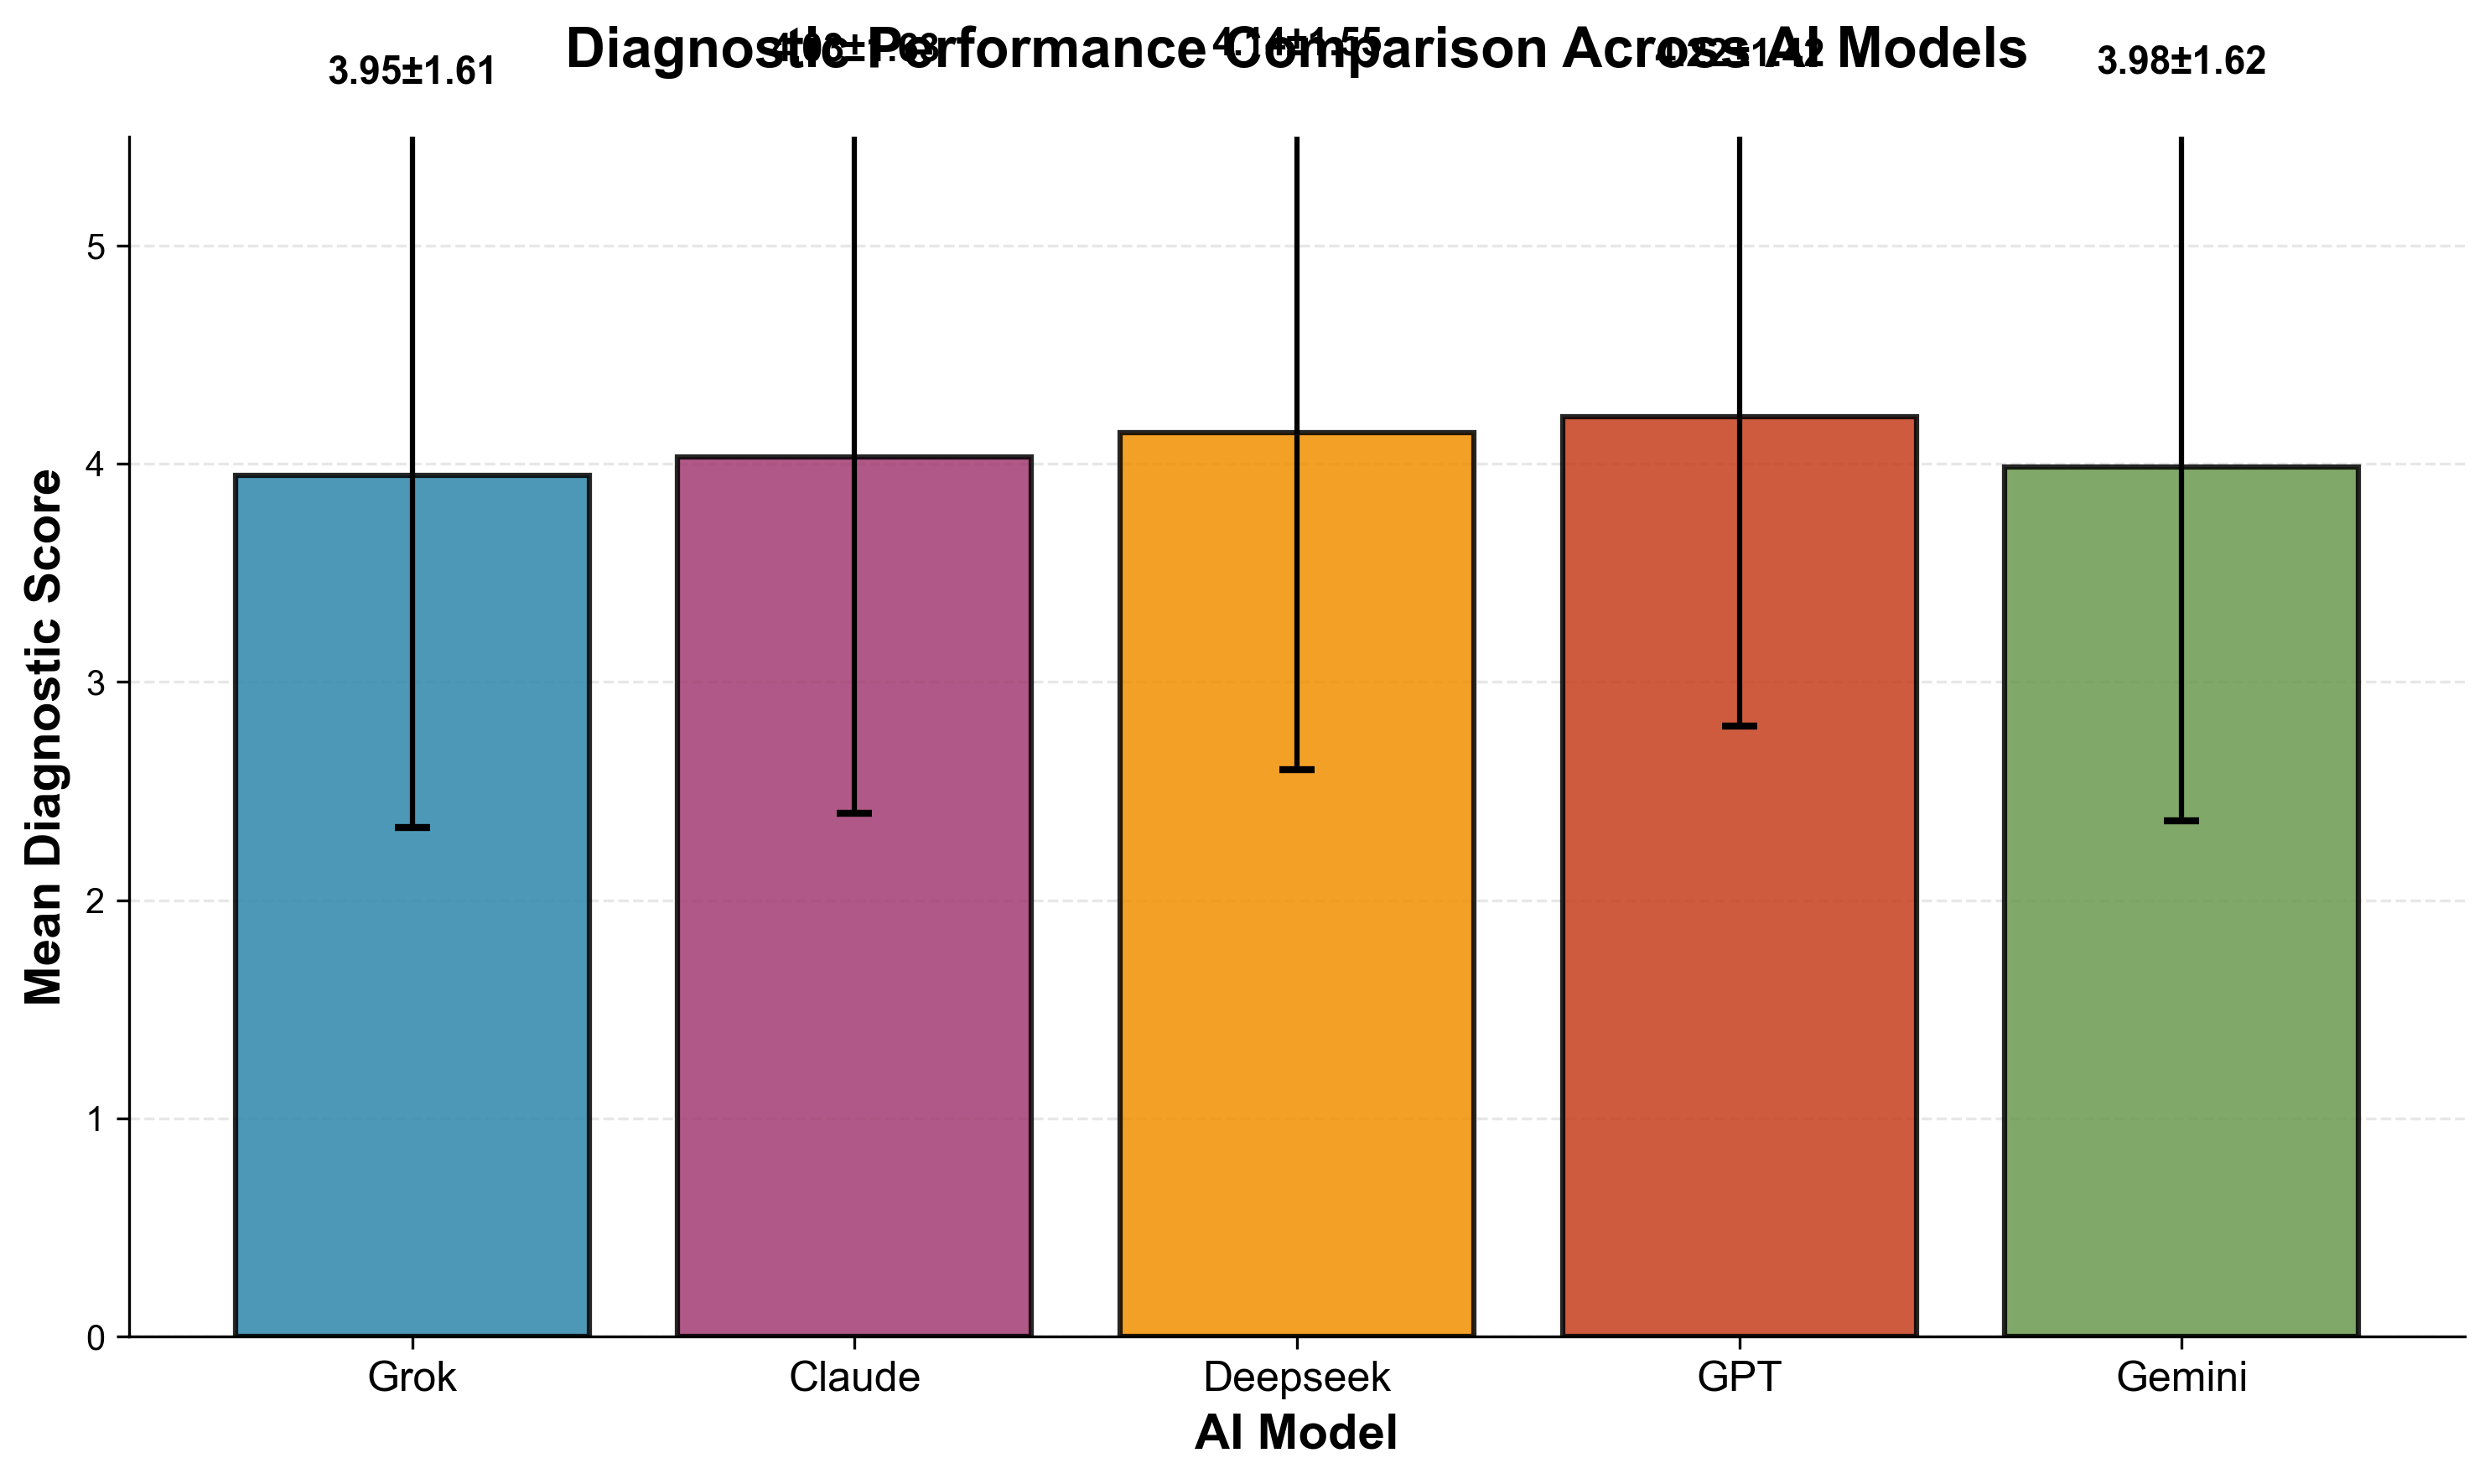

✓ Figure 1 saved: fig1_mean_scores_comparison.png/.pdf


In [10]:
# Publication-ready bar plot for mean scores
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data
mean_scores = [human_avg[model].mean() for model in model_names]
std_scores = [human_avg[model].std() for model in model_names]

# Define colors (professional palette)
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']

# Create bars
x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, mean_scores, color=colors, edgecolor='black', linewidth=1.5, alpha=0.85)

# Add error bars (standard deviation)
ax.errorbar(x_pos, mean_scores, yerr=std_scores, fmt='none', 
            ecolor='black', capsize=5, capthick=2, linewidth=1.5)

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, mean_scores, std_scores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.15,
            f'{mean:.2f}±{std:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Styling
ax.set_ylabel('Mean Diagnostic Score', fontsize=14, fontweight='bold')
ax.set_xlabel('AI Model', fontsize=14, fontweight='bold')
ax.set_title('Diagnostic Performance Comparison Across AI Models', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=12)
ax.set_ylim(0, 5.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('fig1_mean_scores_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig('fig1_mean_scores_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 1 saved: fig1_mean_scores_comparison.png/.pdf")

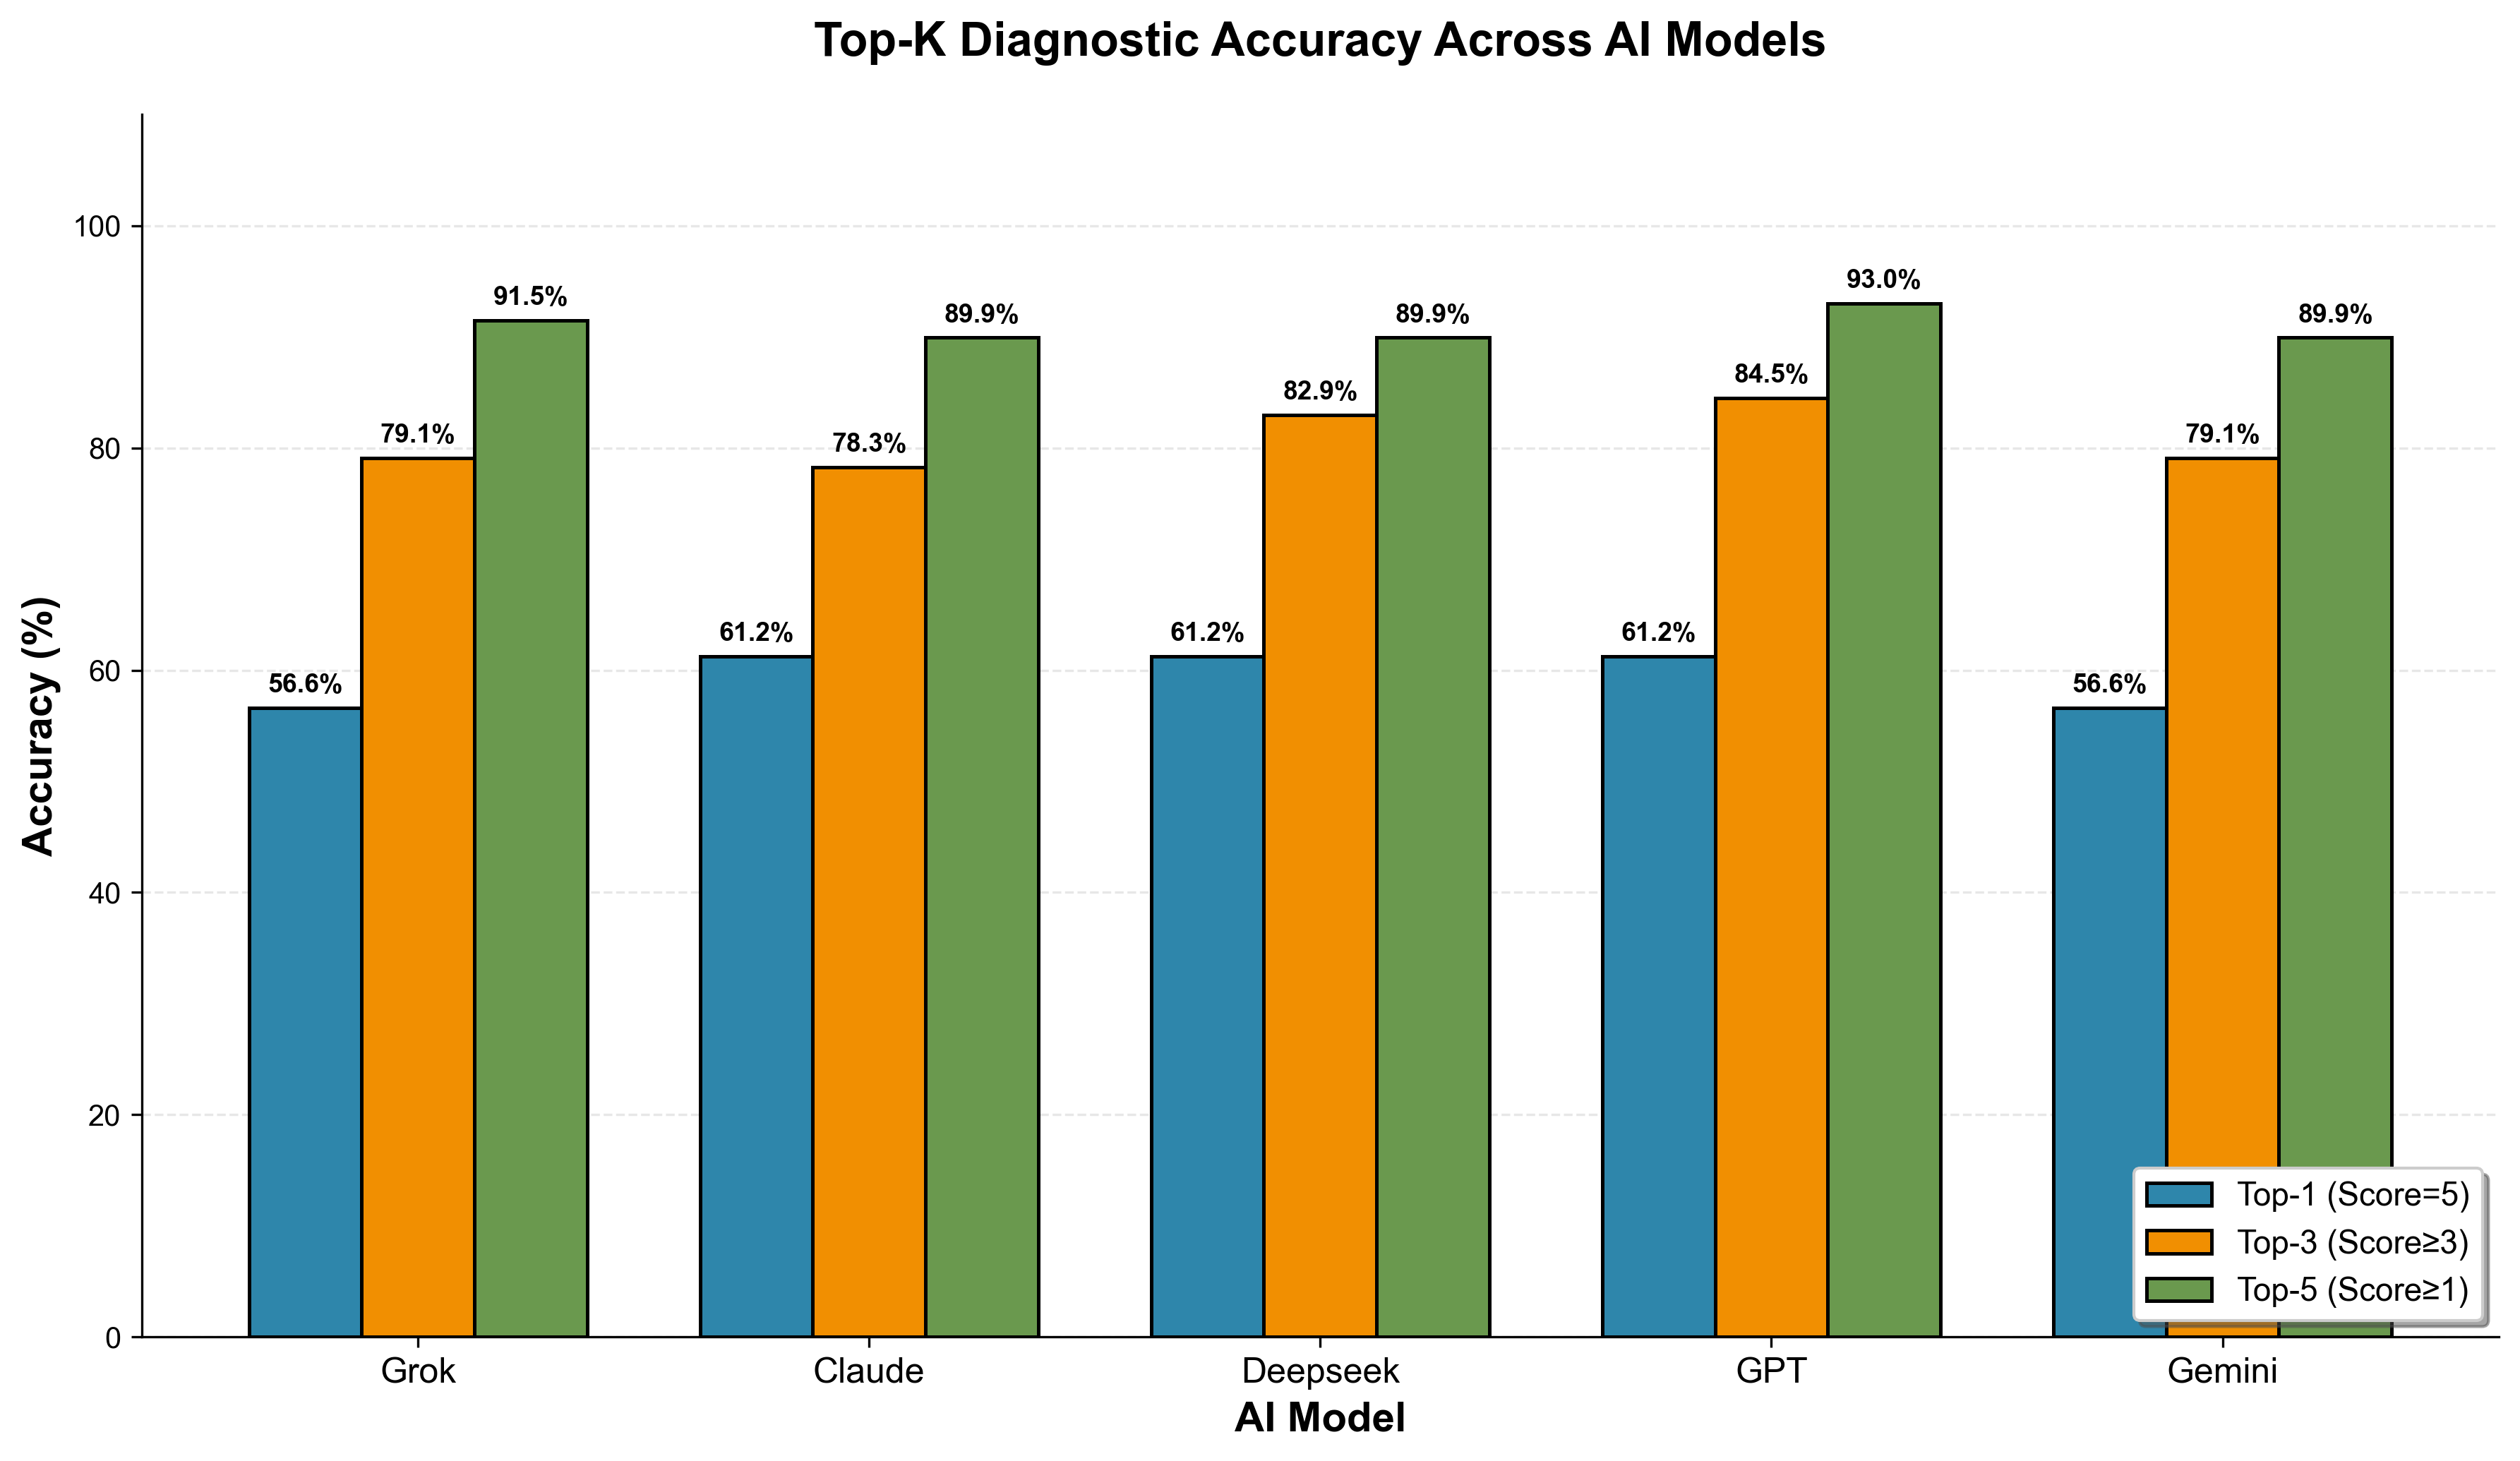

✓ Figure 2 saved: fig2_topk_accuracy.png/.pdf


In [11]:
# Publication-ready grouped bar plot for Top-K accuracy
fig, ax = plt.subplots(figsize=(12, 7))

# Prepare data
top1_pct = [topk_df[topk_df['Model']==m]['Top-1 %'].values[0] for m in model_names]
top3_pct = [topk_df[topk_df['Model']==m]['Top-3 %'].values[0] for m in model_names]
top5_pct = [topk_df[topk_df['Model']==m]['Top-5 %'].values[0] for m in model_names]

x_pos = np.arange(len(model_names))
width = 0.25

# Create grouped bars
bars1 = ax.bar(x_pos - width, top1_pct, width, label='Top-1 (Score=5)', 
               color='#2E86AB', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x_pos, top3_pct, width, label='Top-3 (Score≥3)', 
               color='#F18F01', edgecolor='black', linewidth=1.2)
bars3 = ax.bar(x_pos + width, top5_pct, width, label='Top-5 (Score≥1)', 
               color='#6A994E', edgecolor='black', linewidth=1.2)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Styling
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('AI Model', fontsize=14, fontweight='bold')
ax.set_title('Top-K Diagnostic Accuracy Across AI Models', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=12)
ax.legend(loc='lower right', fontsize=11, frameon=True, shadow=True)
ax.set_ylim(0, 110)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('fig2_topk_accuracy.png', dpi=300, bbox_inches='tight')
plt.savefig('fig2_topk_accuracy.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 2 saved: fig2_topk_accuracy.png/.pdf")

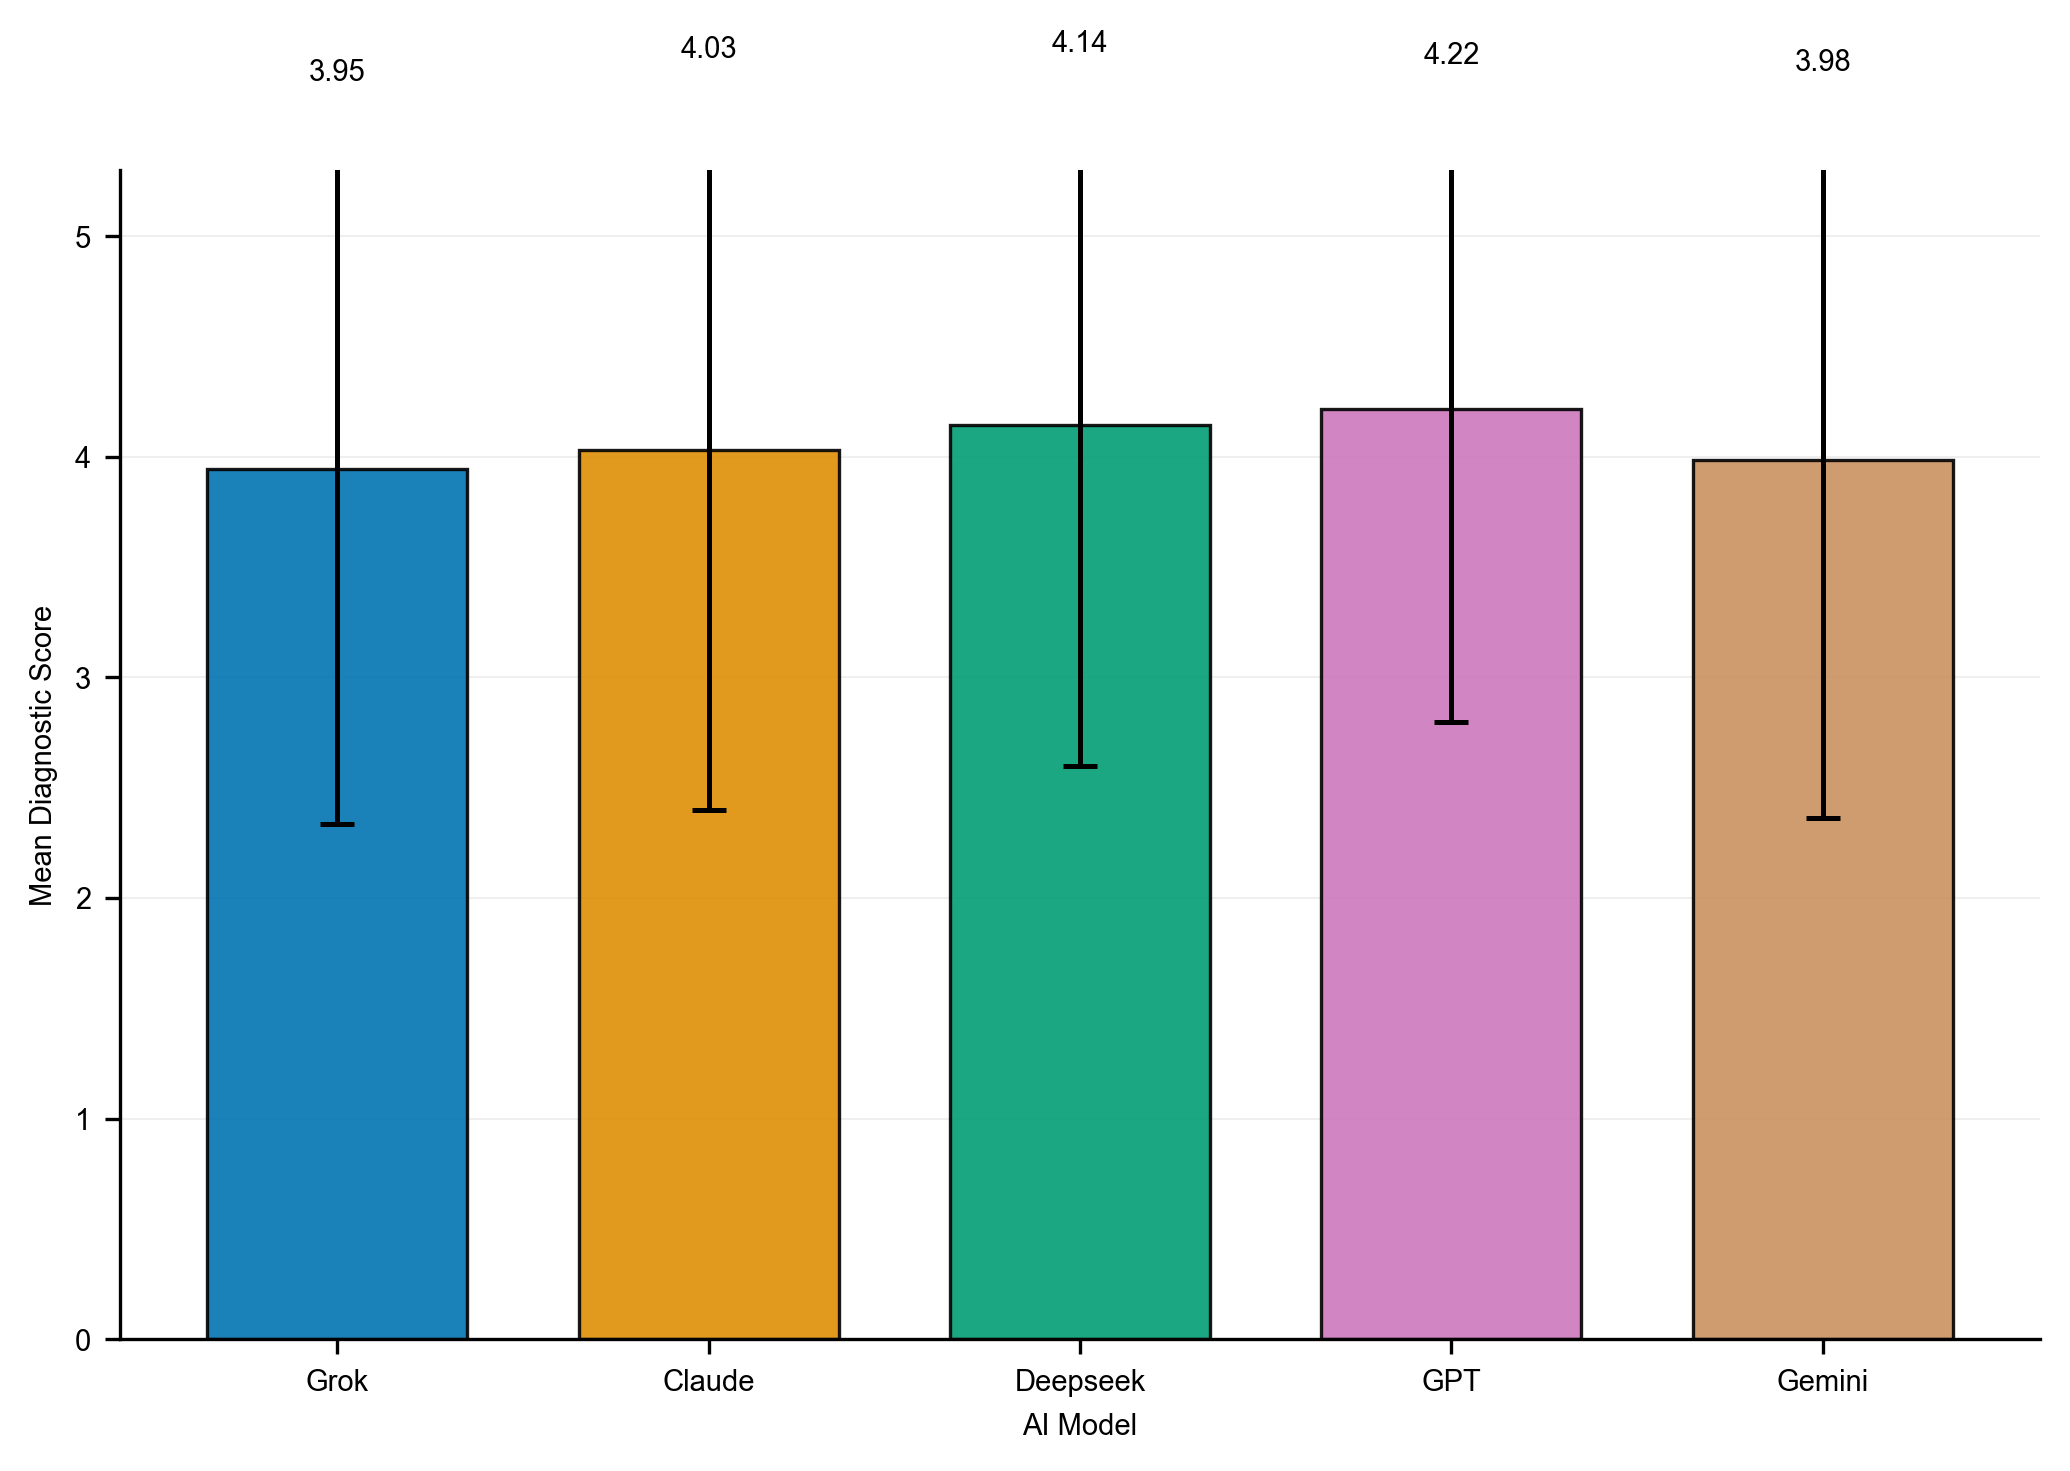

✓ Figure 1 saved: Figure1_mean_scores (PNG, PDF, TIFF at 600 DPI)


In [12]:
# NPJ Digital Medicine compliant figure - Mean scores
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(7, 5))  # ~180mm width

# Data
mean_scores = [human_avg[model].mean() for model in model_names]
std_scores = [human_avg[model].std() for model in model_names]

# Professional Nature color palette
colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161']

# Create bars
x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, mean_scores, color=colors, edgecolor='black', 
              linewidth=0.8, alpha=0.9, width=0.7)

# Add error bars (SD)
ax.errorbar(x_pos, mean_scores, yerr=std_scores, fmt='none', 
            ecolor='black', capsize=4, capthick=1.2, linewidth=1.2, zorder=10)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars, mean_scores, std_scores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.12,
            f'{mean:.2f}', ha='center', va='bottom', fontsize=7, 
            fontweight='normal', family='Arial')

# Styling per NPJ guidelines
ax.set_ylabel('Mean Diagnostic Score', fontsize=7, fontweight='normal', family='Arial')
ax.set_xlabel('AI Model', fontsize=7, fontweight='normal', family='Arial')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_ylim(0, 5.3)

# Clean professional styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('Figure1_mean_scores.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure1_mean_scores.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure1_mean_scores.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 1 saved: Figure1_mean_scores (PNG, PDF, TIFF at 600 DPI)")

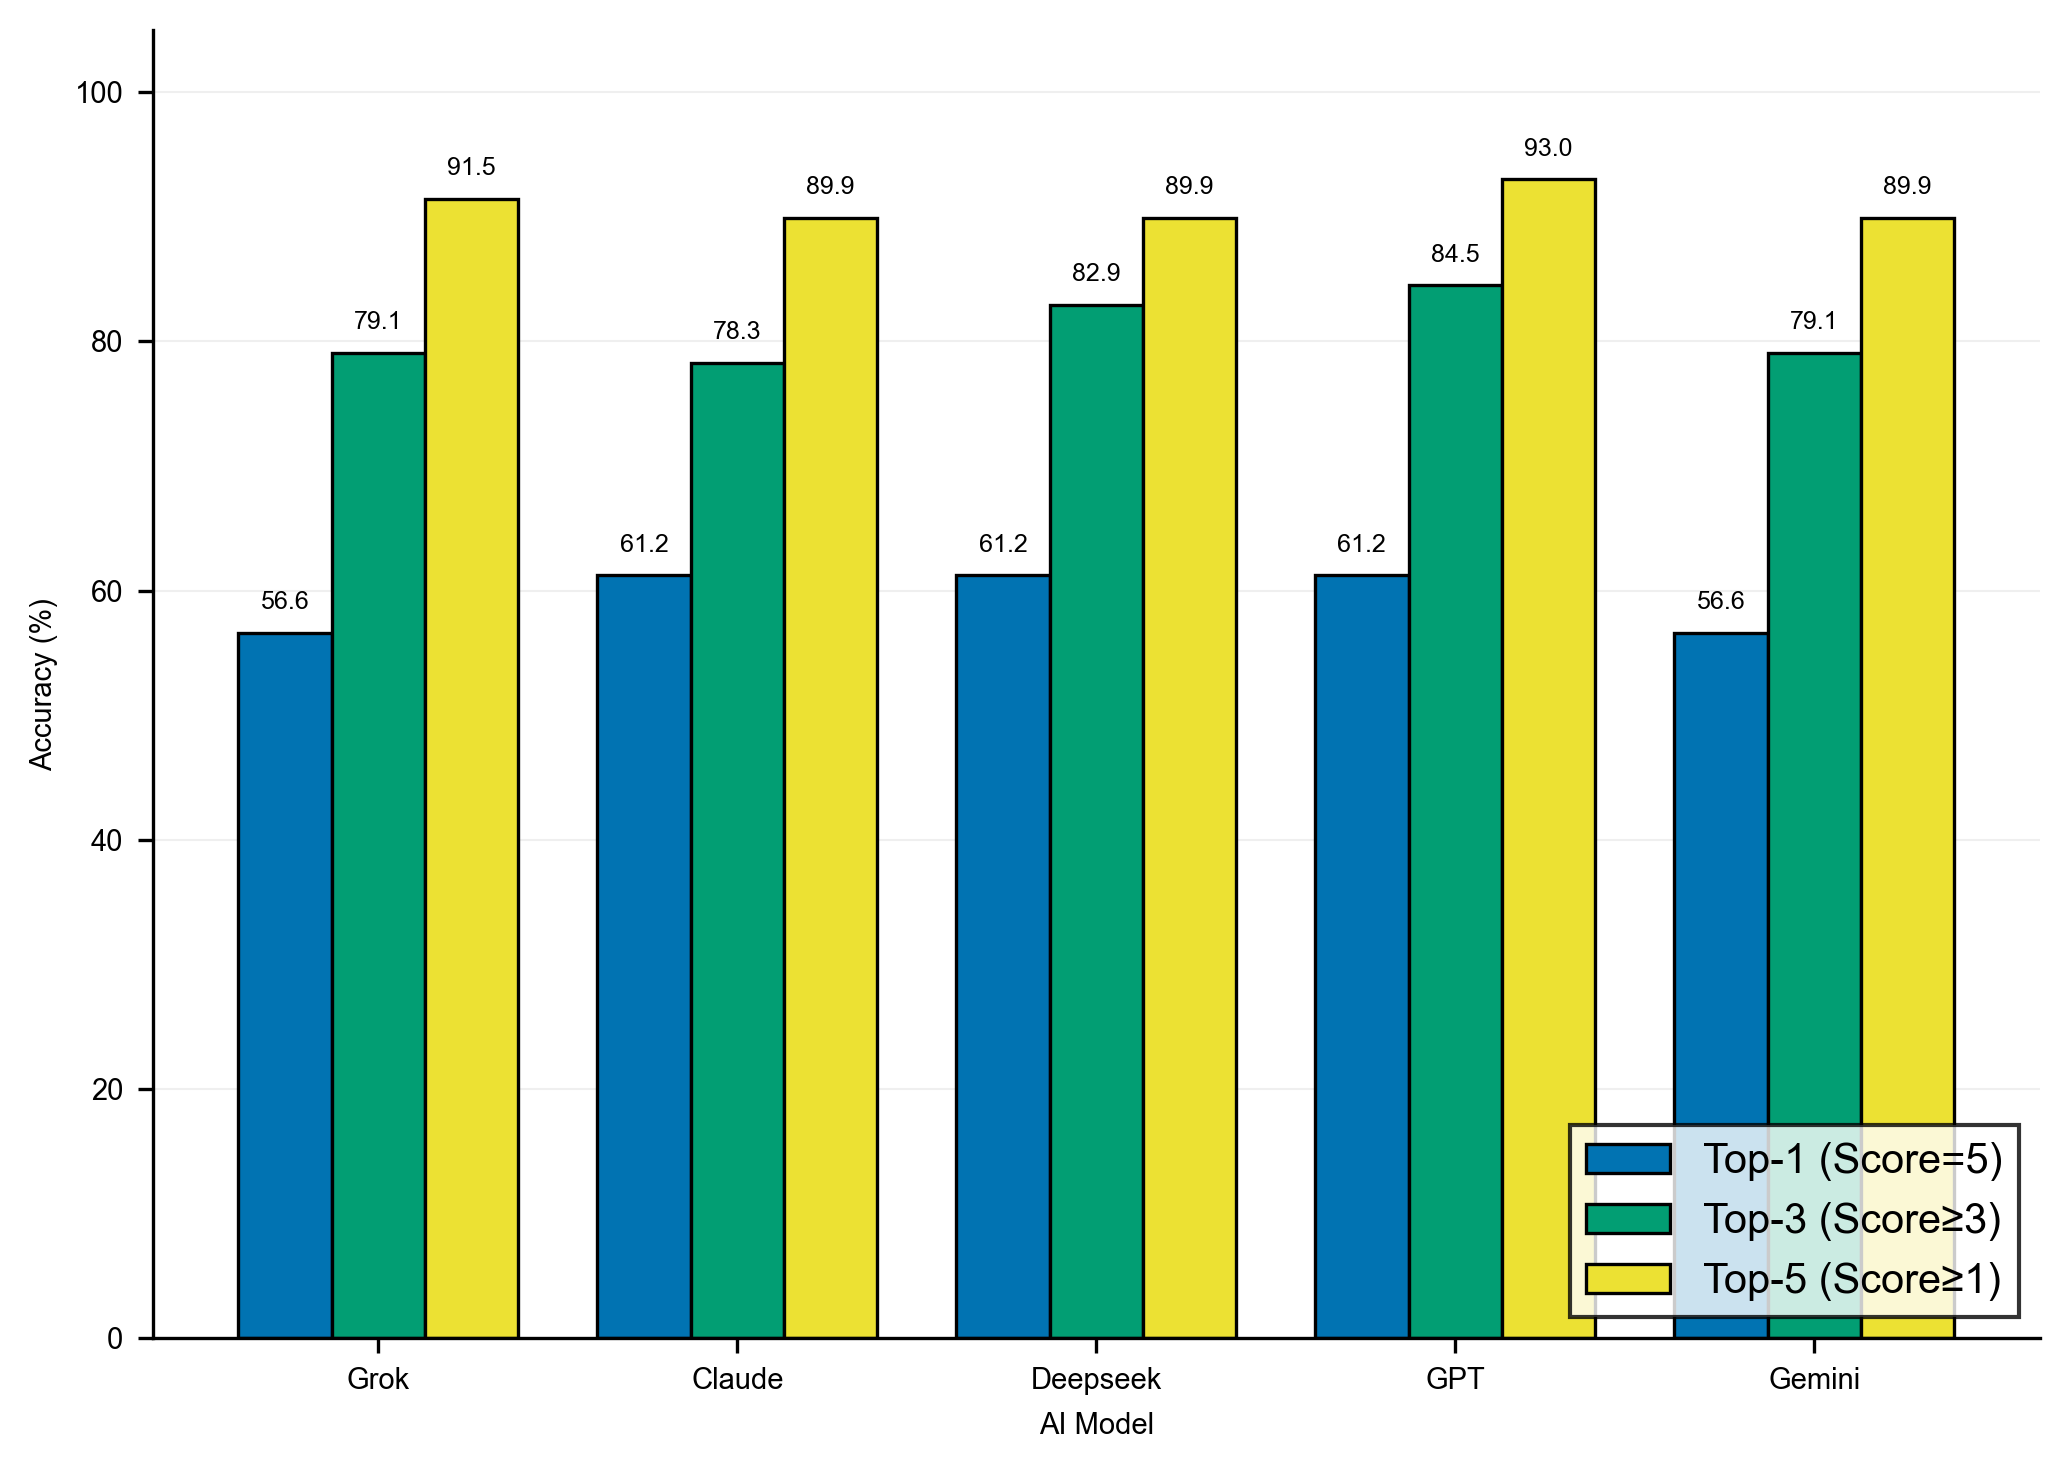

✓ Figure 2 saved: Figure2_topk_accuracy (PNG, PDF, TIFF at 600 DPI)


In [13]:
# NPJ Digital Medicine compliant figure - Top-K Accuracy
fig, ax = plt.subplots(figsize=(7, 5))

# Data
top1_pct = [topk_df[topk_df['Model']==m]['Top-1 %'].values[0] for m in model_names]
top3_pct = [topk_df[topk_df['Model']==m]['Top-3 %'].values[0] for m in model_names]
top5_pct = [topk_df[topk_df['Model']==m]['Top-5 %'].values[0] for m in model_names]

x_pos = np.arange(len(model_names))
width = 0.26

# Nature color palette
colors_topk = ['#0173B2', '#029E73', '#ECE133']

# Create grouped bars
bars1 = ax.bar(x_pos - width, top1_pct, width, label='Top-1 (Score=5)', 
               color=colors_topk[0], edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x_pos, top3_pct, width, label='Top-3 (Score≥3)', 
               color=colors_topk[1], edgecolor='black', linewidth=0.8)
bars3 = ax.bar(x_pos + width, top5_pct, width, label='Top-5 (Score≥1)', 
               color=colors_topk[2], edgecolor='black', linewidth=0.8)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1.5,
                f'{height:.1f}', ha='center', va='bottom', 
                fontsize=6, fontweight='normal', family='Arial')

# Styling per NPJ guidelines
ax.set_ylabel('Accuracy (%)', fontsize=7, fontweight='normal', family='Arial')
ax.set_xlabel('AI Model', fontsize=7, fontweight='normal', family='Arial')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.legend(loc='lower right', fontsize=6, frameon=True, edgecolor='black', 
          fancybox=False, shadow=False, prop={'family': 'Arial'})
ax.set_ylim(0, 105)

# Clean styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('Figure2_topk_accuracy.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2_topk_accuracy.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2_topk_accuracy.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 2 saved: Figure2_topk_accuracy (PNG, PDF, TIFF at 600 DPI)")

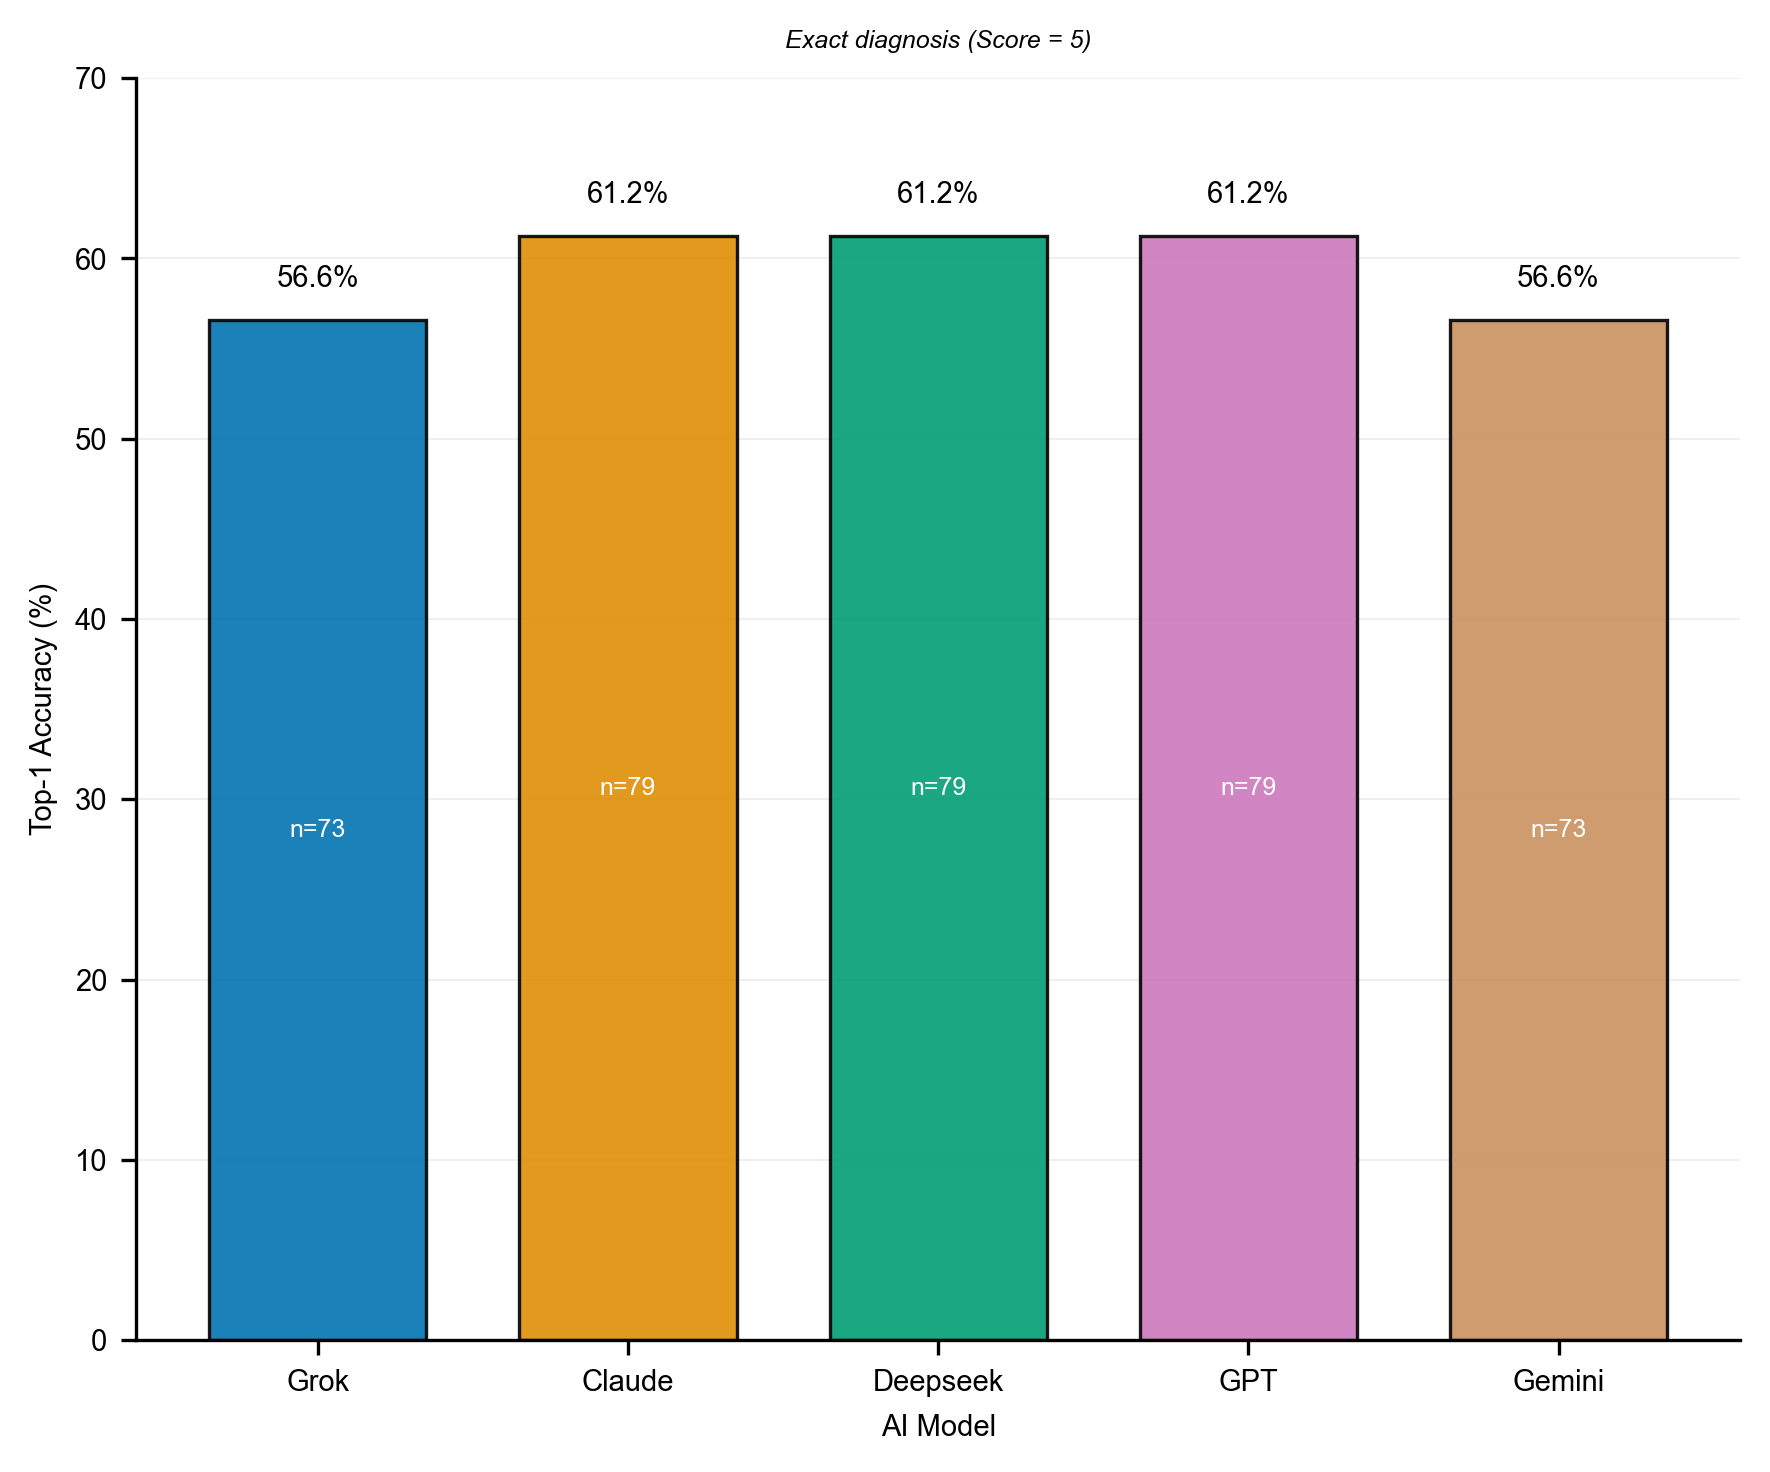

✓ Figure 2a saved: Figure2a_top1_accuracy (Score=5)


In [14]:
# NPJ Digital Medicine compliant - Top-1 Accuracy Only
fig, ax = plt.subplots(figsize=(6, 5))

# Data - Top-1 only
top1_pct = [topk_df[topk_df['Model']==m]['Top-1 %'].values[0] for m in model_names]
top1_count = [topk_df[topk_df['Model']==m]['Top-1 (Score=5)'].values[0] for m in model_names]

# Professional Nature color palette
colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161']

x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, top1_pct, color=colors, edgecolor='black', 
              linewidth=0.8, alpha=0.9, width=0.7)

# Add percentage labels on bars
for i, (bar, pct, count) in enumerate(zip(bars, top1_pct, top1_count)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1.5,
            f'{pct:.1f}%', ha='center', va='bottom', 
            fontsize=7, fontweight='normal', family='Arial')
    # Add count inside bar
    ax.text(bar.get_x() + bar.get_width()/2., height/2,
            f'n={int(count)}', ha='center', va='center', 
            fontsize=6, fontweight='normal', family='Arial', color='white')

# Styling per NPJ guidelines
ax.set_ylabel('Top-1 Accuracy (%)', fontsize=7, fontweight='normal', family='Arial')
ax.set_xlabel('AI Model', fontsize=7, fontweight='normal', family='Arial')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_ylim(0, 70)

# Clean styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_axisbelow(True)

# Add subtitle
ax.text(0.5, 1.02, 'Exact diagnosis (Score = 5)', transform=ax.transAxes,
        ha='center', va='bottom', fontsize=6, style='italic', family='Arial')

plt.tight_layout()
plt.savefig('Figure2a_top1_accuracy.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2a_top1_accuracy.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2a_top1_accuracy.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 2a saved: Figure2a_top1_accuracy (Score=5)")

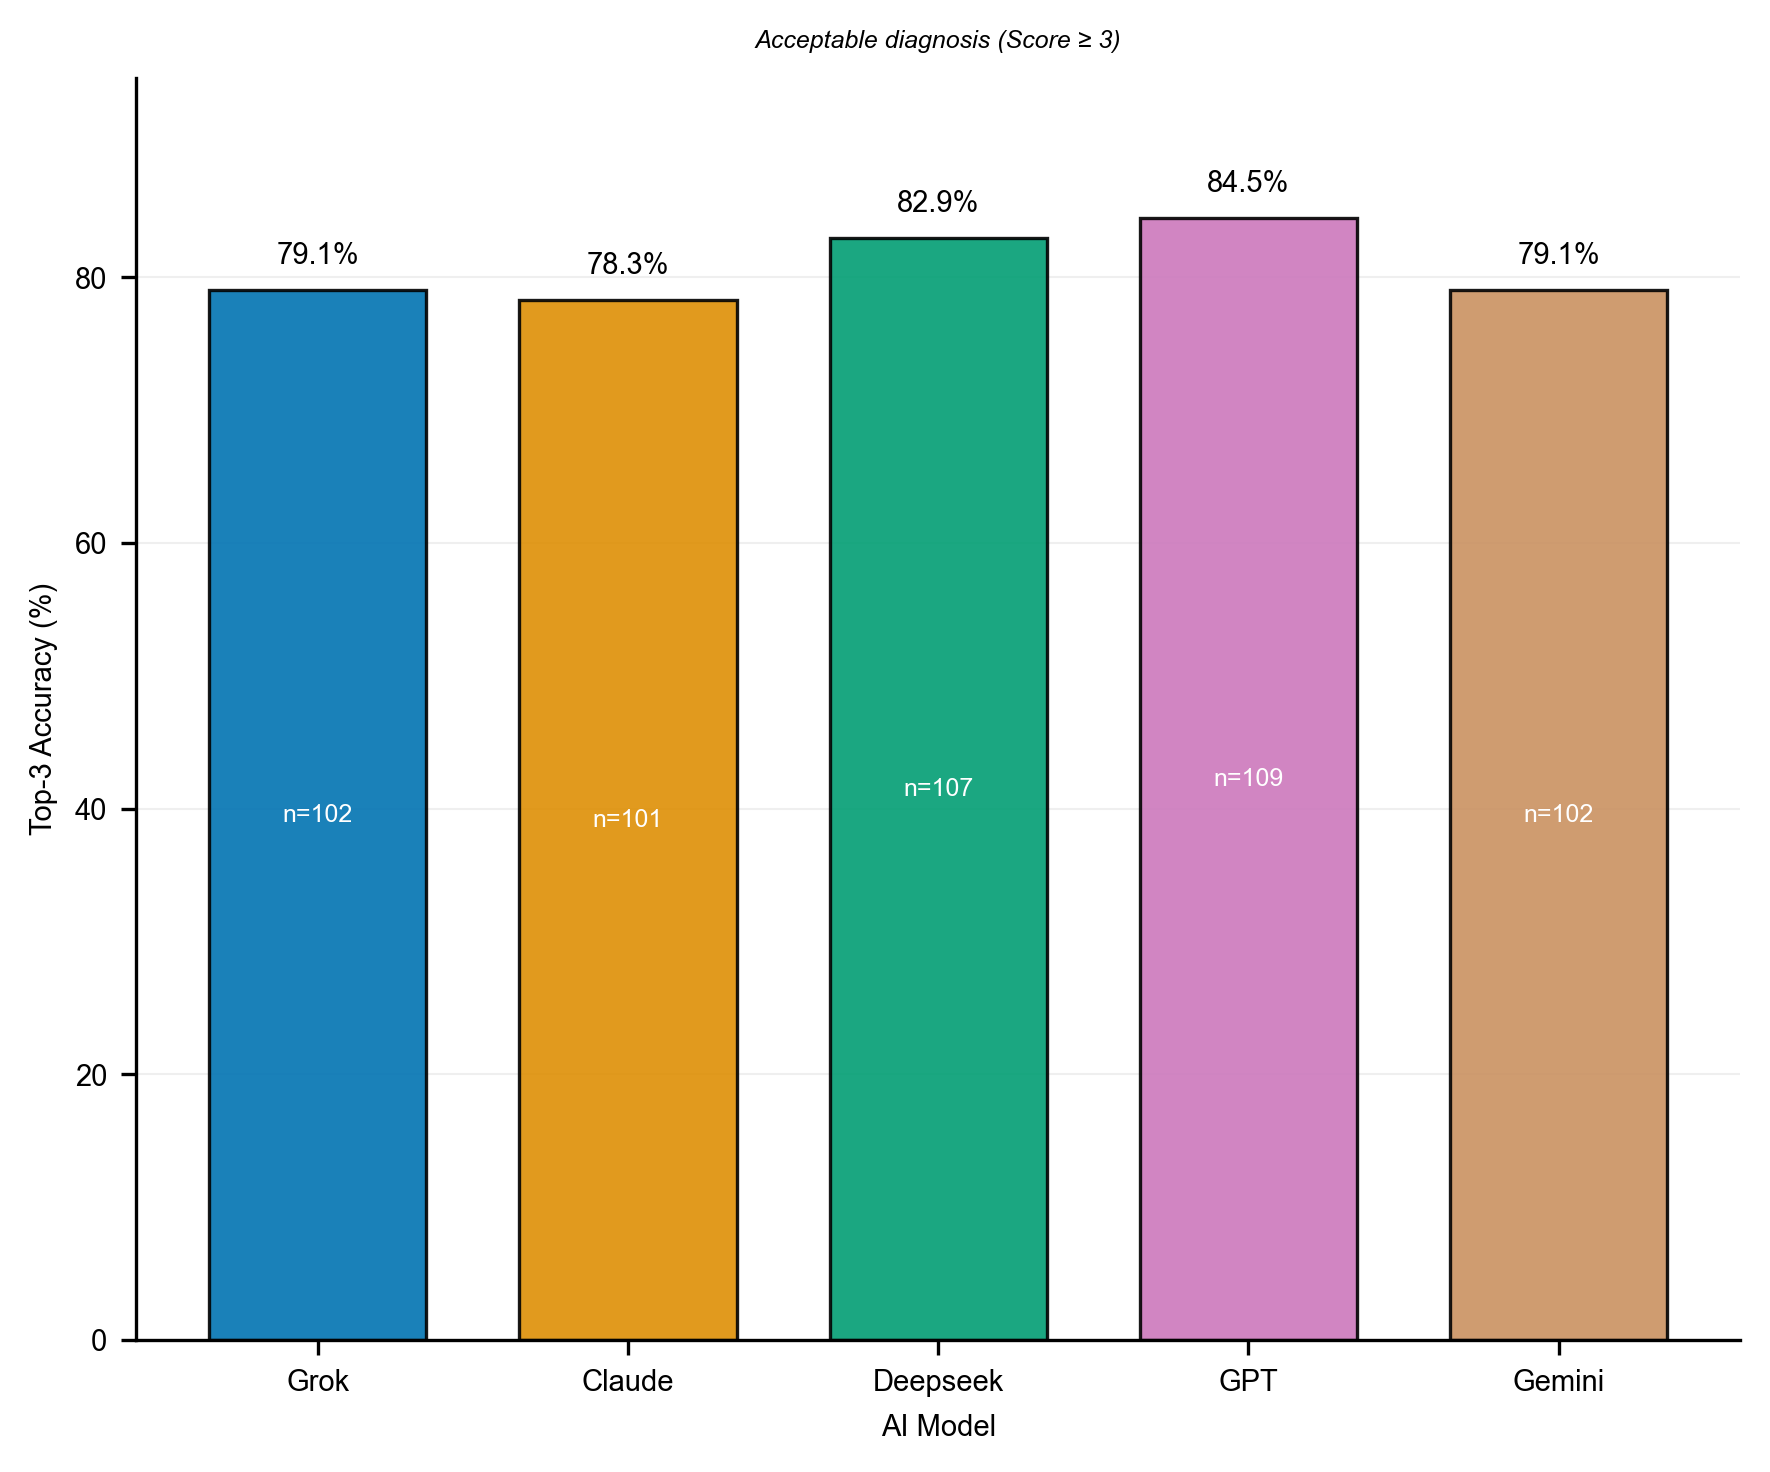

✓ Figure 2b saved: Figure2b_top3_accuracy (Score≥3)


In [15]:
# NPJ Digital Medicine compliant - Top-3 Accuracy Only
fig, ax = plt.subplots(figsize=(6, 5))

# Data - Top-3 only
top3_pct = [topk_df[topk_df['Model']==m]['Top-3 %'].values[0] for m in model_names]
top3_count = [topk_df[topk_df['Model']==m]['Top-3 (Score>=3)'].values[0] for m in model_names]

# Professional Nature color palette
colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161']

x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, top3_pct, color=colors, edgecolor='black', 
              linewidth=0.8, alpha=0.9, width=0.7)

# Add percentage labels on bars
for i, (bar, pct, count) in enumerate(zip(bars, top3_pct, top3_count)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1.5,
            f'{pct:.1f}%', ha='center', va='bottom', 
            fontsize=7, fontweight='normal', family='Arial')
    # Add count inside bar
    ax.text(bar.get_x() + bar.get_width()/2., height/2,
            f'n={int(count)}', ha='center', va='center', 
            fontsize=6, fontweight='normal', family='Arial', color='white')

# Styling per NPJ guidelines
ax.set_ylabel('Top-3 Accuracy (%)', fontsize=7, fontweight='normal', family='Arial')
ax.set_xlabel('AI Model', fontsize=7, fontweight='normal', family='Arial')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_ylim(0, 95)

# Clean styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_axisbelow(True)

# Add subtitle
ax.text(0.5, 1.02, 'Acceptable diagnosis (Score ≥ 3)', transform=ax.transAxes,
        ha='center', va='bottom', fontsize=6, style='italic', family='Arial')

plt.tight_layout()
plt.savefig('Figure2b_top3_accuracy.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2b_top3_accuracy.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2b_top3_accuracy.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 2b saved: Figure2b_top3_accuracy (Score≥3)")

In [19]:
# %%
import os
print("Current working directory:")
print(os.getcwd())

print("\nFiles currently in this directory:")
print(os.listdir(os.getcwd()))


Current working directory:
d:\Sleep_medicine\sleep

Files currently in this directory:
['book_Book_failure_heatmap.png', 'book_Book_failure_rate.png', 'book_Book_mean_heatmap.png', 'book_Book_mean_scores.png', 'book_Book_top1.png', 'case_difficulty_distribution.png', 'co_failure_heatmap.png', 'demographics_results.xlsx', 'diagnostic_performance_results.xlsx', 'error_analysis_results.xlsx', 'failure_analysis_results.xlsx', 'failure_distribution_across_models.png', 'failure_heatmap_by_source.png', 'failure_rate_by_domain.png', 'failure_rate_by_model.png', 'failure_rate_by_source.png', 'fig1_mean_scores_comparison.pdf', 'fig1_mean_scores_comparison.png', 'fig2_topk_accuracy.pdf', 'fig2_topk_accuracy.png', 'Figure1_mean_scores.pdf', 'Figure1_mean_scores.png', 'Figure1_mean_scores.tiff', 'Figure2a_top1_accuracy.pdf', 'Figure2a_top1_accuracy.png', 'Figure2a_top1_accuracy.tiff', 'Figure2b_top3_accuracy.pdf', 'Figure2b_top3_accuracy.png', 'Figure2b_top3_accuracy.tiff', 'Figure2_topk_accuracy.p

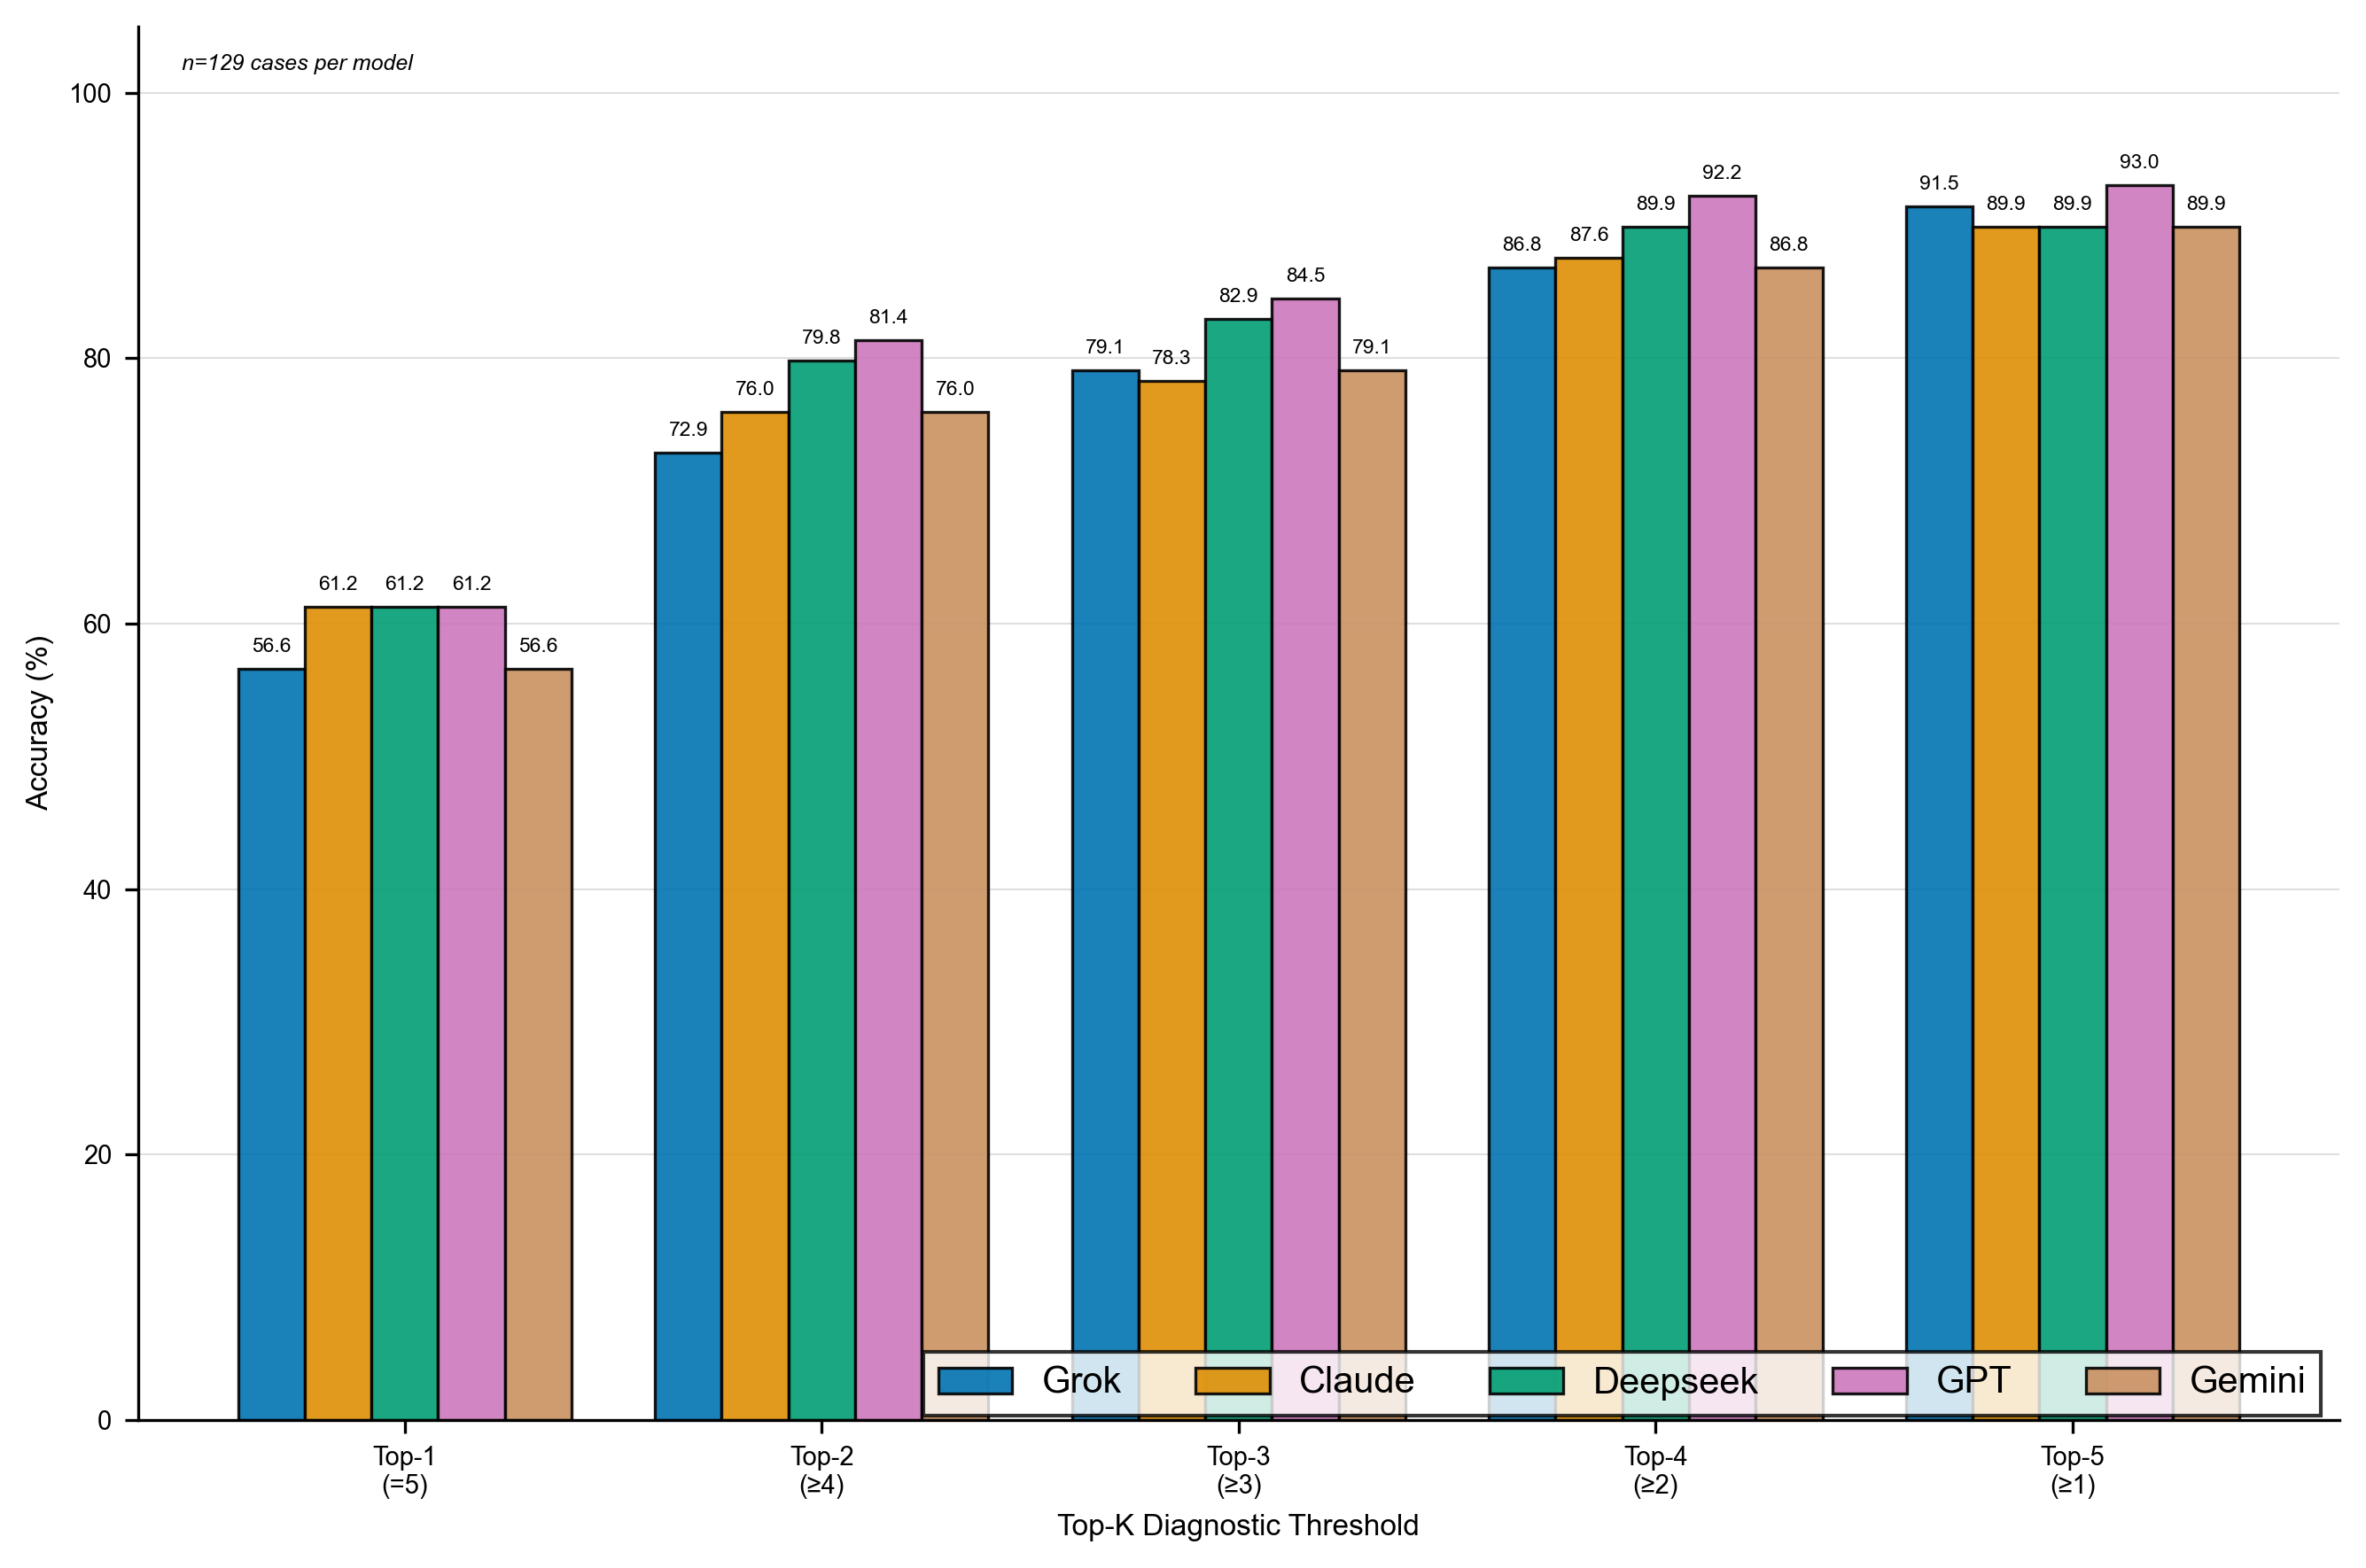

✓ Figure 2 saved: Comprehensive Top-K threshold rates by model
  Models compared: Grok, Claude, Deepseek, GPT, Gemini
  Metrics: Top-1 through Top-5


In [11]:
# NPJ Digital Medicine compliant - Comprehensive Top-K threshold rates
fig, ax = plt.subplots(figsize=(9, 6))

# Prepare comprehensive Top-K data
metrics = ['Top-1\n(=5)', 'Top-2\n(≥4)', 'Top-3\n(≥3)', 'Top-4\n(≥2)', 'Top-5\n(≥1)']

# Calculate all Top-K rates
topk_data = {}
for model in model_names:
    scores = human_avg[model].dropna()
    n_total = len(scores)
    
    topk_data[model] = [
        (scores == 5).sum() / n_total * 100,  # Top-1
        (scores >= 4).sum() / n_total * 100,  # Top-2
        (scores >= 3).sum() / n_total * 100,  # Top-3
        (scores >= 2).sum() / n_total * 100,  # Top-4
        (scores >= 1).sum() / n_total * 100,  # Top-5
    ]

# Professional Nature color palette (colorblind-friendly)
colors = {
    'Grok': '#0173B2',
    'Claude': '#DE8F05', 
    'Deepseek': '#029E73',
    'GPT': '#CC78BC',
    'Gemini': '#CA9161'
}

# Set up positions
x = np.arange(len(metrics))
width = 0.16
offsets = [-2*width, -width, 0, width, 2*width]

# Plot bars for each model
bars_list = []
for i, model in enumerate(model_names):
    bars = ax.bar(x + offsets[i], topk_data[model], width, 
                  label=model, color=colors[model], 
                  edgecolor='black', linewidth=0.8, alpha=0.9)
    bars_list.append(bars)
    
    # Add value labels on top of bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1.0,
                f'{topk_data[model][j]:.1f}',
                ha='center', va='bottom', fontsize=5.5, 
                fontweight='normal', family='Arial')

# Styling per NPJ guidelines
ax.set_ylabel('Accuracy (%)', fontsize=8, fontweight='normal', family='Arial')
ax.set_xlabel('Top-K Diagnostic Threshold', fontsize=8, fontweight='normal', family='Arial')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_ylim(0, 105)

# Legend
ax.legend(loc='lower right', fontsize=7, frameon=True, 
          edgecolor='black', fancybox=False, shadow=False, 
          prop={'family': 'Arial'}, ncol=5, 
          bbox_to_anchor=(1.0, -0.01))

# Clean professional styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.25, linewidth=0.5, color='gray')
ax.set_axisbelow(True)

# Add sample size annotation
ax.text(0.02, 0.98, 'n=129 cases per model', 
        transform=ax.transAxes, fontsize=6, 
        va='top', ha='left', family='Arial', style='italic')

plt.tight_layout()
plt.savefig('Figure2_topk_comprehensive.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2_topk_comprehensive.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2_topk_comprehensive.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 2 saved: Comprehensive Top-K threshold rates by model")
print(f"  Models compared: {', '.join(model_names)}")
print(f"  Metrics: Top-1 through Top-5")

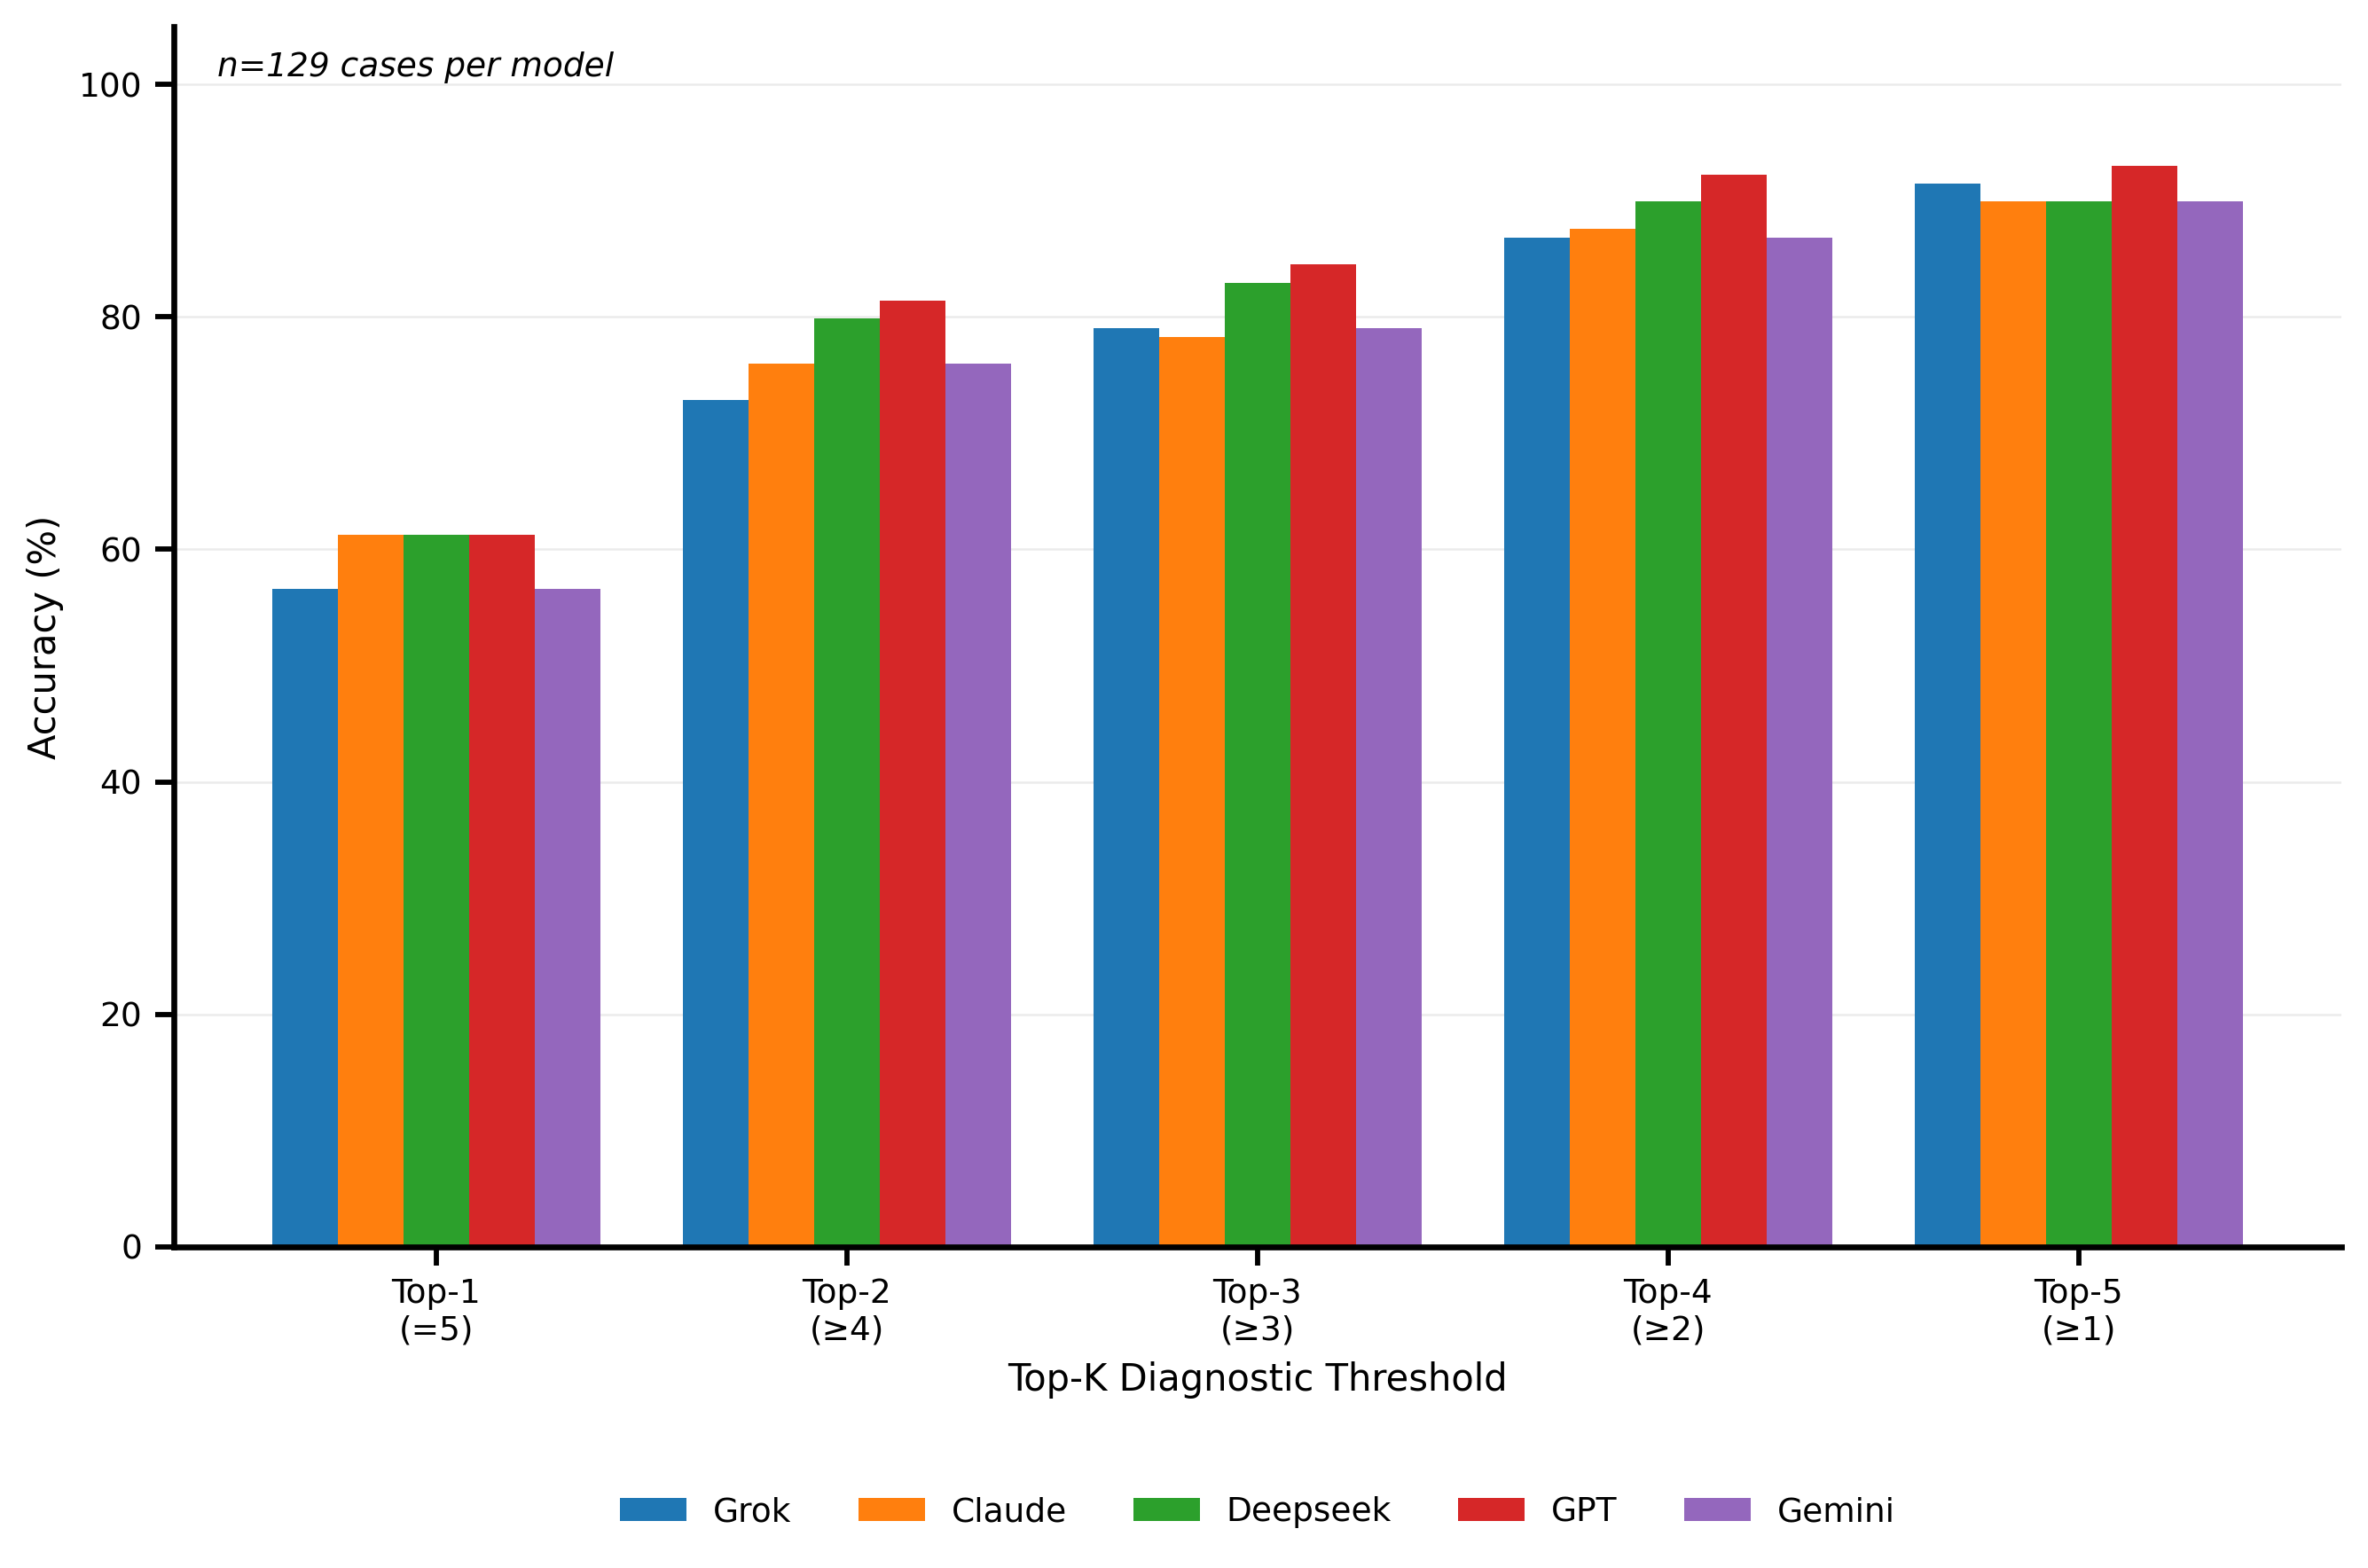

Saved files:
PNG : d:\sleep_final\figures\Figure2_topk_comprehensive.png | exists: True
PDF : d:\sleep_final\figures\Figure2_topk_comprehensive.pdf | exists: True
TIFF: d:\sleep_final\figures\Figure2_topk_comprehensive.tiff | exists: True


In [12]:
# %%
import os
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Match the reference palette (Matplotlib tab10) ---
# Grok (blue), Claude (orange), DeepSeek (green), GPT (red), Gemini (purple)
COLORS = {
    "Grok":   "#1f77b4",
    "Claude": "#ff7f0e",
    "Deepseek": "#2ca02c",   # keep your key spelling
    "GPT":    "#d62728",
    "Gemini": "#9467bd",
}

# --- 2) Global style to mimic the screenshot ---
plt.rcParams.update({
    "font.family": "DejaVu Sans",      # close to the screenshot; use Arial if you have it installed
    "axes.titlesize": 11,
    "axes.titleweight": "bold",
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})

# Prepare Top-K data
metrics = ['Top-1\n(=5)', 'Top-2\n(≥4)', 'Top-3\n(≥3)', 'Top-4\n(≥2)', 'Top-5\n(≥1)']

topk_data = {}
for model in model_names:
    scores = human_avg[model].dropna()
    n_total = len(scores)
    topk_data[model] = [
        (scores == 5).sum() / n_total * 100,  # Top-1
        (scores >= 4).sum() / n_total * 100,  # Top-2
        (scores >= 3).sum() / n_total * 100,  # Top-3
        (scores >= 2).sum() / n_total * 100,  # Top-4
        (scores >= 1).sum() / n_total * 100,  # Top-5
    ]

# --- 3) Plot ---
fig, ax = plt.subplots(figsize=(9, 6))

x = np.arange(len(metrics))
width = 0.16
offsets = [-2*width, -width, 0, width, 2*width]

for i, model in enumerate(model_names):
    ax.bar(
        x + offsets[i],
        topk_data[model],
        width=width,
        label=model,
        color=COLORS.get(model, None),
        edgecolor="none",      # IMPORTANT: no black borders (matches reference)
        linewidth=0,
        alpha=1.0
    )

# Axes labels/ticks
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Top-K Diagnostic Threshold")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 105)

# Grid + spines to match reference
ax.grid(axis="y", linewidth=0.6, alpha=0.25)     # subtle horizontal grid
ax.set_axisbelow(True)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.6)
ax.spines["bottom"].set_linewidth(1.6)

ax.tick_params(axis="both", width=1.4, length=5)

# Legend at bottom center (like the photo)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=5,
    frameon=False
)

# Sample size annotation (top-left inside plot)
ax.text(
    0.02, 0.98,
    f"n={len(human_avg[model_names[0]].dropna())} cases per model",
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=9,
    style="italic"
)

plt.tight_layout()

# --- 4) Save robustly (absolute path + check) ---
out_dir = os.path.join(os.getcwd(), "figures")
os.makedirs(out_dir, exist_ok=True)

png_path  = os.path.join(out_dir, "Figure2_topk_comprehensive.png")
pdf_path  = os.path.join(out_dir, "Figure2_topk_comprehensive.pdf")
tiff_path = os.path.join(out_dir, "Figure2_topk_comprehensive.tiff")

fig.savefig(png_path,  dpi=600, bbox_inches="tight", facecolor="white")
fig.savefig(pdf_path,  dpi=600, bbox_inches="tight", facecolor="white")
fig.savefig(tiff_path, dpi=600, bbox_inches="tight", facecolor="white")

plt.show()

print("Saved files:")
print("PNG :", png_path,  "| exists:", os.path.exists(png_path))
print("PDF :", pdf_path,  "| exists:", os.path.exists(pdf_path))
print("TIFF:", tiff_path, "| exists:", os.path.exists(tiff_path))


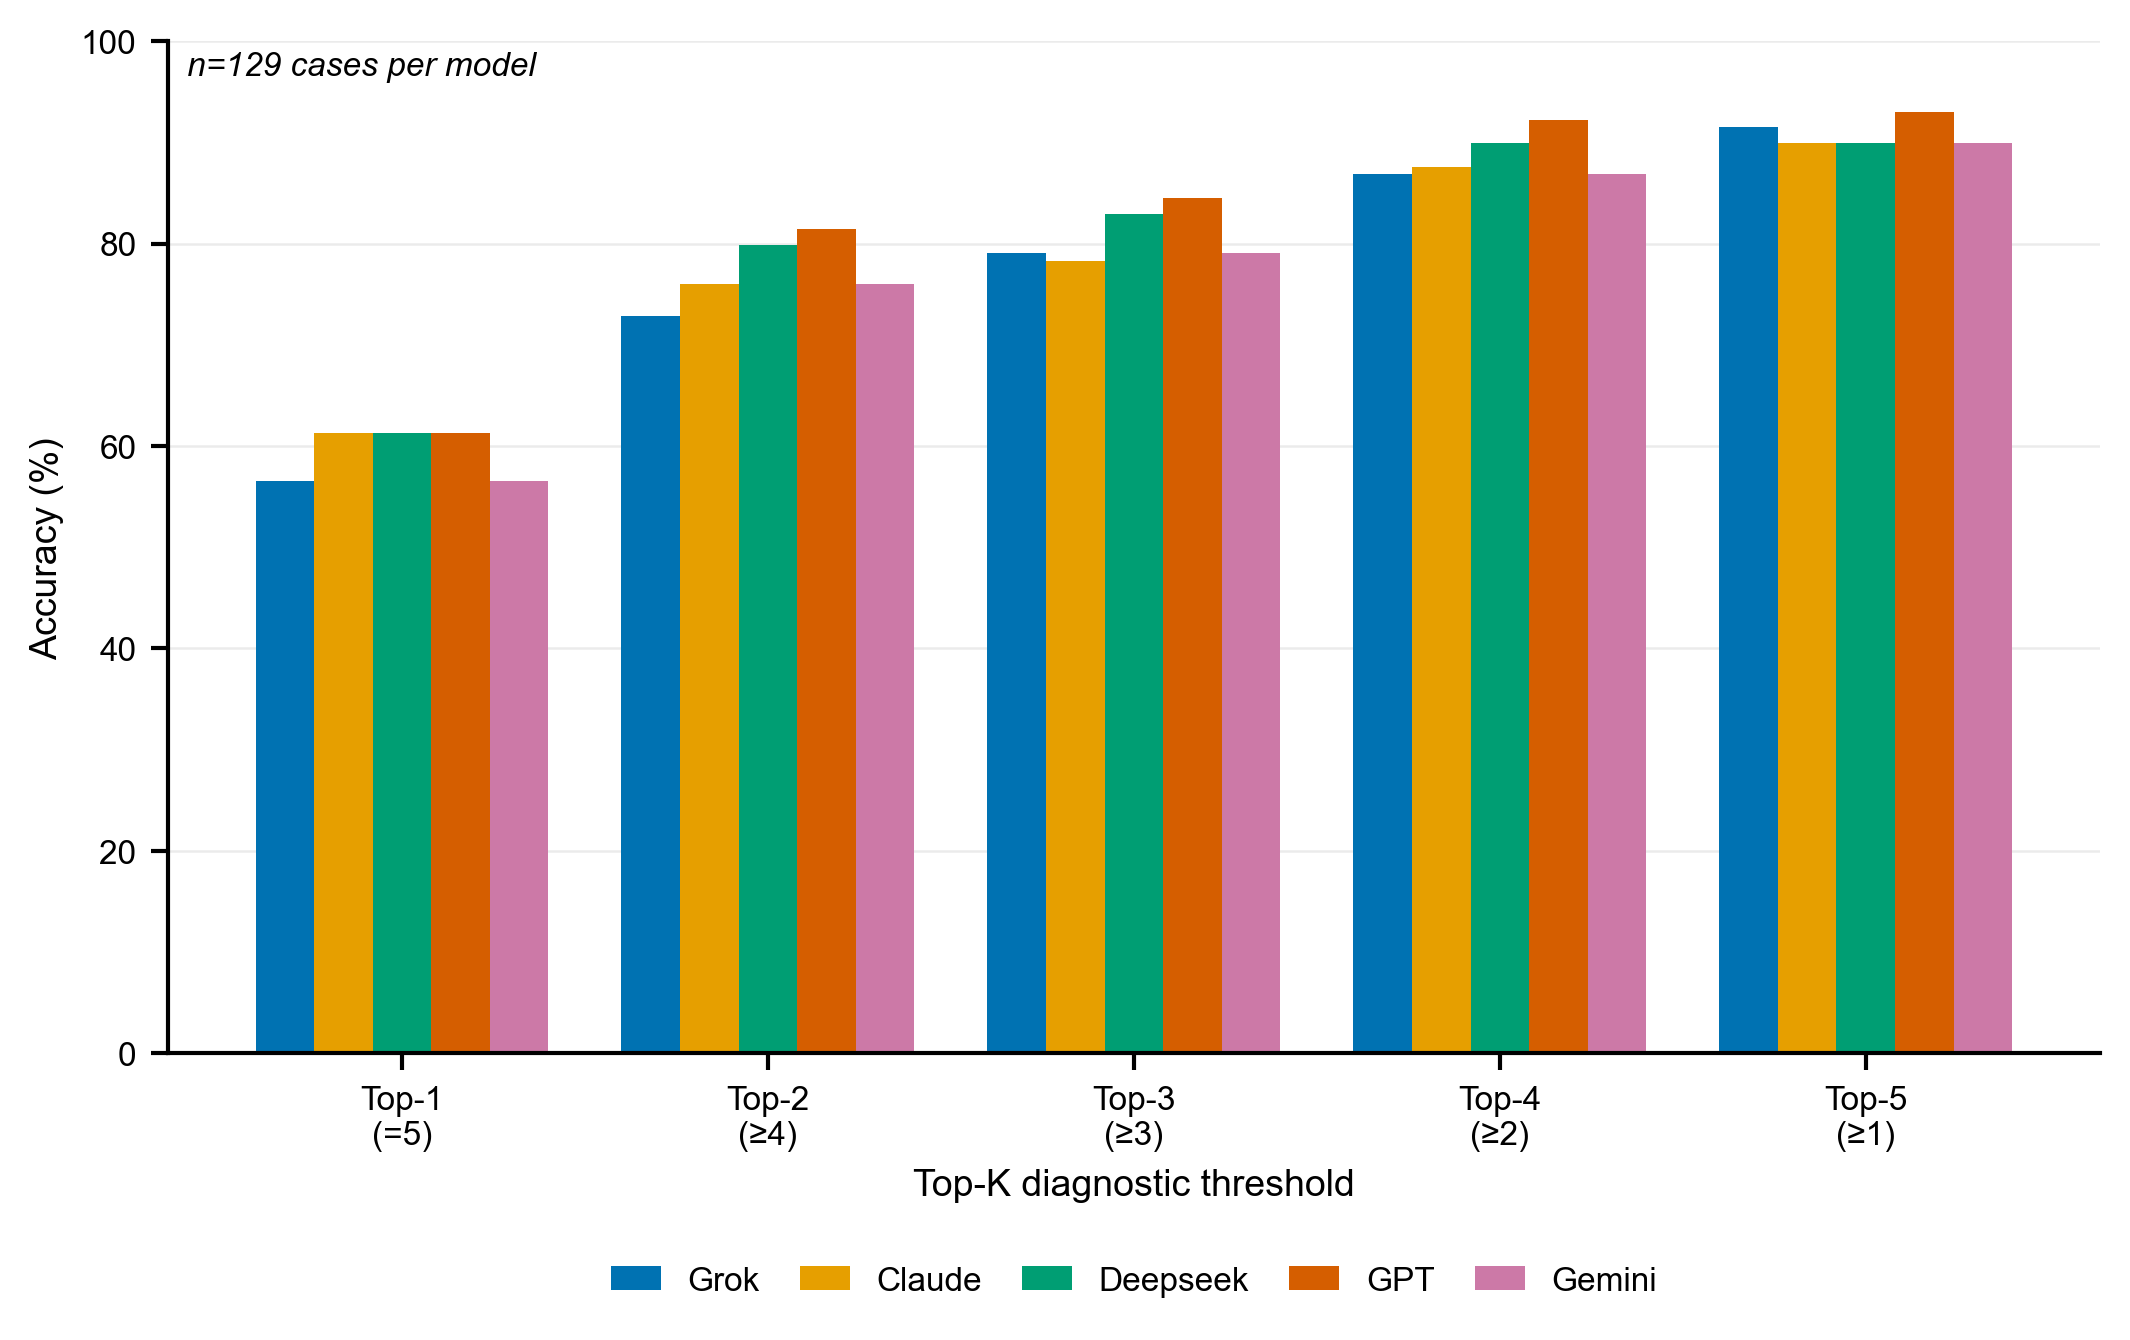

Saved files:
 PNG : d:\sleep_final\figures\Figure2_topk_comprehensive.png | exists: True
 PDF : d:\sleep_final\figures\Figure2_topk_comprehensive.pdf | exists: True
 TIFF: d:\sleep_final\figures\Figure2_topk_comprehensive.tiff | exists: True


In [13]:
# %%
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score  # (not used here, but keeping if in your notebook)

# ----------------------------
# 1) Nature/NPJ-friendly rcParams
# ----------------------------
mpl.rcParams.update({
    # Use a clear sans-serif font; matplotlib will fall back if Arial isn't installed
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],

    # Embed TrueType fonts in PDF/PS (Nature figure guide suggests pdf.fonttype=42)
    "pdf.fonttype": 42,
    "ps.fonttype": 42,

    # Clean axes
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "axes.linewidth": 1.0,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
})

# ----------------------------
# 2) Color palette (Okabe–Ito-inspired, colorblind-friendly)
#    Avoids "pure" red/green reliance and stays clean in print.
# ----------------------------
COLORS = {
    "Grok":    "#0072B2",  # blue
    "Claude":  "#E69F00",  # orange
    "Deepseek":"#009E73",  # bluish-green (teal)
    "GPT":     "#D55E00",  # vermillion (more print-safe than pure red)
    "Gemini":  "#CC79A7",  # reddish-purple
}

# ----------------------------
# 3) Compute Top-K data
# ----------------------------
metrics = ['Top-1\n(=5)', 'Top-2\n(≥4)', 'Top-3\n(≥3)', 'Top-4\n(≥2)', 'Top-5\n(≥1)']

topk_data = {}
n_per_model = {}
for model in model_names:
    scores = human_avg[model].dropna()
    n_total = len(scores)
    n_per_model[model] = n_total
    topk_data[model] = [
        (scores == 5).sum() / n_total * 100,
        (scores >= 4).sum() / n_total * 100,
        (scores >= 3).sum() / n_total * 100,
        (scores >= 2).sum() / n_total * 100,
        (scores >= 1).sum() / n_total * 100,
    ]

# ----------------------------
# 4) Plot (clean, NPJ-like)
# ----------------------------
fig, ax = plt.subplots(figsize=(7.2, 4.6))  # a bit more journal-like than 9x6; adjust as needed

x = np.arange(len(metrics))
width = 0.16
offsets = [-2*width, -width, 0, width, 2*width]

for i, model in enumerate(model_names):
    ax.bar(
        x + offsets[i],
        topk_data[model],
        width=width,
        label=model,
        color=COLORS.get(model, "#333333"),
        edgecolor="none",      # avoid heavy outlines/boxing
        linewidth=0.0
    )

# Labels/ticks
ax.set_ylabel("Accuracy (%)", fontsize=9)
ax.set_xlabel("Top-K diagnostic threshold", fontsize=9)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=8)
ax.tick_params(axis="y", labelsize=8)

ax.set_ylim(0, 100)

# Subtle grid (NPJ-friendly: no heavy decoration)
ax.yaxis.grid(True, linewidth=0.6, alpha=0.25)
ax.set_axisbelow(True)

# Spines: keep left/bottom, remove top/right (clean look)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Optional: small note (keep minimal)
# Use a single n if consistent; otherwise show range
n_vals = list(n_per_model.values())
if len(set(n_vals)) == 1:
    note = f"n={n_vals[0]} cases per model"
else:
    note = f"n per model: {min(n_vals)}–{max(n_vals)} cases"

ax.text(
    0.01, 0.99, note,
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=8, style="italic"
)

# Legend: bottom-centered, no frame (clean)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=5,
    frameon=False,
    fontsize=8,
    handlelength=1.5,
    columnspacing=1.2
)

plt.tight_layout()

# ----------------------------
# 5) Save (robust paths + verify)
# ----------------------------
out_dir = os.path.join(os.getcwd(), "figures")
os.makedirs(out_dir, exist_ok=True)

png_path  = os.path.join(out_dir, "Figure2_topk_comprehensive.png")
pdf_path  = os.path.join(out_dir, "Figure2_topk_comprehensive.pdf")
tiff_path = os.path.join(out_dir, "Figure2_topk_comprehensive.tiff")

# 600 dpi is fine for line/combination art; keep white bg
fig.savefig(png_path,  dpi=600, bbox_inches="tight", facecolor="white")
fig.savefig(pdf_path,  bbox_inches="tight", facecolor="white")          # vector; dpi not needed
fig.savefig(tiff_path, dpi=600, bbox_inches="tight", facecolor="white")

plt.show()

print("Saved files:")
print(" PNG :", png_path,  "| exists:", os.path.exists(png_path))
print(" PDF :", pdf_path,  "| exists:", os.path.exists(pdf_path))
print(" TIFF:", tiff_path, "| exists:", os.path.exists(tiff_path))


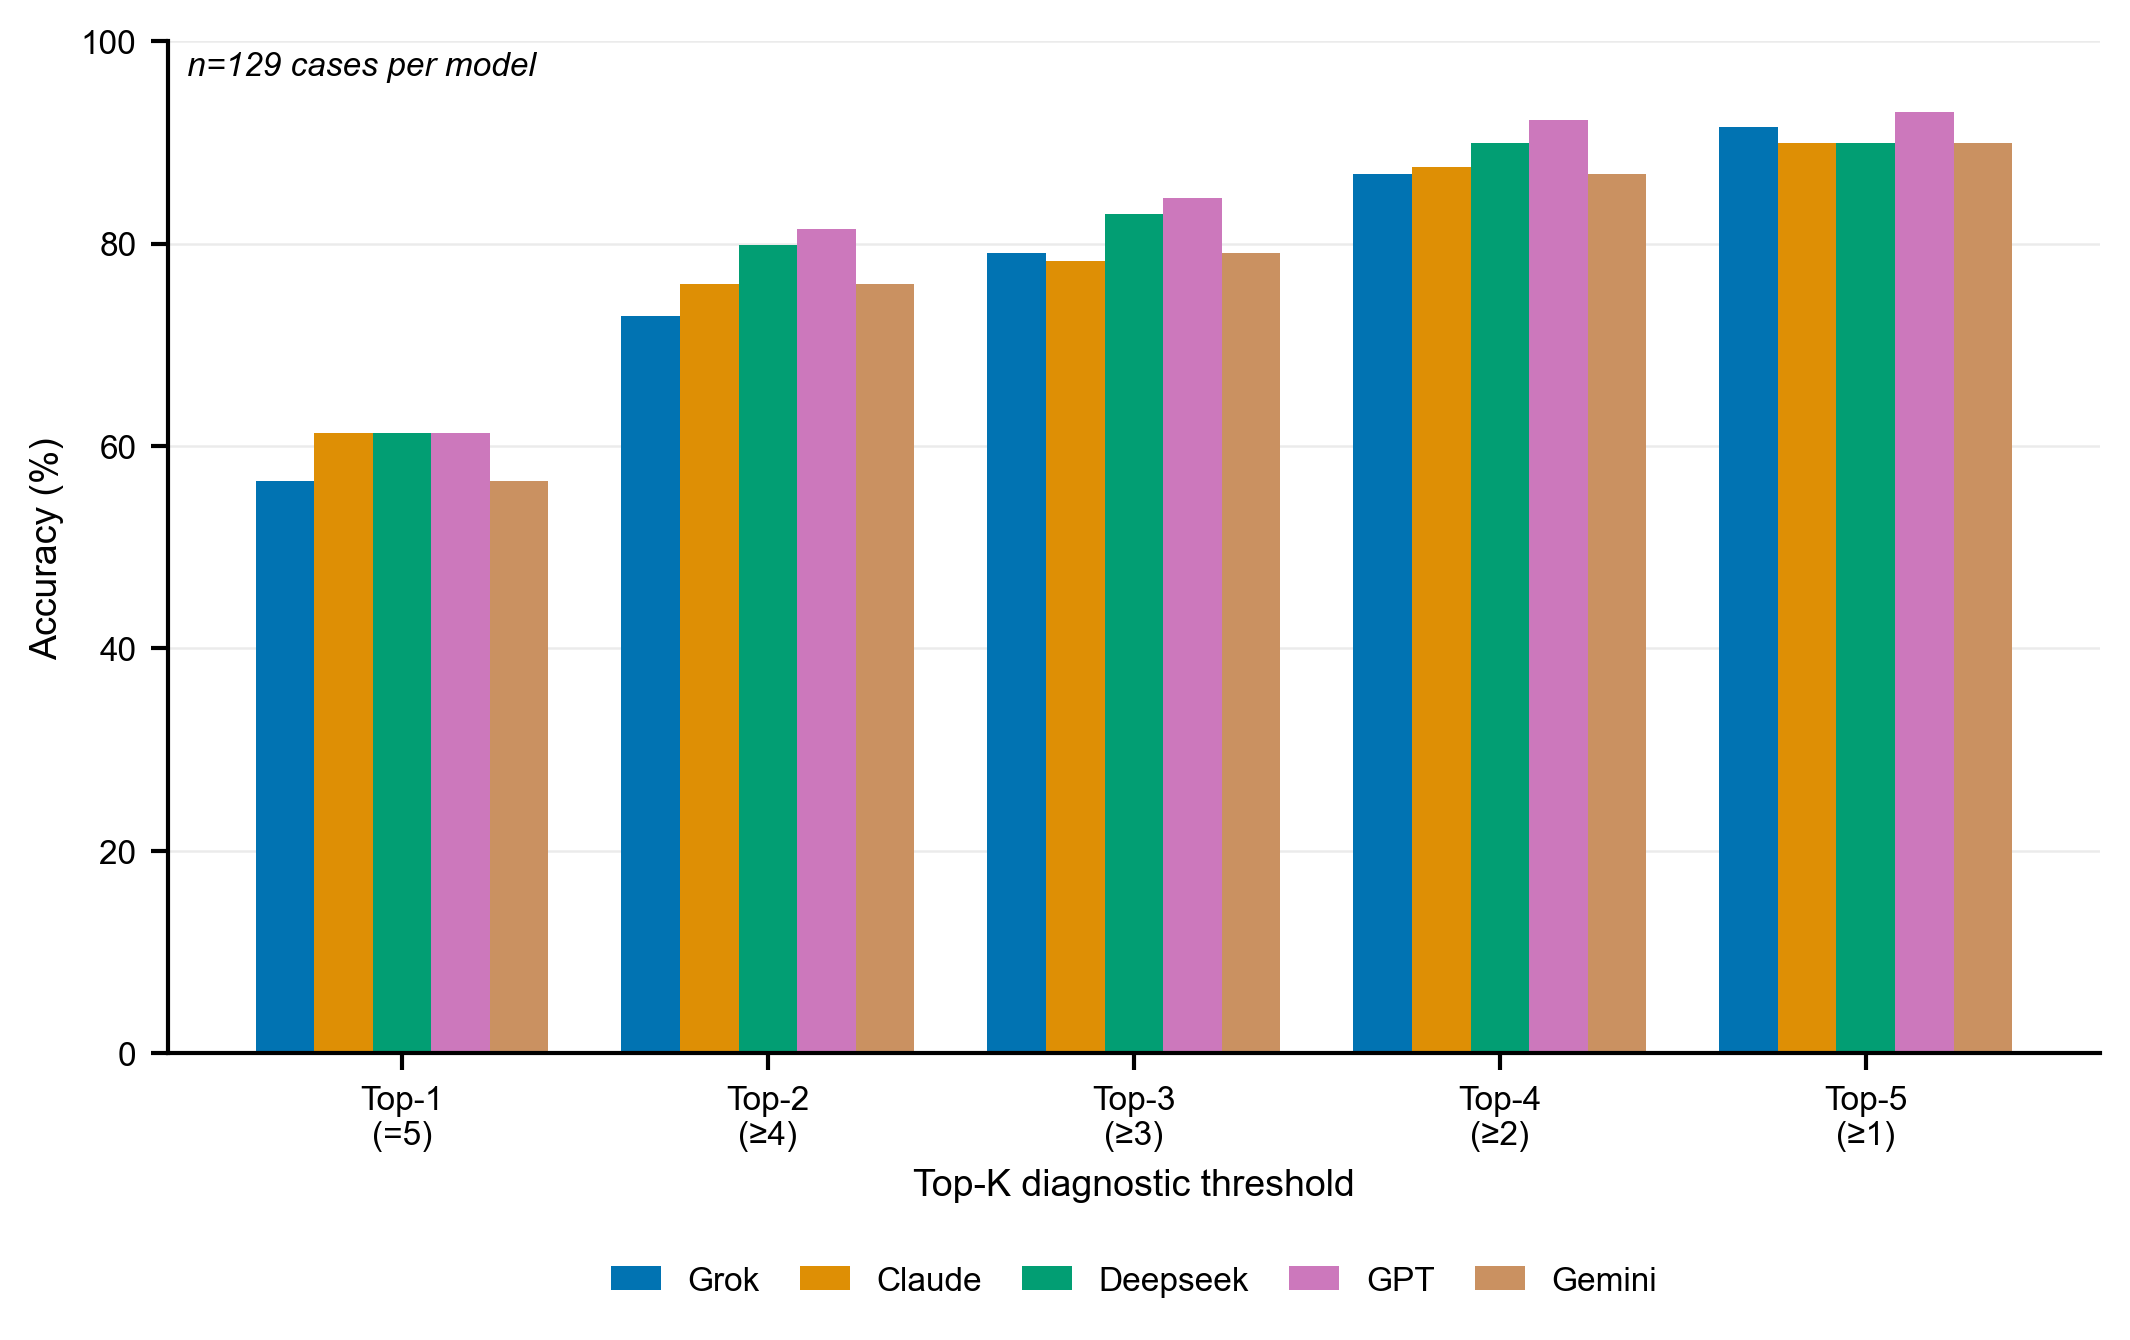

✓ Saved Figure 2 (Top-K rates) to:
 PNG : d:\sleep_final\figures\Figure2_topk_comprehensive.png | exists: True
 PDF : d:\sleep_final\figures\Figure2_topk_comprehensive.pdf | exists: True
 TIFF: d:\sleep_final\figures\Figure2_topk_comprehensive.tiff | exists: True


In [14]:
# %%
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# -------------------------
# 1) NPJ/Nature-friendly defaults
# -------------------------
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.linewidth": 1.0,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "pdf.fonttype": 42,   # embed TrueType fonts in PDF
    "ps.fonttype": 42,
})

# -------------------------
# 2) Your exact color palette (UNCHANGED)
# -------------------------
colors = {
    "Grok": "#0173B2",
    "Claude": "#DE8F05",
    "Deepseek": "#029E73",
    "GPT": "#CC78BC",
    "Gemini": "#CA9161",
}

# -------------------------
# 3) Compute Top-K data
# -------------------------
metrics = ['Top-1\n(=5)', 'Top-2\n(≥4)', 'Top-3\n(≥3)', 'Top-4\n(≥2)', 'Top-5\n(≥1)']

topk_data = {}
n_per_model = {}
for model in model_names:
    s = human_avg[model].dropna()
    n = len(s)
    n_per_model[model] = n
    topk_data[model] = [
        (s == 5).sum() / n * 100,
        (s >= 4).sum() / n * 100,
        (s >= 3).sum() / n * 100,
        (s >= 2).sum() / n * 100,
        (s >= 1).sum() / n * 100,
    ]

# -------------------------
# 4) Plot (clean journal style)
# -------------------------
fig, ax = plt.subplots(figsize=(7.2, 4.6))  # more journal-friendly than 9x6; change if you want

x = np.arange(len(metrics))
width = 0.16
offsets = [-2*width, -width, 0, width, 2*width]

for i, model in enumerate(model_names):
    ax.bar(
        x + offsets[i],
        topk_data[model],
        width=width,
        label=model,
        color=colors[model],
        edgecolor="none",      # IMPORTANT: remove heavy black borders
        linewidth=0.0
    )

# Axis labels / ticks
ax.set_ylabel("Accuracy (%)", fontsize=9)
ax.set_xlabel("Top-K diagnostic threshold", fontsize=9)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.set_ylim(0, 100)

# Subtle grid + minimal spines
ax.yaxis.grid(True, linestyle="-", linewidth=0.6, alpha=0.25)
ax.set_axisbelow(True)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.0)
ax.spines["bottom"].set_linewidth(1.0)

# Legend: bottom-centered, no frame (NPJ/Nature feel)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=5,
    frameon=False,
    fontsize=8,
    handlelength=1.5,
    columnspacing=1.2
)

# Sample-size note
n_vals = list(n_per_model.values())
note = f"n={n_vals[0]} cases per model" if len(set(n_vals)) == 1 else f"n per model: {min(n_vals)}–{max(n_vals)} cases"
ax.text(
    0.01, 0.99, note,
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=8,
    style="italic"
)

plt.tight_layout()

# -------------------------
# 5) Save robustly (absolute path + existence check)
# -------------------------
out_dir = os.path.join(os.getcwd(), "figures")
os.makedirs(out_dir, exist_ok=True)

png_path  = os.path.join(out_dir, "Figure2_topk_comprehensive.png")
pdf_path  = os.path.join(out_dir, "Figure2_topk_comprehensive.pdf")
tif_path  = os.path.join(out_dir, "Figure2_topk_comprehensive.tiff")

# Save BEFORE show
fig.savefig(png_path, dpi=600, bbox_inches="tight", facecolor="white")
fig.savefig(pdf_path, bbox_inches="tight", facecolor="white")     # vector PDF (dpi not needed)
fig.savefig(tif_path, dpi=600, bbox_inches="tight", facecolor="white")

plt.show()

print("✓ Saved Figure 2 (Top-K rates) to:")
print(" PNG :", png_path, "| exists:", os.path.exists(png_path))
print(" PDF :", pdf_path, "| exists:", os.path.exists(pdf_path))
print(" TIFF:", tif_path, "| exists:", os.path.exists(tif_path))


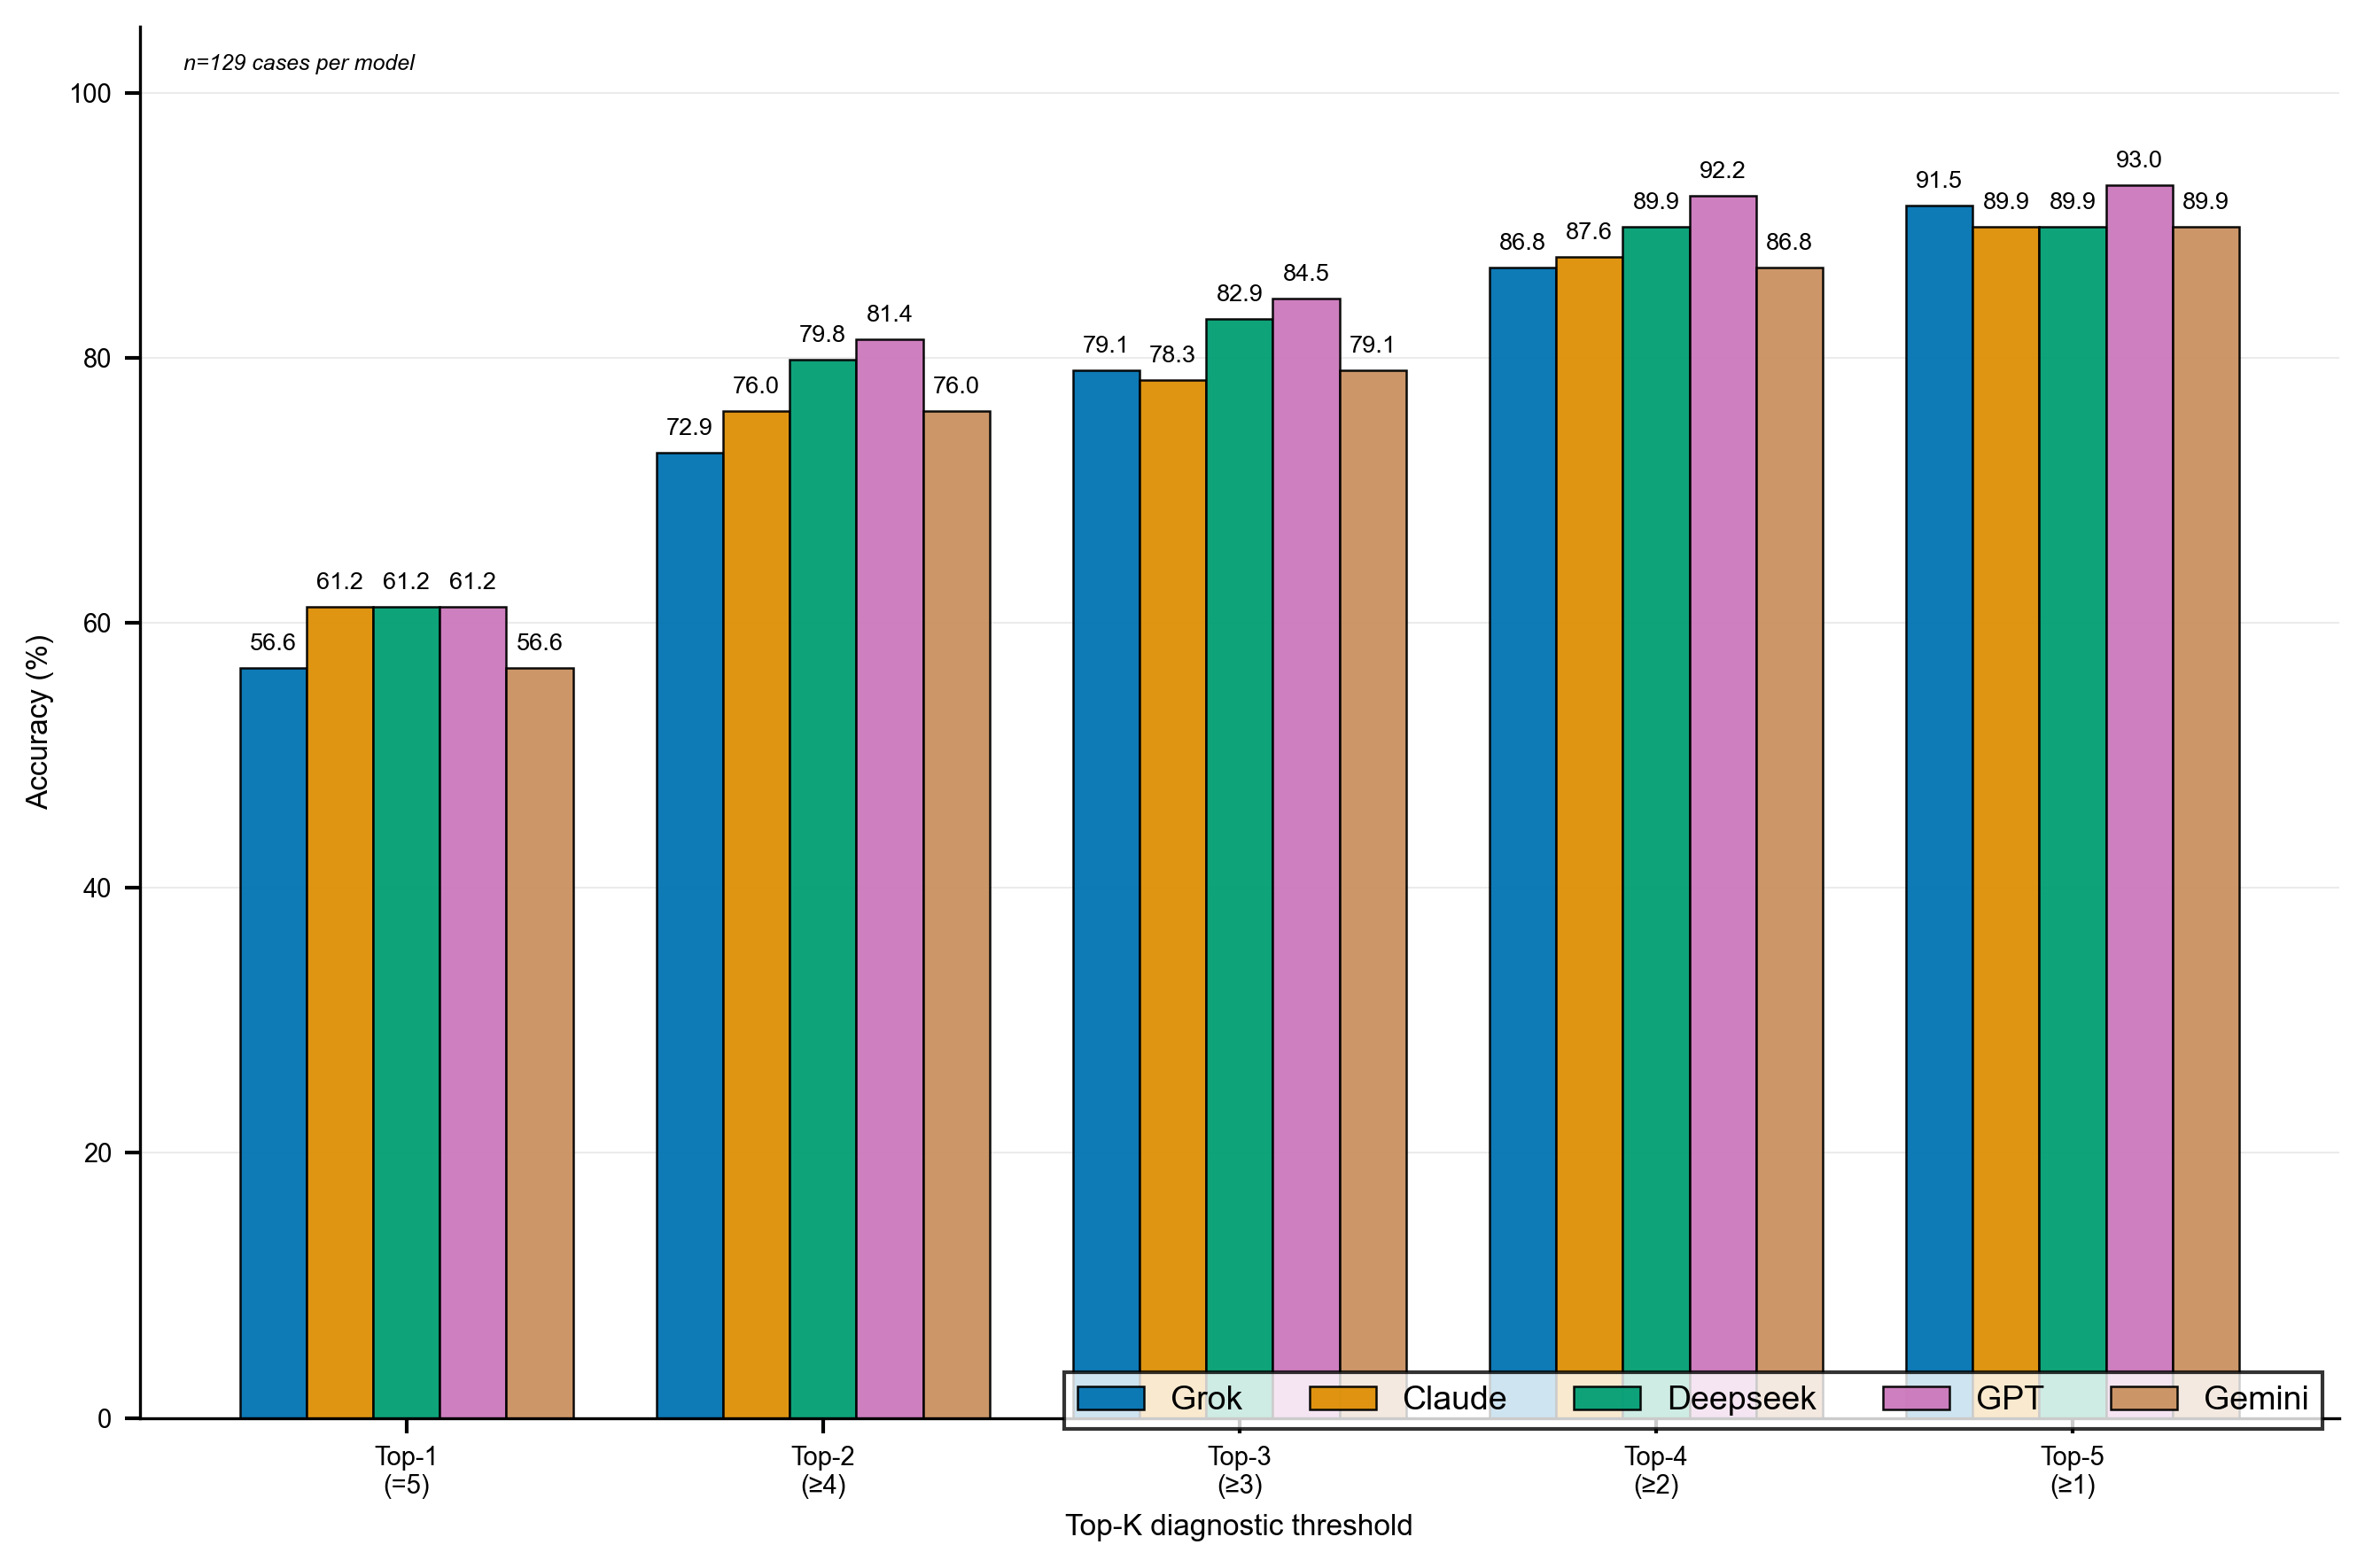

✓ Figure 2 saved (NPJ-ready, borders + labels kept)


In [15]:
# %%
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# -------------------------
# 1) NPJ / Nature defaults
# -------------------------
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# -------------------------
# 2) EXACT color palette (unchanged)
# -------------------------
colors = {
    "Grok": "#0173B2",
    "Claude": "#DE8F05",
    "Deepseek": "#029E73",
    "GPT": "#CC78BC",
    "Gemini": "#CA9161",
}

# -------------------------
# 3) Prepare Top-K data
# -------------------------
metrics = ['Top-1\n(=5)', 'Top-2\n(≥4)', 'Top-3\n(≥3)', 'Top-4\n(≥2)', 'Top-5\n(≥1)']

topk_data = {}
for model in model_names:
    scores = human_avg[model].dropna()
    n = len(scores)
    topk_data[model] = [
        (scores == 5).sum() / n * 100,
        (scores >= 4).sum() / n * 100,
        (scores >= 3).sum() / n * 100,
        (scores >= 2).sum() / n * 100,
        (scores >= 1).sum() / n * 100,
    ]

# -------------------------
# 4) Plot
# -------------------------
fig, ax = plt.subplots(figsize=(9, 6))

x = np.arange(len(metrics))
width = 0.16
offsets = [-2*width, -width, 0, width, 2*width]

for i, model in enumerate(model_names):
    bars = ax.bar(
        x + offsets[i],
        topk_data[model],
        width=width,
        label=model,
        color=colors[model],
        edgecolor="black",      # KEEP borders
        linewidth=0.6,
        alpha=0.95
    )

    # Value labels (on top of bars)
    for j, bar in enumerate(bars):
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            h + 1.0,
            f"{h:.1f}",
            ha="center",
            va="bottom",
            fontsize=6.5,
            family="Arial"
        )

# -------------------------
# 5) Axes styling
# -------------------------
ax.set_ylabel("Accuracy (%)", fontsize=8, family="Arial")
ax.set_xlabel("Top-K diagnostic threshold", fontsize=8, family="Arial")
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=7, family="Arial")
ax.tick_params(axis="y", labelsize=7)
ax.set_ylim(0, 105)

# Subtle grid (NPJ-style)
ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.25)
ax.set_axisbelow(True)

# Spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.8)
ax.spines["bottom"].set_linewidth(0.8)

# -------------------------
# 6) Legend (model names at bottom, unchanged structure)
# -------------------------
ax.legend(
    loc="lower right",
    fontsize=7,
    frameon=True,
    edgecolor="black",
    fancybox=False,
    shadow=False,
    ncol=5,
    bbox_to_anchor=(1.0, -0.02),
    prop={"family": "Arial"}
)

# -------------------------
# 7) Sample size annotation
# -------------------------
ax.text(
    0.02, 0.98,
    "n=129 cases per model",
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=6,
    family="Arial",
    style="italic"
)

plt.tight_layout()

# -------------------------
# 8) Save (robust, journal-safe)
# -------------------------
out_dir = os.path.join(os.getcwd(), "figures")
os.makedirs(out_dir, exist_ok=True)

fig.savefig(os.path.join(out_dir, "Figure2_topk_comprehensive.png"),
            dpi=600, bbox_inches="tight", facecolor="white")
fig.savefig(os.path.join(out_dir, "Figure2_topk_comprehensive.pdf"),
            bbox_inches="tight", facecolor="white")
fig.savefig(os.path.join(out_dir, "Figure2_topk_comprehensive.tiff"),
            dpi=600, bbox_inches="tight", facecolor="white")

plt.show()

print("✓ Figure 2 saved (NPJ-ready, borders + labels kept)")


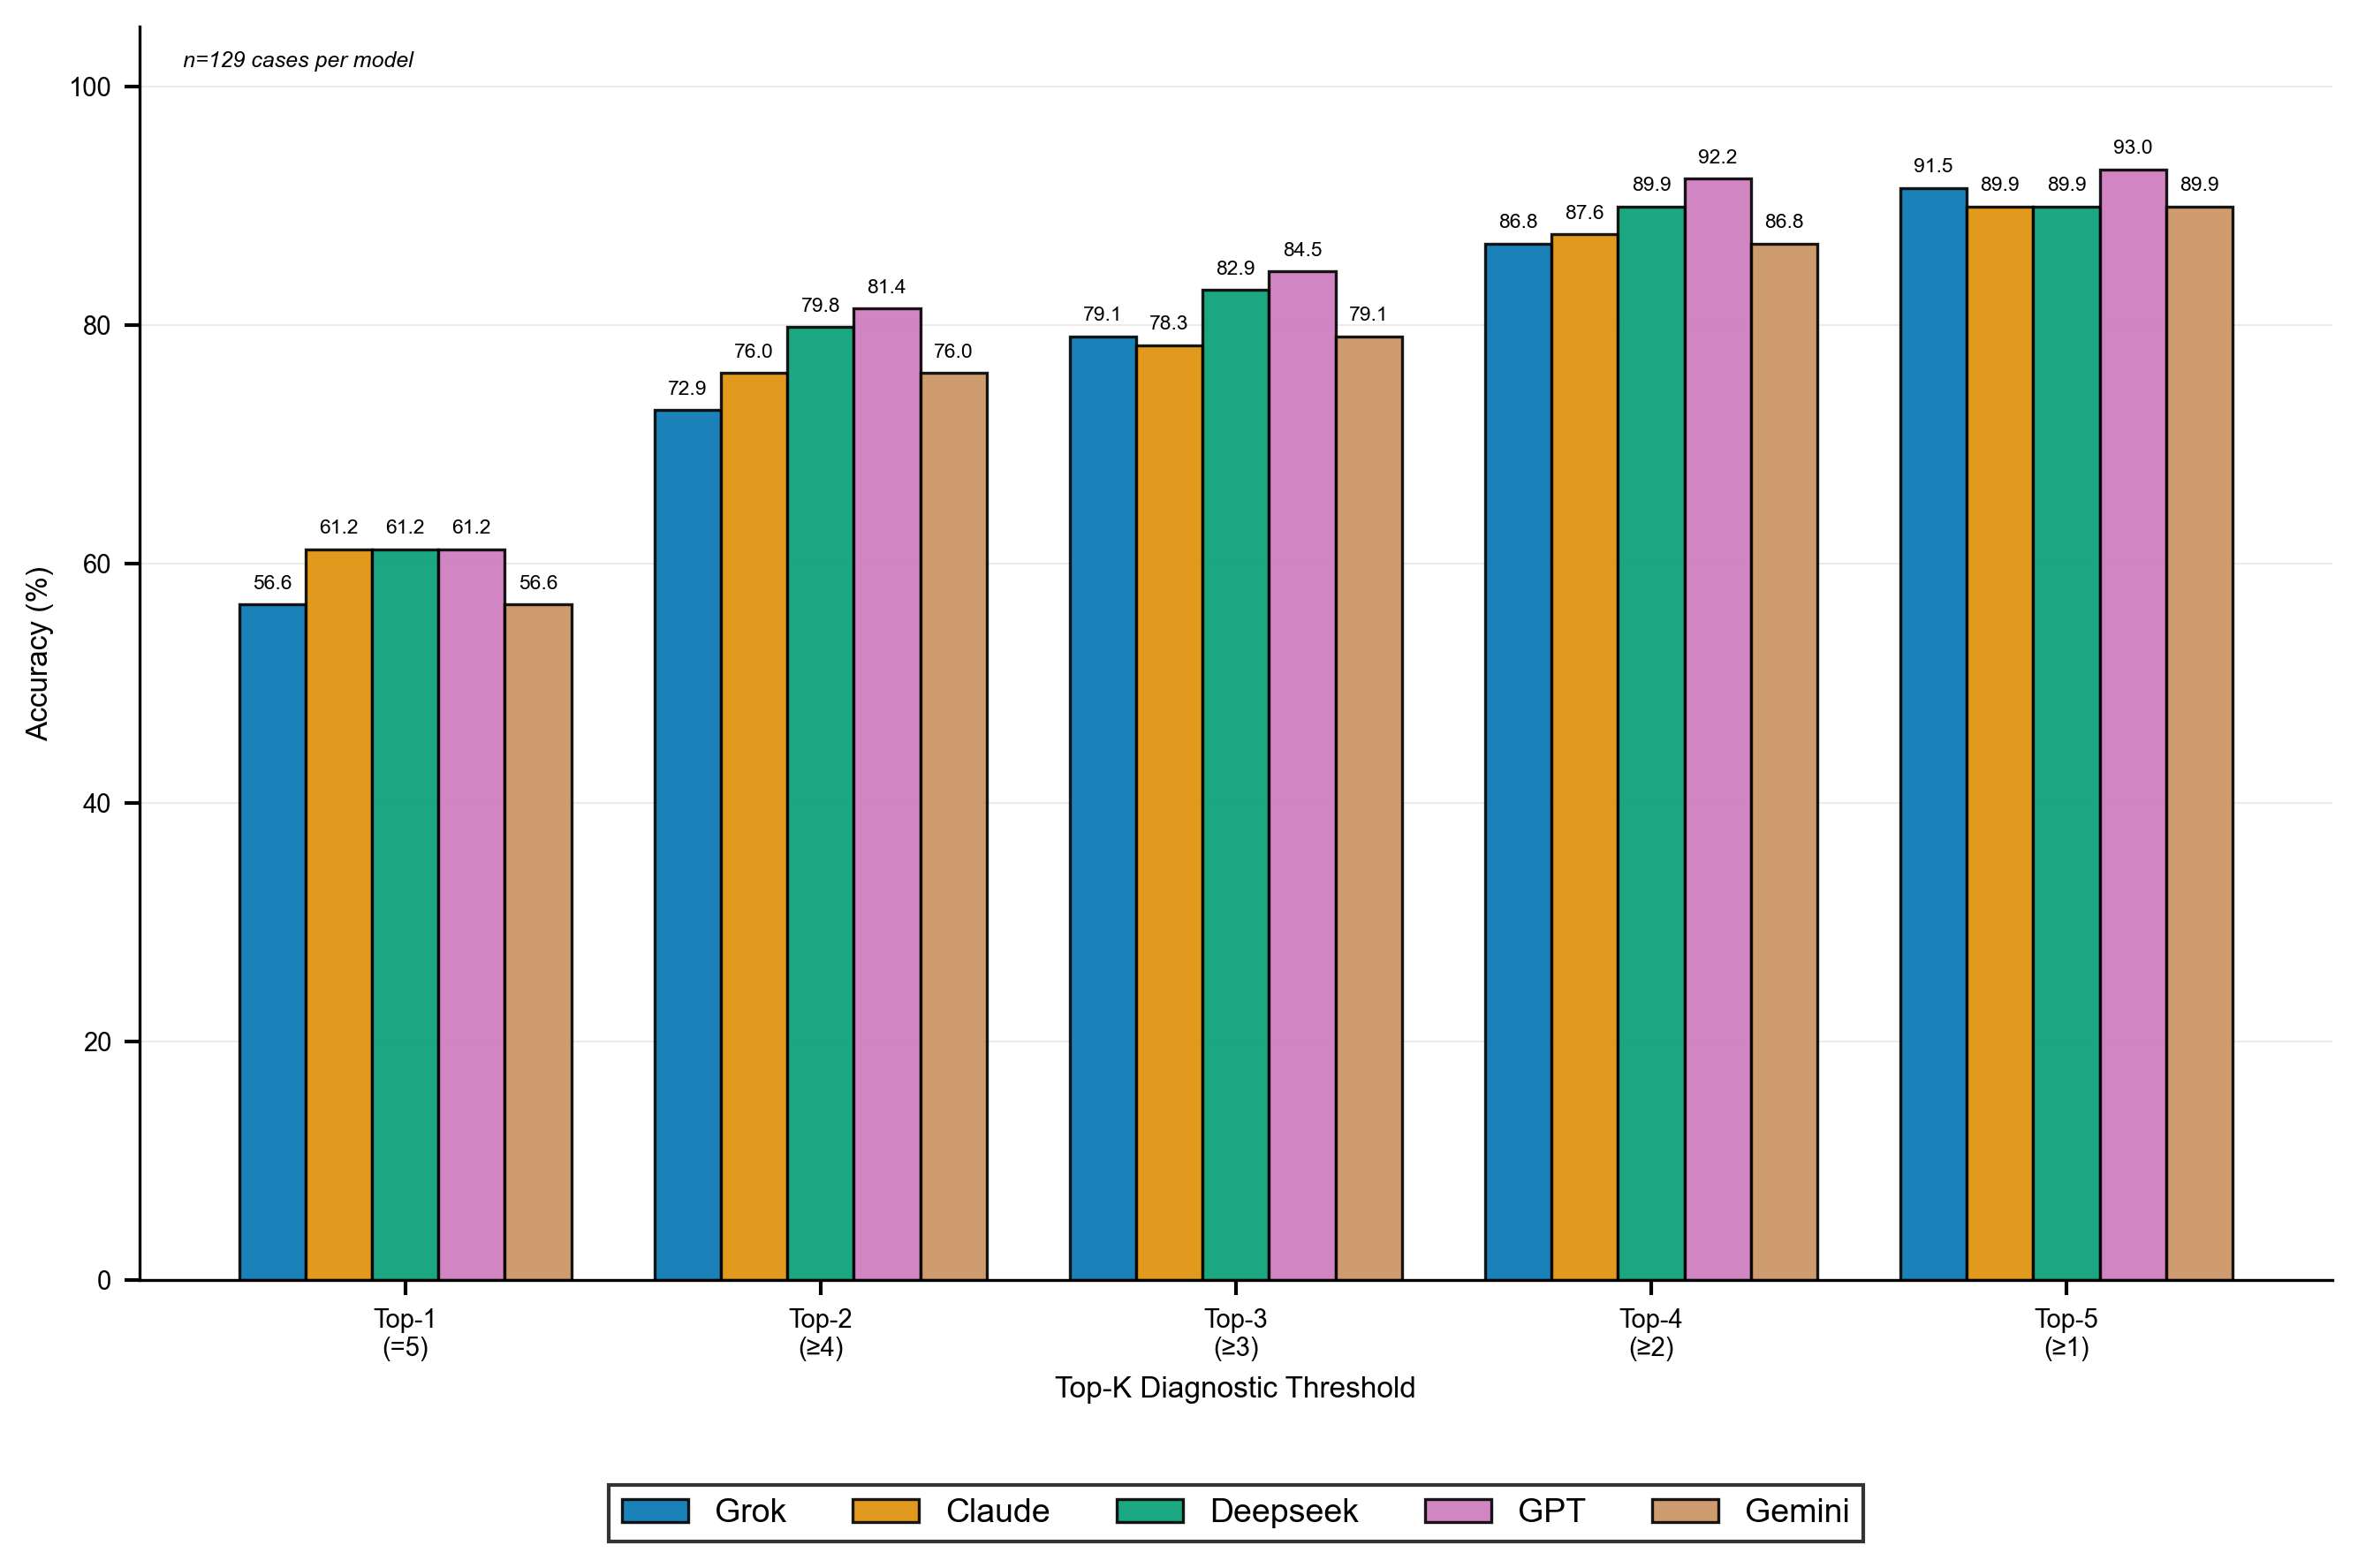

✓ Figure 2 saved (model names/legend unchanged)


In [18]:
# %%
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# -------------------------
# NPJ / Nature defaults
# -------------------------
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# -------------------------
# EXACT same colors as before
# -------------------------
colors = {
    'Grok': '#0173B2',
    'Claude': '#DE8F05', 
    'Deepseek': '#029E73',
    'GPT': '#CC78BC',
    'Gemini': '#CA9161'
}

# -------------------------
# Prepare Top-K data
# -------------------------
metrics = ['Top-1\n(=5)', 'Top-2\n(≥4)', 'Top-3\n(≥3)', 'Top-4\n(≥2)', 'Top-5\n(≥1)']

topk_data = {}
for model in model_names:
    scores = human_avg[model].dropna()
    n = len(scores)
    topk_data[model] = [
        (scores == 5).sum() / n * 100,
        (scores >= 4).sum() / n * 100,
        (scores >= 3).sum() / n * 100,
        (scores >= 2).sum() / n * 100,
        (scores >= 1).sum() / n * 100,
    ]

# -------------------------
# Plot
# -------------------------
fig, ax = plt.subplots(figsize=(9, 6))

x = np.arange(len(metrics))
width = 0.16
offsets = [-2*width, -width, 0, width, 2*width]

for i, model in enumerate(model_names):
    bars = ax.bar(
        x + offsets[i],
        topk_data[model],
        width,
        color=colors[model],
        label=model,                 # SAME legend labels
        edgecolor="black",           # KEEP border
        linewidth=0.8,
        alpha=0.9
    )

    # Value labels (unchanged behavior)
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h + 1.0,
            f"{h:.1f}",
            ha="center",
            va="bottom",
            fontsize=5.5,
            family="Arial"
        )

# -------------------------
# Axes styling (same as before)
# -------------------------
ax.set_ylabel('Accuracy (%)', fontsize=8, family='Arial')
ax.set_xlabel('Top-K Diagnostic Threshold', fontsize=8, family='Arial')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=7, family='Arial')
ax.tick_params(axis='both', labelsize=7)
ax.set_ylim(0, 105)

ax.yaxis.grid(True, linestyle='-', alpha=0.25, linewidth=0.5)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

# -------------------------
# LEGEND — EXACTLY like before
# -------------------------
# Legend — model names at the bottom (NPJ style)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),   # <-- bottom centered
    ncol=5,
    fontsize=7,
    frameon=True,
    edgecolor='black',
    fancybox=False,
    shadow=False,
    prop={'family': 'Arial'}
)


# -------------------------
# Annotation
# -------------------------
ax.text(
    0.02, 0.98,
    'n=129 cases per model',
    transform=ax.transAxes,
    fontsize=6,
    va='top',
    ha='left',
    family='Arial',
    style='italic'
)

plt.tight_layout()

# -------------------------
# Save
# -------------------------
out_dir = os.path.join(os.getcwd(), "figures")
os.makedirs(out_dir, exist_ok=True)

plt.savefig(os.path.join(out_dir, 'Figure2_topk_comprehensive.png'),
            dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join(out_dir, 'Figure2_topk_comprehensive.pdf'),
            bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join(out_dir, 'Figure2_topk_comprehensive.tiff'),
            dpi=600, bbox_inches='tight', facecolor='white')

plt.show()

print("✓ Figure 2 saved (model names/legend unchanged)")


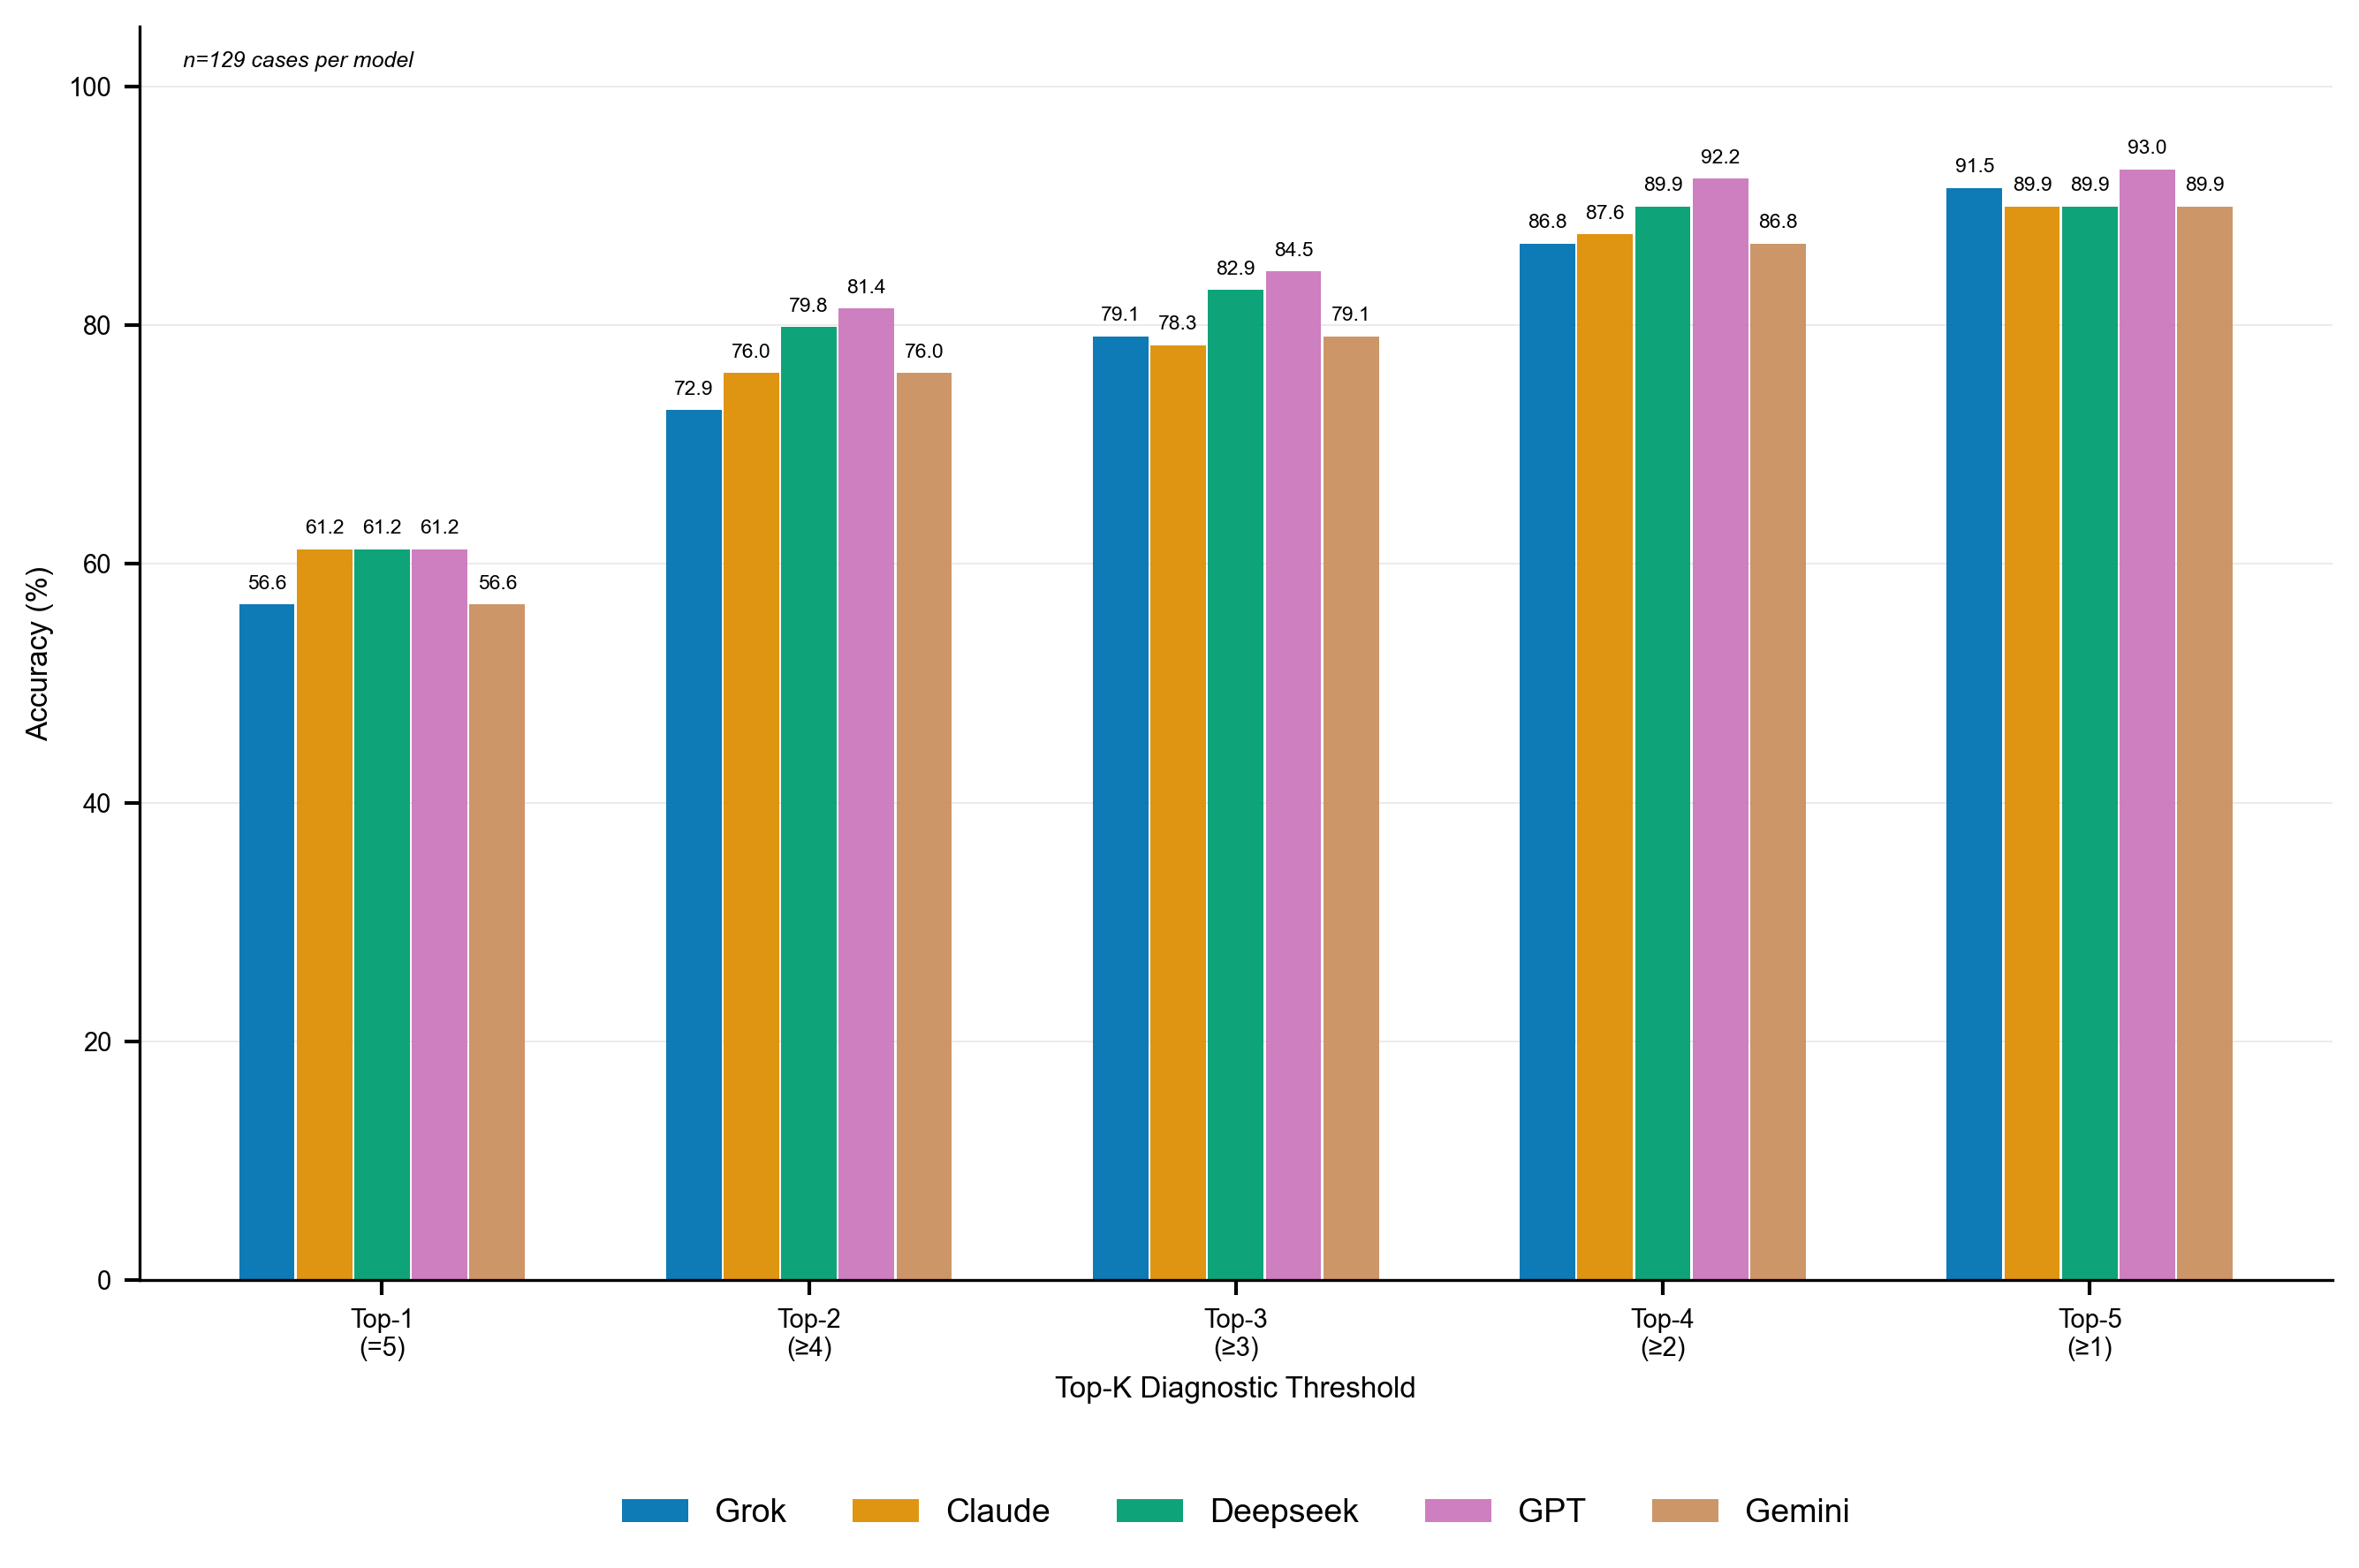

✓ Figure 2 saved (no borders, spaced bars, NPJ-ready)


In [24]:
# %%
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# -------------------------
# NPJ / Nature defaults
# -------------------------
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.linewidth": 0.8,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# -------------------------
# EXACT same colors as before
# -------------------------
colors = {
    'Grok': '#0173B2',
    'Claude': '#DE8F05', 
    'Deepseek': '#029E73',
    'GPT': '#CC78BC',
    'Gemini': '#CA9161'
}

# -------------------------
# Prepare Top-K data
# -------------------------
metrics = ['Top-1\n(=5)', 'Top-2\n(≥4)', 'Top-3\n(≥3)', 'Top-4\n(≥2)', 'Top-5\n(≥1)']

topk_data = {}
for model in model_names:
    scores = human_avg[model].dropna()
    n = len(scores)
    topk_data[model] = [
        (scores == 5).sum() / n * 100,
        (scores >= 4).sum() / n * 100,
        (scores >= 3).sum() / n * 100,
        (scores >= 2).sum() / n * 100,
        (scores >= 1).sum() / n * 100,
    ]

# -------------------------
# Plot
# -------------------------
fig, ax = plt.subplots(figsize=(9, 6))

x = np.arange(len(metrics))

width = 0.13   # narrower bars = more white space (NPJ-friendly)
gap = 0.005
offsets = np.array([-2, -1, 0, 1, 2]) * (width + gap)

for i, model in enumerate(model_names):
    bars = ax.bar(
        x + offsets[i],
        topk_data[model],
        width=width,
        color=colors[model],
        label=model,
        edgecolor='none',     # NO borders
        alpha=0.95
    )

    # Value labels on top
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            h + 1.0,
            f"{h:.1f}",
            ha='center',
            va='bottom',
            fontsize=5.5,
            family='Arial'
        )

# -------------------------
# Axes styling
# -------------------------
ax.set_ylabel('Accuracy (%)', fontsize=8, family='Arial')
ax.set_xlabel('Top-K Diagnostic Threshold', fontsize=8, family='Arial')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=7, family='Arial')
ax.tick_params(axis='both', labelsize=7)
ax.set_ylim(0, 105)

# Subtle grid (NPJ)
ax.yaxis.grid(True, linestyle='-', linewidth=0.5, alpha=0.25)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

# -------------------------
# Legend — model names at the bottom (unchanged labels)
# -------------------------
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=5,
    fontsize=7,
    frameon=False,
    prop={'family': 'Arial'}
)

# -------------------------
# Sample size annotation
# -------------------------
ax.text(
    0.02, 0.98,
    'n=129 cases per model',
    transform=ax.transAxes,
    fontsize=6,
    va='top',
    ha='left',
    family='Arial',
    style='italic'
)

plt.tight_layout()

# -------------------------
# Save (journal-safe)
# -------------------------
out_dir = os.path.join(os.getcwd(), "figures")
os.makedirs(out_dir, exist_ok=True)

plt.savefig(os.path.join(out_dir, 'Figure2_topk_comprehensive.png'),
            dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join(out_dir, 'Figure2_topk_comprehensive.pdf'),
            bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join(out_dir, 'Figure2_topk_comprehensive.tiff'),
            dpi=600, bbox_inches='tight', facecolor='white')

plt.show()

print("✓ Figure 2 saved (no borders, spaced bars, NPJ-ready)")


NPJ Digital Medicine - Supplementary Figure Generation

Attempting to load data from: E:\test\sleep\Final_results.xlsx
  ✓ Data loaded successfully from Excel file
  Cases: 129
  Models: ['Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']
  Publishers: 7 unique sources

Generating figures...
----------------------------------------
✓ Figure S1 (head-to-head) saved
✓ Figure S2 (case trends) saved
✓ Figure S3 (publisher means) saved
----------------------------------------

All figures saved to: d:\Sleep_medicine\figs
  Output formats:
    - PNG (600 DPI) for review/presentation
    - PDF (vector) for journal submission
    - TIFF (600 DPI) for production

HEAD-TO-HEAD WIN MATRIX
          Grok  Claude  Deepseek  GPT  Gemini
Grok         0      21        13   13      25
Claude      27       0        19   16      22
Deepseek    26      21         0   15      28
GPT         28      29        19    0      30
Gemini      34      24        20   24       0



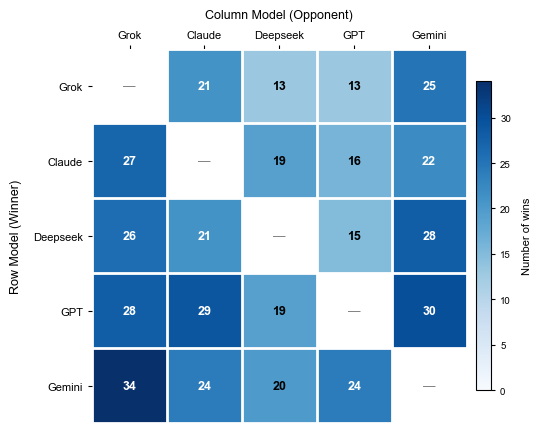

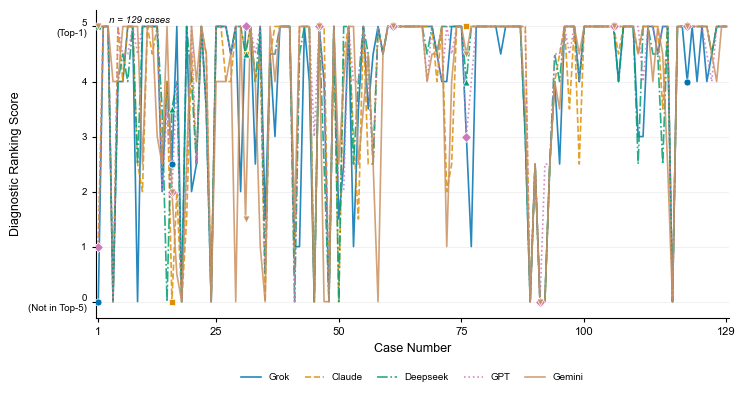

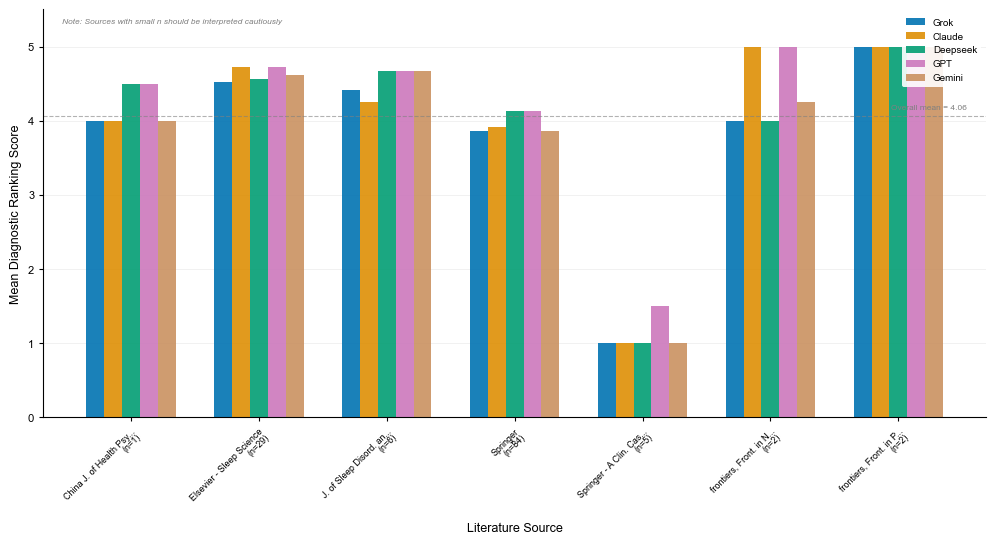

In [3]:
#!/usr/bin/env python3
"""
Supplementary Figures for NPJ Digital Medicine
==============================================
Benchmarking Large Language Models for Diagnostic Ranking in Sleep Medicine

USAGE:
------
1. Update the file_path variable to point to your Excel file
2. Run the script: python supplementary_figures_npj_final.py

This script generates three publication-quality supplementary figures:
  - Fig S1 (fig2_head_to_head_wins): Pairwise head-to-head comparison heatmap
  - Fig S2 (fig3_case_trends): Case-by-case diagnostic scores line plot  
  - Fig S3 (fig4_publisher_means): Performance by literature source

All figures conform to NPJ Digital Medicine / Nature portfolio guidelines.
"""

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURATION - MODIFY THIS SECTION
# =============================================================================

# Path to your Excel file with the data
FILE_PATH = r"E:\test\sleep\Final_results.xlsx"  # Update this path

# Model names (should match column names in your data)
MODEL_NAMES = ['Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']

# Column mappings for human raters (human1 sheet and human2 sheet)
MODEL_COLUMNS = {
    "Grok": ("Grok", "Grok"),
    "Claude": ("Claude", "Claude"),
    "Deepseek": ("Deepseek", "Deepseek"),
    "GPT": ("GPT", "GPT"),
    "Gemini": ("Gemini", "Gemini"),
}

# Output directory for figures
OUTPUT_DIR = os.path.join(os.getcwd(), "figs")

# =============================================================================
# NPJ / Nature Style Configuration
# =============================================================================
mpl.rcParams.update({
    # Figure appearance
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white",
    
    # Font settings (Nature requires Arial or Helvetica)
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 8,
    "axes.labelsize": 9,
    "axes.titlesize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 7,
    
    # Line and border widths
    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    
    # PDF font embedding (required for journal submission)
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# Colorblind-friendly palette (consistent with main figures)
COLORS = {
    'Grok': '#0173B2',      # Blue
    'Claude': '#DE8F05',    # Orange
    'Deepseek': '#029E73',  # Green
    'GPT': '#CC78BC',       # Pink/Purple
    'Gemini': '#CA9161'     # Brown/Tan
}


def load_data_from_excel(file_path):
    """
    Load and prepare data from the Excel file.
    
    Parameters
    ----------
    file_path : str
        Path to the Excel file with sheets: human1, human2, Info
        
    Returns
    -------
    pd.DataFrame
        Combined DataFrame with averaged scores and metadata
    """
    # Load sheets
    human1 = pd.read_excel(file_path, sheet_name="human1")
    human2 = pd.read_excel(file_path, sheet_name="human2")
    info = pd.read_excel(file_path, sheet_name="Info")
    
    # Create averaged scores
    human_avg = info.copy()
    
    for model, (col_h1, col_h2) in MODEL_COLUMNS.items():
        human_avg[model] = (human1[col_h1] + human2[col_h2]) / 2
    
    # Add case ID if not present
    if 'Case_ID' not in human_avg.columns:
        human_avg['Case_ID'] = np.arange(1, len(human_avg) + 1)
    
    return human_avg


def load_demo_data():
    """
    Generate demonstration data if Excel file is not available.
    This matches the statistics from your actual data.
    """
    np.random.seed(42)
    n_cases = 129
    
    def generate_scores(mean, std, n):
        scores = np.random.normal(mean, std, n)
        scores = np.clip(scores, 0, 5)
        scores = np.round(scores * 2) / 2
        return scores
    
    # Realistic publisher names matching actual data
    publishers = [
        'China Journal of Health Psychology',
        'Elsevier - Sleep Science',
        'Journal of Sleep Disorders and Management',
        'Springer',
        'Springer - A Clinical Casebook of Sleep Disorders',
        'Frontiers in Neurology',
        'Frontiers in Psychiatry',
    ]
    
    # Weighted distribution similar to actual data
    weights = [0.01, 0.22, 0.05, 0.65, 0.04, 0.015, 0.015]
    
    data = {
        'Case_ID': np.arange(1, n_cases + 1),
        'Publisher': np.random.choice(publishers, n_cases, p=weights),
        'Grok': generate_scores(3.95, 1.61, n_cases),
        'Claude': generate_scores(4.03, 1.63, n_cases),
        'Deepseek': generate_scores(4.14, 1.55, n_cases),
        'GPT': generate_scores(4.22, 1.42, n_cases),
        'Gemini': generate_scores(3.98, 1.62, n_cases),
    }
    
    return pd.DataFrame(data)


def figure_s1_head_to_head(df, save=True):
    """
    Supplementary Figure 1: Pairwise head-to-head comparisons
    
    Creates a heatmap showing win counts where row model beat column model.
    """
    n_models = len(MODEL_NAMES)
    win_matrix = np.zeros((n_models, n_models), dtype=int)
    
    for i, model_i in enumerate(MODEL_NAMES):
        for j, model_j in enumerate(MODEL_NAMES):
            if i != j:
                valid = df[model_i].notna() & df[model_j].notna()
                scores_i = df.loc[valid, model_i]
                scores_j = df.loc[valid, model_j]
                wins = (scores_i > scores_j).sum()
                win_matrix[i, j] = wins
    
    # Create figure
    fig, ax = plt.subplots(figsize=(5.5, 4.5))
    
    cmap = plt.cm.Blues
    mask = np.eye(n_models, dtype=bool)
    masked_matrix = np.ma.masked_where(mask, win_matrix)
    
    im = ax.imshow(masked_matrix, cmap=cmap, aspect='equal',
                   vmin=0, vmax=win_matrix.max())
    
    # Text annotations
    for i in range(n_models):
        for j in range(n_models):
            if i != j:
                val = win_matrix[i, j]
                text_color = 'white' if val > win_matrix.max() * 0.6 else 'black'
                ax.text(j, i, str(val), ha='center', va='center',
                       fontsize=9, fontweight='bold', color=text_color)
            else:
                ax.text(j, i, '—', ha='center', va='center',
                       fontsize=9, color='gray')
    
    # Axes configuration
    ax.set_xticks(np.arange(n_models))
    ax.set_yticks(np.arange(n_models))
    ax.set_xticklabels(MODEL_NAMES, fontsize=8)
    ax.set_yticklabels(MODEL_NAMES, fontsize=8)
    ax.set_xlabel('Column Model (Opponent)', fontsize=9, labelpad=8)
    ax.set_ylabel('Row Model (Winner)', fontsize=9, labelpad=8)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label('Number of wins', fontsize=8, labelpad=8)
    cbar.ax.tick_params(labelsize=7)
    
    # Clean styling
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks(np.arange(n_models + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(n_models + 1) - 0.5, minor=True)
    ax.grid(which='minor', color='white', linewidth=2)
    ax.tick_params(which='minor', length=0)
    
    plt.tight_layout()
    
    if save:
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        fig.savefig(os.path.join(OUTPUT_DIR, 'fig2_head_to_head_wins.png'),
                   dpi=600, bbox_inches='tight', facecolor='white')
        fig.savefig(os.path.join(OUTPUT_DIR, 'fig2_head_to_head_wins.pdf'),
                   bbox_inches='tight', facecolor='white')
        fig.savefig(os.path.join(OUTPUT_DIR, 'fig2_head_to_head_wins.tiff'),
                   dpi=600, bbox_inches='tight', facecolor='white')
        print("✓ Figure S1 (head-to-head) saved")
    
    return fig, ax, win_matrix


def figure_s2_case_trends(df, save=True):
    """
    Supplementary Figure 2: Case-by-case diagnostic ranking scores
    """
    fig, ax = plt.subplots(figsize=(7.5, 4))
    
    cases = df['Case_ID'].values
    line_styles = ['-', '--', '-.', ':', '-']
    markers = ['o', 's', '^', 'D', 'v']
    
    for idx, model in enumerate(MODEL_NAMES):
        scores = df[model].values
        
        ax.plot(cases, scores, 
                color=COLORS[model],
                linewidth=1.2,
                linestyle=line_styles[idx],
                label=model,
                alpha=0.85,
                zorder=2)
        
        marker_interval = 15
        marker_indices = np.arange(0, len(cases), marker_interval)
        ax.scatter(cases[marker_indices], scores[marker_indices],
                  color=COLORS[model],
                  marker=markers[idx],
                  s=25,
                  edgecolors='white',
                  linewidths=0.5,
                  zorder=3)
    
    # Styling
    ax.set_xlabel('Case Number', fontsize=9)
    ax.set_ylabel('Diagnostic Ranking Score', fontsize=9)
    ax.set_xlim(0.5, len(cases) + 0.5)
    ax.set_ylim(-0.3, 5.3)
    ax.set_yticks([0, 1, 2, 3, 4, 5])
    ax.set_yticklabels(['0\n(Not in Top-5)', '1', '2', '3', '4', '5\n(Top-1)'],
                       fontsize=7)
    ax.set_xticks([1, 25, 50, 75, 100, len(cases)])
    
    ax.yaxis.grid(True, linestyle='-', linewidth=0.4, alpha=0.3)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              ncol=5,
              frameon=False,
              fontsize=7,
              columnspacing=1.5)
    
    ax.text(0.02, 0.98, f'n = {len(cases)} cases',
            transform=ax.transAxes,
            fontsize=7,
            va='top', ha='left',
            style='italic')
    
    plt.tight_layout()
    
    if save:
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        fig.savefig(os.path.join(OUTPUT_DIR, 'fig3_case_trends.png'),
                   dpi=600, bbox_inches='tight', facecolor='white')
        fig.savefig(os.path.join(OUTPUT_DIR, 'fig3_case_trends.pdf'),
                   bbox_inches='tight', facecolor='white')
        fig.savefig(os.path.join(OUTPUT_DIR, 'fig3_case_trends.tiff'),
                   dpi=600, bbox_inches='tight', facecolor='white')
        print("✓ Figure S2 (case trends) saved")
    
    return fig, ax


def figure_s3_publisher_means(df, save=True):
    """
    Supplementary Figure 3: Diagnostic ranking by literature source
    """
    publishers = sorted(df['Publisher'].unique())
    
    publisher_means = {}
    publisher_counts = {}
    
    for pub in publishers:
        pub_data = df[df['Publisher'] == pub]
        publisher_counts[pub] = len(pub_data)
        publisher_means[pub] = {model: pub_data[model].mean() 
                                for model in MODEL_NAMES}
    
    # Determine figure width based on number of publishers
    n_pubs = len(publishers)
    fig_width = max(10, n_pubs * 1.2)  # Scale width with number of publishers
    fig, ax = plt.subplots(figsize=(fig_width, 6))
    
    x = np.arange(len(publishers))
    width = 0.14
    offsets = np.array([-2, -1, 0, 1, 2]) * width
    
    for i, model in enumerate(MODEL_NAMES):
        means = [publisher_means[pub][model] for pub in publishers]
        ax.bar(x + offsets[i], means, width,
               color=COLORS[model],
               label=model,
               edgecolor='none',
               alpha=0.9)
    
    ax.set_ylabel('Mean Diagnostic Ranking Score', fontsize=9)
    ax.set_ylim(0, 5.5)
    ax.set_yticks([0, 1, 2, 3, 4, 5])
    
    # Create abbreviated labels for very long names
    def abbreviate_label(name, max_len=25):
        """Abbreviate long publisher names while keeping them readable."""
        if len(name) <= max_len:
            return name
        # Common abbreviations
        abbrevs = {
            'Journal': 'J.',
            'International': 'Int.',
            'Clinical': 'Clin.',
            'Disorders': 'Disord.',
            'Management': 'Mgmt.',
            'Psychology': 'Psychol.',
            'Neurology': 'Neurol.',
            'Psychiatry': 'Psychiatr.',
            'Frontiers': 'Front.',
            'Casebook': 'Casebk.',
        }
        result = name
        for full, abbr in abbrevs.items():
            result = result.replace(full, abbr)
        if len(result) > max_len:
            result = result[:max_len-3] + '...'
        return result
    
    # Labels with sample sizes
    labels = [f'{abbreviate_label(pub)}\n(n={publisher_counts[pub]})' for pub in publishers]
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=6.5, ha='right', rotation=45, 
                       rotation_mode='anchor', linespacing=0.85)
    
    # Add x-axis label with more padding
    ax.set_xlabel('Literature Source', fontsize=9, labelpad=10)
    
    ax.yaxis.grid(True, linestyle='-', linewidth=0.4, alpha=0.3)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    
    overall_mean = df[MODEL_NAMES].mean().mean()
    ax.axhline(y=overall_mean, color='gray', linestyle='--', 
               linewidth=0.8, alpha=0.6, zorder=1)
    ax.text(0.98, overall_mean + 0.08, 
            f'Overall mean = {overall_mean:.2f}',
            transform=ax.get_yaxis_transform(),
            fontsize=6, ha='right', va='bottom', color='gray')
    
    # Legend in upper right to avoid x-labels
    ax.legend(loc='upper right',
              fontsize=7,
              frameon=True,
              edgecolor='none',
              facecolor='white',
              framealpha=0.9,
              ncol=1)
    
    ax.text(0.02, 0.98, 
            'Note: Sources with small n should be interpreted cautiously',
            transform=ax.transAxes,
            fontsize=6,
            va='top', ha='left',
            style='italic',
            color='gray')
    
    plt.tight_layout()
    # Extra bottom margin for rotated labels
    plt.subplots_adjust(bottom=0.30)
    
    if save:
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        fig.savefig(os.path.join(OUTPUT_DIR, 'fig4_publisher_means.png'),
                   dpi=600, bbox_inches='tight', facecolor='white')
        fig.savefig(os.path.join(OUTPUT_DIR, 'fig4_publisher_means.pdf'),
                   bbox_inches='tight', facecolor='white')
        fig.savefig(os.path.join(OUTPUT_DIR, 'fig4_publisher_means.tiff'),
                   dpi=600, bbox_inches='tight', facecolor='white')
        print("✓ Figure S3 (publisher means) saved")
    
    return fig, ax


def main():
    """Generate all supplementary figures."""
    
    print("=" * 60)
    print("NPJ Digital Medicine - Supplementary Figure Generation")
    print("=" * 60)
    print()
    
    # Try to load actual data, fall back to demo data
    try:
        print(f"Attempting to load data from: {FILE_PATH}")
        df = load_data_from_excel(FILE_PATH)
        print("  ✓ Data loaded successfully from Excel file")
    except FileNotFoundError:
        print("  ⚠ Excel file not found, using demonstration data")
        df = load_demo_data()
    except Exception as e:
        print(f"  ⚠ Error loading Excel: {e}")
        print("  Using demonstration data instead")
        df = load_demo_data()
    
    print(f"  Cases: {len(df)}")
    print(f"  Models: {MODEL_NAMES}")
    if 'Publisher' in df.columns:
        print(f"  Publishers: {df['Publisher'].nunique()} unique sources")
    print()
    
    # Generate figures
    print("Generating figures...")
    print("-" * 40)
    
    fig1, ax1, win_matrix = figure_s1_head_to_head(df)
    fig2, ax2 = figure_s2_case_trends(df)
    fig3, ax3 = figure_s3_publisher_means(df)
    
    print("-" * 40)
    print()
    print(f"All figures saved to: {OUTPUT_DIR}")
    print("  Output formats:")
    print("    - PNG (600 DPI) for review/presentation")
    print("    - PDF (vector) for journal submission")
    print("    - TIFF (600 DPI) for production")
    print()
    
    # Print summary statistics
    print("=" * 60)
    print("HEAD-TO-HEAD WIN MATRIX")
    print("=" * 60)
    print(pd.DataFrame(win_matrix, index=MODEL_NAMES, columns=MODEL_NAMES))
    print()
    
    print("=" * 60)
    
    plt.show()
    
    return df, (fig1, fig2, fig3)


if __name__ == "__main__":
    df, figs = main()


UNIVERSAL FAILURE CASE ANALYSIS
Sleep Medicine LLM Benchmarking Study

LOADING DATA
  Total cases: 129
  Models: ['Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']
  Available columns: ['Publisher', 'Book', 'Publically avalibale', 'Status', 'Clinical specialty', 'Disease diagnosis', 'Differential Diagnosis', 'Patient Text', 'Truth Disease diagnosis', 'Grok_results', 'Claude_results', 'Deepseek_results', 'GPT_results', 'Gemini_results', 'Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini', 'Case_ID']

IDENTIFYING FAILURE PATTERNS
  Universal failures (all 5 models): 6 cases
  Majority failures (3+ models): 9 cases
  Any failure (1+ models): 19 cases
  Single model failures: 7 cases

UNIVERSAL FAILURE CASE ANALYSIS

  Found 6 universal failure cases
----------------------------------------------------------------------

  Case #18:
    Diagnosis: Central sleep apnea secondary to mandibular advancement device use.
    Specialty: Neurology
    Publisher: Springer
    Access: paywalled / license-con

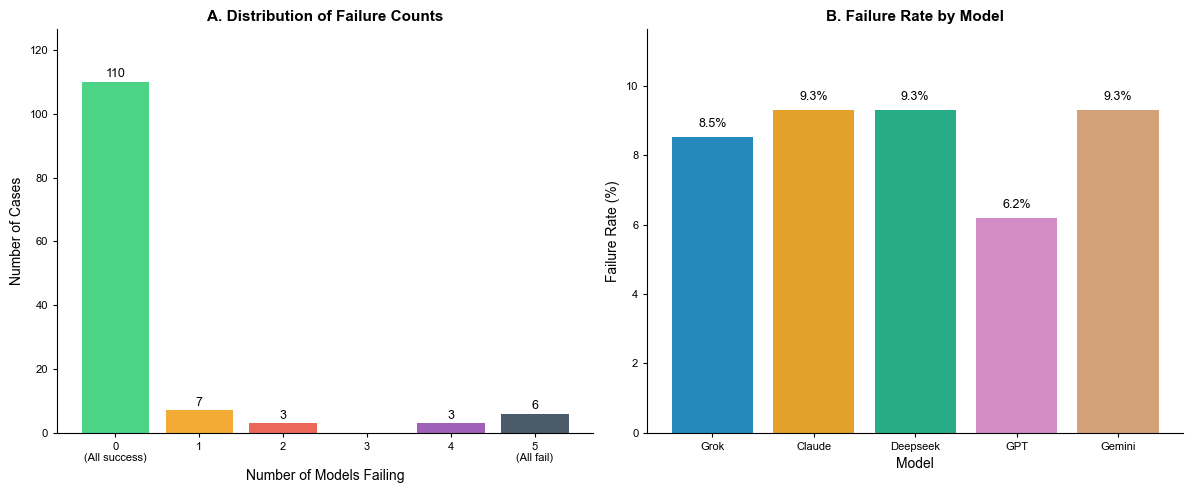


ANALYSIS COMPLETE

  Output directory: d:\Sleep_medicine\failure_analysis
  Files generated:
    - universal_failure_cases.csv
    - failure_table.tex
    - failure_analysis.png
    - failure_analysis.pdf


In [4]:
#!/usr/bin/env python3
"""
Universal Failure Case Analysis
===============================
Benchmarking Large Language Models for Differential Diagnosis in Sleep Medicine

This script identifies cases where ALL models failed (score = 0) and analyzes
their characteristics to understand what makes certain cases diagnostically
challenging for LLMs.

Author: [Your Name]
Date: 2025
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURATION - UPDATE THIS PATH
# =============================================================================
FILE_PATH = r"E:\test\sleep\Final_results.xlsx"  # Update to your file path

# Model names
MODEL_NAMES = ['Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']

# Column mappings for human raters
MODEL_COLUMNS = {
    "Grok": ("Grok", "Grok"),
    "Claude": ("Claude", "Claude"),
    "Deepseek": ("Deepseek", "Deepseek"),
    "GPT": ("GPT", "GPT"),
    "Gemini": ("Gemini", "Gemini"),
}

# Output directory
import os
OUTPUT_DIR = os.path.join(os.getcwd(), "failure_analysis")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# =============================================================================
# NPJ Style Configuration
# =============================================================================
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 9,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})


def load_data(file_path):
    """
    Load and prepare data from Excel file.
    """
    print("=" * 70)
    print("LOADING DATA")
    print("=" * 70)
    
    # Load all sheets
    human1 = pd.read_excel(file_path, sheet_name="human1")
    human2 = pd.read_excel(file_path, sheet_name="human2")
    info = pd.read_excel(file_path, sheet_name="Info")
    
    # Create averaged scores
    human_avg = info.copy()
    
    for model, (col_h1, col_h2) in MODEL_COLUMNS.items():
        human_avg[model] = (human1[col_h1] + human2[col_h2]) / 2
    
    # Add case ID if not present
    if 'Case_ID' not in human_avg.columns:
        human_avg['Case_ID'] = np.arange(1, len(human_avg) + 1)
    
    print(f"  Total cases: {len(human_avg)}")
    print(f"  Models: {MODEL_NAMES}")
    print(f"  Available columns: {list(human_avg.columns)}")
    print()
    
    return human_avg, human1, human2, info


def identify_failure_patterns(df):
    """
    Identify different failure patterns across models.
    
    Returns:
    --------
    dict with:
        - universal_failures: Cases where ALL models failed (score = 0)
        - any_failure: Cases where at least one model failed
        - single_failures: Cases where exactly one model failed
        - majority_failures: Cases where 3+ models failed
    """
    print("=" * 70)
    print("IDENTIFYING FAILURE PATTERNS")
    print("=" * 70)
    
    # Calculate failure status for each model (score = 0)
    failure_matrix = pd.DataFrame()
    failure_matrix['Case_ID'] = df['Case_ID'] if 'Case_ID' in df.columns else range(1, len(df) + 1)
    
    for model in MODEL_NAMES:
        # A score of 0 indicates failure (reference diagnosis not in top 5)
        failure_matrix[f'{model}_failed'] = (df[model] == 0).astype(int)
    
    # Count failures per case
    failure_cols = [f'{m}_failed' for m in MODEL_NAMES]
    failure_matrix['n_failures'] = failure_matrix[failure_cols].sum(axis=1)
    
    # Identify different failure patterns
    universal_failures = failure_matrix[failure_matrix['n_failures'] == 5]['Case_ID'].tolist()
    any_failure = failure_matrix[failure_matrix['n_failures'] >= 1]['Case_ID'].tolist()
    single_failures = failure_matrix[failure_matrix['n_failures'] == 1]['Case_ID'].tolist()
    majority_failures = failure_matrix[failure_matrix['n_failures'] >= 3]['Case_ID'].tolist()
    
    # Identify which models failed for single-failure cases
    single_failure_models = {}
    for case_id in single_failures:
        case_row = failure_matrix[failure_matrix['Case_ID'] == case_id].iloc[0]
        for model in MODEL_NAMES:
            if case_row[f'{model}_failed'] == 1:
                single_failure_models[case_id] = model
                break
    
    print(f"  Universal failures (all 5 models): {len(universal_failures)} cases")
    print(f"  Majority failures (3+ models): {len(majority_failures)} cases")
    print(f"  Any failure (1+ models): {len(any_failure)} cases")
    print(f"  Single model failures: {len(single_failures)} cases")
    print()
    
    return {
        'universal_failures': universal_failures,
        'any_failure': any_failure,
        'single_failures': single_failures,
        'single_failure_models': single_failure_models,
        'majority_failures': majority_failures,
        'failure_matrix': failure_matrix
    }


def analyze_universal_failures(df, universal_failure_ids):
    """
    Analyze characteristics of universal failure cases.
    """
    print("=" * 70)
    print("UNIVERSAL FAILURE CASE ANALYSIS")
    print("=" * 70)
    
    if len(universal_failure_ids) == 0:
        print("  No universal failure cases found.")
        return None
    
    # Get case indices (0-based)
    if 'Case_ID' in df.columns:
        failure_cases = df[df['Case_ID'].isin(universal_failure_ids)].copy()
    else:
        # Assume Case_ID is 1-indexed
        failure_indices = [i - 1 for i in universal_failure_ids]
        failure_cases = df.iloc[failure_indices].copy()
    
    print(f"\n  Found {len(failure_cases)} universal failure cases")
    print("-" * 70)
    
    # Display each failure case
    results = []
    
    for idx, (_, row) in enumerate(failure_cases.iterrows()):
        case_info = {
            'Case_Number': universal_failure_ids[idx] if idx < len(universal_failure_ids) else idx + 1,
        }
        
        # Extract available metadata
        metadata_cols = {
            'Publisher': ['Publisher', 'Source', 'Journal'],
            'Book': ['Book', 'Textbook', 'Source_Detail'],
            'Disease_Diagnosis': ['Disease diagnosis', 'Truth Disease diagnosis', 'Diagnosis', 'Reference_Diagnosis'],
            'Clinical_Specialty': ['Clinical specialty', 'Specialty', 'Domain', 'Secondary_Domain'],
            'Age': ['Age'],
            'Gender': ['Gender', 'Sex'],
            'Status': ['Status', 'Publically avalibale', 'Access'],
            'Patient_Text': ['Patient Text', 'Vignette', 'Clinical_Presentation'],
        }
        
        for key, possible_cols in metadata_cols.items():
            for col in possible_cols:
                if col in row.index and pd.notna(row[col]):
                    case_info[key] = row[col]
                    break
            if key not in case_info:
                case_info[key] = 'Not available'
        
        # Get model scores
        for model in MODEL_NAMES:
            if model in row.index:
                case_info[f'{model}_Score'] = row[model]
        
        results.append(case_info)
        
        # Print summary
        print(f"\n  Case #{case_info['Case_Number']}:")
        print(f"    Diagnosis: {case_info.get('Disease_Diagnosis', 'N/A')}")
        print(f"    Specialty: {case_info.get('Clinical_Specialty', 'N/A')}")
        print(f"    Publisher: {case_info.get('Publisher', 'N/A')}")
        print(f"    Access: {case_info.get('Status', 'N/A')}")
        
        # Print scores
        scores = [f"{m}: {case_info.get(f'{m}_Score', 'N/A')}" for m in MODEL_NAMES]
        print(f"    Scores: {', '.join(scores)}")
    
    print("-" * 70)
    
    # Create summary DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df


def analyze_failure_characteristics(df, failure_ids, all_case_ids):
    """
    Compare characteristics of failure cases vs. successful cases.
    """
    print("\n" + "=" * 70)
    print("COMPARATIVE ANALYSIS: FAILURE vs. SUCCESS CASES")
    print("=" * 70)
    
    if len(failure_ids) == 0:
        print("  No failure cases to analyze.")
        return None
    
    # Separate failure and success cases
    if 'Case_ID' in df.columns:
        failure_cases = df[df['Case_ID'].isin(failure_ids)]
        success_cases = df[~df['Case_ID'].isin(failure_ids)]
    else:
        failure_indices = [i - 1 for i in failure_ids]
        success_indices = [i for i in range(len(df)) if i not in failure_indices]
        failure_cases = df.iloc[failure_indices]
        success_cases = df.iloc[success_indices]
    
    comparison = {}
    
    # 1. Publisher/Source distribution
    print("\n  1. PUBLISHER DISTRIBUTION")
    print("  " + "-" * 50)
    
    if 'Publisher' in df.columns:
        failure_pubs = failure_cases['Publisher'].value_counts()
        success_pubs = success_cases['Publisher'].value_counts()
        
        print("\n  Failure cases by publisher:")
        for pub, count in failure_pubs.items():
            pct = count / len(failure_cases) * 100
            print(f"    {pub}: {count} ({pct:.1f}%)")
        
        comparison['failure_publishers'] = failure_pubs.to_dict()
        comparison['success_publishers'] = success_pubs.to_dict()
    
    # 2. Clinical specialty distribution
    print("\n  2. CLINICAL SPECIALTY DISTRIBUTION")
    print("  " + "-" * 50)
    
    specialty_col = None
    for col in ['Clinical specialty', 'Specialty', 'Domain', 'Secondary_Domain']:
        if col in df.columns:
            specialty_col = col
            break
    
    if specialty_col:
        failure_specs = failure_cases[specialty_col].value_counts()
        success_specs = success_cases[specialty_col].value_counts()
        
        print("\n  Failure cases by specialty:")
        for spec, count in failure_specs.items():
            pct = count / len(failure_cases) * 100
            total_in_spec = len(df[df[specialty_col] == spec])
            fail_rate = count / total_in_spec * 100 if total_in_spec > 0 else 0
            print(f"    {spec}: {count} ({pct:.1f}% of failures, {fail_rate:.1f}% failure rate in domain)")
        
        comparison['failure_specialties'] = failure_specs.to_dict()
    
    # 3. Access status (paywalled vs open)
    print("\n  3. ACCESS STATUS DISTRIBUTION")
    print("  " + "-" * 50)
    
    access_col = None
    for col in ['Status', 'Publically avalibale', 'Access', 'Publicly available']:
        if col in df.columns:
            access_col = col
            break
    
    if access_col:
        failure_access = failure_cases[access_col].value_counts()
        success_access = success_cases[access_col].value_counts()
        
        print("\n  Failure cases by access status:")
        for status, count in failure_access.items():
            pct = count / len(failure_cases) * 100
            print(f"    {status}: {count} ({pct:.1f}%)")
        
        comparison['failure_access'] = failure_access.to_dict()
    
    # 4. Age distribution
    print("\n  4. AGE DISTRIBUTION")
    print("  " + "-" * 50)
    
    if 'Age' in df.columns:
        failure_age = failure_cases['Age'].dropna()
        success_age = success_cases['Age'].dropna()
        
        if len(failure_age) > 0:
            print(f"\n  Failure cases: Mean age = {failure_age.mean():.1f} ± {failure_age.std():.1f}")
            print(f"  Success cases: Mean age = {success_age.mean():.1f} ± {success_age.std():.1f}")
            
            comparison['failure_age_mean'] = failure_age.mean()
            comparison['success_age_mean'] = success_age.mean()
    
    # 5. Diagnosis categories
    print("\n  5. DIAGNOSIS CATEGORIES")
    print("  " + "-" * 50)
    
    diagnosis_col = None
    for col in ['Disease diagnosis', 'Truth Disease diagnosis', 'Diagnosis', 'Reference_Diagnosis']:
        if col in df.columns:
            diagnosis_col = col
            break
    
    if diagnosis_col:
        print("\n  Diagnoses in failure cases:")
        for _, row in failure_cases.iterrows():
            diag = row[diagnosis_col] if pd.notna(row[diagnosis_col]) else 'N/A'
            print(f"    - {diag}")
    
    return comparison


def analyze_conditional_failures(df, failure_patterns):
    """
    Analyze conditional failure probabilities between models.
    """
    print("\n" + "=" * 70)
    print("CONDITIONAL FAILURE ANALYSIS")
    print("=" * 70)
    
    failure_matrix = failure_patterns['failure_matrix']
    
    # Calculate conditional probabilities
    print("\n  P(Model B fails | Model A fails)")
    print("  " + "-" * 50)
    
    cond_probs = pd.DataFrame(index=MODEL_NAMES, columns=MODEL_NAMES, dtype=float)
    
    for model_a in MODEL_NAMES:
        a_failed = failure_matrix[f'{model_a}_failed'] == 1
        n_a_failed = a_failed.sum()
        
        if n_a_failed == 0:
            continue
            
        for model_b in MODEL_NAMES:
            if model_a == model_b:
                cond_probs.loc[model_a, model_b] = np.nan
            else:
                b_failed = failure_matrix[f'{model_b}_failed'] == 1
                both_failed = (a_failed & b_failed).sum()
                cond_probs.loc[model_a, model_b] = both_failed / n_a_failed * 100
    
    print("\n  Conditional failure probabilities (%):")
    print(cond_probs.round(1).to_string())
    
    return cond_probs


def analyze_unique_failures(df, failure_patterns):
    """
    Analyze cases where only one model failed (unique failures).
    """
    print("\n" + "=" * 70)
    print("UNIQUE FAILURE ANALYSIS")
    print("=" * 70)
    
    single_failures = failure_patterns['single_failures']
    single_failure_models = failure_patterns['single_failure_models']
    
    if len(single_failures) == 0:
        print("  No unique failure cases found.")
        return None
    
    # Count unique failures by model
    model_counts = Counter(single_failure_models.values())
    
    print("\n  Unique failures by model (cases where only this model failed):")
    print("  " + "-" * 50)
    
    for model in MODEL_NAMES:
        count = model_counts.get(model, 0)
        pct = count / len(df) * 100
        print(f"    {model}: {count} cases ({pct:.1f}%)")
    
    # List the specific cases
    print("\n  Unique failure case details:")
    print("  " + "-" * 50)
    
    diagnosis_col = None
    for col in ['Disease diagnosis', 'Truth Disease diagnosis', 'Diagnosis']:
        if col in df.columns:
            diagnosis_col = col
            break
    
    for case_id, model in single_failure_models.items():
        if 'Case_ID' in df.columns:
            case_row = df[df['Case_ID'] == case_id].iloc[0]
        else:
            case_row = df.iloc[case_id - 1]
        
        diag = case_row[diagnosis_col] if diagnosis_col and pd.notna(case_row[diagnosis_col]) else 'N/A'
        print(f"    Case #{case_id}: {model} failed | Diagnosis: {diag}")
    
    return model_counts


def generate_failure_summary_table(df, failure_cases_df, failure_patterns):
    """
    Generate a publication-ready summary table of failure cases.
    """
    print("\n" + "=" * 70)
    print("GENERATING SUMMARY TABLE FOR PUBLICATION")
    print("=" * 70)
    
    if failure_cases_df is None or len(failure_cases_df) == 0:
        print("  No failure cases to summarize.")
        return None
    
    # Create formatted table
    summary_cols = ['Case_Number', 'Disease_Diagnosis', 'Clinical_Specialty', 
                    'Publisher', 'Status']
    
    available_cols = [c for c in summary_cols if c in failure_cases_df.columns]
    
    if len(available_cols) > 0:
        summary_table = failure_cases_df[available_cols].copy()
        
        # Rename columns for publication
        rename_map = {
            'Case_Number': 'Case',
            'Disease_Diagnosis': 'Reference Diagnosis',
            'Clinical_Specialty': 'Domain',
            'Publisher': 'Source',
            'Status': 'Access'
        }
        summary_table = summary_table.rename(columns=rename_map)
        
        print("\n  Supplementary Table: Universal Failure Cases")
        print("  " + "-" * 60)
        print(summary_table.to_string(index=False))
        
        # Save to CSV
        csv_path = os.path.join(OUTPUT_DIR, 'universal_failure_cases.csv')
        summary_table.to_csv(csv_path, index=False)
        print(f"\n  ✓ Table saved to: {csv_path}")
        
        return summary_table
    
    return None


def generate_latex_table(failure_cases_df):
    """
    Generate LaTeX code for the failure cases table.
    """
    if failure_cases_df is None or len(failure_cases_df) == 0:
        return ""
    
    latex = r"""
\begin{table}[htbp]
\centering
\caption{\textbf{Characteristics of universal failure cases.} Cases in which all five models failed to include the reference diagnosis within the top-5 differential (\emph{n} = """ + str(len(failure_cases_df)) + r"""). These cases represent diagnostically challenging scenarios that exceeded current LLM capabilities regardless of model architecture.}
\label{tab:universal_failures}
\vspace{0.5em}
\small
\begin{tabular}{clllp{3cm}}
\toprule
\textbf{Case} & \textbf{Reference Diagnosis} & \textbf{Domain} & \textbf{Source} & \textbf{Potential Difficulty Factors} \\
\midrule
"""
    
    for _, row in failure_cases_df.iterrows():
        case_num = row.get('Case_Number', 'N/A')
        diagnosis = str(row.get('Disease_Diagnosis', 'N/A'))[:40]
        if len(str(row.get('Disease_Diagnosis', ''))) > 40:
            diagnosis += '...'
        domain = row.get('Clinical_Specialty', 'N/A')
        source = str(row.get('Publisher', 'N/A'))[:20]
        if len(str(row.get('Publisher', ''))) > 20:
            source += '...'
        
        # Escape LaTeX special characters
        diagnosis = diagnosis.replace('_', r'\_').replace('&', r'\&')
        source = source.replace('_', r'\_').replace('&', r'\&')
        
        latex += f"    {case_num} & {diagnosis} & {domain} & {source} & [To be added] \\\\\n"
    
    latex += r"""\bottomrule
\end{tabular}
\vspace{0.5em}

\footnotesize
\textit{Note:} Potential difficulty factors may include rare diagnoses, atypical presentations, overlapping clinical features, or insufficient discriminating information in the vignette.
\end{table}
"""
    
    return latex


def create_failure_visualization(df, failure_patterns):
    """
    Create visualizations for failure analysis.
    """
    print("\n" + "=" * 70)
    print("GENERATING VISUALIZATIONS")
    print("=" * 70)
    
    failure_matrix = failure_patterns['failure_matrix']
    
    # Figure 1: Failure count distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Panel A: Number of models failing per case
    ax1 = axes[0]
    failure_counts = failure_matrix['n_failures'].value_counts().sort_index()
    colors = ['#2ecc71', '#f39c12', '#e74c3c', '#c0392b', '#8e44ad', '#2c3e50']
    
    bars = ax1.bar(failure_counts.index, failure_counts.values, 
                   color=[colors[i] for i in failure_counts.index],
                   edgecolor='none', alpha=0.85)
    
    ax1.set_xlabel('Number of Models Failing', fontsize=10)
    ax1.set_ylabel('Number of Cases', fontsize=10)
    ax1.set_title('A. Distribution of Failure Counts', fontsize=11, fontweight='bold')
    ax1.set_xticks(range(6))
    ax1.set_xticklabels(['0\n(All success)', '1', '2', '3', '4', '5\n(All fail)'])
    
    # Add value labels
    for bar, val in zip(bars, failure_counts.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(val), ha='center', va='bottom', fontsize=9)
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylim(0, max(failure_counts.values) * 1.15)
    
    # Panel B: Failure rate by model
    ax2 = axes[1]
    
    model_failure_rates = []
    for model in MODEL_NAMES:
        fail_rate = (df[model] == 0).sum() / len(df) * 100
        model_failure_rates.append(fail_rate)
    
    model_colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161']
    bars = ax2.bar(MODEL_NAMES, model_failure_rates, color=model_colors, 
                   edgecolor='none', alpha=0.85)
    
    ax2.set_xlabel('Model', fontsize=10)
    ax2.set_ylabel('Failure Rate (%)', fontsize=10)
    ax2.set_title('B. Failure Rate by Model', fontsize=11, fontweight='bold')
    
    # Add value labels
    for bar, val in zip(bars, model_failure_rates):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_ylim(0, max(model_failure_rates) * 1.25)
    
    plt.tight_layout()
    
    # Save figure
    fig_path = os.path.join(OUTPUT_DIR, 'failure_analysis.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(fig_path.replace('.png', '.pdf'), bbox_inches='tight', facecolor='white')
    
    print(f"  ✓ Figure saved to: {fig_path}")
    
    plt.show()
    
    return fig


def main():
    """
    Main analysis pipeline.
    """
    print("\n" + "=" * 70)
    print("UNIVERSAL FAILURE CASE ANALYSIS")
    print("Sleep Medicine LLM Benchmarking Study")
    print("=" * 70 + "\n")
    
    # Load data
    try:
        df, human1, human2, info = load_data(FILE_PATH)
    except FileNotFoundError:
        print(f"  ✗ File not found: {FILE_PATH}")
        print("  Please update FILE_PATH in the script configuration.")
        return
    except Exception as e:
        print(f"  ✗ Error loading data: {e}")
        return
    
    # Identify failure patterns
    failure_patterns = identify_failure_patterns(df)
    
    # Analyze universal failures
    failure_cases_df = analyze_universal_failures(df, failure_patterns['universal_failures'])
    
    # Compare failure vs success characteristics
    comparison = analyze_failure_characteristics(
        df, 
        failure_patterns['universal_failures'],
        list(range(1, len(df) + 1))
    )
    
    # Analyze conditional failures
    cond_probs = analyze_conditional_failures(df, failure_patterns)
    
    # Analyze unique failures
    unique_failure_counts = analyze_unique_failures(df, failure_patterns)
    
    # Generate summary table
    summary_table = generate_failure_summary_table(df, failure_cases_df, failure_patterns)
    
    # Generate LaTeX table
    latex_table = generate_latex_table(failure_cases_df)
    if latex_table:
        latex_path = os.path.join(OUTPUT_DIR, 'failure_table.tex')
        with open(latex_path, 'w') as f:
            f.write(latex_table)
        print(f"\n  ✓ LaTeX table saved to: {latex_path}")
    
    # Create visualizations
    fig = create_failure_visualization(df, failure_patterns)
    
    # Final summary
    print("\n" + "=" * 70)
    print("ANALYSIS COMPLETE")
    print("=" * 70)
    print(f"\n  Output directory: {OUTPUT_DIR}")
    print(f"  Files generated:")
    print(f"    - universal_failure_cases.csv")
    print(f"    - failure_table.tex")
    print(f"    - failure_analysis.png")
    print(f"    - failure_analysis.pdf")
    
    return {
        'failure_patterns': failure_patterns,
        'failure_cases': failure_cases_df,
        'comparison': comparison,
        'conditional_probs': cond_probs,
        'unique_failures': unique_failure_counts
    }


if __name__ == "__main__":
    results = main()

In [12]:
# Diagnostic category distribution
print("DIAGNOSTIC CATEGORY DISTRIBUTION")
print("=" * 60)

# Get unique diagnoses and categorize them
diagnoses = human_avg['Truth Disease diagnosis'].value_counts()

# You'll need to manually categorize, but this gives you the list
print(f"\nUnique diagnoses: {len(diagnoses)}")
print("\nMost common diagnoses:")
print(diagnoses.head(20))

# If you have a category column or can create one:
categories = {
    'Sleep-related breathing disorders': ['OSA', 'CSA', 'apnea', 'hypoventilation'],
    'Insomnia disorders': ['insomnia', 'Insomnia'],
    'Central hypersomnolence': ['narcolepsy', 'hypersomnia', 'Narcolepsy'],
    'Parasomnias': ['RBD', 'sleepwalking', 'nightmare', 'parasomnia'],
    'Circadian rhythm disorders': ['circadian', 'delayed', 'advanced', 'shift work'],
    'Movement disorders': ['RLS', 'restless', 'PLMD', 'periodic limb'],
}

# Count by category
for cat, keywords in categories.items():
    count = sum(1 for d in human_avg['Truth Disease diagnosis'] 
                if any(k.lower() in str(d).lower() for k in keywords))
    print(f"{cat}: {count} cases")

DIAGNOSTIC CATEGORY DISTRIBUTION

Unique diagnoses: 128

Most common diagnoses:
Truth Disease diagnosis
Overlap syndrome (COPD and severe obstructive sleep apnea).                                                                                                                                                                                                                   2
PAROXYSMAL HYPNOGENIC DYSKINESIA                                                                                                                                                                                                                                              1
Obstructive Sleep Apnea (OSA)                                                                                                                                                                                                                                                 1
Congenital Long QT syndrome type 2 with a cardiac arrest and convulsion triggere

In [13]:
# Detailed score distributions
print("SCORE DISTRIBUTION BY MODEL")
print("=" * 60)

for model in MODEL_NAMES:
    print(f"\n{model}:")
    scores = human_avg[model]
    for score in [5, 4, 3, 2, 1, 0]:
        count = (scores == score).sum()
        pct = count / len(scores) * 100
        print(f"  Score {score}: {count} cases ({pct:.1f}%)")

SCORE DISTRIBUTION BY MODEL

Grok:
  Score 5: 73 cases (56.6%)
  Score 4: 13 cases (10.1%)
  Score 3: 5 cases (3.9%)
  Score 2: 3 cases (2.3%)
  Score 1: 4 cases (3.1%)
  Score 0: 11 cases (8.5%)

Claude:
  Score 5: 79 cases (61.2%)
  Score 4: 7 cases (5.4%)
  Score 3: 1 cases (0.8%)
  Score 2: 3 cases (2.3%)
  Score 1: 1 cases (0.8%)
  Score 0: 12 cases (9.3%)

Deepseek:
  Score 5: 79 cases (61.2%)
  Score 4: 10 cases (7.8%)
  Score 3: 1 cases (0.8%)
  Score 2: 0 cases (0.0%)
  Score 1: 0 cases (0.0%)
  Score 0: 12 cases (9.3%)

GPT:
  Score 5: 79 cases (61.2%)
  Score 4: 11 cases (8.5%)
  Score 3: 2 cases (1.6%)
  Score 2: 4 cases (3.1%)
  Score 1: 1 cases (0.8%)
  Score 0: 8 cases (6.2%)

Gemini:
  Score 5: 73 cases (56.6%)
  Score 4: 14 cases (10.9%)
  Score 3: 1 cases (0.8%)
  Score 2: 1 cases (0.8%)
  Score 1: 2 cases (1.6%)
  Score 0: 12 cases (9.3%)


In [14]:
# Cases with largest rater disagreement
print("INTER-RATER DISAGREEMENT ANALYSIS")
print("=" * 60)

disagreement_data = []
for model in MODEL_NAMES:
    h1_col = model  # Adjust based on your column names
    h2_col = model
    
    for idx in range(len(human1)):
        score1 = human1.iloc[idx][h1_col]
        score2 = human2.iloc[idx][h2_col]
        diff = abs(score1 - score2)
        
        if diff >= 2:  # Substantial disagreement
            disagreement_data.append({
                'Case': idx + 1,
                'Model': model,
                'Rater1': score1,
                'Rater2': score2,
                'Difference': diff,
                'Diagnosis': human_avg.iloc[idx]['Truth Disease diagnosis']
            })

disagreement_df = pd.DataFrame(disagreement_data)
print(f"\nCases with score difference ≥2: {len(disagreement_df)}")
print(disagreement_df.to_string())

INTER-RATER DISAGREEMENT ANALYSIS

Cases with score difference ≥2: 95
    Case     Model  Rater1  Rater2  Difference                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    


[INFO] Score column mapping detected:
  Grok     -> Grok_results
  Claude   -> Claude
  Deepseek -> Deepseek
  GPT      -> GPT_results
  Gemini   -> Gemini


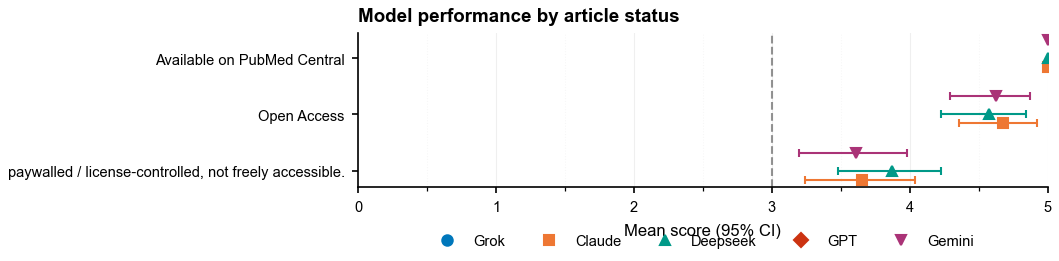

In [4]:
"""
NPJ Digital Medicine Forest Plot Generator
==========================================
Publication-ready forest plots following NPJ/Nature journal style guidelines.
"""

# =============================================================================
# IMPORTS
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from pathlib import Path
import difflib
import re

# =============================================================================
# NPJ DIGITAL MEDICINE STYLE CONFIGURATION
# =============================================================================

SINGLE_COLUMN = 3.5
ONE_AND_HALF_COLUMN = 5.0
DOUBLE_COLUMN = 7.2

NPJ_COLORS = {
    'Grok':     '#0077BB',
    'Claude':   '#EE7733',
    'Deepseek': '#009988',
    'GPT':      '#CC3311',
    'Gemini':   '#AA3377',
}

NPJ_MARKERS = {
    'Grok':     'o',
    'Claude':   's',
    'Deepseek': '^',
    'GPT':      'D',
    'Gemini':   'v',
}

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
    'font.size': 8,
    'axes.titlesize': 9,
    'axes.titleweight': 'bold',
    'axes.labelsize': 8,
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'legend.frameon': False,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
})

# =============================================================================
# USER SETTINGS
# =============================================================================

PATH = r"E:\test\sleep\Final_results.xlsx"
SHEET = "human_avg"

MODELS = ["Grok", "Claude", "Deepseek", "GPT", "Gemini"]

DEFAULT_XLIM = (0, 5)
DEFAULT_REF_VALUE = 3.0

# =============================================================================
# COLUMN HELPERS (NEW)
# =============================================================================

def _norm_col(s: str) -> str:
    """
    Normalize a column string for robust matching:
    - lowercase
    - remove spaces/underscores/hyphens
    - remove non-alphanumerics
    """
    s = str(s).strip().lower()
    s = re.sub(r'[\s_\-]+', '', s)
    s = re.sub(r'[^a-z0-9]', '', s)
    return s

def infer_score_cols(df: pd.DataFrame, models=MODELS):
    """
    Try to find the score columns in df even if header formatting differs.
    We look for each model name + a human average token.
    Accepts variations like:
      - Grok_human_avg
      - Grok human avg
      - grok_humanaverage
      - HumanAvg_Grok
      - grok_avg_human
    """
    cols = list(df.columns)
    norm_map = {_norm_col(c): c for c in cols}

    # candidate tokens that imply "human average"
    tokens = [
        "humanavg", "humanaverage", "humanmean", "humanratingavg",
        "avg", "mean"
    ]

    found = {}
    for m in models:
        m_norm = _norm_col(m)

        # rule 1: direct "model + humanavg" style
        candidates = []
        for t in tokens:
            # allow both orders: model+token and token+model
            candidates.append(m_norm + t)
            candidates.append(t + m_norm)

        # also accept exact old expected name if present
        old_expected = f"{m}_human_avg"
        if old_expected in df.columns:
            found[m] = old_expected
            continue

        # search for normalized matches containing model and one token
        best = None
        for ncol, orig in norm_map.items():
            if m_norm in ncol:
                if any(tok in ncol for tok in tokens):
                    best = orig
                    break

        if best is None:
            # fallback: closest match to old expected
            close = difflib.get_close_matches(old_expected, cols, n=1, cutoff=0.3)
            if close:
                best = close[0]

        if best is not None:
            found[m] = best

    # keep only models that actually found a column
    models_kept = [m for m in models if m in found]
    score_cols = [found[m] for m in models_kept]

    return models_kept, score_cols, found

# =============================================================================
# DATA LOADING (ROBUST)
# =============================================================================

def load_data(path=PATH, sheet=SHEET, min_models_required=3):
    """
    Load Excel data with robust header handling:
    - strips whitespace
    - auto-detects score columns
    - prints mapping
    """
    df = pd.read_excel(path, sheet_name=sheet)

    # Normalize visible header whitespace
    df.columns = df.columns.astype(str).str.strip()

    models_kept, score_cols, mapping = infer_score_cols(df, models=MODELS)

    print("\n[INFO] Score column mapping detected:")
    for m in MODELS:
        if m in mapping:
            print(f"  {m:8s} -> {mapping[m]}")
        else:
            print(f"  {m:8s} -> NOT FOUND")

    if len(score_cols) < min_models_required:
        print("\n[ERROR] Not enough model score columns detected.")
        print("Found columns:", df.columns.tolist())
        raise KeyError(
            f"Detected only {len(score_cols)} model score columns. "
            f"Need at least {min_models_required}. "
            "Fix the Excel headers or update infer_score_cols()."
        )

    # Drop rows missing all detected score columns
    df_scores = df.dropna(subset=score_cols, how="all").copy()

    # Store active columns for later use
    df_scores.attrs["MODELS_ACTIVE"] = models_kept
    df_scores.attrs["SCORE_COLS_ACTIVE"] = score_cols
    return df_scores

# =============================================================================
# STATISTICS
# =============================================================================

def bootstrap_ci_mean(x, n_boot=5000, alpha=0.05, seed=42):
    x = pd.to_numeric(pd.Series(x), errors="coerce").dropna().to_numpy()
    if x.size < 2:
        return np.nan, np.nan
    rng = np.random.default_rng(seed)
    boot_means = rng.choice(x, size=(n_boot, x.size), replace=True).mean(axis=1)
    return (
        float(np.percentile(boot_means, 100 * alpha / 2)),
        float(np.percentile(boot_means, 100 * (1 - alpha / 2))),
    )

def summarize_by_group(df, group_col, min_cases=5):
    if group_col not in df.columns:
        raise KeyError(f"'{group_col}' not found. Available columns: {df.columns.tolist()}")

    models_active = df.attrs.get("MODELS_ACTIVE", MODELS)
    score_cols_active = df.attrs.get("SCORE_COLS_ACTIVE", [])

    d = df.dropna(subset=[group_col]).copy()

    counts = d[group_col].value_counts()
    keep = counts[counts >= min_cases].index
    d = d[d[group_col].isin(keep)].copy()

    if d.empty:
        return pd.DataFrame(columns=["Group","Model","Mean","CI_low","CI_high","N","Group_N"])

    long_df = d.melt(
        id_vars=[group_col],
        value_vars=score_cols_active,
        var_name="ScoreCol",
        value_name="Score",
    )

    # Map back to model name
    inv = {v: k for k, v in {m: c for m, c in zip(models_active, score_cols_active)}.items()}
    long_df["Model"] = long_df["ScoreCol"].map(inv)

    rows = []
    for (g, m), sub in long_df.groupby([group_col, "Model"]):
        x = sub["Score"]
        mean = float(pd.to_numeric(x, errors="coerce").mean())
        lo, hi = bootstrap_ci_mean(x)
        rows.append({
            "Group": g,
            "Model": m,
            "Mean": mean,
            "CI_low": lo,
            "CI_high": hi,
            "N": int(x.notna().sum()),
        })

    out = pd.DataFrame(rows)
    if out.empty:
        return out

    out["Group_N"] = out.groupby("Group")["N"].transform("max")
    return out

# =============================================================================
# FOREST PLOT
# =============================================================================

def forest_plot(
    group_col,
    df_scores=None,
    min_cases=5,
    outfile=None,
    sort="n",
    sort_ascending=False,
    fig_width="double",
    title=None,
    xlim=DEFAULT_XLIM,
    ref_value=DEFAULT_REF_VALUE,
):

    if df_scores is None:
        df_scores = load_data()

    models_active = df_scores.attrs.get("MODELS_ACTIVE", MODELS)

    summ = summarize_by_group(df_scores, group_col, min_cases)

    if summ.empty:
        raise ValueError(f"No valid groups for '{group_col}' after filtering (min_cases={min_cases}).")

    if sort == "mean":
        order = summ.groupby("Group")["Mean"].mean().sort_values(ascending=sort_ascending).index
    else:
        order = summ.groupby("Group")["Group_N"].max().sort_values(ascending=sort_ascending).index

    order = list(order)
    summ["Group"] = pd.Categorical(summ["Group"], categories=order, ordered=True)

    width_map = {"single": SINGLE_COLUMN, "1.5": ONE_AND_HALF_COLUMN, "double": DOUBLE_COLUMN}
    fig_h = max(2.0, 0.28 * len(order) + 0.8)

    fig, ax = plt.subplots(figsize=(width_map.get(fig_width, DOUBLE_COLUMN), fig_h))

    dodge = np.linspace(-0.32, 0.32, len(models_active))

    for i, m in enumerate(models_active):
        sub = summ[summ["Model"] == m].sort_values("Group")
        y = sub["Group"].cat.codes.to_numpy() + dodge[i]

        xerr_low = (sub["Mean"] - sub["CI_low"]).to_numpy()
        xerr_high = (sub["CI_high"] - sub["Mean"]).to_numpy()

        ax.errorbar(
            sub["Mean"], y,
            xerr=[xerr_low, xerr_high],
            fmt=NPJ_MARKERS.get(m, "o"),
            color=NPJ_COLORS.get(m, "#333333"),
            capsize=2,
            markersize=4.5,
            label=m,
            zorder=3,
        )

    ax.set_yticks(range(len(order)))
    ax.set_yticklabels(order)
    ax.set_xlim(*xlim)
    ax.set_xlabel("Mean score (95% CI)")
    ax.set_title(title or f"Model performance by {group_col.lower()}", loc="left")

    # grid
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    ax.grid(axis='x', which='major', linestyle='-', alpha=0.2, zorder=0)
    ax.grid(axis='x', which='minor', linestyle=':', alpha=0.1, zorder=0)
    ax.set_axisbelow(True)

    if ref_value is not None:
        ax.axvline(ref_value, linestyle="--", color="#666666", linewidth=1.0, alpha=0.7, zorder=1)

    # legend
    ax.legend(
        handles=[
            Line2D([0], [0], marker=NPJ_MARKERS.get(m, "o"), color=NPJ_COLORS.get(m, "#333333"),
                   linestyle="None", markersize=5, label=m)
            for m in models_active
        ],
        loc="upper center",
        bbox_to_anchor=(0.5, -0.22),
        ncol=len(models_active),
        frameon=False,
    )

    plt.tight_layout()

    if outfile:
        outfile = Path(outfile)
        for ext in ("pdf", "svg", "png"):
            fig.savefig(outfile.with_suffix(f".{ext}"))

    return fig, ax

# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":
    df = load_data()

    fig, ax = forest_plot(
        "Status",
        df_scores=df,
        outfile="fig_status_forest",
        title="Model performance by article status",
    )
    plt.show()


=== AVAILABLE COLUMNS (human_avg) ===
['Publisher', 'Book', 'Publically avalibale', 'Status', 'Clinical specialty', 'Disease diagnosis', 'Differential Diagnosis', 'Patient Text', 'Truth Disease diagnosis', 'Grok_results', 'Claude_results', 'Deepseek_results', 'GPT_results', 'Gemini_results', 'Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']

[INFO] Detected NUMERIC score columns (mapping):
  Grok     -> Grok
  Claude   -> Claude
  Deepseek -> Deepseek
  GPT      -> GPT
  Gemini   -> Gemini

Total rows with at least one NUMERIC score: 129

PERFORMANCE BY STATUS

Unique values (top 30):
Status
paywalled / license-controlled, not freely accessible.    83
Open Access                                               39
Available on PubMed Central                                6
CNKI Access                                                1
Name: count, dtype: int64

=== MEAN SCORES BY Status ===
                                                        Cases   Grok  Claude  Deepseek    GPT  Gemini
S

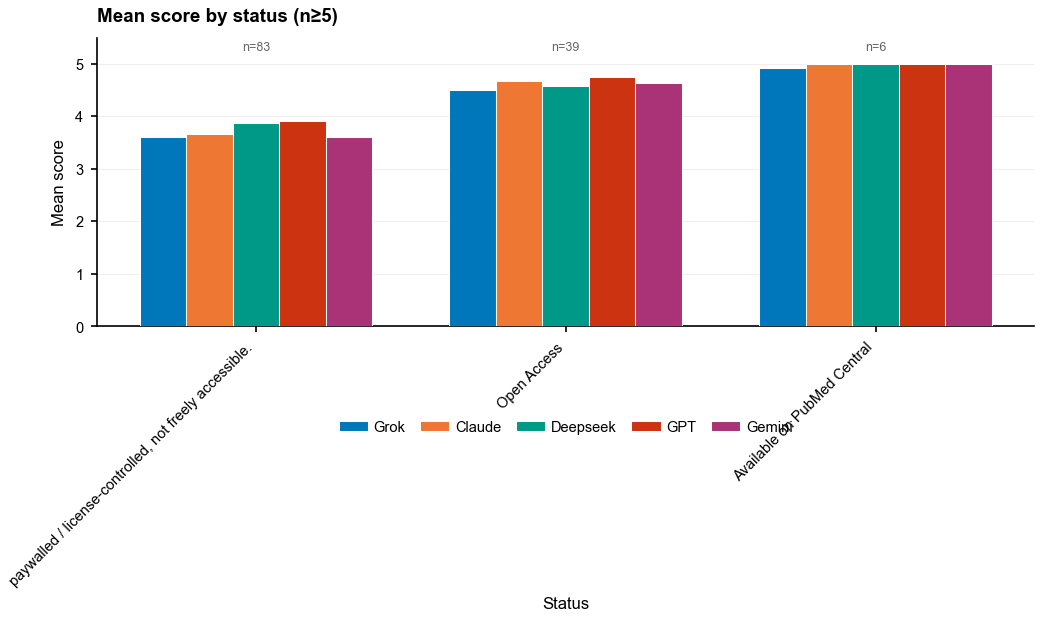


--- Generating failure rate plot ---
Saved: figures\status_Status_failure_rate.pdf
Saved: figures\status_Status_failure_rate.svg
Saved: figures\status_Status_failure_rate.png


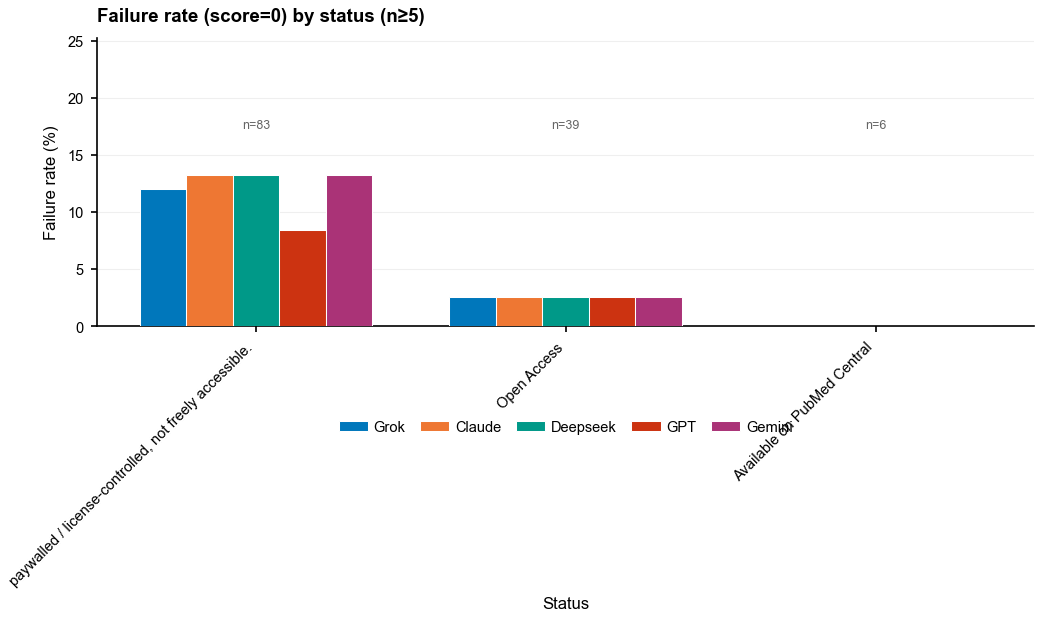


--- Generating mean score heatmap ---
Saved: figures\status_Status_mean_heatmap.pdf
Saved: figures\status_Status_mean_heatmap.svg
Saved: figures\status_Status_mean_heatmap.png


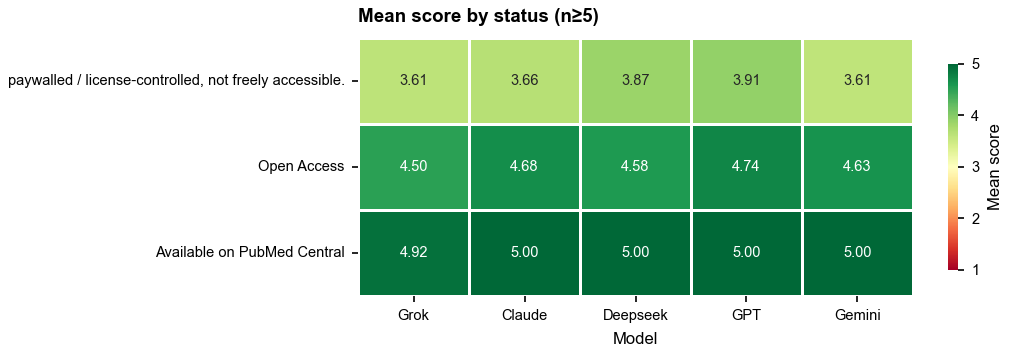


--- Generating failure rate heatmap ---
Saved: figures\status_Status_failure_heatmap.pdf
Saved: figures\status_Status_failure_heatmap.svg
Saved: figures\status_Status_failure_heatmap.png


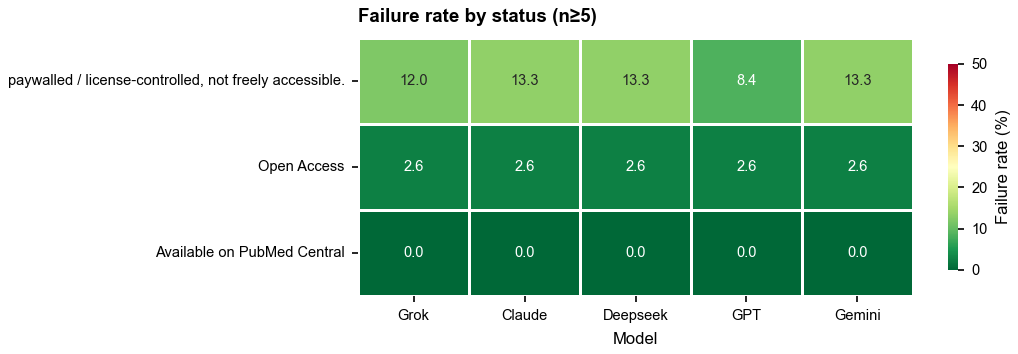


--- Generating Top-1 rate plot ---
Saved: figures\status_Status_top1.pdf
Saved: figures\status_Status_top1.svg
Saved: figures\status_Status_top1.png


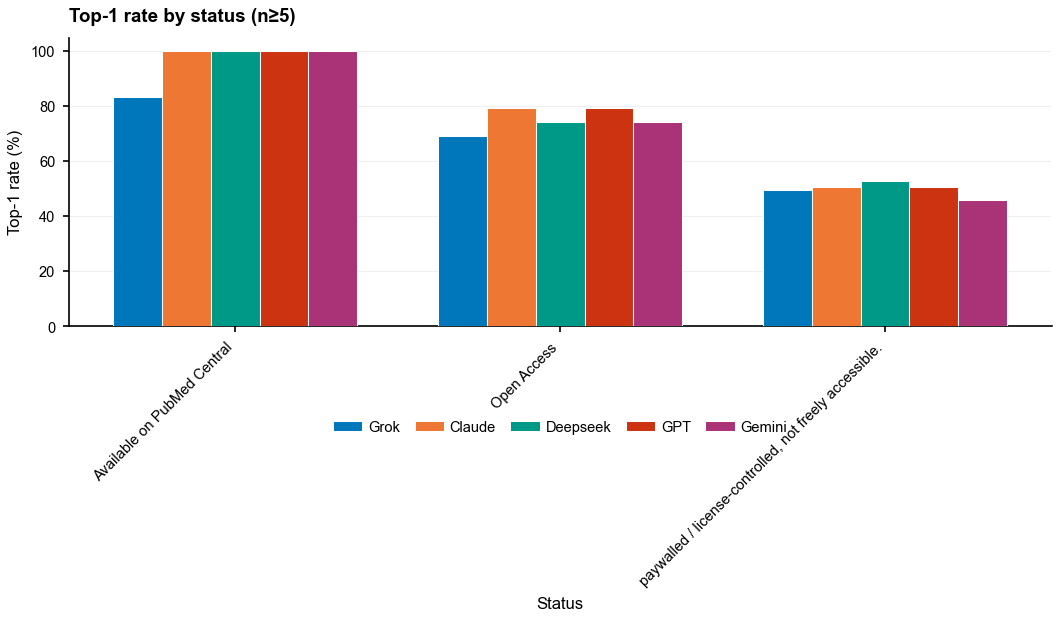


PERFORMANCE BY BOOK

Unique values (top 30):
Book
Sleepless and Sleepy                                                                                                                                51
Cllnical Cases in Sleep Physical Therapy                                                                                                            27
Pedriatic Sleep Medicine Cases                                                                                                                       6
Post operative capnostream monitoring in patients with obstructive sleep\napnoea symptoms – Case series                                              4
Recurrent hypersomnia: Report of\nmedication-responsive cases                                                                                        3
Effectiveness of Maxillomandibular advancement (MMA) surgery in sleep\napnea treatment: Case report                                                  2
Phenotypic contrasts of Duchenne Muscular D

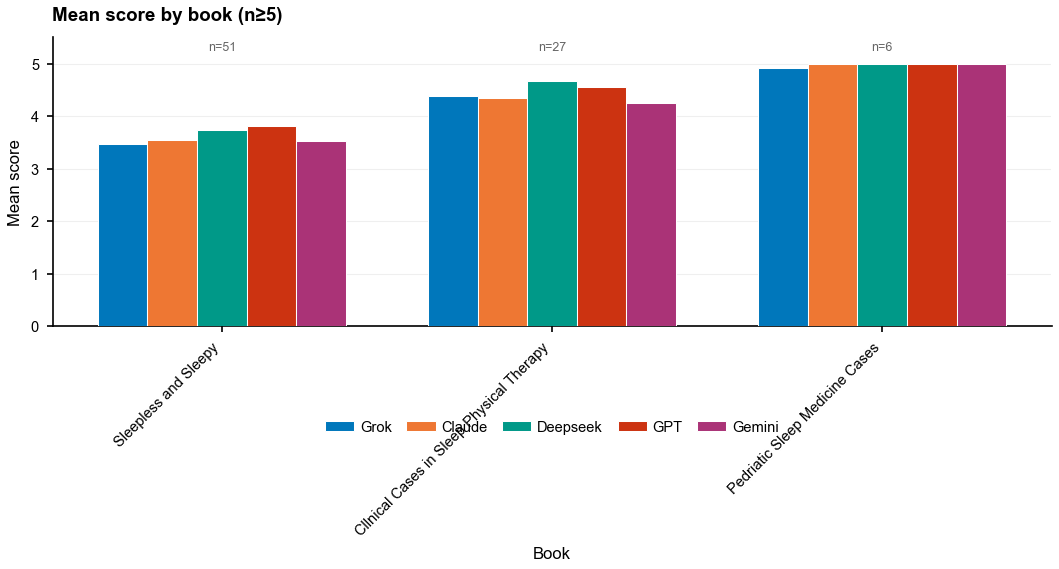


--- Generating failure rate plot ---
Saved: figures\book_Book_failure_rate.pdf
Saved: figures\book_Book_failure_rate.svg
Saved: figures\book_Book_failure_rate.png


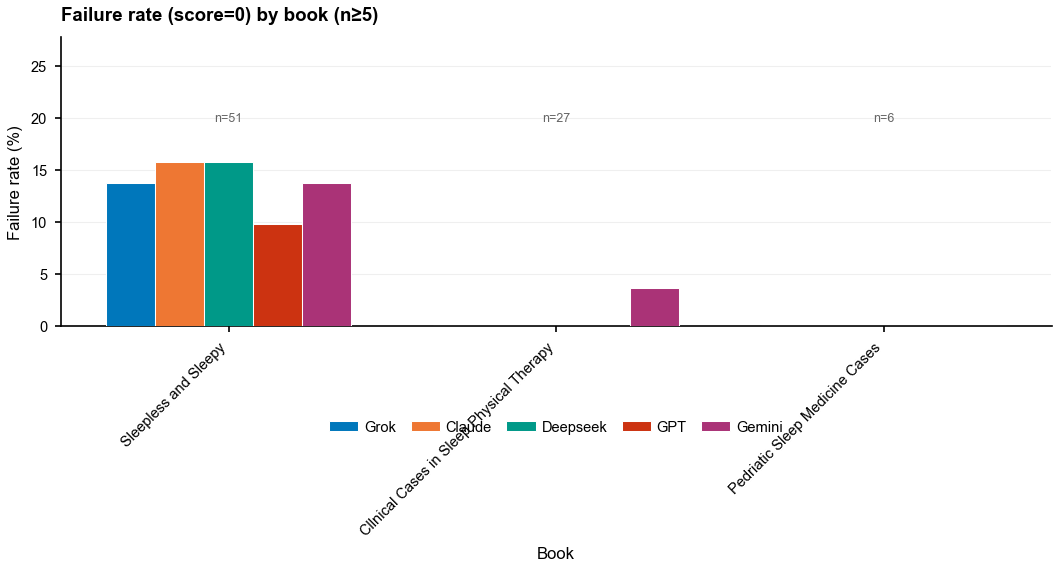


--- Generating mean score heatmap ---
Saved: figures\book_Book_mean_heatmap.pdf
Saved: figures\book_Book_mean_heatmap.svg
Saved: figures\book_Book_mean_heatmap.png


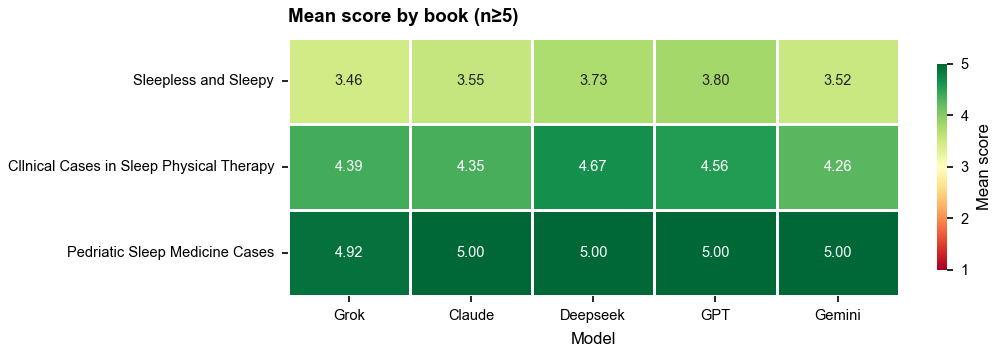


--- Generating failure rate heatmap ---
Saved: figures\book_Book_failure_heatmap.pdf
Saved: figures\book_Book_failure_heatmap.svg
Saved: figures\book_Book_failure_heatmap.png


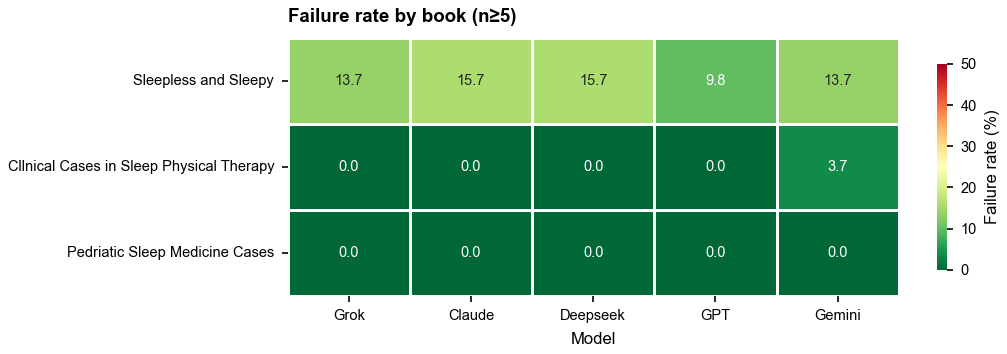


--- Generating Top-1 rate plot ---
Saved: figures\book_Book_top1.pdf
Saved: figures\book_Book_top1.svg
Saved: figures\book_Book_top1.png


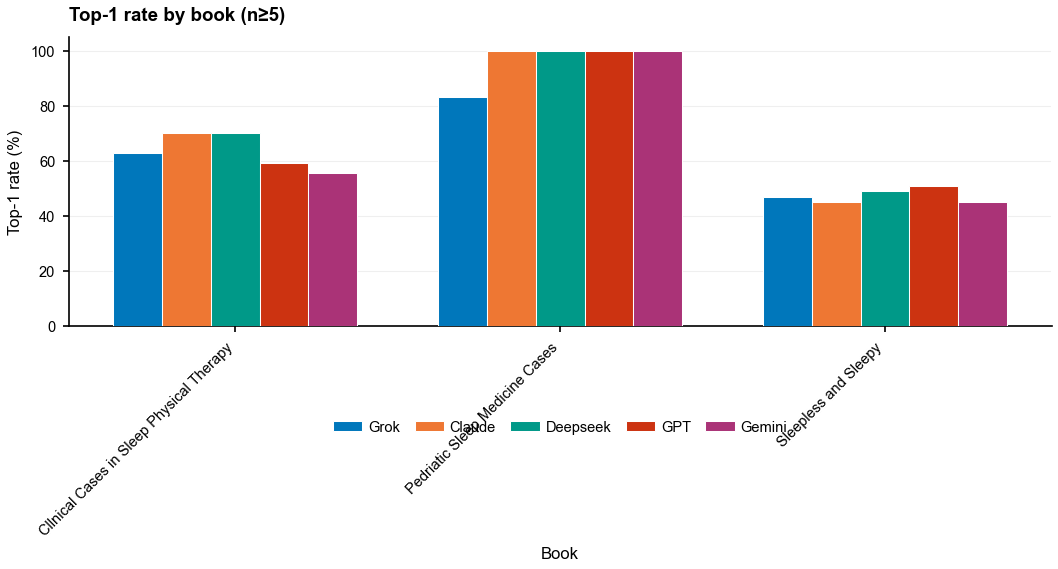


PERFORMANCE BY PUBLISHER

Unique values (top 30):
Publisher
Springer                                                        84
Elsevier - Sleep Science                                        29
Journal of Sleep Disorders and Management                        6
Springer - A Clinical Casebook of Sleep Disorders in Women\n     5
frontiers, Frontiers in Psychiatry                               2
frontiers, Frontiers in Neurology                                2
China Journal of Health Psychology                               1
Name: count, dtype: int64

=== MEAN SCORES BY Publisher ===
                                                              Cases   Grok  Claude  Deepseek    GPT  Gemini
Publisher                                                                                                  
Springer                                                         84  3.863   3.911     4.125  4.131   3.863
Elsevier - Sleep Science                                         29  4.517   4.724    

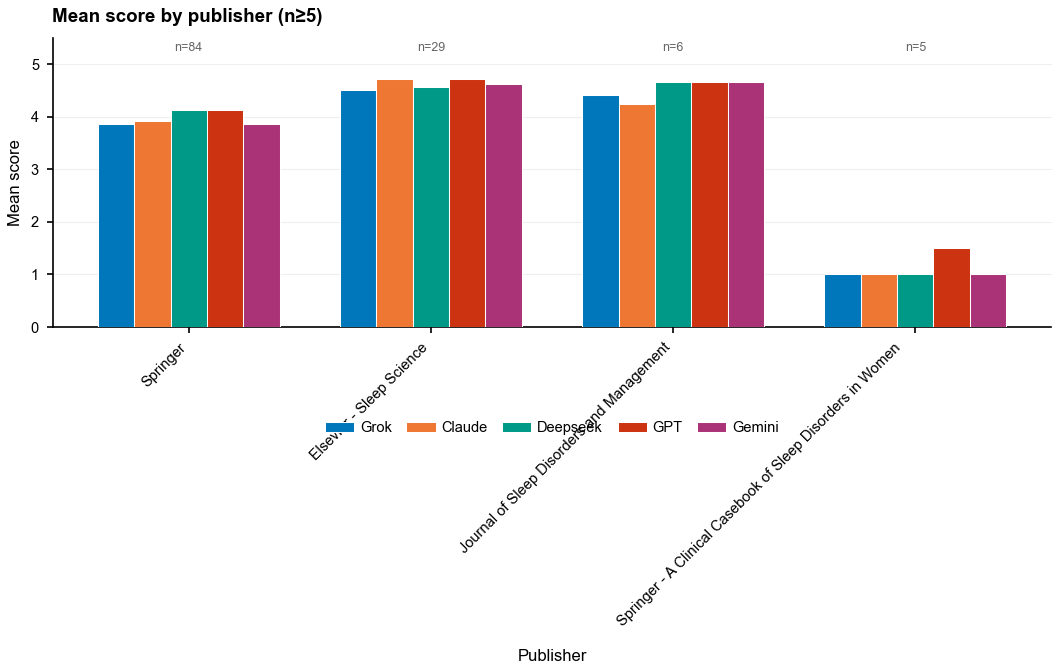


--- Generating failure rate plot ---
Saved: figures\publisher_Publisher_failure_rate.pdf
Saved: figures\publisher_Publisher_failure_rate.svg
Saved: figures\publisher_Publisher_failure_rate.png


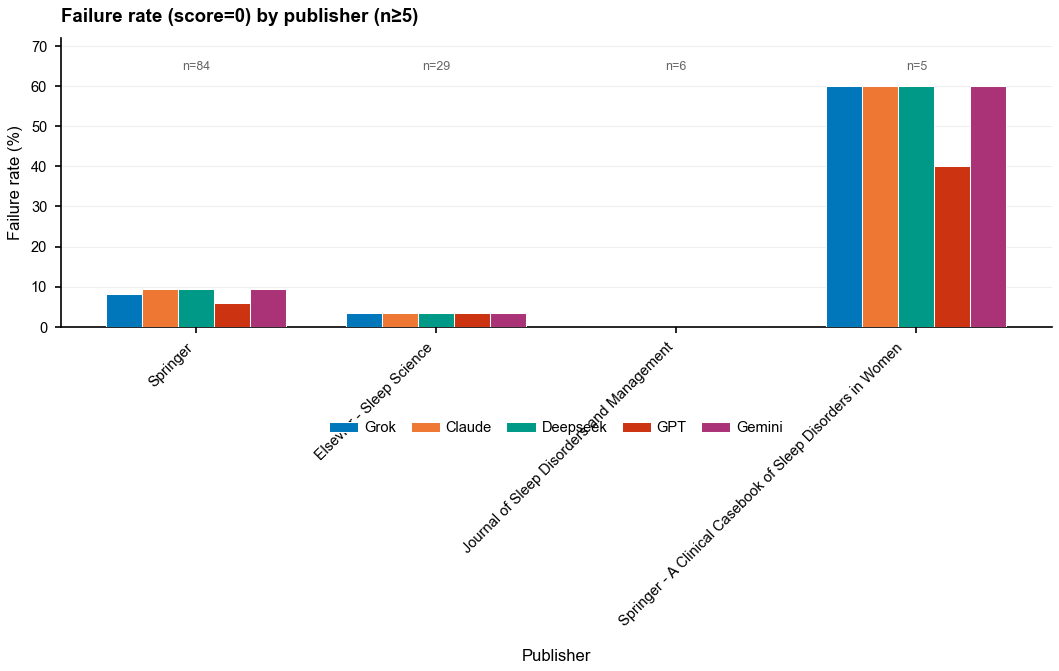


--- Generating mean score heatmap ---
Saved: figures\publisher_Publisher_mean_heatmap.pdf
Saved: figures\publisher_Publisher_mean_heatmap.svg
Saved: figures\publisher_Publisher_mean_heatmap.png


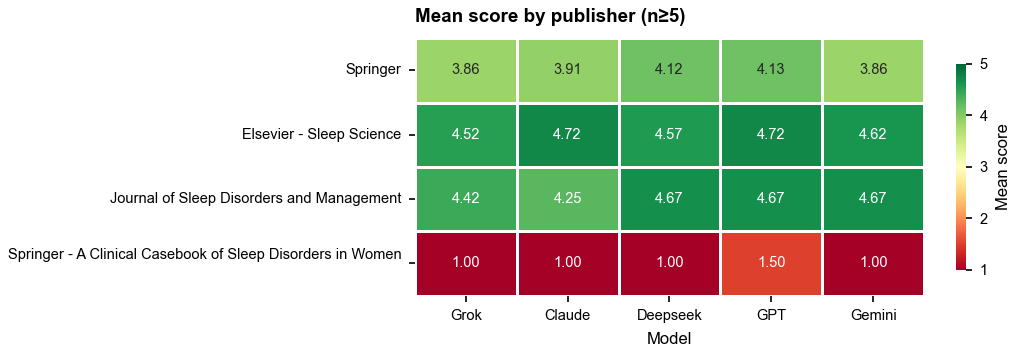


--- Generating failure rate heatmap ---
Saved: figures\publisher_Publisher_failure_heatmap.pdf
Saved: figures\publisher_Publisher_failure_heatmap.svg
Saved: figures\publisher_Publisher_failure_heatmap.png


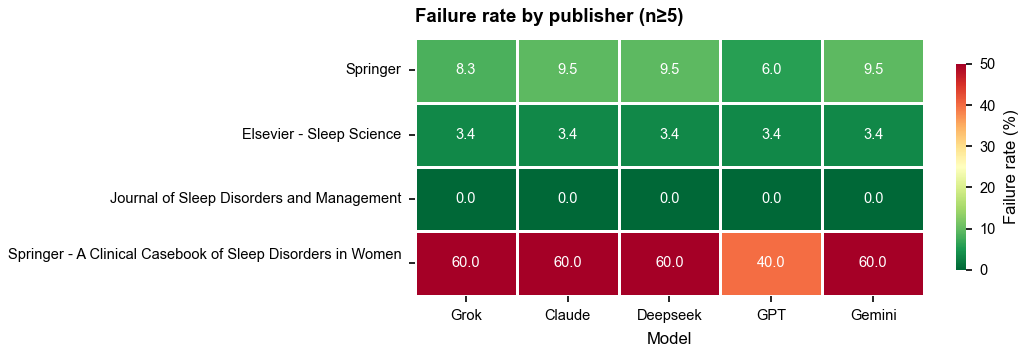


--- Generating Top-1 rate plot ---
Saved: figures\publisher_Publisher_top1.pdf
Saved: figures\publisher_Publisher_top1.svg
Saved: figures\publisher_Publisher_top1.png


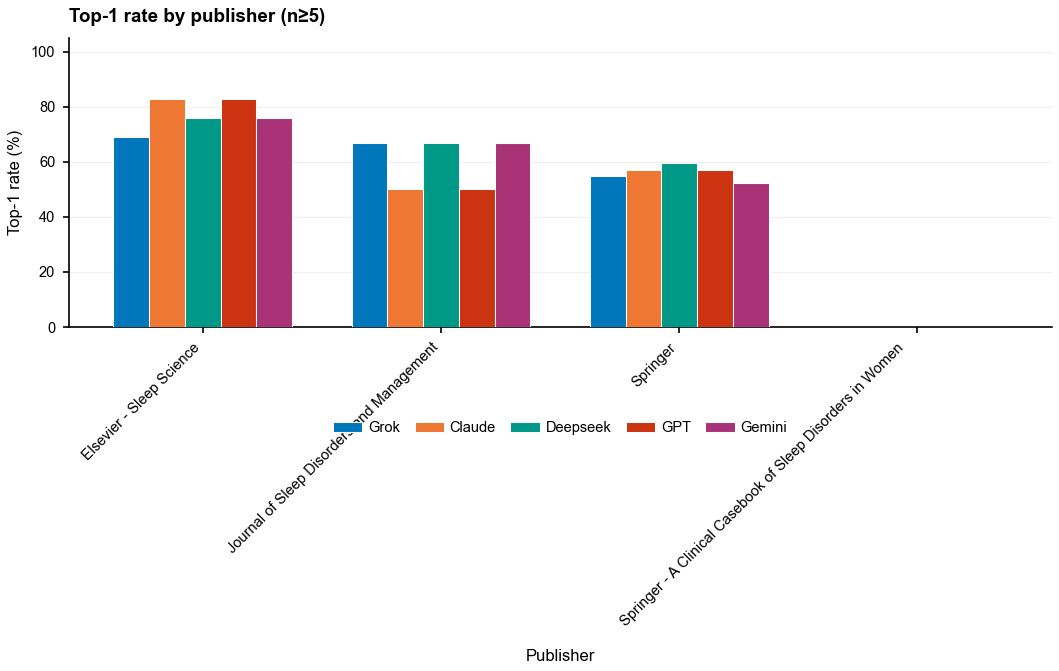


--- Exporting results to Excel ---

✓ Results exported to 'performance_by_status_book_publisher.xlsx'
✓ All figures saved to 'figures/' directory


In [6]:
"""
NPJ Digital Medicine Performance Analysis
==========================================
Publication-ready grouped bar charts and heatmaps following NPJ/Nature journal style guidelines.

Key features:
- Nature-style typography (Helvetica/Arial family)
- Print-ready resolution (300+ DPI)
- Colorblind-friendly, grayscale-compatible palette
- Clean, minimal design per journal standards
- Proper figure dimensions for single/double column
- Professional legend and annotation placement
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
import re

# Optional seaborn for heatmaps (script still works without it)
try:
    import seaborn as sns
    HAVE_SEABORN = True
except ImportError:
    HAVE_SEABORN = False


# =============================================================================
# NPJ DIGITAL MEDICINE STYLE CONFIGURATION
# =============================================================================

SINGLE_COLUMN = 3.5
ONE_AND_HALF_COLUMN = 5.0
DOUBLE_COLUMN = 7.2

NPJ_COLORS = {
    'Grok':     '#0077BB',
    'Claude':   '#EE7733',
    'Deepseek': '#009988',
    'GPT':      '#CC3311',
    'Gemini':   '#AA3377',
}

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
    'font.size': 8,
    'axes.titlesize': 9,
    'axes.titleweight': 'bold',
    'axes.labelsize': 8,
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'legend.fontsize': 7,
    'legend.frameon': False,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'lines.linewidth': 1.0,
    'grid.linewidth': 0.5,
    'grid.alpha': 0.3,
})


# =============================================================================
# USER SETTINGS
# =============================================================================

PATH = r"E:\test\sleep\Final_results.xlsx"
SHEET = "human_avg"

MODELS_WANTED = ["Grok", "Claude", "Deepseek", "GPT", "Gemini"]


# =============================================================================
# ROBUST NUMERIC SCORE COLUMN DETECTION (FIXED)
# =============================================================================

def _norm_col(s: str) -> str:
    s = str(s).strip().lower()
    s = re.sub(r'[\s_\-]+', '', s)
    s = re.sub(r'[^a-z0-9]', '', s)
    return s

def mostly_numeric(series: pd.Series, thresh: float = 0.7) -> bool:
    """
    True if >= thresh fraction of values can be converted to numeric.
    """
    s = pd.to_numeric(series, errors="coerce")
    return (s.notna().mean() >= thresh)

def infer_score_cols_numeric(df: pd.DataFrame, models=MODELS_WANTED):
    """
    Your file has BOTH:
      - text outputs: e.g. 'Grok_results' (often long strings)
      - numeric human scores: e.g. 'Grok', 'Claude', ...

    We must pick the NUMERIC columns only.

    Strategy per model:
      1) Prefer exact column == model name (e.g., 'Claude') if mostly numeric
      2) Else try '<model>_results' if mostly numeric
      3) Else try any column containing model + score tokens that is mostly numeric
      4) Else fallback to model name if exists (and later coerce to numeric)
    """
    cols = list(df.columns)
    found = {}

    score_tokens = ["human", "avg", "mean", "score", "rating", "grade"]

    for m in models:
        candidates = []

        # 1) exact model column
        if m in cols:
            candidates.append(m)

        # 2) model_results
        c2 = f"{m}_results"
        if c2 in cols:
            candidates.append(c2)

        # 3) other fuzzy candidates
        m_low = m.lower()
        for c in cols:
            c_low = str(c).lower()
            if m_low in c_low and any(tok in c_low for tok in score_tokens):
                if c not in candidates:
                    candidates.append(c)

        # choose first that is mostly numeric
        pick = None
        for c in candidates:
            if mostly_numeric(df[c]):
                pick = c
                break

        # fallback: if we have the exact model col, prefer it (we will coerce)
        if pick is None and m in cols:
            pick = m
        elif pick is None and candidates:
            pick = candidates[0]

        if pick is not None:
            found[m] = pick

    models_kept = [m for m in models if m in found]
    score_cols = [found[m] for m in models_kept]
    return models_kept, score_cols, found


# =============================================================================
# DATA LOADING (FIXED)
# =============================================================================

def load_data(path=PATH, sheet=SHEET, min_models_required=3):
    df = pd.read_excel(path, sheet_name=sheet)
    df.columns = df.columns.astype(str).str.strip()

    print("=== AVAILABLE COLUMNS (human_avg) ===")
    print(df.columns.tolist())

    models_active, score_cols_active, mapping = infer_score_cols_numeric(df, MODELS_WANTED)

    print("\n[INFO] Detected NUMERIC score columns (mapping):")
    for m in MODELS_WANTED:
        if m in mapping:
            print(f"  {m:8s} -> {mapping[m]}")
        else:
            print(f"  {m:8s} -> NOT FOUND")

    if len(score_cols_active) < min_models_required:
        raise KeyError(
            f"Detected only {len(score_cols_active)} score columns. Need at least {min_models_required}.\n"
            "Your sheet likely has text model outputs; the numeric score columns must be used."
        )

    # FORCE numeric conversion (text -> NaN)
    for c in score_cols_active:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df_scores = df.dropna(subset=score_cols_active, how="all").copy()

    df_scores.attrs["MODELS_ACTIVE"] = models_active
    df_scores.attrs["SCORE_COLS_ACTIVE"] = score_cols_active

    print("\nTotal rows with at least one NUMERIC score:", len(df_scores))
    return df_scores


# =============================================================================
# STATISTICAL HELPERS
# =============================================================================

def calculate_topk(scores):
    valid = pd.to_numeric(scores, errors="coerce").dropna()
    if len(valid) == 0:
        return {"Top-1": np.nan, "Top-2": np.nan, "Top-3": np.nan, "Top-4": np.nan, "Top-5": np.nan}
    return {
        "Top-1": (valid == 5).mean() * 100,
        "Top-2": (valid >= 4).mean() * 100,
        "Top-3": (valid >= 3).mean() * 100,
        "Top-4": (valid >= 2).mean() * 100,
        "Top-5": (valid >= 1).mean() * 100,
    }


# =============================================================================
# NPJ-STYLE PLOTTING FUNCTIONS
# =============================================================================

def plot_mean_scores(plot_data, group_col, min_cases, outfile=None, formats=('pdf','svg','png'),
                     title=None, fig_width="double", panel_label=None):

    model_names = [c for c in plot_data.columns if c not in ["Group", "Cases"]]
    n_groups = len(plot_data)
    n_models = len(model_names)

    width_map = {"single": SINGLE_COLUMN, "1.5": ONE_AND_HALF_COLUMN, "double": DOUBLE_COLUMN}
    fig_w = width_map.get(fig_width, DOUBLE_COLUMN)
    fig_h = max(3.0, 0.35 * n_groups + 1.5)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    x = np.arange(n_groups)
    width = 0.75 / max(n_models, 1)

    for i, m in enumerate(model_names):
        offset = (i - n_models/2 + 0.5) * width
        ax.bar(
            x + offset,
            plot_data[m],
            width,
            label=m,
            color=NPJ_COLORS.get(m, f'C{i}'),
            edgecolor='white',
            linewidth=0.5,
            zorder=3,
        )

    ax.set_xlabel(group_col)
    ax.set_ylabel("Mean score")
    ax.set_xticks(x)
    ax.set_xticklabels(plot_data["Group"], rotation=45, ha="right")
    ax.set_ylim(0, 5.5)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))

    ax.grid(axis="y", linestyle="-", alpha=0.2, zorder=0)
    ax.set_axisbelow(True)

    for i, row in enumerate(plot_data.itertuples(index=False)):
        ax.text(i, 5.25, f"n={int(row.Cases)}", ha="center", fontsize=6, color='#666666')

    if title is None:
        title = f"Mean score by {group_col.lower()}"
    ax.set_title(title, loc='left', pad=8)

    if panel_label:
        ax.text(-0.08, 1.05, panel_label, transform=ax.transAxes,
                fontsize=11, fontweight='bold', va='bottom')

    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.28),
        ncol=max(1, n_models),
        frameon=False,
        columnspacing=1.0,
        handletextpad=0.4,
    )

    plt.tight_layout()
    fig.subplots_adjust(bottom=0.25)

    if outfile:
        outpath = Path(outfile)
        for fmt in formats:
            save_path = outpath.with_suffix(f'.{fmt}')
            fig.savefig(save_path, format=fmt, dpi=300 if fmt == 'png' else None,
                       transparent=False, facecolor='white')
            print(f"Saved: {save_path}")

    return fig, ax


def plot_failure_rate(plot_data, group_col, min_cases, outfile=None, formats=('pdf','svg','png'),
                      title=None, fig_width="double", panel_label=None):

    fail_cols = [c for c in plot_data.columns if c.endswith("_Fail%")]
    model_names = [c.replace("_Fail%", "") for c in fail_cols]
    n_groups = len(plot_data)
    n_models = len(model_names)

    width_map = {"single": SINGLE_COLUMN, "1.5": ONE_AND_HALF_COLUMN, "double": DOUBLE_COLUMN}
    fig_w = width_map.get(fig_width, DOUBLE_COLUMN)
    fig_h = max(3.0, 0.35 * n_groups + 1.5)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    x = np.arange(n_groups)
    width = 0.75 / max(n_models, 1)
    max_val = np.nanmax(plot_data[fail_cols].values) if (len(plot_data) and len(fail_cols)) else 0

    for i, (col, m) in enumerate(zip(fail_cols, model_names)):
        offset = (i - n_models/2 + 0.5) * width
        ax.bar(
            x + offset,
            plot_data[col],
            width,
            label=m,
            color=NPJ_COLORS.get(m, f'C{i}'),
            edgecolor='white',
            linewidth=0.5,
            zorder=3,
        )

    ax.set_xlabel(group_col)
    ax.set_ylabel("Failure rate (%)")
    ax.set_xticks(x)
    ax.set_xticklabels(plot_data["Group"], rotation=45, ha="right")
    ax.set_ylim(0, max_val + 12)

    ax.grid(axis="y", linestyle="-", alpha=0.2, zorder=0)
    ax.set_axisbelow(True)

    for i, row in enumerate(plot_data.itertuples(index=False)):
        ax.text(i, max_val + 4, f"n={int(row.Cases)}", ha="center", fontsize=6, color='#666666')

    if title is None:
        title = f"Failure rate (score=0) by {group_col.lower()}"
    ax.set_title(title, loc='left', pad=8)

    if panel_label:
        ax.text(-0.08, 1.05, panel_label, transform=ax.transAxes,
                fontsize=11, fontweight='bold', va='bottom')

    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.28),
        ncol=max(1, n_models),
        frameon=False,
        columnspacing=1.0,
        handletextpad=0.4,
    )

    plt.tight_layout()
    fig.subplots_adjust(bottom=0.25)

    if outfile:
        outpath = Path(outfile)
        for fmt in formats:
            save_path = outpath.with_suffix(f'.{fmt}')
            fig.savefig(save_path, format=fmt, dpi=300 if fmt == 'png' else None,
                       transparent=False, facecolor='white')
            print(f"Saved: {save_path}")

    return fig, ax


def plot_heatmap(data, outfile=None, formats=('pdf','svg','png'), title=None,
                 cmap="RdYlGn", vmin=1, vmax=5, fmt=".2f",
                 cbar_label="Mean score", fig_width="double", panel_label=None):

    if not HAVE_SEABORN:
        print("[Heatmap skipped: seaborn not installed]")
        return None, None

    n_rows, n_cols = data.shape
    width_map = {"single": SINGLE_COLUMN, "1.5": ONE_AND_HALF_COLUMN, "double": DOUBLE_COLUMN}
    fig_w = width_map.get(fig_width, DOUBLE_COLUMN)
    fig_h = max(2.5, 0.3 * n_rows + 1.2)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    sns.heatmap(
        data,
        annot=True,
        fmt=fmt,
        cmap=cmap,
        ax=ax,
        linewidths=0.5,
        linecolor='white',
        vmin=vmin,
        vmax=vmax,
        cbar_kws={"label": cbar_label, "shrink": 0.8, "aspect": 20},
        annot_kws={"size": 7},
    )

    if title:
        ax.set_title(title, loc='left', pad=8)

    if panel_label:
        ax.text(-0.08, 1.05, panel_label, transform=ax.transAxes,
                fontsize=11, fontweight='bold', va='bottom')

    ax.set_xlabel("Model")
    ax.set_ylabel("")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()

    if outfile:
        outpath = Path(outfile)
        for fmt_ext in formats:
            save_path = outpath.with_suffix(f'.{fmt_ext}')
            fig.savefig(save_path, format=fmt_ext, dpi=300 if fmt_ext == 'png' else None,
                       transparent=False, facecolor='white')
            print(f"Saved: {save_path}")

    return fig, ax


def plot_top1_rate(top1_data, group_col, outfile=None, formats=('pdf','svg','png'),
                   title=None, fig_width="double", panel_label=None):

    model_names = list(top1_data.columns)
    n_groups = len(top1_data)
    n_models = len(model_names)

    width_map = {"single": SINGLE_COLUMN, "1.5": ONE_AND_HALF_COLUMN, "double": DOUBLE_COLUMN}
    fig_w = width_map.get(fig_width, DOUBLE_COLUMN)
    fig_h = max(3.0, 0.35 * n_groups + 1.5)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    x = np.arange(n_groups)
    width = 0.75 / max(n_models, 1)

    for i, m in enumerate(model_names):
        offset = (i - n_models/2 + 0.5) * width
        ax.bar(
            x + offset,
            top1_data[m],
            width,
            label=m,
            color=NPJ_COLORS.get(m, f'C{i}'),
            edgecolor='white',
            linewidth=0.5,
            zorder=3,
        )

    ax.set_xlabel(group_col)
    ax.set_ylabel("Top-1 rate (%)")
    ax.set_xticks(x)
    ax.set_xticklabels(top1_data.index, rotation=45, ha="right")
    ax.set_ylim(0, 105)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))

    ax.grid(axis="y", linestyle="-", alpha=0.2, zorder=0)
    ax.set_axisbelow(True)

    if title is None:
        title = f"Top-1 rate by {group_col.lower()}"
    ax.set_title(title, loc='left', pad=8)

    if panel_label:
        ax.text(-0.08, 1.05, panel_label, transform=ax.transAxes,
                fontsize=11, fontweight='bold', va='bottom')

    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.28),
        ncol=max(1, n_models),
        frameon=False,
        columnspacing=1.0,
        handletextpad=0.4,
    )

    plt.tight_layout()
    fig.subplots_adjust(bottom=0.25)

    if outfile:
        outpath = Path(outfile)
        for fmt in formats:
            save_path = outpath.with_suffix(f'.{fmt}')
            fig.savefig(save_path, format=fmt, dpi=300 if fmt == 'png' else None,
                       transparent=False, facecolor='white')
            print(f"Saved: {save_path}")

    return fig, ax


# =============================================================================
# CORE ANALYSIS FUNCTION
# =============================================================================

def performance_by_group(
    df_in,
    group_col,
    min_cases=5,
    prefix="group",
    output_dir="figures",
    formats=('pdf', 'svg', 'png'),
    fig_width="double",
):
    if group_col not in df_in.columns:
        raise KeyError(f"Column '{group_col}' not found. Available: {df_in.columns.tolist()}")

    outdir = Path(output_dir)
    outdir.mkdir(exist_ok=True)

    MODELS = df_in.attrs.get("MODELS_ACTIVE", MODELS_WANTED)
    SCORE_COLS = df_in.attrs.get("SCORE_COLS_ACTIVE", [])

    print(f"\n{'='*50}")
    print(f"PERFORMANCE BY {group_col.upper()}")
    print(f"{'='*50}\n")

    print("Unique values (top 30):")
    print(df_in[group_col].value_counts().head(30))

    # ---- Mean scores by group ----
    # IMPORTANT: ensure numeric again (safe)
    df_work = df_in.copy()
    for c in SCORE_COLS:
        df_work[c] = pd.to_numeric(df_work[c], errors="coerce")

    perf = df_work.groupby(group_col)[SCORE_COLS].agg(["mean", "count"]).round(3)
    perf.columns = ["_".join(c).strip() for c in perf.columns]

    count_col = [c for c in perf.columns if c.endswith("_count")][0]
    perf["Cases"] = perf[count_col].astype(int)

    mean_cols = [c for c in perf.columns if c.endswith("_mean")]
    summary = perf[["Cases"] + mean_cols].copy()

    # Rename mean columns to model names in correct order
    rename_map = {}
    for m, sc in zip(MODELS, SCORE_COLS):
        src = f"{sc}_mean"
        if src in summary.columns:
            rename_map[src] = m
    summary = summary.rename(columns=rename_map)

    summary = summary.sort_values("Cases", ascending=False)

    print(f"\n=== MEAN SCORES BY {group_col} ===")
    print(summary.to_string())

    # ---- Failure rate by group (score==0) ----
    failure_rows = []
    for g in df_work[group_col].dropna().unique():
        sub = df_work[df_work[group_col] == g]
        row = {"Group": g, "Cases": len(sub)}
        for m, col in zip(MODELS, SCORE_COLS):
            s = pd.to_numeric(sub[col], errors="coerce")
            valid = s.notna()
            n_valid = valid.sum()
            row[f"{m}_Fail%"] = np.nan if n_valid == 0 else ((s[valid] == 0).mean() * 100).round(1)
            row[f"{m}_Mean"] = np.nan if n_valid == 0 else s[valid].mean().round(2)
        failure_rows.append(row)

    failure_df = pd.DataFrame(failure_rows).sort_values("Cases", ascending=False)

    print(f"\n=== FAILURE RATE (score==0) BY {group_col} ===")
    cols_show = ["Group", "Cases"] + [c for c in failure_df.columns if c.endswith("_Fail%")]
    print(failure_df[cols_show].to_string(index=False))

    # ---- Top-K by group & model ----
    topk_rows = []
    for g in df_work[group_col].dropna().unique():
        sub = df_work[df_work[group_col] == g]
        for m, col in zip(MODELS, SCORE_COLS):
            topk = calculate_topk(sub[col])
            topk_rows.append({"Group": g, "Cases": len(sub), "Model": m, **topk})

    topk_df = pd.DataFrame(topk_rows)

    # ---- Generate plots ----
    plot_summary = summary.reset_index().rename(columns={group_col: "Group"})
    plot_summary = plot_summary[plot_summary["Cases"] >= min_cases].copy()

    if len(plot_summary) == 0:
        print(f"\n(No plots: no {group_col} groups with Cases >= {min_cases})")
        return summary, failure_df, topk_df

    # Plot 1: Mean scores
    print(f"\n--- Generating mean score plot ---")
    plot_mean_scores(
        plot_summary,
        group_col,
        min_cases,
        outfile=outdir / f"{prefix}_{group_col}_mean_scores",
        formats=formats,
        title=f"Mean score by {group_col.lower()} (n≥{min_cases})",
        fig_width=fig_width,
    )
    plt.show()

    # Plot 2: Failure rate
    print(f"\n--- Generating failure rate plot ---")
    plot_fail = failure_df[failure_df["Cases"] >= min_cases].copy()
    plot_failure_rate(
        plot_fail,
        group_col,
        min_cases,
        outfile=outdir / f"{prefix}_{group_col}_failure_rate",
        formats=formats,
        title=f"Failure rate (score=0) by {group_col.lower()} (n≥{min_cases})",
        fig_width=fig_width,
    )
    plt.show()

    # Plot 3: Heatmap of mean scores
    if HAVE_SEABORN:
        print(f"\n--- Generating mean score heatmap ---")
        heat = summary[summary["Cases"] >= min_cases].drop(columns=["Cases"]).copy()
        # Keep only models columns in MODELS order
        heat = heat[[m for m in MODELS if m in heat.columns]]
        plot_heatmap(
            heat,
            outfile=outdir / f"{prefix}_{group_col}_mean_heatmap",
            formats=formats,
            title=f"Mean score by {group_col.lower()} (n≥{min_cases})",
            cmap="RdYlGn",
            vmin=1,
            vmax=5,
            cbar_label="Mean score",
            fig_width=fig_width,
        )
        plt.show()

        print(f"\n--- Generating failure rate heatmap ---")
        fail_heat = plot_fail.set_index("Group")[[c for c in plot_fail.columns if c.endswith("_Fail%")]].copy()
        fail_heat.columns = [c.replace("_Fail%", "") for c in fail_heat.columns]
        fail_heat = fail_heat[[m for m in MODELS if m in fail_heat.columns]]
        plot_heatmap(
            fail_heat,
            outfile=outdir / f"{prefix}_{group_col}_failure_heatmap",
            formats=formats,
            title=f"Failure rate by {group_col.lower()} (n≥{min_cases})",
            cmap="RdYlGn_r",
            vmin=0,
            vmax=50,
            fmt=".1f",
            cbar_label="Failure rate (%)",
            fig_width=fig_width,
        )
        plt.show()
    else:
        print("\n[Heatmaps skipped: seaborn not installed]")

    # Plot 4: Top-1 rate
    print(f"\n--- Generating Top-1 rate plot ---")
    top1 = topk_df[topk_df["Cases"] >= min_cases].pivot(index="Group", columns="Model", values="Top-1")
    top1 = top1[[m for m in MODELS if m in top1.columns]]
    plot_top1_rate(
        top1,
        group_col,
        outfile=outdir / f"{prefix}_{group_col}_top1",
        formats=formats,
        title=f"Top-1 rate by {group_col.lower()} (n≥{min_cases})",
        fig_width=fig_width,
    )
    plt.show()

    return summary, failure_df, topk_df


# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":

    df_scores = load_data()

    status_summary, status_failure, status_topk = performance_by_group(
        df_scores,
        group_col="Status",
        min_cases=5,
        prefix="status",
        output_dir="figures",
    )

    book_summary, book_failure, book_topk = performance_by_group(
        df_scores,
        group_col="Book",
        min_cases=5,
        prefix="book",
        output_dir="figures",
    )

    publisher_summary, publisher_failure, publisher_topk = performance_by_group(
        df_scores,
        group_col="Publisher",
        min_cases=5,
        prefix="publisher",
        output_dir="figures",
    )

    print("\n--- Exporting results to Excel ---")
    with pd.ExcelWriter("performance_by_status_book_publisher.xlsx") as writer:
        status_summary.to_excel(writer, sheet_name="Status_MeanScores")
        status_failure.to_excel(writer, sheet_name="Status_FailureRates", index=False)
        status_topk.round(1).to_excel(writer, sheet_name="Status_TopK", index=False)

        book_summary.to_excel(writer, sheet_name="Book_MeanScores")
        book_failure.to_excel(writer, sheet_name="Book_FailureRates", index=False)
        book_topk.round(1).to_excel(writer, sheet_name="Book_TopK", index=False)

        publisher_summary.to_excel(writer, sheet_name="Publisher_MeanScores")
        publisher_failure.to_excel(writer, sheet_name="Publisher_FailureRates", index=False)
        publisher_topk.round(1).to_excel(writer, sheet_name="Publisher_TopK", index=False)

    print("\n✓ Results exported to 'performance_by_status_book_publisher.xlsx'")
    print("✓ All figures saved to 'figures/' directory")


=== AVAILABLE COLUMNS (human_avg) ===
['Publisher', 'Book', 'Publically avalibale', 'Status', 'Clinical specialty', 'Disease diagnosis', 'Differential Diagnosis', 'Patient Text', 'Truth Disease diagnosis', 'Grok_results', 'Claude_results', 'Deepseek_results', 'GPT_results', 'Gemini_results', 'Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']

[INFO] Detected score columns:
  Grok     -> Grok
  Claude   -> Claude
  Deepseek -> Deepseek
  GPT      -> GPT
  Gemini   -> Gemini

[DATA] n used (at least one score present): 129

TOP-K THRESHOLD RATES BY MODEL
          Top-1 (=5)  Top-2 (≥4)  Top-3 (≥3)  Top-4 (≥2)  Top-5 (≥1)
Model                                                               
Grok            56.6        72.9        79.1        86.8        91.5
Claude          61.2        76.0        78.3        87.6        89.9
Deepseek        61.2        79.8        82.9        89.9        89.9
GPT             61.2        81.4        84.5        92.2        93.0
Gemini          56.6        76.

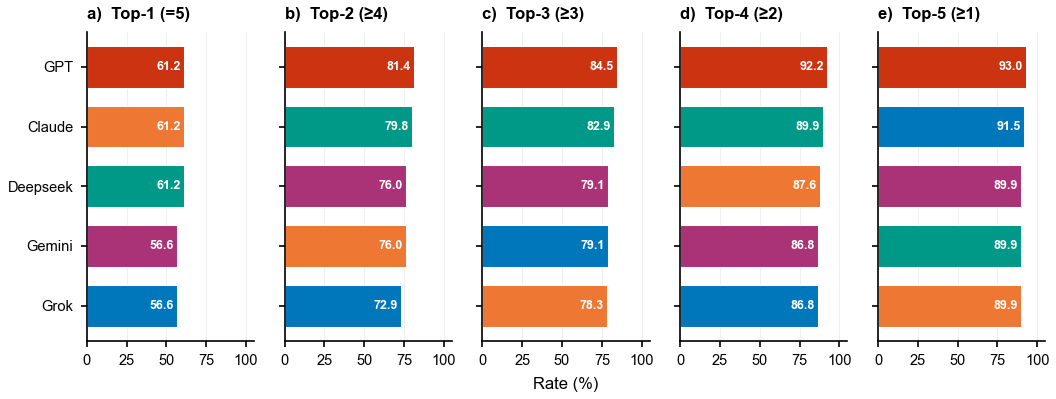


Generating grouped bar chart...
Saved: figures\topk_grouped_bars.pdf
Saved: figures\topk_grouped_bars.svg
Saved: figures\topk_grouped_bars.png


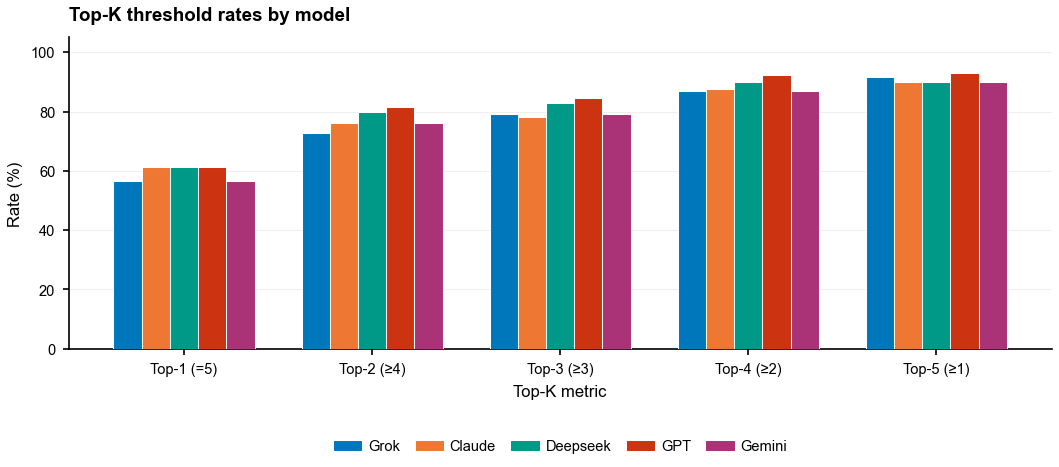


Generating line plot...
Saved: figures\topk_line_trend.pdf
Saved: figures\topk_line_trend.svg
Saved: figures\topk_line_trend.png


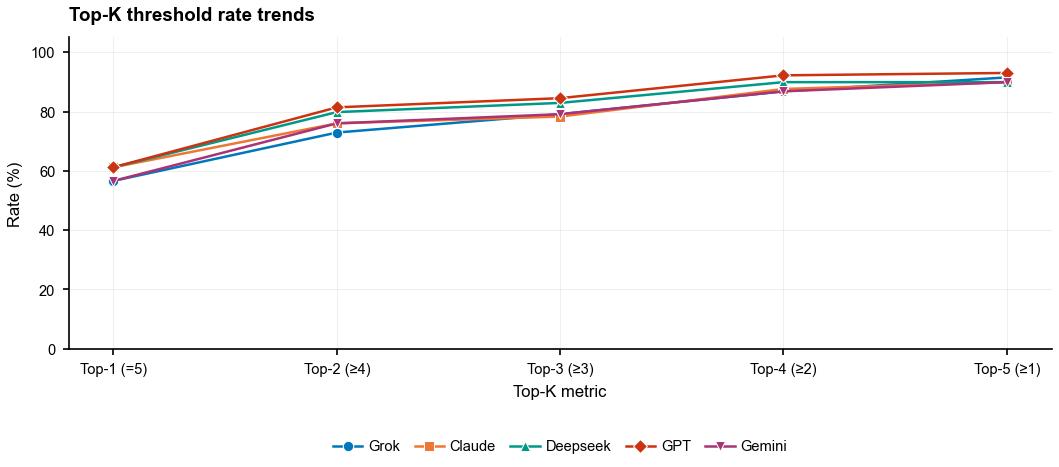


Generating combined figure...
Saved: figures\topk_combined.pdf
Saved: figures\topk_combined.svg

C:\Users\HONOR\AppData\Local\Temp\ipykernel_24668\527688801.py:518: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Saved: figures\topk_combined.png


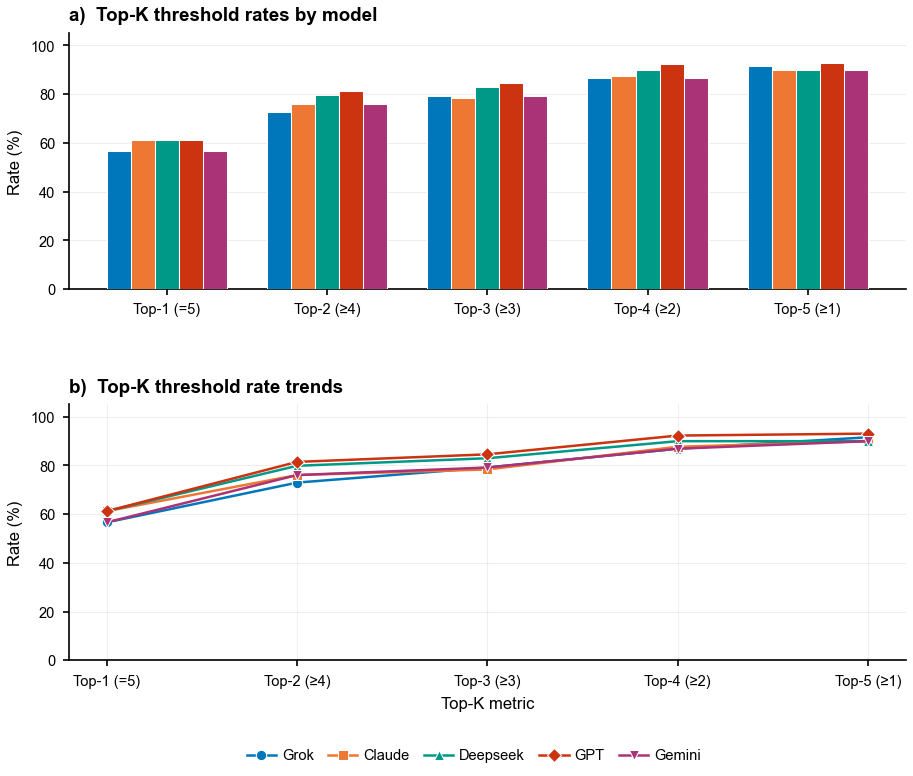


--- Exporting data ---

✓ Results exported to 'topk_analysis_results.xlsx'
✓ All figures saved to 'figures/' directory


In [7]:
"""
NPJ Digital Medicine Top-K Threshold Analysis
==============================================
Publication-ready Top-K threshold rate visualizations following NPJ/Nature journal style guidelines.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from pathlib import Path
import re

# =============================================================================
# NPJ DIGITAL MEDICINE STYLE CONFIGURATION
# =============================================================================

SINGLE_COLUMN = 3.5
ONE_AND_HALF_COLUMN = 5.0
DOUBLE_COLUMN = 7.2

NPJ_COLORS = {
    'Grok':     '#0077BB',
    'Claude':   '#EE7733',
    'Deepseek': '#009988',
    'GPT':      '#CC3311',
    'Gemini':   '#AA3377',
}

NPJ_MARKERS = {
    'Grok':     'o',
    'Claude':   's',
    'Deepseek': '^',
    'GPT':      'D',
    'Gemini':   'v',
}

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
    'font.size': 8,
    'axes.titlesize': 9,
    'axes.titleweight': 'bold',
    'axes.labelsize': 8,
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'legend.fontsize': 7,
    'legend.frameon': False,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'lines.linewidth': 1.2,
    'lines.markersize': 5,
    'grid.linewidth': 0.5,
    'grid.alpha': 0.3,
})

# =============================================================================
# USER SETTINGS
# =============================================================================

PATH = r"E:\test\sleep\Final_results.xlsx"
SHEET = "human_avg"

MODELS_WANTED = ["Grok", "Claude", "Deepseek", "GPT", "Gemini"]

# Use strict complete cases across all models?
# True  -> only rows where ALL model scores are present
# False -> rows where at least ONE model score is present
REQUIRE_COMPLETE_ACROSS_ALL_MODELS = False

# Top-K definitions (0–5 score scale)
TOPK_DEF = {
    "Top-1 (=5)": lambda s: (s == 5).mean() * 100,
    "Top-2 (≥4)": lambda s: (s >= 4).mean() * 100,
    "Top-3 (≥3)": lambda s: (s >= 3).mean() * 100,
    "Top-4 (≥2)": lambda s: (s >= 2).mean() * 100,
    "Top-5 (≥1)": lambda s: (s >= 1).mean() * 100,
}

# =============================================================================
# ROBUST NUMERIC SCORE COLUMN DETECTION (FIX)
# =============================================================================

def mostly_numeric(series: pd.Series, thresh: float = 0.7) -> bool:
    s = pd.to_numeric(series, errors="coerce")
    return (s.notna().mean() >= thresh)

def infer_score_cols_numeric(df: pd.DataFrame, models=MODELS_WANTED):
    """
    Your sheet contains both:
      - text outputs (often in *_results or model columns)
      - numeric scores (often in Grok / Claude / ...)

    We pick columns that are MOSTLY numeric to avoid text crash.
    """
    cols = list(df.columns)
    found = {}
    score_tokens = ["human", "avg", "mean", "score", "rating", "grade"]

    for m in models:
        candidates = []

        # 1) exact model name (best if numeric)
        if m in cols:
            candidates.append(m)

        # 2) <model>_results (sometimes numeric, sometimes text)
        c2 = f"{m}_results"
        if c2 in cols:
            candidates.append(c2)

        # 3) fuzzy: any column mentioning model + score tokens
        m_low = m.lower()
        for c in cols:
            c_low = str(c).lower()
            if m_low in c_low and any(tok in c_low for tok in score_tokens):
                if c not in candidates:
                    candidates.append(c)

        # choose first mostly numeric
        pick = None
        for c in candidates:
            if mostly_numeric(df[c]):
                pick = c
                break

        # fallback if nothing passes threshold: still choose model column if exists
        if pick is None and m in cols:
            pick = m
        elif pick is None and candidates:
            pick = candidates[0]

        if pick is not None:
            found[m] = pick

    models_kept = [m for m in models if m in found]
    score_cols = [found[m] for m in models_kept]
    return models_kept, score_cols, found


# =============================================================================
# DATA LOADING & COMPUTATION (FIXED)
# =============================================================================

def load_data(path=PATH, sheet=SHEET, min_models_required=3):
    df = pd.read_excel(path, sheet_name=sheet)
    df.columns = df.columns.astype(str).str.strip()

    print("=== AVAILABLE COLUMNS (human_avg) ===")
    print(df.columns.tolist())

    models_active, score_cols_active, mapping = infer_score_cols_numeric(df, MODELS_WANTED)

    print("\n[INFO] Detected score columns:")
    for m in MODELS_WANTED:
        if m in mapping:
            print(f"  {m:8s} -> {mapping[m]}")
        else:
            print(f"  {m:8s} -> NOT FOUND")

    if len(score_cols_active) < min_models_required:
        raise KeyError(
            f"Detected only {len(score_cols_active)} numeric score columns. "
            f"Need at least {min_models_required}."
        )

    # coerce to numeric
    df_scores = df.copy()
    for c in score_cols_active:
        df_scores[c] = pd.to_numeric(df_scores[c], errors="coerce")

    # filter rows
    if REQUIRE_COMPLETE_ACROSS_ALL_MODELS:
        df_scores = df_scores.dropna(subset=score_cols_active, how="any").copy()
        print(f"\n[DATA] n used (complete across all detected models): {len(df_scores)}")
    else:
        df_scores = df_scores.dropna(subset=score_cols_active, how="all").copy()
        print(f"\n[DATA] n used (at least one score present): {len(df_scores)}")

    # attach metadata for downstream
    df_scores.attrs["MODELS_ACTIVE"] = models_active
    df_scores.attrs["SCORE_COLS_ACTIVE"] = score_cols_active

    return df_scores


def compute_topk(df_scores):
    """
    Compute Top-K threshold rates for each model using detected numeric score columns.
    """
    MODELS = df_scores.attrs.get("MODELS_ACTIVE", MODELS_WANTED)
    SCORE_COLS = df_scores.attrs.get("SCORE_COLS_ACTIVE", [])

    rows = []
    for m, col in zip(MODELS, SCORE_COLS):
        s = pd.to_numeric(df_scores[col], errors="coerce").dropna()
        row = {"Model": m, "N": len(s)}
        for k, fn in TOPK_DEF.items():
            row[k] = fn(s) if len(s) else np.nan
        rows.append(row)

    topk_df = pd.DataFrame(rows).set_index("Model").round(1)
    return topk_df


# =============================================================================
# NPJ-STYLE PLOTTING FUNCTIONS
# =============================================================================

def plot_topk_horizontal_panels(topk_df, outfile=None, formats=('pdf','svg','png'), fig_width="double"):
    topk_columns = [c for c in topk_df.columns if c.startswith("Top-")]
    n_metrics = len(topk_columns)

    width_map = {"single": SINGLE_COLUMN, "1.5": ONE_AND_HALF_COLUMN, "double": DOUBLE_COLUMN}
    fig_w = width_map.get(fig_width, DOUBLE_COLUMN)
    fig_h = 2.8

    fig, axes = plt.subplots(1, n_metrics, figsize=(fig_w, fig_h))
    if n_metrics == 1:
        axes = [axes]
    plt.subplots_adjust(wspace=0.45)

    for i, metric in enumerate(topk_columns):
        ax = axes[i]
        sorted_data = topk_df[metric].sort_values()

        colors = [NPJ_COLORS.get(model, "#999999") for model in sorted_data.index]

        bars = ax.barh(
            sorted_data.index,
            sorted_data.values,
            color=colors,
            edgecolor='white',
            linewidth=0.5,
            height=0.7,
        )

        panel_label = chr(ord('a') + i)
        ax.set_title(f"{panel_label})  {metric}", loc='left', pad=6, fontweight='bold', fontsize=8)

        ax.set_xlim(0, 105)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(25))

        if i == n_metrics // 2:
            ax.set_xlabel("Rate (%)")

        for bar, val in zip(bars, sorted_data.values):
            if np.isnan(val):
                continue
            if val > 20:
                ax.text(val - 2, bar.get_y() + bar.get_height()/2, f"{val:.1f}",
                        va="center", ha="right", fontsize=6, color="white", fontweight="bold")
            else:
                ax.text(val + 2, bar.get_y() + bar.get_height()/2, f"{val:.1f}",
                        va="center", ha="left", fontsize=6, color="#333333")

        ax.grid(axis='x', linestyle='-', alpha=0.2, zorder=0)
        ax.set_axisbelow(True)

        if i > 0:
            ax.set_yticklabels([])

    plt.tight_layout()

    if outfile:
        outpath = Path(outfile)
        for fmt in formats:
            save_path = outpath.with_suffix(f'.{fmt}')
            fig.savefig(save_path, format=fmt, dpi=300 if fmt == 'png' else None,
                        transparent=False, facecolor='white')
            print(f"Saved: {save_path}")

    return fig, axes


def plot_topk_grouped_bars(topk_df, outfile=None, formats=('pdf','svg','png'),
                           title="Top-K threshold rates by model", fig_width="double", panel_label=None):
    topk_columns = [c for c in topk_df.columns if c.startswith("Top-")]
    model_names = topk_df.index.tolist()
    n_metrics = len(topk_columns)
    n_models = len(model_names)

    width_map = {"single": SINGLE_COLUMN, "1.5": ONE_AND_HALF_COLUMN, "double": DOUBLE_COLUMN}
    fig_w = width_map.get(fig_width, DOUBLE_COLUMN)
    fig_h = 3.2

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    x = np.arange(n_metrics)
    width = 0.75 / max(n_models, 1)

    for i, model in enumerate(model_names):
        offset = (i - n_models/2 + 0.5) * width
        ax.bar(
            x + offset,
            topk_df.loc[model, topk_columns],
            width,
            label=model,
            color=NPJ_COLORS.get(model, f"C{i}"),
            edgecolor='white',
            linewidth=0.5,
            zorder=3,
        )

    ax.set_xticks(x)
    ax.set_xticklabels(topk_columns)
    ax.set_ylabel("Rate (%)")
    ax.set_xlabel("Top-K metric")
    ax.set_ylim(0, 105)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))

    ax.grid(axis='y', linestyle='-', alpha=0.2, zorder=0)
    ax.set_axisbelow(True)

    ax.set_title(title, loc='left', pad=8)

    if panel_label:
        ax.text(-0.08, 1.05, panel_label, transform=ax.transAxes,
                fontsize=11, fontweight='bold', va='bottom')

    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.25),
        ncol=max(1, n_models),
        frameon=False,
        columnspacing=1.0,
        handletextpad=0.4,
    )

    plt.tight_layout()
    fig.subplots_adjust(bottom=0.25)

    if outfile:
        outpath = Path(outfile)
        for fmt in formats:
            save_path = outpath.with_suffix(f'.{fmt}')
            fig.savefig(save_path, format=fmt, dpi=300 if fmt == 'png' else None,
                        transparent=False, facecolor='white')
            print(f"Saved: {save_path}")

    return fig, ax


def plot_topk_line(topk_df, outfile=None, formats=('pdf','svg','png'),
                   title="Top-K threshold rate trends", fig_width="double", panel_label=None):
    topk_columns = [c for c in topk_df.columns if c.startswith("Top-")]
    x = np.arange(len(topk_columns))

    width_map = {"single": SINGLE_COLUMN, "1.5": ONE_AND_HALF_COLUMN, "double": DOUBLE_COLUMN}
    fig_w = width_map.get(fig_width, DOUBLE_COLUMN)
    fig_h = 3.2

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    for model in topk_df.index:
        ax.plot(
            x,
            topk_df.loc[model, topk_columns],
            marker=NPJ_MARKERS.get(model, 'o'),
            color=NPJ_COLORS.get(model, '#999999'),
            markeredgecolor='white',
            markeredgewidth=0.5,
            linewidth=1.2,
            markersize=5,
            label=model,
            zorder=3,
        )

    ax.set_xticks(x)
    ax.set_xticklabels(topk_columns)
    ax.set_ylabel("Rate (%)")
    ax.set_xlabel("Top-K metric")
    ax.set_ylim(0, 105)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))

    ax.grid(axis='both', linestyle='-', alpha=0.2, zorder=0)
    ax.set_axisbelow(True)

    ax.set_title(title, loc='left', pad=8)

    if panel_label:
        ax.text(-0.08, 1.05, panel_label, transform=ax.transAxes,
                fontsize=11, fontweight='bold', va='bottom')

    legend_handles = [
        Line2D([0], [0],
               marker=NPJ_MARKERS.get(m, 'o'),
               color=NPJ_COLORS.get(m, '#999999'),
               markeredgecolor='white',
               markeredgewidth=0.5,
               linestyle='-',
               linewidth=1.2,
               markersize=5,
               label=m)
        for m in topk_df.index
    ]

    ax.legend(
        handles=legend_handles,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.25),
        ncol=len(topk_df.index),
        frameon=False,
        columnspacing=1.0,
        handletextpad=0.4,
    )

    plt.tight_layout()
    fig.subplots_adjust(bottom=0.25)

    if outfile:
        outpath = Path(outfile)
        for fmt in formats:
            save_path = outpath.with_suffix(f'.{fmt}')
            fig.savefig(save_path, format=fmt, dpi=300 if fmt == 'png' else None,
                        transparent=False, facecolor='white')
            print(f"Saved: {save_path}")

    return fig, ax


def plot_topk_combined(topk_df, outfile=None, formats=('pdf','svg','png'), fig_width="double"):
    topk_columns = [c for c in topk_df.columns if c.startswith("Top-")]
    model_names = topk_df.index.tolist()
    x = np.arange(len(topk_columns))
    n_models = len(model_names)
    width = 0.75 / max(n_models, 1)

    width_map = {"single": SINGLE_COLUMN, "1.5": ONE_AND_HALF_COLUMN, "double": DOUBLE_COLUMN}
    fig_w = width_map.get(fig_width, DOUBLE_COLUMN)
    fig_h = 5.5

    fig, axes = plt.subplots(2, 1, figsize=(fig_w, fig_h), gridspec_kw={'hspace': 0.45})

    # Panel a: grouped bars
    ax = axes[0]
    for i, model in enumerate(model_names):
        offset = (i - n_models/2 + 0.5) * width
        ax.bar(
            x + offset,
            topk_df.loc[model, topk_columns],
            width,
            label=model,
            color=NPJ_COLORS.get(model, f"C{i}"),
            edgecolor='white',
            linewidth=0.5,
            zorder=3,
        )

    ax.set_xticks(x)
    ax.set_xticklabels(topk_columns)
    ax.set_ylabel("Rate (%)")
    ax.set_ylim(0, 105)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.grid(axis='y', linestyle='-', alpha=0.2, zorder=0)
    ax.set_axisbelow(True)
    ax.set_title("a)  Top-K threshold rates by model", loc='left', pad=6, fontweight='bold')

    # Panel b: line plot
    ax = axes[1]
    for model in model_names:
        ax.plot(
            x,
            topk_df.loc[model, topk_columns],
            marker=NPJ_MARKERS.get(model, 'o'),
            color=NPJ_COLORS.get(model, '#999999'),
            markeredgecolor='white',
            markeredgewidth=0.5,
            linewidth=1.2,
            markersize=5,
            label=model,
            zorder=3,
        )

    ax.set_xticks(x)
    ax.set_xticklabels(topk_columns)
    ax.set_ylabel("Rate (%)")
    ax.set_xlabel("Top-K metric")
    ax.set_ylim(0, 105)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.grid(axis='both', linestyle='-', alpha=0.2, zorder=0)
    ax.set_axisbelow(True)
    ax.set_title("b)  Top-K threshold rate trends", loc='left', pad=6, fontweight='bold')

    legend_handles = [
        Line2D([0], [0],
               marker=NPJ_MARKERS.get(m, 'o'),
               color=NPJ_COLORS.get(m, '#999999'),
               markeredgecolor='white',
               markeredgewidth=0.5,
               linestyle='-',
               linewidth=1.2,
               markersize=5,
               label=m)
        for m in model_names
    ]

    fig.legend(
        handles=legend_handles,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.02),
        ncol=len(model_names),
        frameon=False,
        columnspacing=1.0,
        handletextpad=0.4,
    )

    plt.tight_layout()
    fig.subplots_adjust(bottom=0.12)

    if outfile:
        outpath = Path(outfile)
        for fmt in formats:
            save_path = outpath.with_suffix(f'.{fmt}')
            fig.savefig(save_path, format=fmt, dpi=300 if fmt == 'png' else None,
                        transparent=False, facecolor='white')
            print(f"Saved: {save_path}")

    return fig, axes


# =============================================================================
# SUMMARY
# =============================================================================

def print_summary(topk_df):
    topk_columns = [c for c in topk_df.columns if c.startswith("Top-")]

    print("\n" + "="*60)
    print("TOP-K THRESHOLD RATES BY MODEL")
    print("="*60)
    print(topk_df[topk_columns])

    summary = pd.DataFrame({
        "Metric": topk_columns,
        "Best_Model": [topk_df[c].idxmax() for c in topk_columns],
        "Best_Score": [topk_df[c].max() for c in topk_columns],
        "Worst_Model": [topk_df[c].idxmin() for c in topk_columns],
        "Worst_Score": [topk_df[c].min() for c in topk_columns],
        "Difference": [topk_df[c].max() - topk_df[c].min() for c in topk_columns],
    })

    ranking_df = topk_df[topk_columns].rank(ascending=False, method="min").astype(int)
    ranking_df["Avg_Rank"] = ranking_df.mean(axis=1).round(2)
    ranking_df = ranking_df.sort_values("Avg_Rank")

    print("\n" + "="*60)
    print("BEST & WORST MODEL PER TOP-K")
    print("="*60)
    print(summary.to_string(index=False))

    print("\n" + "="*60)
    print("OVERALL RANKING (by Average Rank)")
    print("="*60)
    print(ranking_df)

    return summary, ranking_df


# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":

    outdir = Path("figures")
    outdir.mkdir(exist_ok=True)

    df_scores = load_data()
    topk_df = compute_topk(df_scores)

    summary, ranking_df = print_summary(topk_df)

    print("\n--- Generating NPJ-style figures ---")

    print("\nGenerating horizontal panel figure...")
    plot_topk_horizontal_panels(topk_df, outfile=outdir / "topk_horizontal_panels")
    plt.show()

    print("\nGenerating grouped bar chart...")
    plot_topk_grouped_bars(topk_df, outfile=outdir / "topk_grouped_bars",
                           title="Top-K threshold rates by model")
    plt.show()

    print("\nGenerating line plot...")
    plot_topk_line(topk_df, outfile=outdir / "topk_line_trend",
                   title="Top-K threshold rate trends")
    plt.show()

    print("\nGenerating combined figure...")
    plot_topk_combined(topk_df, outfile=outdir / "topk_combined")
    plt.show()

    print("\n--- Exporting data ---")
    with pd.ExcelWriter("topk_analysis_results.xlsx") as writer:
        topk_df.to_excel(writer, sheet_name="TopK_Rates")
        summary.to_excel(writer, sheet_name="BestWorst_Summary", index=False)
        ranking_df.to_excel(writer, sheet_name="Rankings")

    print("\n✓ Results exported to 'topk_analysis_results.xlsx'")
    print("✓ All figures saved to 'figures/' directory")


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
from itertools import combinations
from pathlib import Path
import difflib

try:
    import seaborn as sns
    HAVE_SEABORN = True
except ImportError:
    HAVE_SEABORN = False

SINGLE_COLUMN = 3.5
ONE_AND_HALF_COLUMN = 5.0
DOUBLE_COLUMN = 7.2

NPJ_COLORS = {
    'Grok':     '#0077BB',
    'Claude':   '#EE7733',
    'Deepseek': '#009988',
    'GPT':      '#CC3311',
    'Gemini':   '#AA3377',
}

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
    'font.size': 8,
    'axes.titlesize': 9,
    'axes.titleweight': 'bold',
    'axes.labelsize': 8,
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'legend.frameon': False,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.3,
})

PATH = r"E:\test\sleep\Final_results.xlsx"
SHEET = "human_avg"

MODELS = ["Grok", "Claude", "Deepseek", "GPT", "Gemini"]

MODEL_DISPLAY = {
    "Grok": "Grok",
    "Claude": "Claude",
    "Deepseek": "DeepSeek",
    "GPT": "GPT-4",
    "Gemini": "Gemini",
}

STRATIFICATION_COLS = {
    "Domain": "Clinical specialty",
    "Status": "Status",
    "Book": "Book",
    "Publisher": "Publisher",
}


def _normalize_cols(cols):
    return [str(c).strip() for c in cols]


def _numeric_coverage(df, col):
    """How many numeric (non-NaN) after coercion."""
    s = pd.to_numeric(df[col], errors="coerce")
    return int(s.notna().sum())


def detect_score_columns(df, models=MODELS):
    """
    Detect score columns. If multiple candidates exist, choose the one with
    highest numeric coverage.
    """
    cols = _normalize_cols(df.columns)
    col_set = set(cols)

    score_map = {}
    for m in models:
        candidates = [f"{m}_human_avg", f"{m}_results", m]
        existing = [c for c in candidates if c in col_set]

        # fuzzy fallback
        if not existing:
            best = difflib.get_close_matches(m, cols, n=3, cutoff=0.75)
            existing = best[:1] if best else []

        if not existing:
            continue

        # choose by numeric coverage
        best_col = max(existing, key=lambda c: _numeric_coverage(df, c))
        score_map[m] = best_col

    return score_map


def load_data(path=PATH, sheet=SHEET, min_any_score=1):
    df = pd.read_excel(path, sheet_name=sheet)
    df.columns = df.columns.astype(str).str.strip()

    print("=== AVAILABLE COLUMNS (human_avg) ===")
    print(df.columns.tolist())

    score_map = detect_score_columns(df, MODELS)
    if not score_map:
        raise KeyError("No score columns detected for any model. Check your sheet.")

    print("\n[INFO] Detected score columns (auto-selected by numeric coverage):")
    for m in MODELS:
        if m in score_map:
            col = score_map[m]
            cov = _numeric_coverage(df, col)
            pct = cov / max(1, len(df)) * 100
            print(f"  {m:<8} -> {col:<20} | numeric={cov}/{len(df)} ({pct:.1f}%)")
        else:
            print(f"  {m:<8} -> (NOT FOUND)")

    # convert to numeric
    for m, col in score_map.items():
        df[col] = pd.to_numeric(df[col], errors="coerce")

    detected_cols = [score_map[m] for m in score_map.keys()]

    non_na_count = df[detected_cols].notna().sum(axis=1)
    df_any = df.loc[non_na_count >= min_any_score].copy()
    print(f"\nTotal rows with at least one score: {len(df_any)}")

    df_complete = df_any.dropna(subset=detected_cols).copy()
    print(f"Complete rows across detected models: {len(df_complete)}")

    return df_any, df_complete, score_map


def bootstrap_ci(x, n_boot=5000, alpha=0.05, seed=42):
    x = pd.to_numeric(pd.Series(x), errors="coerce").dropna().to_numpy()
    if x.size < 2:
        return np.nan, np.nan, np.nan, np.nan

    mean = float(np.mean(x))
    std = float(np.std(x, ddof=1))

    rng = np.random.default_rng(seed)
    boot = rng.choice(x, size=(n_boot, x.size), replace=True).mean(axis=1)
    ci_low = float(np.percentile(boot, 100 * alpha / 2))
    ci_high = float(np.percentile(boot, 100 * (1 - alpha / 2)))
    return mean, ci_low, ci_high, std


def analyze_subgroup_performance(df, group_col, score_map, min_cases=5):
    if group_col not in df.columns:
        print(f"Warning: Column '{group_col}' not found in data.")
        return None

    group_counts = df[group_col].value_counts(dropna=True)
    valid_groups = group_counts[group_counts >= min_cases].index.tolist()
    if not valid_groups:
        print(f"Warning: No subgroups with >= {min_cases} cases for '{group_col}'")
        return None

    df_f = df[df[group_col].isin(valid_groups)].copy()
    results = []

    for g in valid_groups:
        gdata = df_f[df_f[group_col] == g]
        n_group = len(gdata)

        for model in MODELS:
            if model not in score_map:
                continue
            col = score_map[model]
            scores = pd.to_numeric(gdata[col], errors="coerce").dropna()
            if len(scores) < 2:
                continue

            mean, ci_low, ci_high, std = bootstrap_ci(scores)
            top1_pct = float((scores == 5).mean() * 100)
            failure_pct = float((scores == 0).mean() * 100)

            results.append({
                "Subgroup": g,
                "n": n_group,
                "Model": MODEL_DISPLAY[model],
                "Mean": mean,
                "CI_low": ci_low,
                "CI_high": ci_high,
                "SD": std,
                "Top-1 (%)": top1_pct,
                "Failure (%)": failure_pct,
            })

    return pd.DataFrame(results)


def create_subgroup_summary_table(subgroup_df):
    if subgroup_df is None or len(subgroup_df) == 0:
        return None
    summary = subgroup_df.pivot(index="Subgroup", columns="Model", values="Mean")
    n_per = subgroup_df.groupby("Subgroup")["n"].first()
    summary.insert(0, "n", n_per)
    summary = summary.sort_values("n", ascending=False)
    ordered_cols = ["n"] + [MODEL_DISPLAY[m] for m in MODELS if MODEL_DISPLAY[m] in summary.columns]
    return summary[ordered_cols]


def compare_subgroups_kruskal(df, group_col, score_map, min_cases=5):
    if group_col not in df.columns:
        return None

    group_counts = df[group_col].value_counts(dropna=True)
    valid_groups = group_counts[group_counts >= min_cases].index.tolist()
    if len(valid_groups) < 2:
        print(f"Need at least 2 subgroups with >= {min_cases} cases.")
        return None

    df_f = df[df[group_col].isin(valid_groups)].copy()
    rows = []

    for model in MODELS:
        if model not in score_map:
            continue
        col = score_map[model]

        groups = []
        for g in valid_groups:
            arr = pd.to_numeric(df_f.loc[df_f[group_col] == g, col], errors="coerce").dropna().values
            if len(arr) > 0:
                groups.append(arr)

        if len(groups) < 2:
            continue

        stat, p = stats.kruskal(*groups)
        n_total = sum(len(a) for a in groups)
        k = len(groups)
        eta_sq = (stat - k + 1) / (n_total - k) if (n_total - k) > 0 else 0.0
        eta_sq = max(0.0, float(eta_sq))

        rows.append({
            "Model": MODEL_DISPLAY[model],
            "H-statistic": float(stat),
            "p-value": float(p),
            "eta_sq": eta_sq,
            "Significant": "Yes" if p < 0.05 else "No",
            "n_groups": k,
        })

    return pd.DataFrame(rows)


def analyze_topk_by_subgroup(df, group_col, score_map, min_cases=5):
    if group_col not in df.columns:
        return None, None

    group_counts = df[group_col].value_counts(dropna=True)
    valid_groups = group_counts[group_counts >= min_cases].index.tolist()
    if not valid_groups:
        return None, None

    df_f = df[df[group_col].isin(valid_groups)].copy()
    top1_rows, fail_rows = [], []

    for g in valid_groups:
        gdata = df_f[df_f[group_col] == g]
        n = len(gdata)
        top1 = {"Subgroup": g, "n": n}
        fail = {"Subgroup": g, "n": n}

        for m in MODELS:
            disp = MODEL_DISPLAY[m]
            if m not in score_map:
                continue
            col = score_map[m]
            s = pd.to_numeric(gdata[col], errors="coerce").dropna()
            top1[disp] = float((s == 5).mean() * 100) if len(s) else np.nan
            fail[disp] = float((s == 0).mean() * 100) if len(s) else np.nan

        top1_rows.append(top1)
        fail_rows.append(fail)

    return (
        pd.DataFrame(top1_rows).sort_values("n", ascending=False),
        pd.DataFrame(fail_rows).sort_values("n", ascending=False),
    )


def analyze_model_subgroup_interaction(df, group_col, score_map, min_cases=5):
    if group_col not in df.columns:
        return None

    group_counts = df[group_col].value_counts(dropna=True)
    valid_groups = group_counts[group_counts >= min_cases].index.tolist()
    if len(valid_groups) < 2:
        return None

    used_models = [m for m in MODELS if m in score_map]
    if len(used_models) < 2:
        return None

    df_f = df[df[group_col].isin(valid_groups)].copy()
    mat = []
    for g in valid_groups:
        gdata = df_f[df_f[group_col] == g]
        row = [float(pd.to_numeric(gdata[score_map[m]], errors="coerce").mean()) for m in used_models]
        mat.append(row)

    mat = np.array(mat, dtype=float)
    mat = mat[~np.isnan(mat).any(axis=1)]
    n_groups, k = mat.shape
    if n_groups < 2 or k < 2:
        return None

    stat, p = stats.friedmanchisquare(*mat.T)
    W = float(stat / (n_groups * (k - 1))) if (n_groups * (k - 1)) > 0 else np.nan

    return {
        "Test": "Friedman",
        "chi2": float(stat),
        "p_value": float(p),
        "Kendalls_W": float(W),
        "n_subgroups": int(n_groups),
        "n_models": int(k),
        "Models_used": [MODEL_DISPLAY[m] for m in used_models],
        "Significant": "Yes" if p < 0.05 else "No",
    }


def run_subgroup_analysis(df, group_col, group_name, score_map, min_cases=5, outdir=None):
    print("\n" + "#" * 80)
    print(f"# SUBGROUP ANALYSIS: {group_name.upper()}")
    print("#" * 80)

    if group_col not in df.columns:
        print(f"Column '{group_col}' not found in data. Skipping.")
        return None

    print("\nUnique values (top 30):")
    print(df[group_col].value_counts(dropna=True).head(30))

    subgroup_df = analyze_subgroup_performance(df, group_col, score_map, min_cases)
    kruskal_df = compare_subgroups_kruskal(df, group_col, score_map, min_cases)
    top1_df, failure_df = analyze_topk_by_subgroup(df, group_col, score_map, min_cases)
    interaction = analyze_model_subgroup_interaction(df, group_col, score_map, min_cases)

    if interaction:
        print(f"\n--- Model × {group_name} Interaction (Friedman Test) ---")
        print(
            f"chi2 = {interaction['chi2']:.2f}, "
            f"p = {interaction['p_value']:.4f}, "
            f"W = {interaction['Kendalls_W']:.3f}"
        )
        print(f"Models used: {', '.join(interaction['Models_used'])}")

    return {
        "subgroup_df": subgroup_df,
        "kruskal_df": kruskal_df,
        "top1_df": top1_df,
        "failure_df": failure_df,
        "interaction": interaction,
    }


def export_subgroup_results(results_dict, filename="subgroup_analysis_results.xlsx"):
    with pd.ExcelWriter(filename) as writer:
        for group_name, results in results_dict.items():
            if results is None:
                continue
            prefix = group_name[:20].replace(" ", "_")

            if results["subgroup_df"] is not None and len(results["subgroup_df"]) > 0:
                results["subgroup_df"].to_excel(writer, sheet_name=f"{prefix}_Perf", index=False)
            if results["kruskal_df"] is not None and len(results["kruskal_df"]) > 0:
                results["kruskal_df"].to_excel(writer, sheet_name=f"{prefix}_Kruskal", index=False)
            if results["top1_df"] is not None and len(results["top1_df"]) > 0:
                results["top1_df"].to_excel(writer, sheet_name=f"{prefix}_Top1", index=False)
            if results["failure_df"] is not None and len(results["failure_df"]) > 0:
                results["failure_df"].to_excel(writer, sheet_name=f"{prefix}_Failure", index=False)

    print(f"\n✓ Results exported to '{filename}'")


if __name__ == "__main__":
    outdir = Path("figures")
    outdir.mkdir(exist_ok=True)

    print("Loading data...")
    df_any, df_complete, score_map = load_data(PATH, SHEET)

    all_results = {}
    for name, col in STRATIFICATION_COLS.items():
        all_results[name] = run_subgroup_analysis(
            df_complete,
            group_col=col,
            group_name=name,
            score_map=score_map,
            min_cases=5,
            outdir=outdir,
        )

    export_subgroup_results(all_results, filename="subgroup_analysis_results.xlsx")
    print("\nDONE.")


Loading data...
=== AVAILABLE COLUMNS (human_avg) ===
['Publisher', 'Book', 'Publically avalibale', 'Status', 'Clinical specialty', 'Disease diagnosis', 'Differential Diagnosis', 'Patient Text', 'Truth Disease diagnosis', 'Grok_results', 'Claude_results', 'Deepseek_results', 'GPT_results', 'Gemini_results', 'Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']

[INFO] Detected score columns (auto-selected by numeric coverage):
  Grok     -> Grok                 | numeric=129/129 (100.0%)
  Claude   -> Claude               | numeric=129/129 (100.0%)
  Deepseek -> Deepseek             | numeric=129/129 (100.0%)
  GPT      -> GPT                  | numeric=129/129 (100.0%)
  Gemini   -> Gemini               | numeric=129/129 (100.0%)

Total rows with at least one score: 129
Complete rows across detected models: 129

################################################################################
# SUBGROUP ANALYSIS: DOMAIN
#########################################################################

In [13]:
"""
Pairwise Wilcoxon Signed-Rank Tests with Holm Correction (FIXED)
===============================================================
Generates Table 3 (NPJ Digital Medicine style).

Fixes included:
1) Robust score-column detection for your sheet (Grok_results / GPT_results / Grok / Claude / etc.)
2) Converts detected score columns to numeric BEFORE testing
3) Uses complete-case rows across detected models (paired comparisons valid)
4) Safe Wilcoxon handling of all-zero diffs / ties
"""

import pandas as pd
import numpy as np
from scipy import stats
from itertools import combinations
import difflib

# =============================================================================
# SETTINGS
# =============================================================================

PATH = r"E:\test\sleep\Final_results.xlsx"
SHEET = "human_avg"

MODELS = ["Grok", "Claude", "Deepseek", "GPT", "Gemini"]

MODEL_DISPLAY = {
    "Grok": "Grok",
    "Claude": "Claude",
    "Deepseek": "DeepSeek",
    "GPT": "GPT-4",
    "Gemini": "Gemini",
}

# =============================================================================
# SCORE COLUMN DETECTION (matches your real sheet)
# =============================================================================

def _normalize_cols(cols):
    return [str(c).strip() for c in cols]

def _numeric_coverage(df, col):
    s = pd.to_numeric(df[col], errors="coerce")
    return int(s.notna().sum())

def detect_score_columns(df, models=MODELS):
    """
    Priority:
      1) {model}_human_avg
      2) {model}_results
      3) {model}
    If multiple exist, choose the one with highest numeric coverage.
    """
    cols = _normalize_cols(df.columns)
    col_set = set(cols)
    score_map = {}

    for m in models:
        candidates = [f"{m}_human_avg", f"{m}_results", m]
        existing = [c for c in candidates if c in col_set]

        if not existing:
            # fuzzy fallback (rare)
            best = difflib.get_close_matches(m, cols, n=3, cutoff=0.75)
            existing = best[:1] if best else []

        if not existing:
            continue

        best_col = max(existing, key=lambda c: _numeric_coverage(df, c))
        score_map[m] = best_col

    return score_map


# =============================================================================
# LOAD DATA
# =============================================================================

def load_data(path=PATH, sheet=SHEET):
    df = pd.read_excel(path, sheet_name=sheet)
    df.columns = df.columns.astype(str).str.strip()

    score_map = detect_score_columns(df, MODELS)
    if not score_map:
        raise KeyError("No score columns detected. Please check your Excel sheet.")

    print("=== Detected score columns (auto-selected by numeric coverage) ===")
    for m in MODELS:
        if m in score_map:
            col = score_map[m]
            cov = _numeric_coverage(df, col)
            print(f"  {m:<8} -> {col:<20} | numeric={cov}/{len(df)} ({cov/max(1,len(df))*100:.1f}%)")
        else:
            print(f"  {m:<8} -> (NOT FOUND)")

    # Convert detected columns to numeric
    for m, col in score_map.items():
        df[col] = pd.to_numeric(df[col], errors="coerce")

    used_models = [m for m in MODELS if m in score_map]
    used_cols = [score_map[m] for m in used_models]

    # Complete-case across detected models (required for Friedman and fair pairwise)
    df_complete = df.dropna(subset=used_cols).copy()
    print(f"\nComplete cases across detected models: {len(df_complete)}")

    return df_complete, score_map, used_models


# =============================================================================
# EFFECT SIZE: rank-biserial correlation for paired Wilcoxon
# =============================================================================

def rank_biserial_correlation(x, y):
    """
    Rank-biserial correlation for paired data (Wilcoxon effect size).
    Positive r: x tends to be higher than y (model1 better).
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    diff = x - y
    diff = diff[diff != 0]  # remove ties at zero
    if diff.size == 0:
        return 0.0

    ranks = stats.rankdata(np.abs(diff))
    pos = ranks[diff > 0].sum()
    neg = ranks[diff < 0].sum()
    denom = ranks.sum()
    if denom == 0:
        return 0.0
    return float((pos - neg) / denom)


# =============================================================================
# HOLM CORRECTION
# =============================================================================

def holm_correction(p_values):
    p_values = np.asarray(p_values, dtype=float)
    n = len(p_values)
    order = np.argsort(p_values)
    adjusted = np.empty(n, dtype=float)

    cummax = 0.0
    for i, idx in enumerate(order):
        adj = p_values[idx] * (n - i)
        cummax = max(cummax, adj)
        adjusted[idx] = min(cummax, 1.0)

    return adjusted


# =============================================================================
# TESTS
# =============================================================================

def calculate_friedman_test(df_complete, score_map, used_models):
    cols = [score_map[m] for m in used_models]
    scores = df_complete[cols].to_numpy(dtype=float)

    stat, p_value = stats.friedmanchisquare(*[scores[:, i] for i in range(scores.shape[1])])

    n = scores.shape[0]
    k = scores.shape[1]
    kendalls_w = float(stat / (n * (k - 1))) if (n * (k - 1)) > 0 else np.nan

    ranks = np.apply_along_axis(stats.rankdata, 1, scores)
    mean_ranks = ranks.mean(axis=0)

    print("\n" + "="*80)
    print("FRIEDMAN TEST: Global comparison across all models")
    print("="*80)
    print(f"\nchi2 = {stat:.2f}, df = {k-1}, p = {p_value:.4g}")
    print(f"Kendall's W = {kendalls_w:.3f}")

    print("\nMean Ranks (lower = better):")
    for i, m in enumerate(used_models):
        print(f"  {MODEL_DISPLAY[m]}: {mean_ranks[i]:.2f}")

    return stat, p_value, kendalls_w, mean_ranks


def calculate_pairwise_wilcoxon(df_complete, score_map, used_models):
    results = []
    for m1, m2 in combinations(used_models, 2):
        c1, c2 = score_map[m1], score_map[m2]

        x = df_complete[c1].to_numpy(dtype=float)
        y = df_complete[c2].to_numpy(dtype=float)
        n_pairs = len(x)

        # Wilcoxon signed-rank test (paired)
        # If all diffs are zero, wilcoxon raises ValueError -> p=1
        try:
            stat, p_raw = stats.wilcoxon(
                x, y,
                alternative="two-sided",
                zero_method="wilcox"  # ignores zero diffs
            )
        except ValueError:
            stat, p_raw = np.nan, 1.0

        effect_r = rank_biserial_correlation(x, y)
        mean1, mean2 = float(np.mean(x)), float(np.mean(y))

        results.append({
            "Model1": m1,
            "Model2": m2,
            "Comparison": f"{MODEL_DISPLAY[m1]} vs {MODEL_DISPLAY[m2]}",
            "n": n_pairs,
            "Mean1": mean1,
            "Mean2": mean2,
            "p_raw": float(p_raw),
            "Effect_r": float(effect_r),
        })

    df_res = pd.DataFrame(results)
    df_res["p_Holm"] = holm_correction(df_res["p_raw"].values)
    df_res["Significant"] = df_res["p_Holm"].apply(lambda p: "Yes" if p < 0.05 else "No")
    df_res = df_res.sort_values("p_raw").reset_index(drop=True)
    return df_res


# =============================================================================
# OUTPUT FORMATTING
# =============================================================================

def print_table3(df_results):
    print("\n" + "="*80)
    print("TABLE 3: Pairwise model comparisons (Wilcoxon signed-rank) with Holm correction")
    print("="*80)

    header = f"{'Comparison':<28} {'n':<6} {'p_raw':<12} {'p_Holm':<12} {'Sig':<5} {'Effect (r)':<12}"
    print("\n" + header)
    print("-"*80)

    for _, row in df_results.iterrows():
        p_raw = row["p_raw"]
        p_holm = row["p_Holm"]
        p_raw_str = f"{p_raw:.3f}" if p_raw >= 0.001 else f"{p_raw:.2e}"
        p_holm_str = f"{p_holm:.3f}" if p_holm >= 0.001 else f"{p_holm:.2e}"
        eff_str = f"{row['Effect_r']:+.3f}"
        print(f"{row['Comparison']:<28} {int(row['n']):<6} {p_raw_str:<12} {p_holm_str:<12} {row['Significant']:<5} {eff_str:<12}")

    n_sig = int((df_results["Significant"] == "Yes").sum())
    print(f"\nSignificant comparisons after Holm correction: {n_sig} / {len(df_results)}")
    print("Effect size r = rank-biserial correlation; positive means first model higher.")


def print_latex_table(df_results):
    print("\n" + "="*80)
    print("LATEX TABLE (copy into NPJ/Nature manuscript)")
    print("="*80 + "\n")

    print(r"\begin{table}[htbp]")
    print(r"\centering")
    print(r"\caption{Pairwise model comparisons using Wilcoxon signed-rank tests with Holm correction.}")
    print(r"\label{tab:pairwise_wilcoxon}")
    print(r"\small")
    print(r"\begin{tabular}{@{}lccccc@{}}")
    print(r"\toprule")
    print(r"\textbf{Comparison} & \textbf{n} & \textbf{p\textsubscript{raw}} & \textbf{p\textsubscript{Holm}} & \textbf{Sig.} & \textbf{Effect (r)} \\")
    print(r"\midrule")

    for _, row in df_results.iterrows():
        p_raw = row["p_raw"]
        p_holm = row["p_Holm"]
        p_raw_str = f"{p_raw:.3f}" if p_raw >= 0.001 else f"{p_raw:.2e}"
        p_holm_str = f"{p_holm:.3f}" if p_holm >= 0.001 else f"{p_holm:.2e}"

        eff = row["Effect_r"]
        eff_str = f"{eff:.3f}"
        if eff < 0:
            eff_str = f"--{abs(eff):.3f}"

        print(f"{row['Comparison']} & {int(row['n'])} & {p_raw_str} & {p_holm_str} & {row['Significant']} & {eff_str} \\\\")
    print(r"\bottomrule")
    print(r"\end{tabular}")
    print(r"\begin{flushleft}")
    print(r"\small{Effect size $r$ is rank-biserial correlation; positive values indicate the first model scored higher.}")
    print(r"\end{flushleft}")
    print(r"\end{table}")


# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":
    print("Loading data...")
    df_complete, score_map, used_models = load_data(PATH, SHEET)

    # Friedman
    fried_stat, fried_p, W, mean_ranks = calculate_friedman_test(df_complete, score_map, used_models)

    # Pairwise Wilcoxon
    print("\nCalculating pairwise Wilcoxon tests...")
    pairwise_df = calculate_pairwise_wilcoxon(df_complete, score_map, used_models)

    # Print Table 3 + LaTeX
    print_table3(pairwise_df)
    print_latex_table(pairwise_df)

    # Export
    out_xlsx = "pairwise_wilcoxon_results.xlsx"
    pairwise_df.to_excel(out_xlsx, index=False)
    print(f"\n✓ Results exported to '{out_xlsx}'")


Loading data...
=== Detected score columns (auto-selected by numeric coverage) ===
  Grok     -> Grok                 | numeric=129/129 (100.0%)
  Claude   -> Claude               | numeric=129/129 (100.0%)
  Deepseek -> Deepseek             | numeric=129/129 (100.0%)
  GPT      -> GPT                  | numeric=129/129 (100.0%)
  Gemini   -> Gemini               | numeric=129/129 (100.0%)

Complete cases across detected models: 129

FRIEDMAN TEST: Global comparison across all models

chi2 = 7.34, df = 4, p = 0.119
Kendall's W = 0.014

Mean Ranks (lower = better):
  Grok: 2.83
  Claude: 2.96
  DeepSeek: 3.07
  GPT-4: 3.15
  Gemini: 2.99

Calculating pairwise Wilcoxon tests...

TABLE 3: Pairwise model comparisons (Wilcoxon signed-rank) with Holm correction

Comparison                   n      p_raw        p_Holm       Sig   Effect (r)  
--------------------------------------------------------------------------------
Grok vs GPT-4                129    0.002        0.024        Yes   -0.

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality plot parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Load data from Excel file
file_path = r"E:\test\sleep\Final_results.xlsx"

human1 = pd.read_excel(file_path, sheet_name="human1")
human2 = pd.read_excel(file_path, sheet_name="human2")
info = pd.read_excel(file_path, sheet_name="Info")

print("Data loaded successfully!")
print(f"Human1 shape: {human1.shape}")
print(f"Human2 shape: {human2.shape}")
print(f"Info shape: {info.shape}")
print(f"\nColumns in human1: {list(human1.columns)}")

Data loaded successfully!
Human1 shape: (129, 14)
Human2 shape: (129, 12)
Info shape: (129, 14)

Columns in human1: ['Unnamed: 0', 'Age', 'Gender', 'Truth Disease diagnosis', 'Grok_results', 'Claude_results', 'Deepseek_results', 'GPT_results', 'Gemini_results', 'Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']


In [16]:
# Define model column mappings for human1 and human2
model_columns = {
    "Grok": ("Grok", "Grok"),
    "Claude": ("Claude", "Claude"),
    "Deepseek": ("Deepseek", "Deepseek"),
    "GPT": ("GPT", "GPT"),
    "Gemini": ("Gemini", "Gemini"),
}

model_names = list(model_columns.keys())
print(f"Models to analyze: {model_names}")

Models to analyze: ['Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']


In [17]:
# Calculate overall Cohen's Kappa across all models
all_h1 = []
all_h2 = []

for model, (col_h1, col_h2) in model_columns.items():
    valid = human1[col_h1].notna() & human2[col_h2].notna()
    all_h1.extend(human1.loc[valid, col_h1])
    all_h2.extend(human2.loc[valid, col_h2])

overall_kappa = cohen_kappa_score(
    all_h1,
    all_h2,
    weights="quadratic"
)

print("\n" + "=" * 60)
print("OVERALL COHEN'S KAPPA (All Models Combined)")
print("=" * 60)
print(f"Overall κ = {overall_kappa:.4f} (n = {len(all_h1)} total ratings)")
print("=" * 60)


OVERALL COHEN'S KAPPA (All Models Combined)
Overall κ = 0.6349 (n = 645 total ratings)


In [19]:
# Create averaged scores (mean of human1 and human2)
human_avg = info.copy()  # Start with Info sheet to keep metadata

# Calculate average scores for each model
for model, (col_h1, col_h2) in model_columns.items():
    human_avg[model] = (human1[col_h1] + human2[col_h2]) / 2

print("\n" + "=" * 60)
print("AVERAGED SCORES COMPUTED")
print("=" * 60)
print(f"human_avg shape: {human_avg.shape}")
print(f"Columns in human_avg: {list(human_avg.columns)}")

# Save back to the same Excel file with human_avg sheet
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    human_avg.to_excel(writer, sheet_name='human_avg', index=False)

print("\n✓ 'human_avg' sheet successfully saved to Excel file!")
print("=" * 60)


AVERAGED SCORES COMPUTED
human_avg shape: (129, 19)
Columns in human_avg: ['Publisher', 'Book', 'Publically avalibale', 'Status', 'Clinical specialty', 'Disease diagnosis', 'Differential Diagnosis', 'Patient Text', 'Truth Disease diagnosis', 'Grok_results', 'Claude_results', 'Deepseek_results', 'GPT_results', 'Gemini_results', 'Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini']

✓ 'human_avg' sheet successfully saved to Excel file!


In [20]:
# Calculate basic statistics for each model using averaged scores
print("\n" + "=" * 80)
print("BASIC STATISTICS - AVERAGED SCORES (human_avg)")
print("=" * 80)

stats_summary = []

for model in model_names:
    scores = human_avg[model].dropna()
    
    stats_dict = {
        'Model': model,
        'N': len(scores),
        'Mean': scores.mean(),
        'Median': scores.median(),
        'Std': scores.std(),
        'Min': scores.min(),
        'Max': scores.max(),
        'Q1': scores.quantile(0.25),
        'Q3': scores.quantile(0.75)
    }
    stats_summary.append(stats_dict)

stats_df = pd.DataFrame(stats_summary)
print(stats_df.to_string(index=False))
print("=" * 80)


BASIC STATISTICS - AVERAGED SCORES (human_avg)
   Model   N     Mean  Median      Std  Min  Max  Q1  Q3
    Grok 129 3.945736     5.0 1.612016  0.0  5.0 3.5 5.0
  Claude 129 4.031008     5.0 1.633095  0.0  5.0 4.0 5.0
Deepseek 129 4.143411     5.0 1.546409  0.0  5.0 4.0 5.0
     GPT 129 4.217054     5.0 1.419514  0.0  5.0 4.0 5.0
  Gemini 129 3.984496     5.0 1.621316  0.0  5.0 4.0 5.0


In [21]:
# Calculate basic statistics for each model using averaged scores
print("\n" + "=" * 80)
print("BASIC STATISTICS - AVERAGED SCORES (human_avg)")
print("=" * 80)

stats_summary = []

for model in model_names:
    scores = human_avg[model].dropna()
    
    stats_dict = {
        'Model': model,
        'N': len(scores),
        'Mean': scores.mean(),
        'Median': scores.median(),
        'Std': scores.std(),
        'Min': scores.min(),
        'Max': scores.max(),
        'Q1': scores.quantile(0.25),
        'Q3': scores.quantile(0.75)
    }
    stats_summary.append(stats_dict)

stats_df = pd.DataFrame(stats_summary)
print(stats_df.to_string(index=False))
print("=" * 80)


BASIC STATISTICS - AVERAGED SCORES (human_avg)
   Model   N     Mean  Median      Std  Min  Max  Q1  Q3
    Grok 129 3.945736     5.0 1.612016  0.0  5.0 3.5 5.0
  Claude 129 4.031008     5.0 1.633095  0.0  5.0 4.0 5.0
Deepseek 129 4.143411     5.0 1.546409  0.0  5.0 4.0 5.0
     GPT 129 4.217054     5.0 1.419514  0.0  5.0 4.0 5.0
  Gemini 129 3.984496     5.0 1.621316  0.0  5.0 4.0 5.0


In [22]:
# Calculate Top-K accuracy for each model
print("\n" + "=" * 80)
print("TOP-K ACCURACY ANALYSIS")
print("=" * 80)

topk_results = []

for model in model_names:
    scores = human_avg[model].dropna()
    n_total = len(scores)
    
    # Top-1: Score = 5
    top1 = (scores == 5).sum()
    top1_pct = (top1 / n_total) * 100
    
    # Top-3: Score >= 3
    top3 = (scores >= 3).sum()
    top3_pct = (top3 / n_total) * 100
    
    # Top-5: Score >= 1
    top5 = (scores >= 1).sum()
    top5_pct = (top5 / n_total) * 100
    
    topk_results.append({
        'Model': model,
        'Top-1 (Score=5)': top1,
        'Top-1 %': top1_pct,
        'Top-3 (Score>=3)': top3,
        'Top-3 %': top3_pct,
        'Top-5 (Score>=1)': top5,
        'Top-5 %': top5_pct
    })

topk_df = pd.DataFrame(topk_results)
print(topk_df.to_string(index=False))
print("=" * 80)


TOP-K ACCURACY ANALYSIS
   Model  Top-1 (Score=5)   Top-1 %  Top-3 (Score>=3)   Top-3 %  Top-5 (Score>=1)   Top-5 %
    Grok               73 56.589147               102 79.069767               118 91.472868
  Claude               79 61.240310               101 78.294574               116 89.922481
Deepseek               79 61.240310               107 82.945736               116 89.922481
     GPT               79 61.240310               109 84.496124               120 93.023256
  Gemini               73 56.589147               102 79.069767               116 89.922481


In [23]:
# Calculate failure rates (Score = 0) for each model
print("\n" + "=" * 80)
print("FAILURE RATE ANALYSIS (Score = 0)")
print("=" * 80)

failure_results = []

for model in model_names:
    scores = human_avg[model].dropna()
    n_total = len(scores)
    
    # Count failures (Score = 0)
    failures = (scores == 0).sum()
    failure_pct = (failures / n_total) * 100
    
    failure_results.append({
        'Model': model,
        'Failures': failures,
        'Total': n_total,
        'Failure %': failure_pct
    })

failure_df = pd.DataFrame(failure_results)
print(failure_df.to_string(index=False))
print("=" * 80)


FAILURE RATE ANALYSIS (Score = 0)
   Model  Failures  Total  Failure %
    Grok        11    129   8.527132
  Claude        12    129   9.302326
Deepseek        12    129   9.302326
     GPT         8    129   6.201550
  Gemini        12    129   9.302326


In [24]:
# Pairwise statistical comparison between models
from itertools import combinations

print("\n" + "=" * 80)
print("PAIRWISE STATISTICAL COMPARISON (Wilcoxon Signed-Rank Test)")
print("=" * 80)
print("H0: No difference between models | H1: Significant difference exists")
print("-" * 80)

comparison_results = []

for model1, model2 in combinations(model_names, 2):
    scores1 = human_avg[model1].dropna()
    scores2 = human_avg[model2].dropna()
    
    # Ensure same length for paired test
    valid_idx = human_avg[model1].notna() & human_avg[model2].notna()
    scores1 = human_avg.loc[valid_idx, model1]
    scores2 = human_avg.loc[valid_idx, model2]
    
    # Wilcoxon signed-rank test
    stat, p_value = stats.wilcoxon(scores1, scores2)
    
    mean_diff = scores1.mean() - scores2.mean()
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    
    comparison_results.append({
        'Model 1': model1,
        'Model 2': model2,
        'Mean Diff': mean_diff,
        'p-value': p_value,
        'Sig': significance
    })
    
    print(f"{model1:12s} vs {model2:12s}: Δ={mean_diff:+.3f}, p={p_value:.4f} {significance}")

print("-" * 80)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("=" * 80)

comparison_df = pd.DataFrame(comparison_results)


PAIRWISE STATISTICAL COMPARISON (Wilcoxon Signed-Rank Test)
H0: No difference between models | H1: Significant difference exists
--------------------------------------------------------------------------------
Grok         vs Claude      : Δ=-0.085, p=0.3955 ns
Grok         vs Deepseek    : Δ=-0.198, p=0.0233 *
Grok         vs GPT         : Δ=-0.271, p=0.0024 **
Grok         vs Gemini      : Δ=-0.039, p=0.6788 ns
Claude       vs Deepseek    : Δ=-0.112, p=0.3174 ns
Claude       vs GPT         : Δ=-0.186, p=0.0203 *
Claude       vs Gemini      : Δ=+0.047, p=0.8994 ns
Deepseek     vs GPT         : Δ=-0.074, p=0.3223 ns
Deepseek     vs Gemini      : Δ=+0.159, p=0.1688 ns
GPT          vs Gemini      : Δ=+0.233, p=0.0834 ns
--------------------------------------------------------------------------------
Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


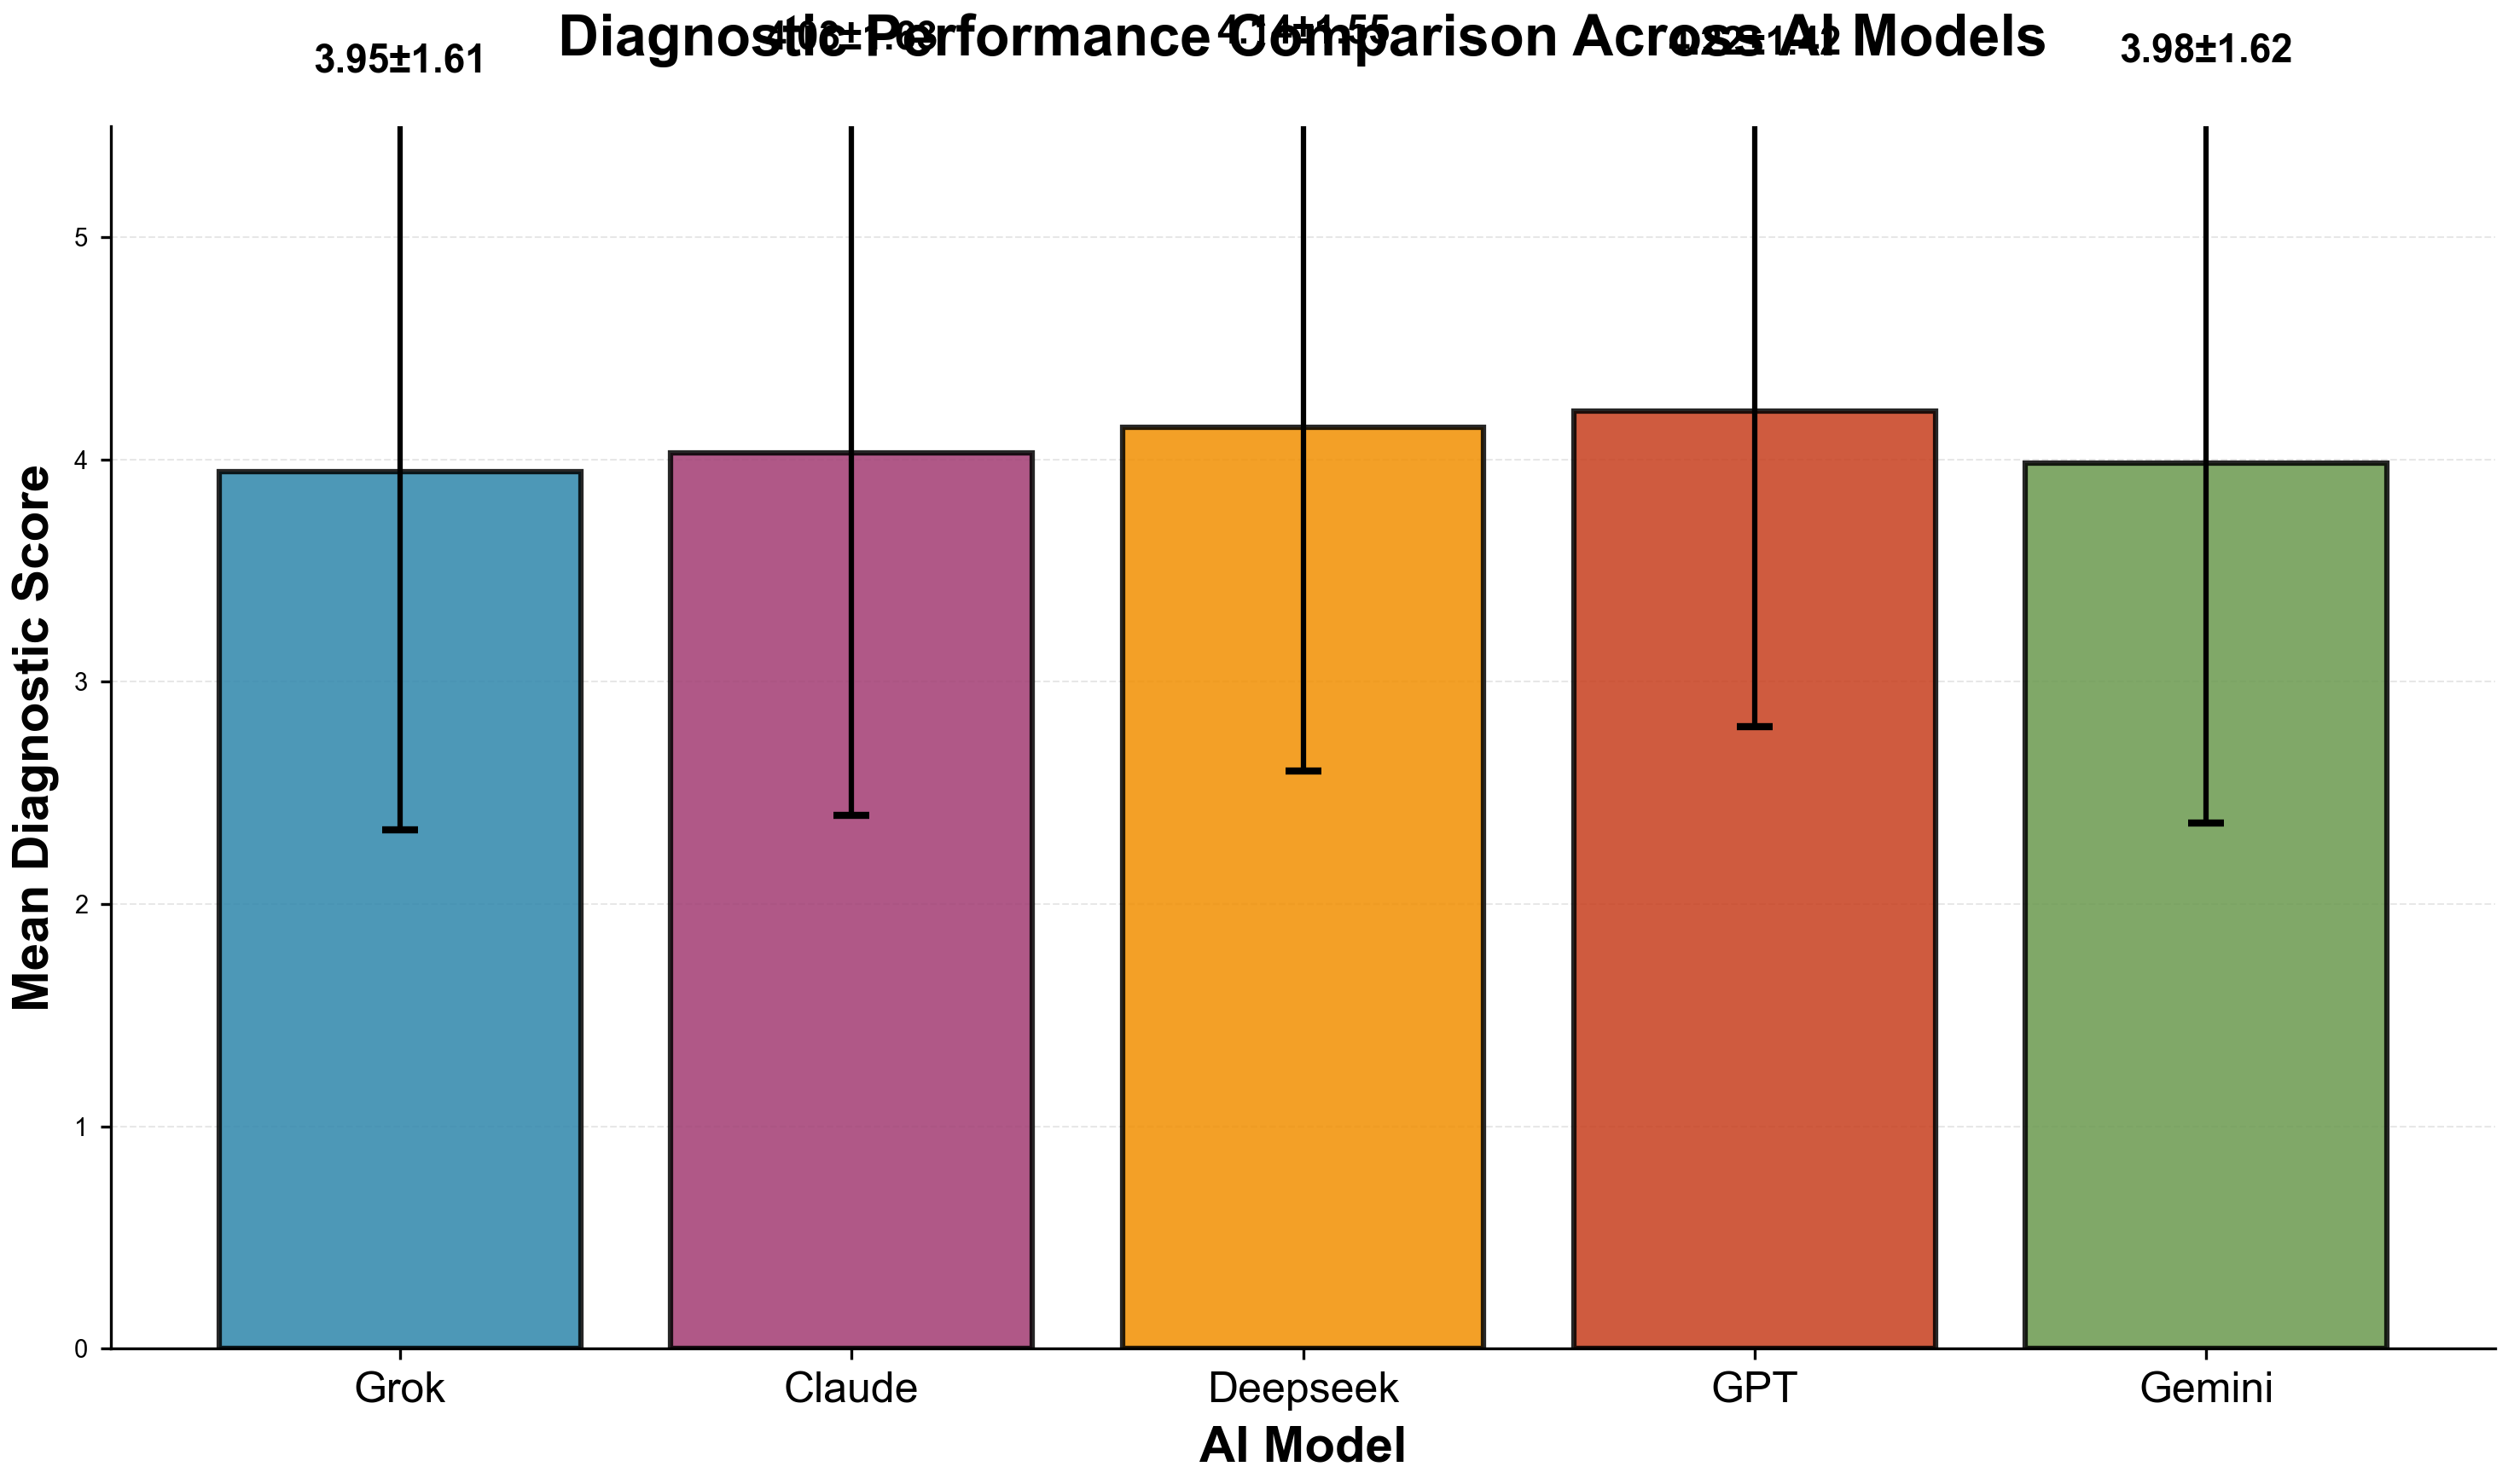

✓ Figure 1 saved: fig1_mean_scores_comparison.png/.pdf


In [25]:
# Publication-ready bar plot for mean scores
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data
mean_scores = [human_avg[model].mean() for model in model_names]
std_scores = [human_avg[model].std() for model in model_names]

# Define colors (professional palette)
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']

# Create bars
x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, mean_scores, color=colors, edgecolor='black', linewidth=1.5, alpha=0.85)

# Add error bars (standard deviation)
ax.errorbar(x_pos, mean_scores, yerr=std_scores, fmt='none', 
            ecolor='black', capsize=5, capthick=2, linewidth=1.5)

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, mean_scores, std_scores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.15,
            f'{mean:.2f}±{std:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Styling
ax.set_ylabel('Mean Diagnostic Score', fontsize=14, fontweight='bold')
ax.set_xlabel('AI Model', fontsize=14, fontweight='bold')
ax.set_title('Diagnostic Performance Comparison Across AI Models', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=12)
ax.set_ylim(0, 5.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('fig1_mean_scores_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig('fig1_mean_scores_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 1 saved: fig1_mean_scores_comparison.png/.pdf")

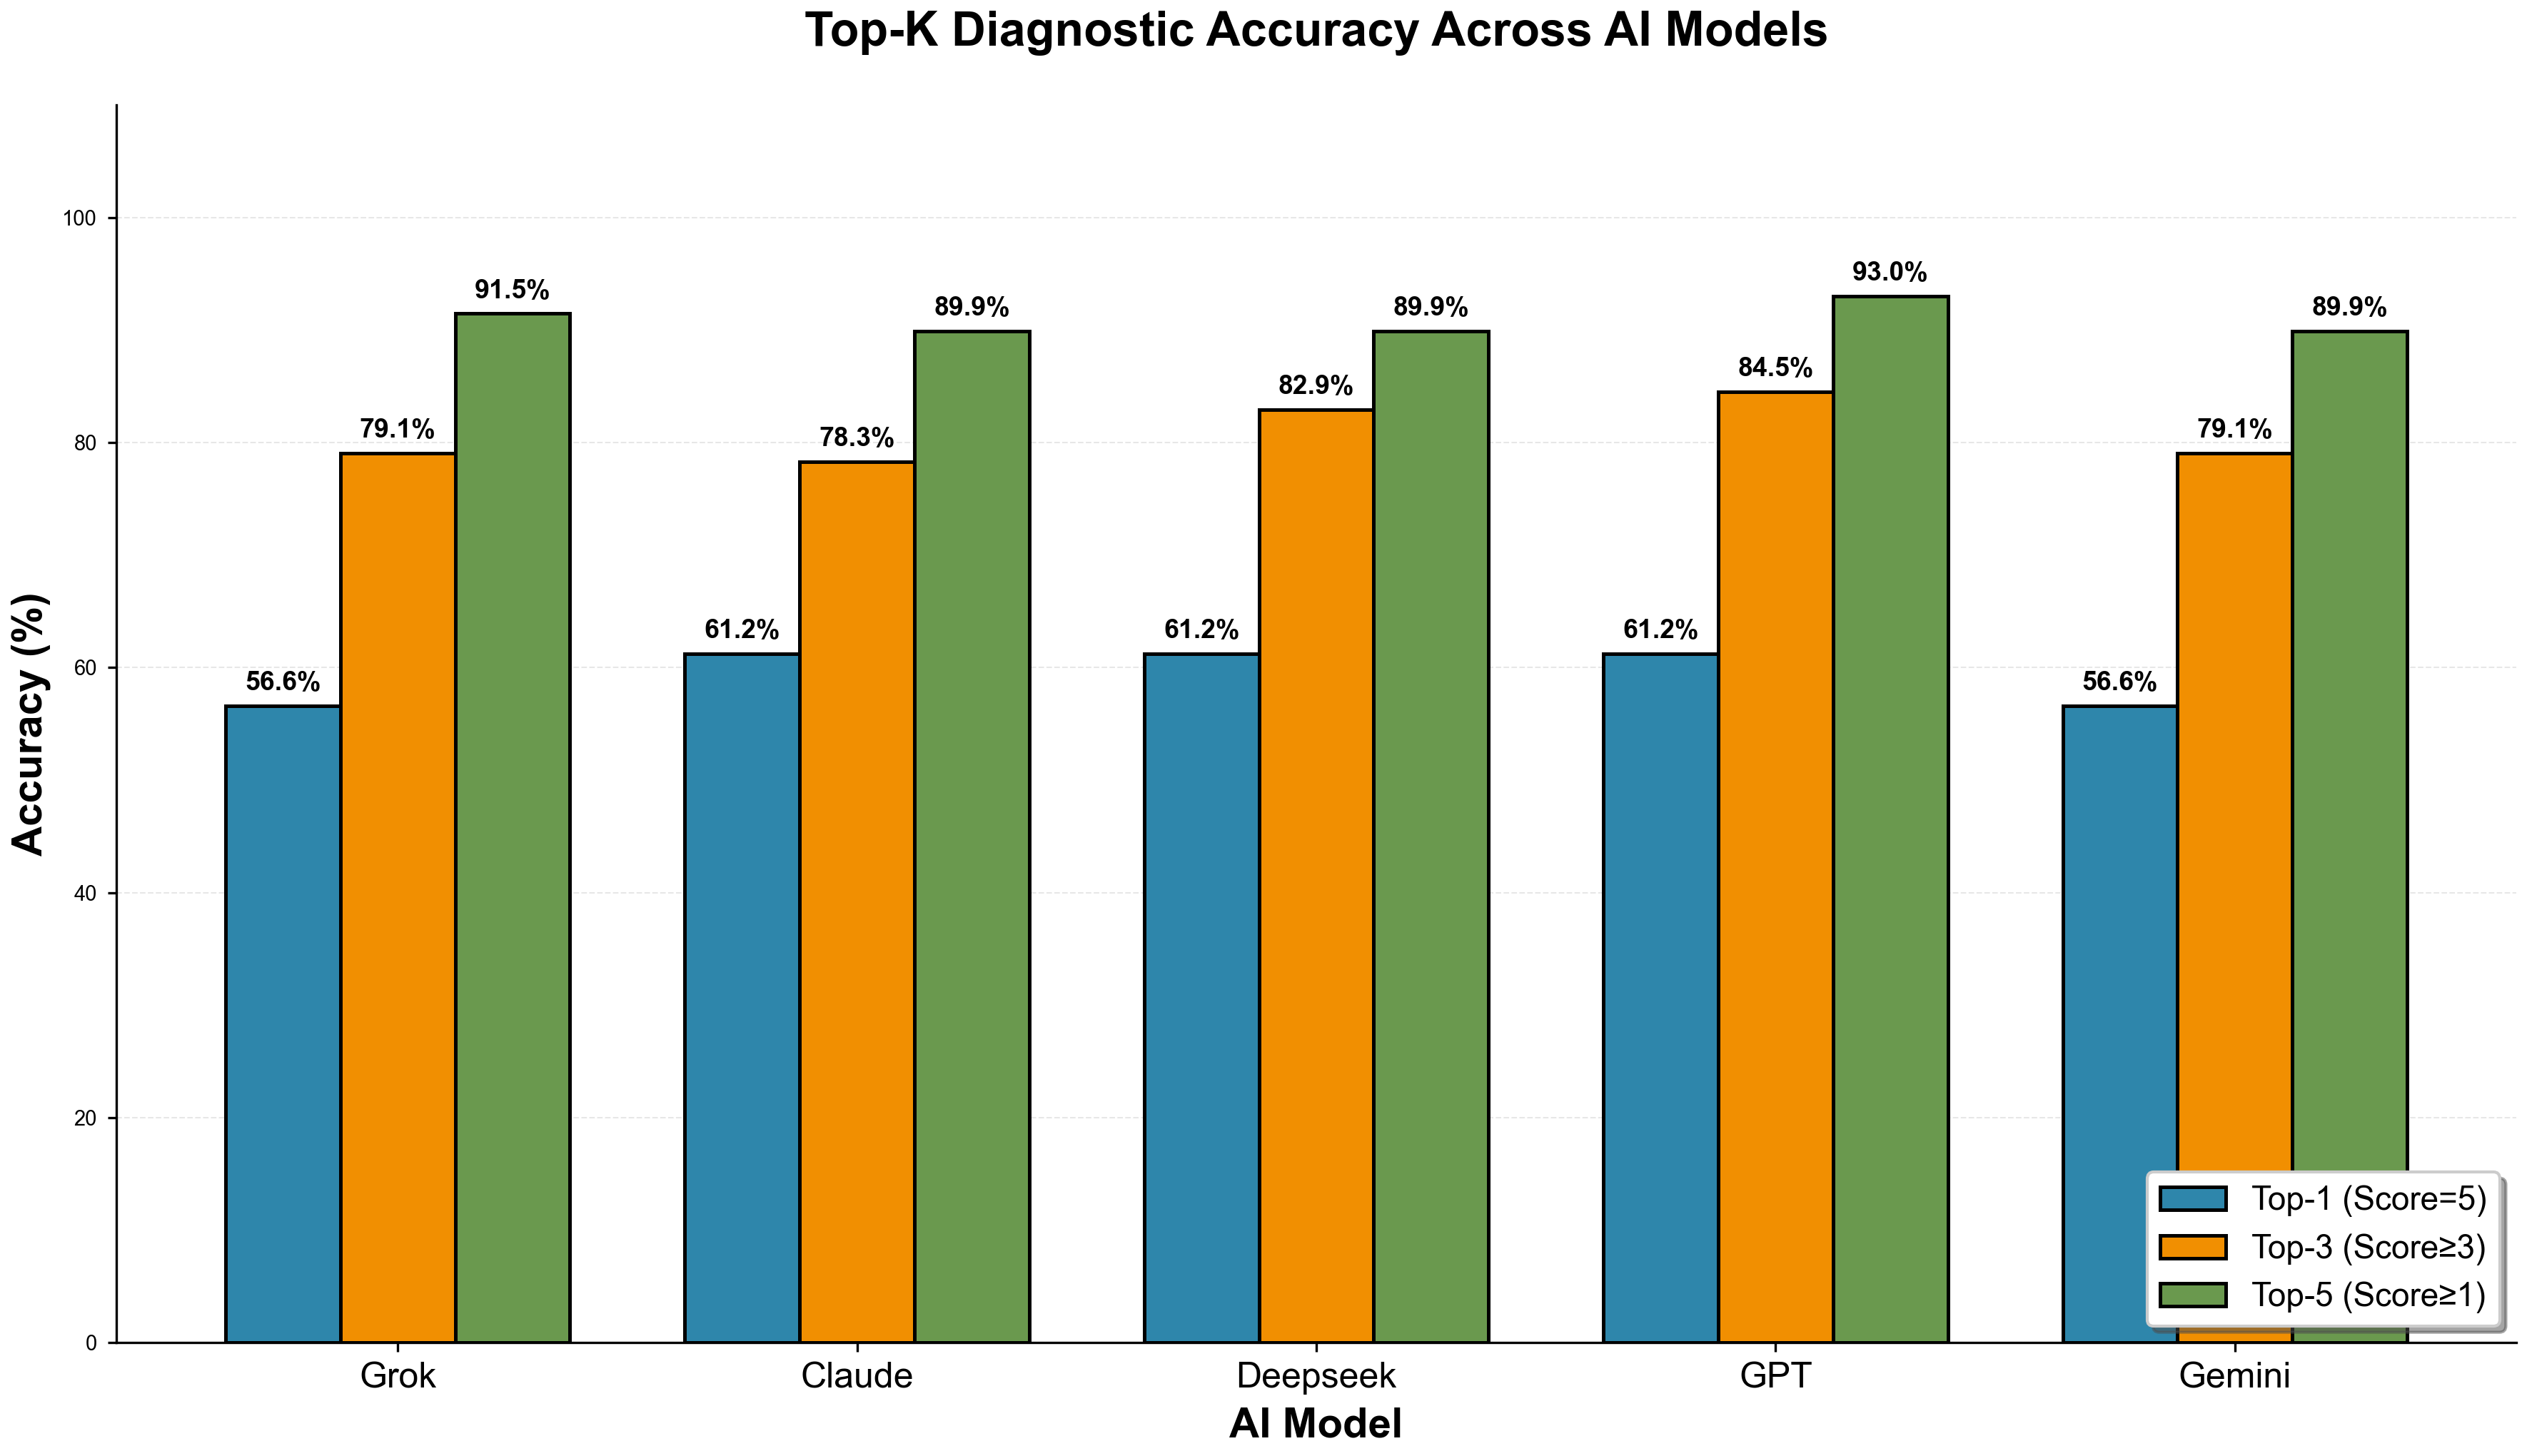

✓ Figure 2 saved: fig2_topk_accuracy.png/.pdf


In [26]:
# Publication-ready grouped bar plot for Top-K accuracy
fig, ax = plt.subplots(figsize=(12, 7))

# Prepare data
top1_pct = [topk_df[topk_df['Model']==m]['Top-1 %'].values[0] for m in model_names]
top3_pct = [topk_df[topk_df['Model']==m]['Top-3 %'].values[0] for m in model_names]
top5_pct = [topk_df[topk_df['Model']==m]['Top-5 %'].values[0] for m in model_names]

x_pos = np.arange(len(model_names))
width = 0.25

# Create grouped bars
bars1 = ax.bar(x_pos - width, top1_pct, width, label='Top-1 (Score=5)', 
               color='#2E86AB', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x_pos, top3_pct, width, label='Top-3 (Score≥3)', 
               color='#F18F01', edgecolor='black', linewidth=1.2)
bars3 = ax.bar(x_pos + width, top5_pct, width, label='Top-5 (Score≥1)', 
               color='#6A994E', edgecolor='black', linewidth=1.2)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Styling
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('AI Model', fontsize=14, fontweight='bold')
ax.set_title('Top-K Diagnostic Accuracy Across AI Models', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=12)
ax.legend(loc='lower right', fontsize=11, frameon=True, shadow=True)
ax.set_ylim(0, 110)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('fig2_topk_accuracy.png', dpi=300, bbox_inches='tight')
plt.savefig('fig2_topk_accuracy.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 2 saved: fig2_topk_accuracy.png/.pdf")

Exception ignored in: <function ZipFile.__del__ at 0x000001FD0BF1D800>
Traceback (most recent call last):
  File "c:\Users\HONOR\AppData\Local\Programs\Python\Python311\Lib\zipfile.py", line 1894, in __del__
    self.close()
  File "c:\Users\HONOR\AppData\Local\Programs\Python\Python311\Lib\zipfile.py", line 1911, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


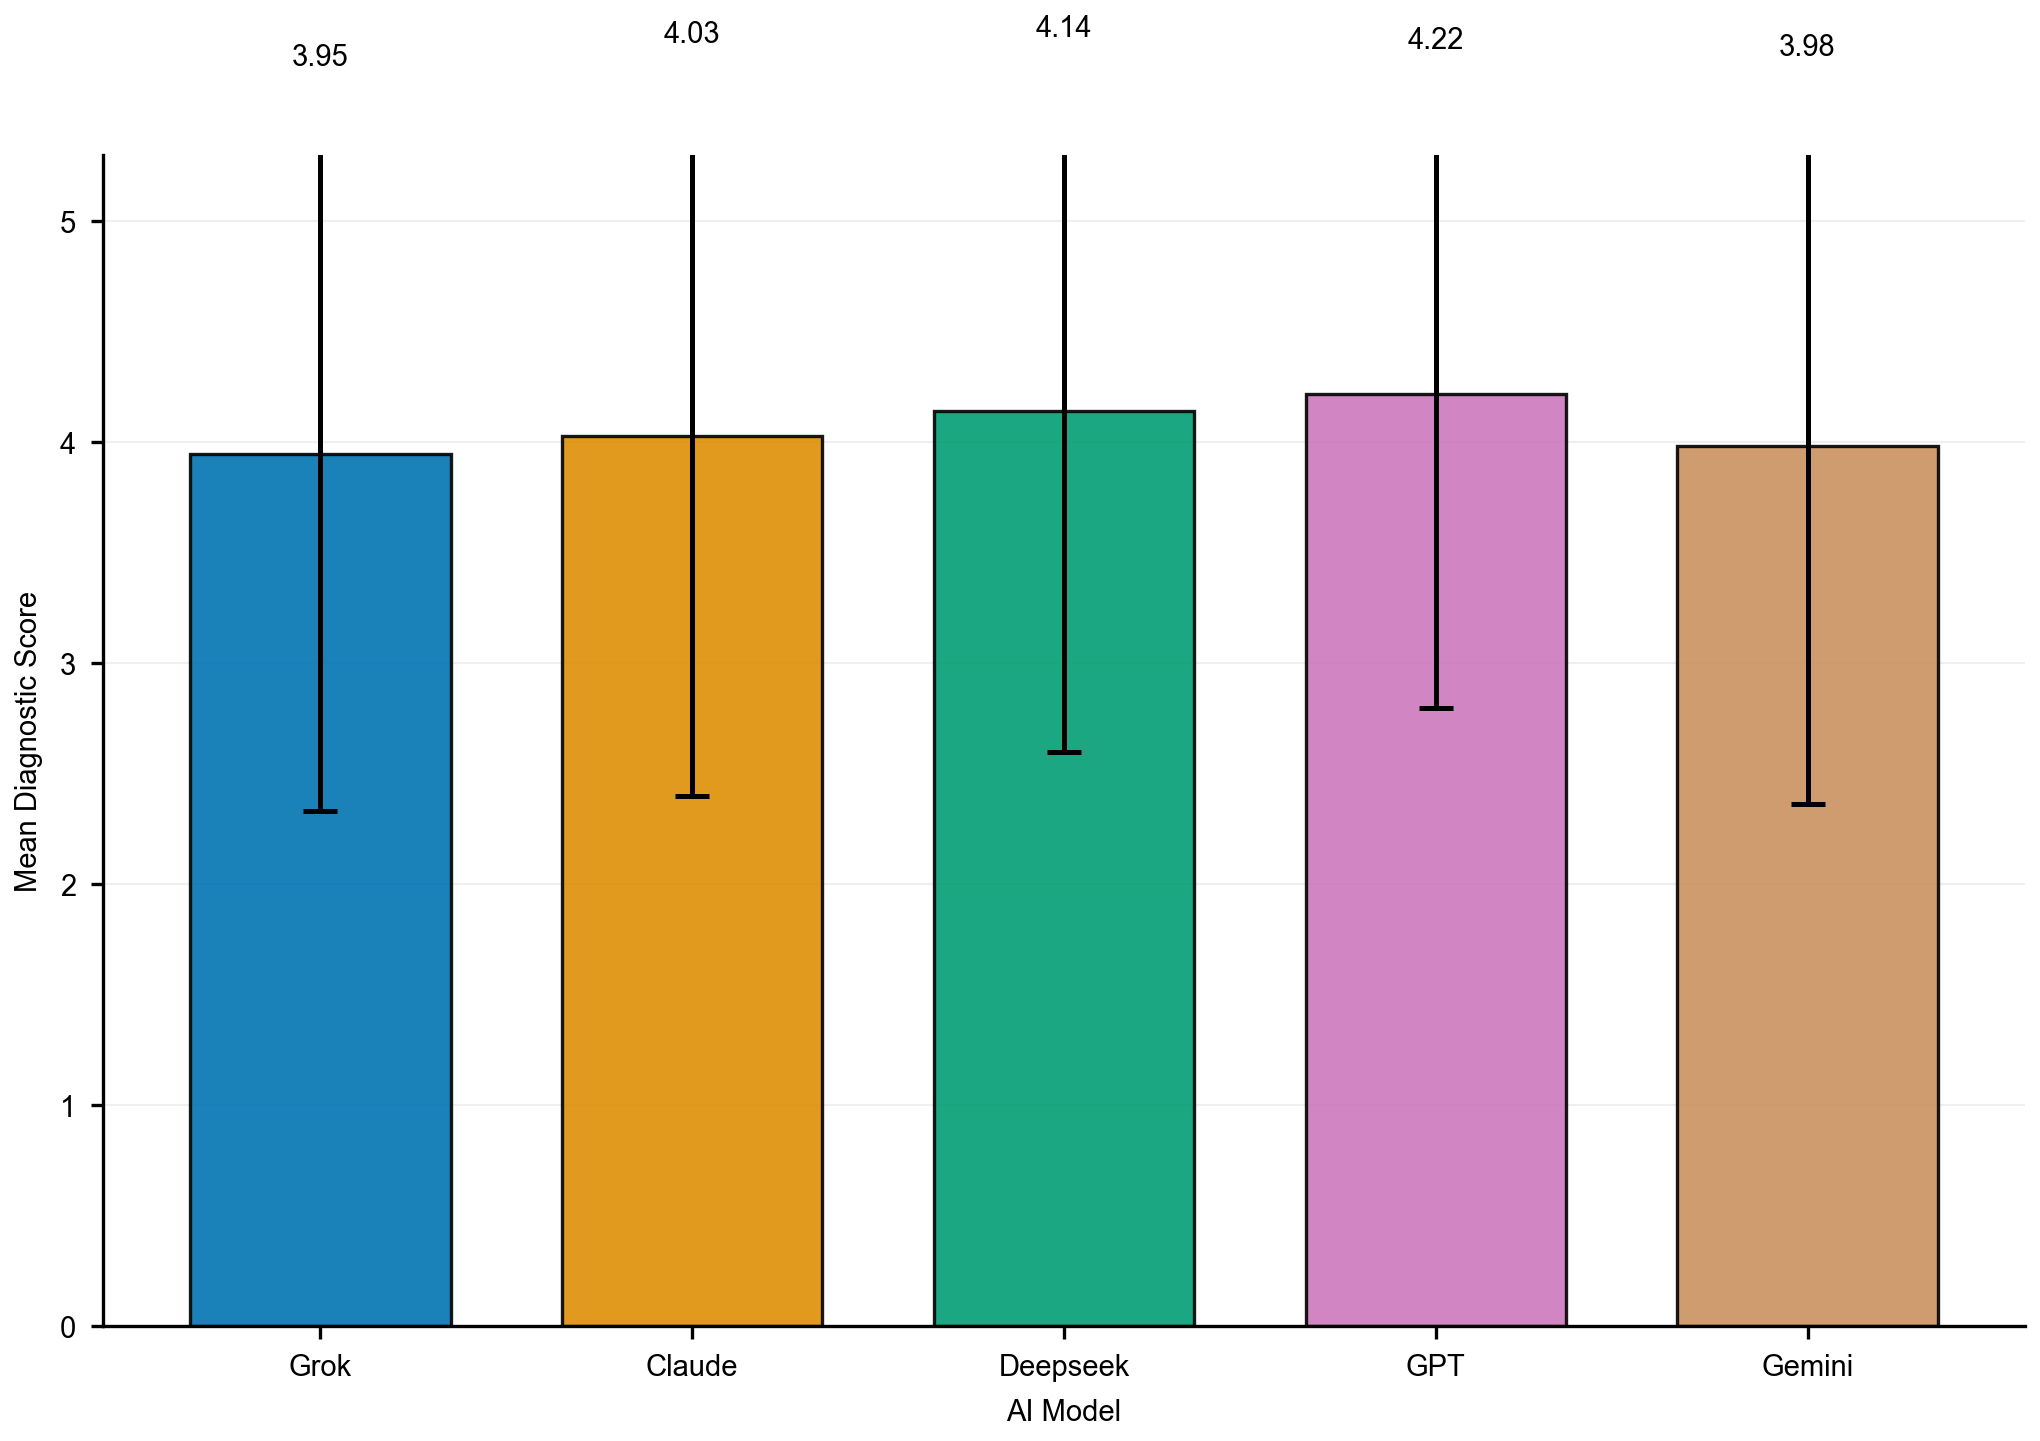

✓ Figure 1 saved: Figure1_mean_scores (PNG, PDF, TIFF at 600 DPI)


In [27]:
# NPJ Digital Medicine compliant figure - Mean scores
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(7, 5))  # ~180mm width

# Data
mean_scores = [human_avg[model].mean() for model in model_names]
std_scores = [human_avg[model].std() for model in model_names]

# Professional Nature color palette
colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161']

# Create bars
x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, mean_scores, color=colors, edgecolor='black', 
              linewidth=0.8, alpha=0.9, width=0.7)

# Add error bars (SD)
ax.errorbar(x_pos, mean_scores, yerr=std_scores, fmt='none', 
            ecolor='black', capsize=4, capthick=1.2, linewidth=1.2, zorder=10)

# Add value labels
for i, (bar, mean, std) in enumerate(zip(bars, mean_scores, std_scores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.12,
            f'{mean:.2f}', ha='center', va='bottom', fontsize=7, 
            fontweight='normal', family='Arial')

# Styling per NPJ guidelines
ax.set_ylabel('Mean Diagnostic Score', fontsize=7, fontweight='normal', family='Arial')
ax.set_xlabel('AI Model', fontsize=7, fontweight='normal', family='Arial')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_ylim(0, 5.3)

# Clean professional styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('Figure1_mean_scores.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure1_mean_scores.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure1_mean_scores.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 1 saved: Figure1_mean_scores (PNG, PDF, TIFF at 600 DPI)")

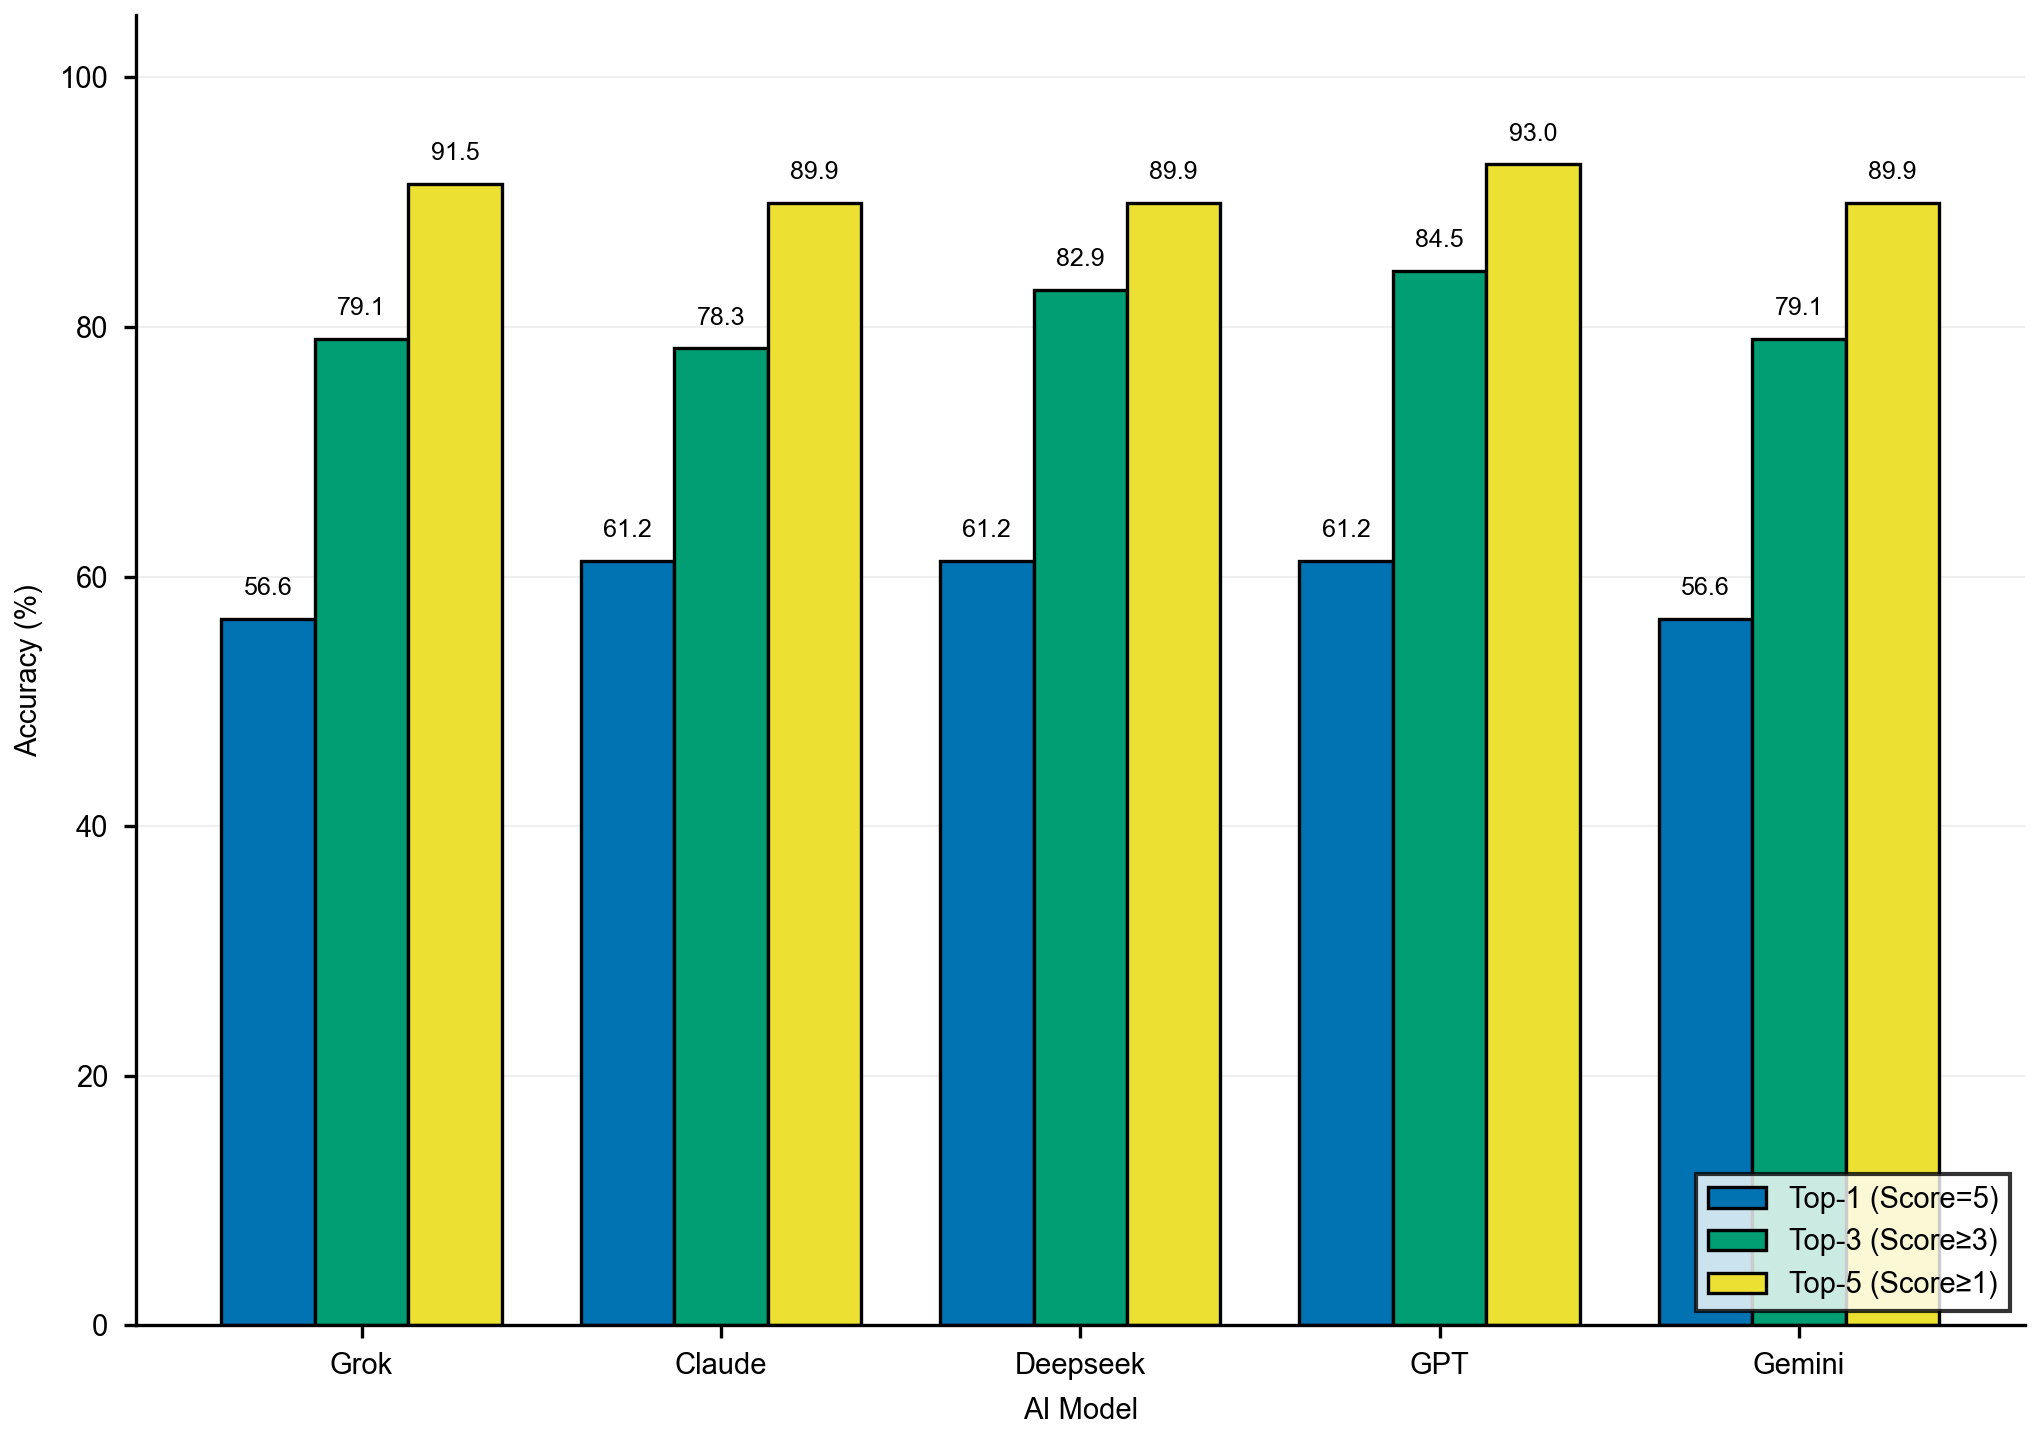

✓ Figure 2 saved: Figure2_topk_accuracy (PNG, PDF, TIFF at 600 DPI)


In [28]:
# NPJ Digital Medicine compliant figure - Top-K Accuracy
fig, ax = plt.subplots(figsize=(7, 5))

# Data
top1_pct = [topk_df[topk_df['Model']==m]['Top-1 %'].values[0] for m in model_names]
top3_pct = [topk_df[topk_df['Model']==m]['Top-3 %'].values[0] for m in model_names]
top5_pct = [topk_df[topk_df['Model']==m]['Top-5 %'].values[0] for m in model_names]

x_pos = np.arange(len(model_names))
width = 0.26

# Nature color palette
colors_topk = ['#0173B2', '#029E73', '#ECE133']

# Create grouped bars
bars1 = ax.bar(x_pos - width, top1_pct, width, label='Top-1 (Score=5)', 
               color=colors_topk[0], edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x_pos, top3_pct, width, label='Top-3 (Score≥3)', 
               color=colors_topk[1], edgecolor='black', linewidth=0.8)
bars3 = ax.bar(x_pos + width, top5_pct, width, label='Top-5 (Score≥1)', 
               color=colors_topk[2], edgecolor='black', linewidth=0.8)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1.5,
                f'{height:.1f}', ha='center', va='bottom', 
                fontsize=6, fontweight='normal', family='Arial')

# Styling per NPJ guidelines
ax.set_ylabel('Accuracy (%)', fontsize=7, fontweight='normal', family='Arial')
ax.set_xlabel('AI Model', fontsize=7, fontweight='normal', family='Arial')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.legend(loc='lower right', fontsize=6, frameon=True, edgecolor='black', 
          fancybox=False, shadow=False, prop={'family': 'Arial'})
ax.set_ylim(0, 105)

# Clean styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('Figure2_topk_accuracy.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2_topk_accuracy.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2_topk_accuracy.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 2 saved: Figure2_topk_accuracy (PNG, PDF, TIFF at 600 DPI)")

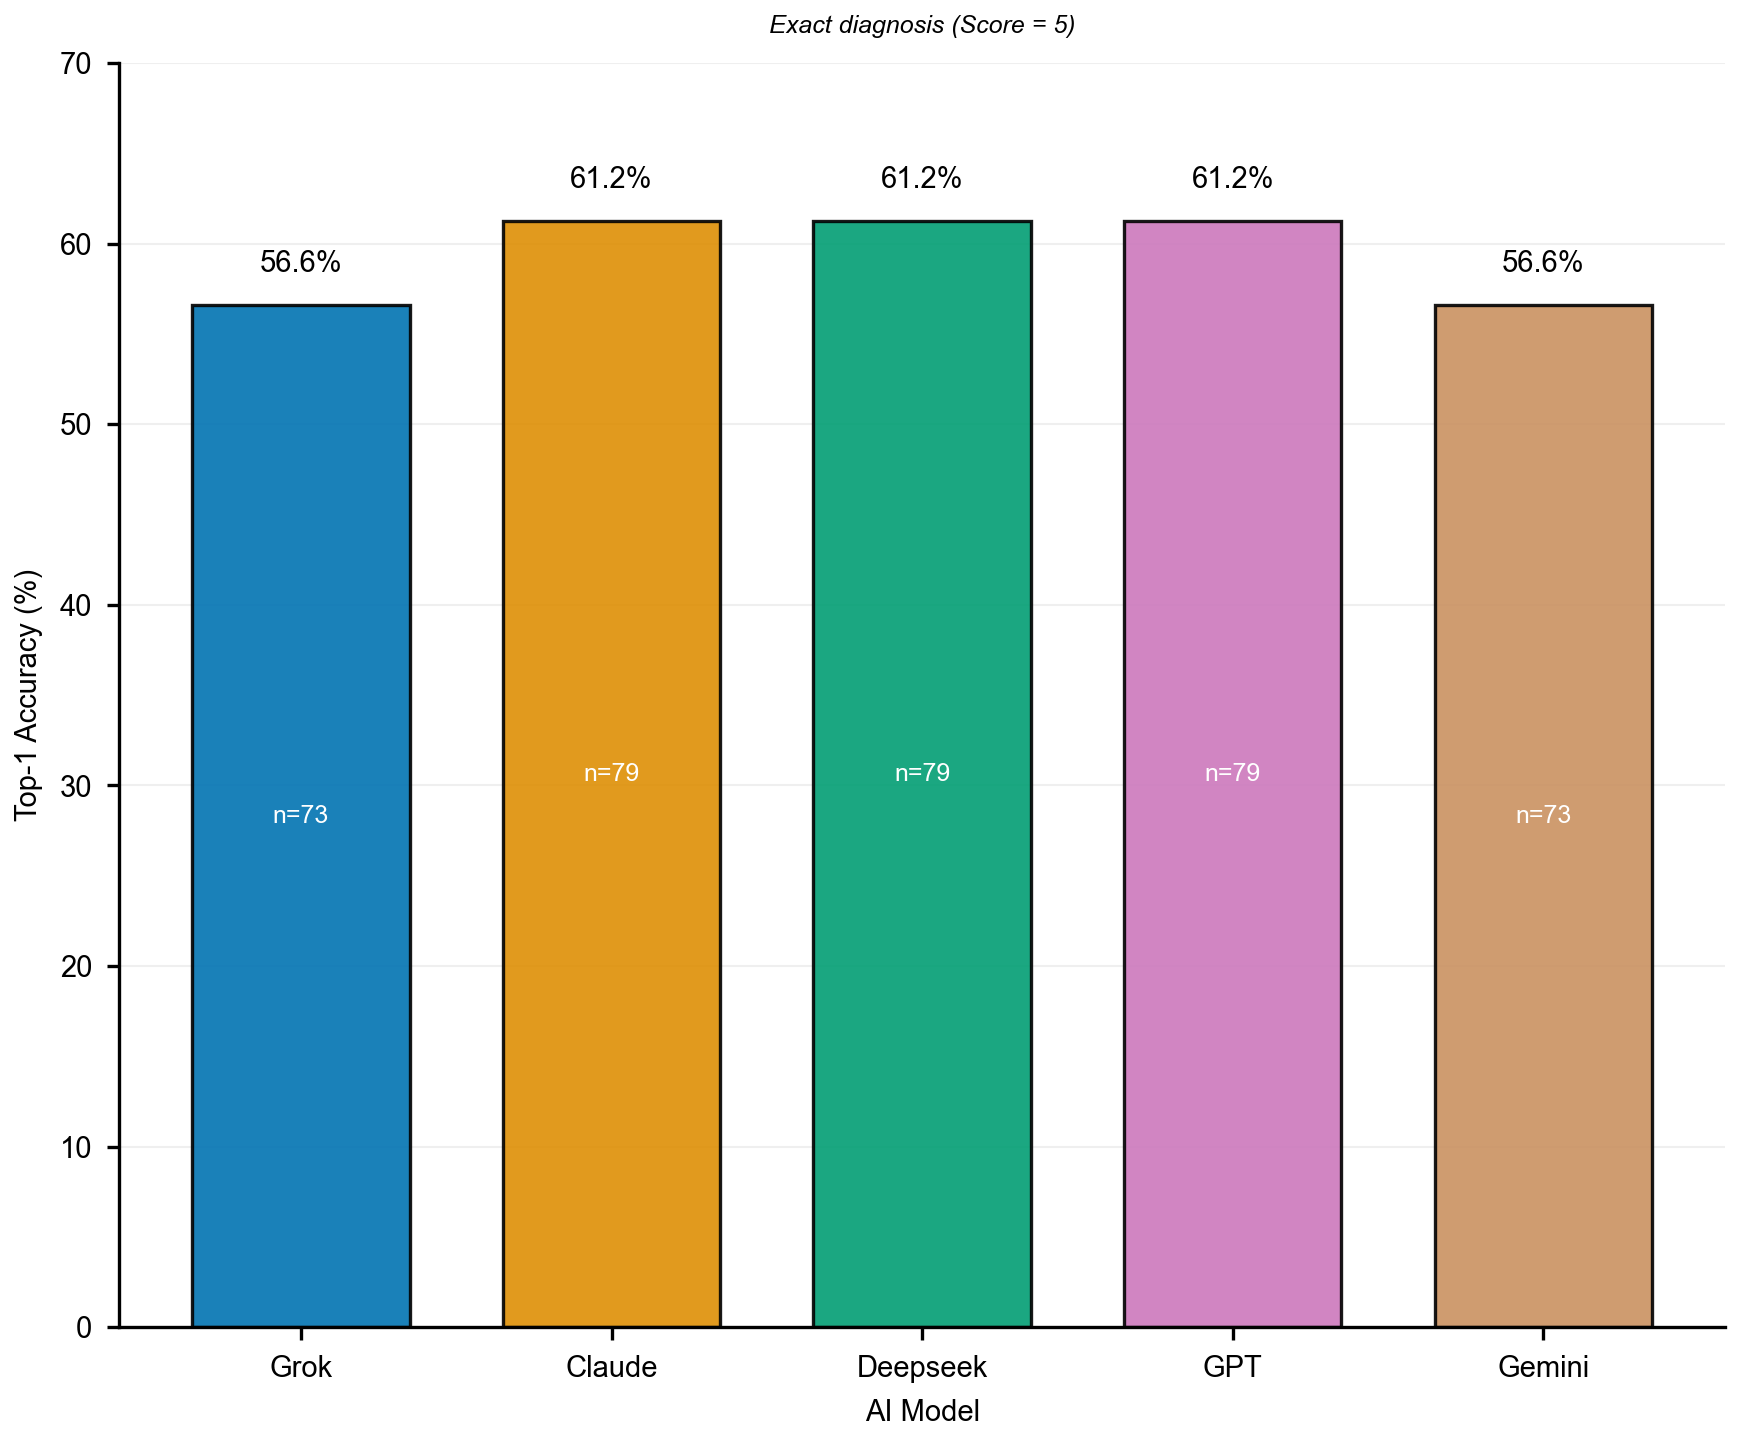

✓ Figure 2a saved: Figure2a_top1_accuracy (Score=5)


In [29]:
# NPJ Digital Medicine compliant - Top-1 Accuracy Only
fig, ax = plt.subplots(figsize=(6, 5))

# Data - Top-1 only
top1_pct = [topk_df[topk_df['Model']==m]['Top-1 %'].values[0] for m in model_names]
top1_count = [topk_df[topk_df['Model']==m]['Top-1 (Score=5)'].values[0] for m in model_names]

# Professional Nature color palette
colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161']

x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, top1_pct, color=colors, edgecolor='black', 
              linewidth=0.8, alpha=0.9, width=0.7)

# Add percentage labels on bars
for i, (bar, pct, count) in enumerate(zip(bars, top1_pct, top1_count)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1.5,
            f'{pct:.1f}%', ha='center', va='bottom', 
            fontsize=7, fontweight='normal', family='Arial')
    # Add count inside bar
    ax.text(bar.get_x() + bar.get_width()/2., height/2,
            f'n={int(count)}', ha='center', va='center', 
            fontsize=6, fontweight='normal', family='Arial', color='white')

# Styling per NPJ guidelines
ax.set_ylabel('Top-1 Accuracy (%)', fontsize=7, fontweight='normal', family='Arial')
ax.set_xlabel('AI Model', fontsize=7, fontweight='normal', family='Arial')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_ylim(0, 70)

# Clean styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_axisbelow(True)

# Add subtitle
ax.text(0.5, 1.02, 'Exact diagnosis (Score = 5)', transform=ax.transAxes,
        ha='center', va='bottom', fontsize=6, style='italic', family='Arial')

plt.tight_layout()
plt.savefig('Figure2a_top1_accuracy.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2a_top1_accuracy.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2a_top1_accuracy.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 2a saved: Figure2a_top1_accuracy (Score=5)")

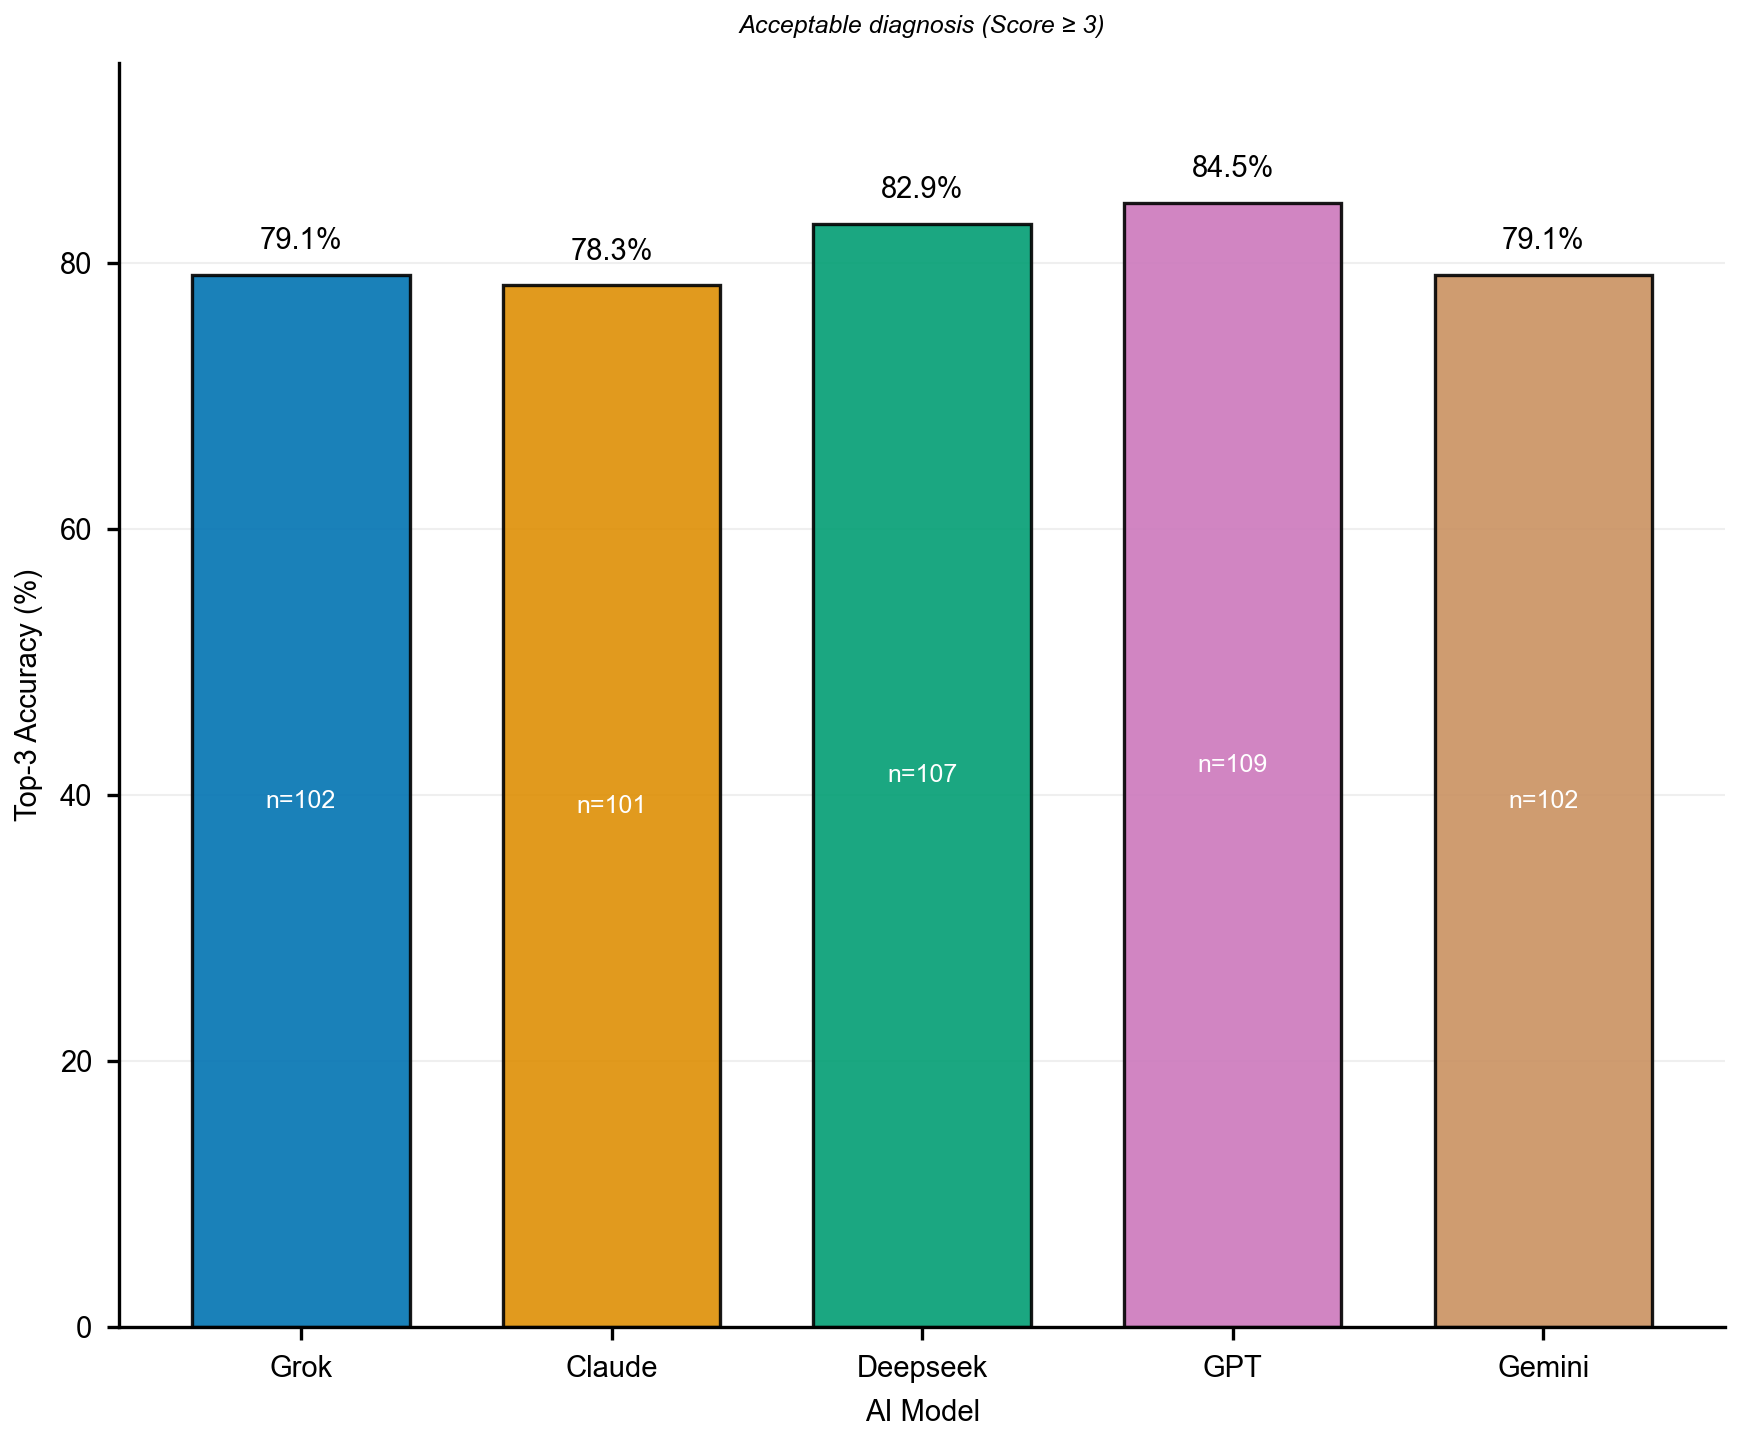

✓ Figure 2b saved: Figure2b_top3_accuracy (Score≥3)


In [30]:
# NPJ Digital Medicine compliant - Top-3 Accuracy Only
fig, ax = plt.subplots(figsize=(6, 5))

# Data - Top-3 only
top3_pct = [topk_df[topk_df['Model']==m]['Top-3 %'].values[0] for m in model_names]
top3_count = [topk_df[topk_df['Model']==m]['Top-3 (Score>=3)'].values[0] for m in model_names]

# Professional Nature color palette
colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161']

x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, top3_pct, color=colors, edgecolor='black', 
              linewidth=0.8, alpha=0.9, width=0.7)

# Add percentage labels on bars
for i, (bar, pct, count) in enumerate(zip(bars, top3_pct, top3_count)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1.5,
            f'{pct:.1f}%', ha='center', va='bottom', 
            fontsize=7, fontweight='normal', family='Arial')
    # Add count inside bar
    ax.text(bar.get_x() + bar.get_width()/2., height/2,
            f'n={int(count)}', ha='center', va='center', 
            fontsize=6, fontweight='normal', family='Arial', color='white')

# Styling per NPJ guidelines
ax.set_ylabel('Top-3 Accuracy (%)', fontsize=7, fontweight='normal', family='Arial')
ax.set_xlabel('AI Model', fontsize=7, fontweight='normal', family='Arial')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_ylim(0, 95)

# Clean styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_axisbelow(True)

# Add subtitle
ax.text(0.5, 1.02, 'Acceptable diagnosis (Score ≥ 3)', transform=ax.transAxes,
        ha='center', va='bottom', fontsize=6, style='italic', family='Arial')

plt.tight_layout()
plt.savefig('Figure2b_top3_accuracy.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2b_top3_accuracy.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2b_top3_accuracy.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 2b saved: Figure2b_top3_accuracy (Score≥3)")

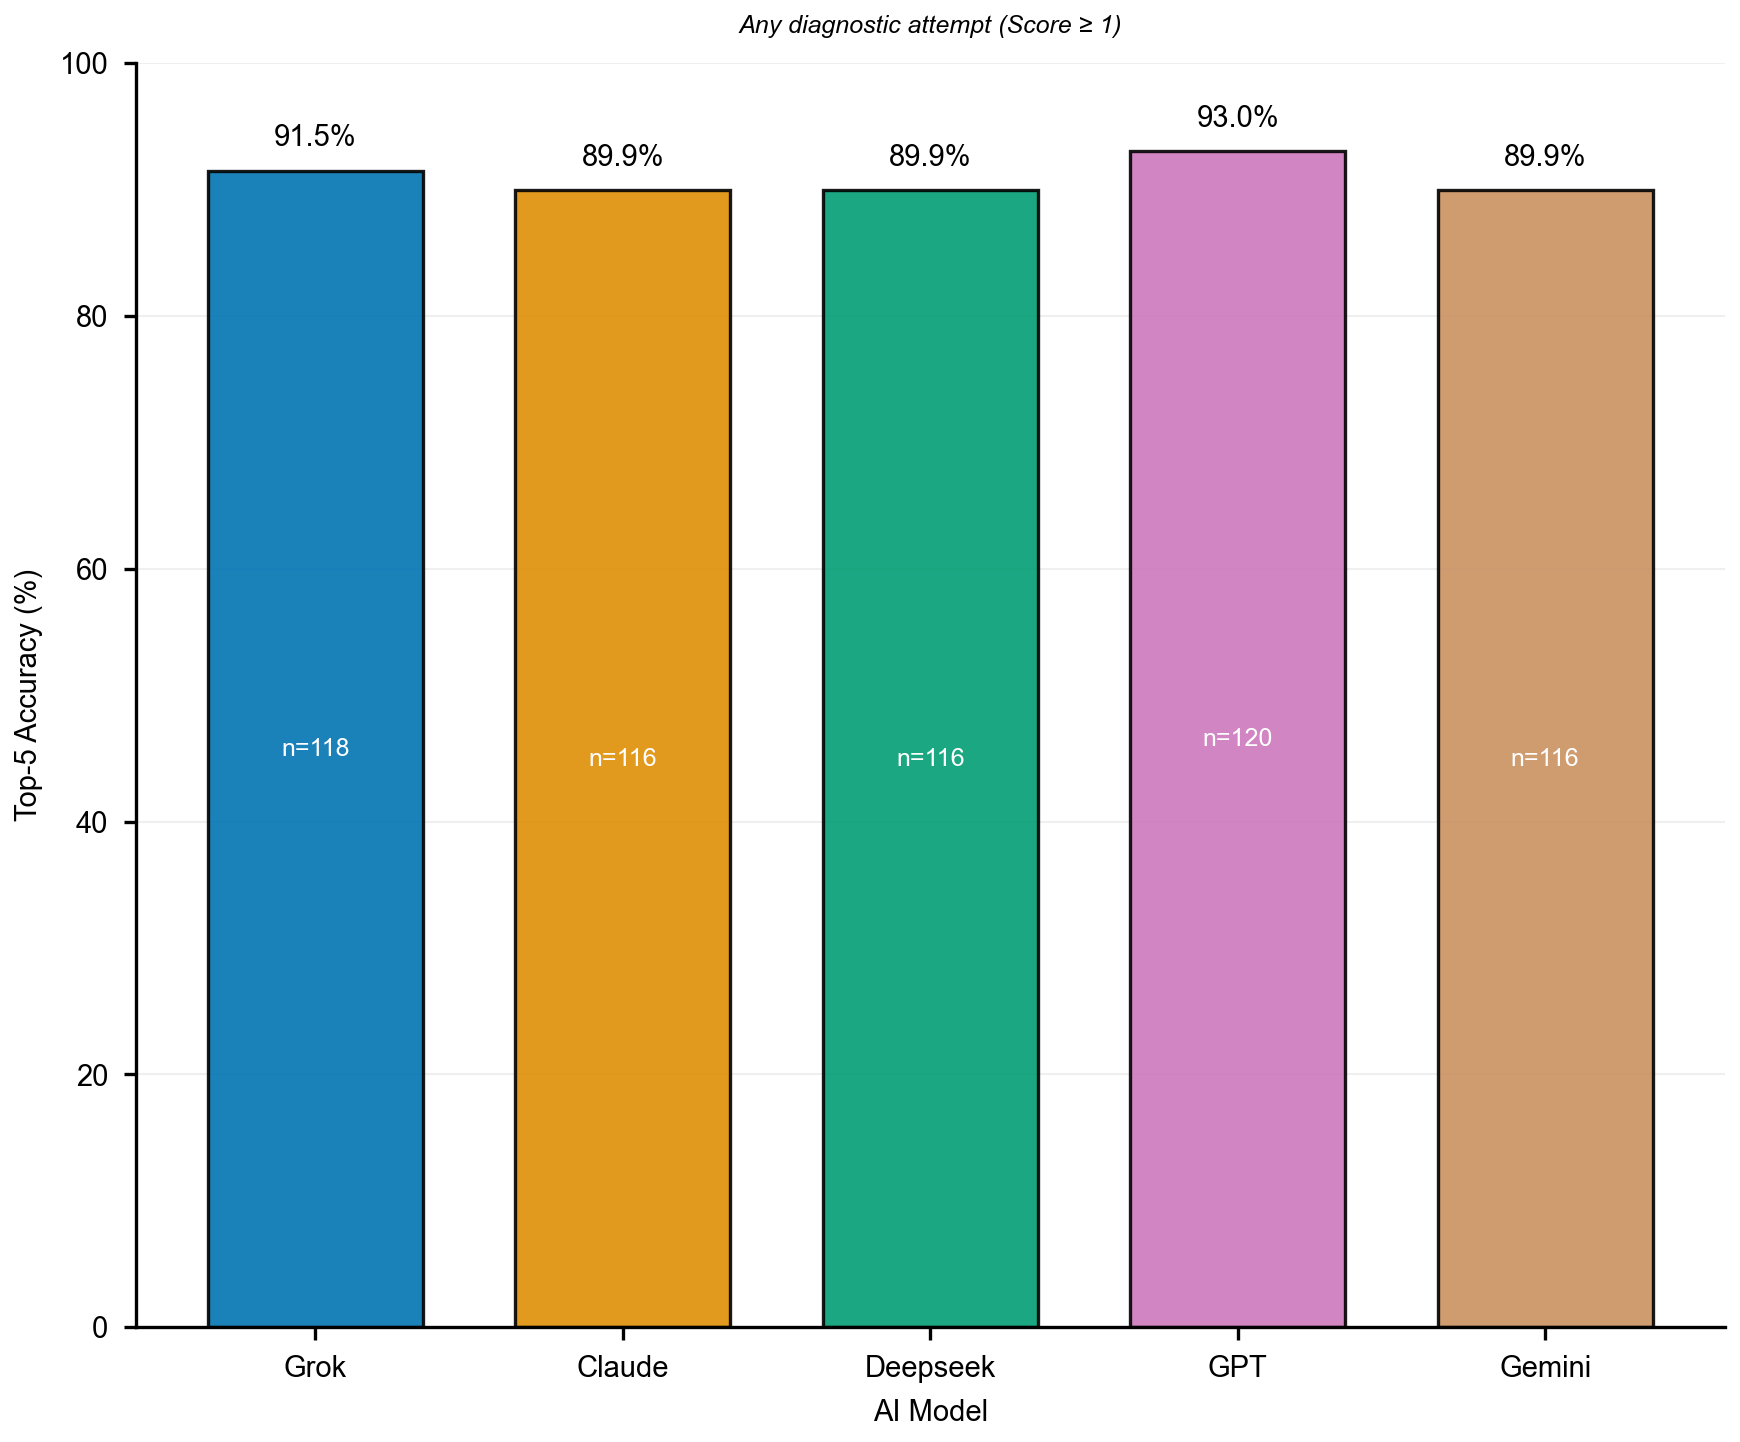

✓ Figure 2c saved: Figure2c_top5_accuracy (Score≥1)


In [31]:
# NPJ Digital Medicine compliant - Top-5 Accuracy Only
fig, ax = plt.subplots(figsize=(6, 5))

# Data - Top-5 only
top5_pct = [topk_df[topk_df['Model']==m]['Top-5 %'].values[0] for m in model_names]
top5_count = [topk_df[topk_df['Model']==m]['Top-5 (Score>=1)'].values[0] for m in model_names]

# Professional Nature color palette
colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161']

x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, top5_pct, color=colors, edgecolor='black', 
              linewidth=0.8, alpha=0.9, width=0.7)

# Add percentage labels on bars
for i, (bar, pct, count) in enumerate(zip(bars, top5_pct, top5_count)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1.5,
            f'{pct:.1f}%', ha='center', va='bottom', 
            fontsize=7, fontweight='normal', family='Arial')
    # Add count inside bar
    ax.text(bar.get_x() + bar.get_width()/2., height/2,
            f'n={int(count)}', ha='center', va='center', 
            fontsize=6, fontweight='normal', family='Arial', color='white')

# Styling per NPJ guidelines
ax.set_ylabel('Top-5 Accuracy (%)', fontsize=7, fontweight='normal', family='Arial')
ax.set_xlabel('AI Model', fontsize=7, fontweight='normal', family='Arial')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_ylim(0, 100)

# Clean styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_axisbelow(True)

# Add subtitle
ax.text(0.5, 1.02, 'Any diagnostic attempt (Score ≥ 1)', transform=ax.transAxes,
        ha='center', va='bottom', fontsize=6, style='italic', family='Arial')

plt.tight_layout()
plt.savefig('Figure2c_top5_accuracy.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2c_top5_accuracy.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2c_top5_accuracy.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 2c saved: Figure2c_top5_accuracy (Score≥1)")

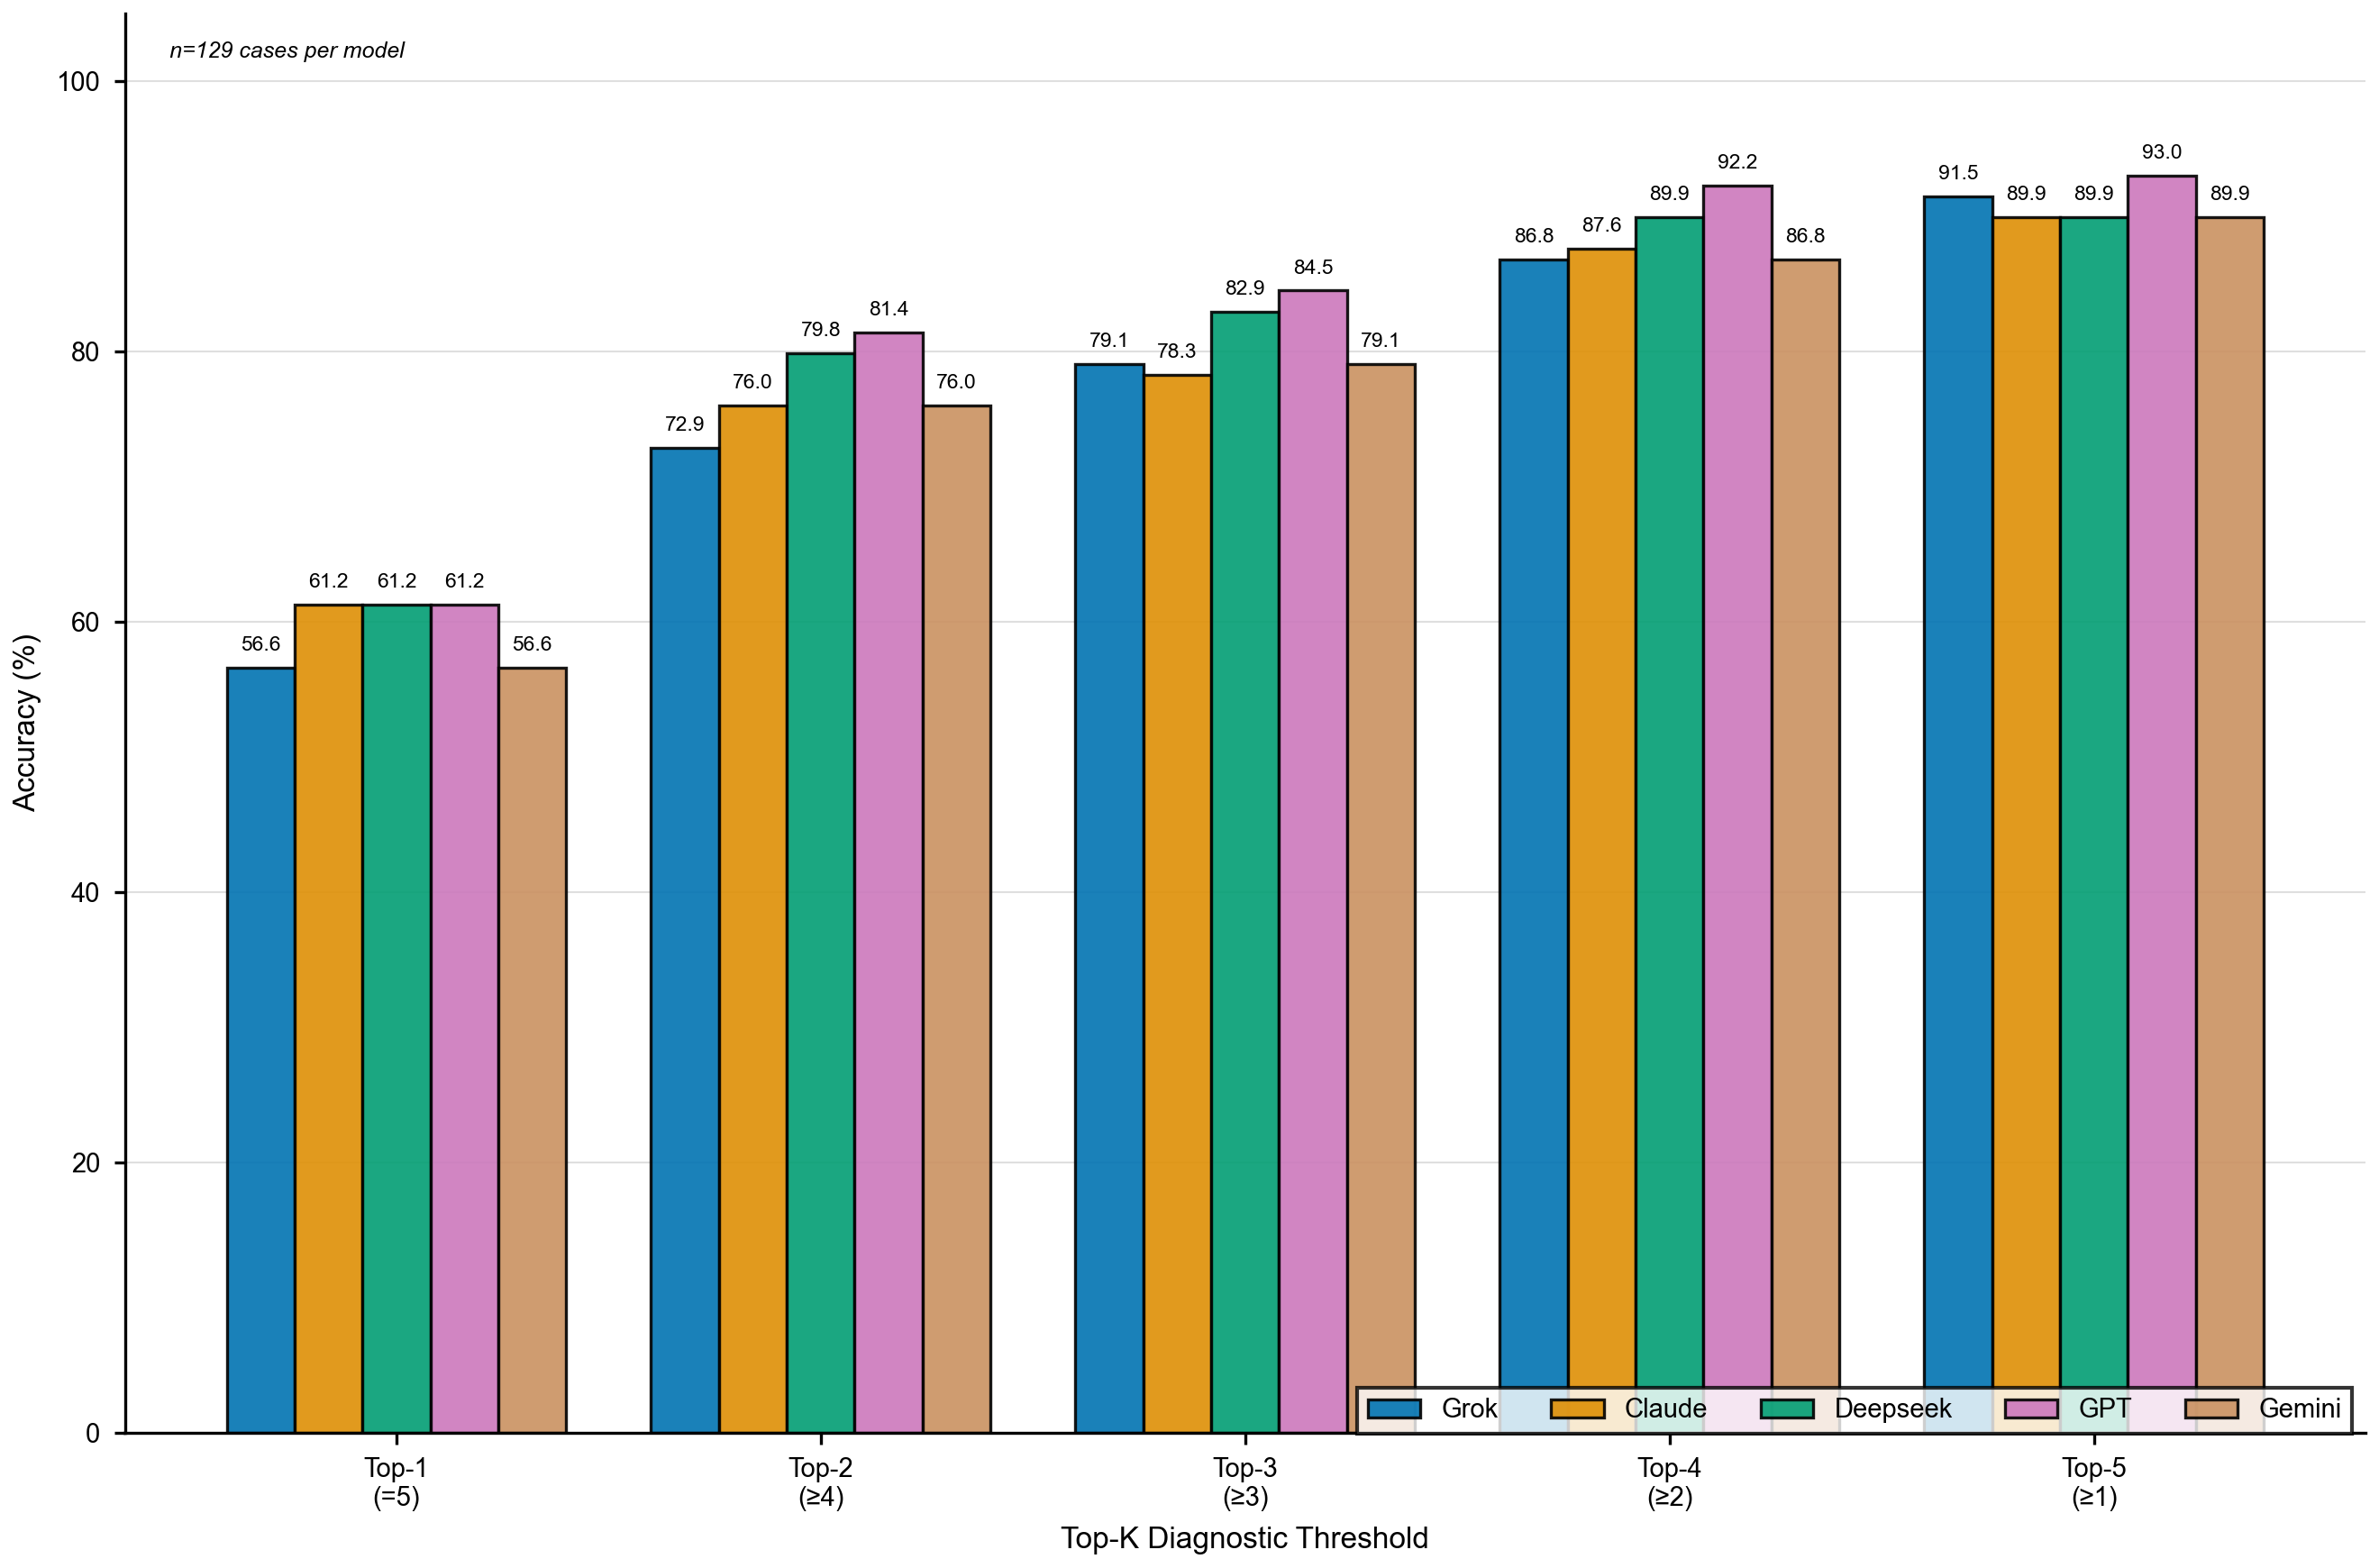

✓ Figure 2 saved: Comprehensive Top-K threshold rates by model
  Models compared: Grok, Claude, Deepseek, GPT, Gemini
  Metrics: Top-1 through Top-5


In [32]:
# NPJ Digital Medicine compliant - Comprehensive Top-K threshold rates
fig, ax = plt.subplots(figsize=(9, 6))

# Prepare comprehensive Top-K data
metrics = ['Top-1\n(=5)', 'Top-2\n(≥4)', 'Top-3\n(≥3)', 'Top-4\n(≥2)', 'Top-5\n(≥1)']

# Calculate all Top-K rates
topk_data = {}
for model in model_names:
    scores = human_avg[model].dropna()
    n_total = len(scores)
    
    topk_data[model] = [
        (scores == 5).sum() / n_total * 100,  # Top-1
        (scores >= 4).sum() / n_total * 100,  # Top-2
        (scores >= 3).sum() / n_total * 100,  # Top-3
        (scores >= 2).sum() / n_total * 100,  # Top-4
        (scores >= 1).sum() / n_total * 100,  # Top-5
    ]

# Professional Nature color palette (colorblind-friendly)
colors = {
    'Grok': '#0173B2',
    'Claude': '#DE8F05', 
    'Deepseek': '#029E73',
    'GPT': '#CC78BC',
    'Gemini': '#CA9161'
}

# Set up positions
x = np.arange(len(metrics))
width = 0.16
offsets = [-2*width, -width, 0, width, 2*width]

# Plot bars for each model
bars_list = []
for i, model in enumerate(model_names):
    bars = ax.bar(x + offsets[i], topk_data[model], width, 
                  label=model, color=colors[model], 
                  edgecolor='black', linewidth=0.8, alpha=0.9)
    bars_list.append(bars)
    
    # Add value labels on top of bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1.0,
                f'{topk_data[model][j]:.1f}',
                ha='center', va='bottom', fontsize=5.5, 
                fontweight='normal', family='Arial')

# Styling per NPJ guidelines
ax.set_ylabel('Accuracy (%)', fontsize=8, fontweight='normal', family='Arial')
ax.set_xlabel('Top-K Diagnostic Threshold', fontsize=8, fontweight='normal', family='Arial')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=7, family='Arial')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_ylim(0, 105)

# Legend
ax.legend(loc='lower right', fontsize=7, frameon=True, 
          edgecolor='black', fancybox=False, shadow=False, 
          prop={'family': 'Arial'}, ncol=5, 
          bbox_to_anchor=(1.0, -0.01))

# Clean professional styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.yaxis.grid(True, linestyle='-', alpha=0.25, linewidth=0.5, color='gray')
ax.set_axisbelow(True)

# Add sample size annotation
ax.text(0.02, 0.98, 'n=129 cases per model', 
        transform=ax.transAxes, fontsize=6, 
        va='top', ha='left', family='Arial', style='italic')

plt.tight_layout()
plt.savefig('Figure2_topk_comprehensive.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2_topk_comprehensive.pdf', dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig('Figure2_topk_comprehensive.tiff', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Figure 2 saved: Comprehensive Top-K threshold rates by model")
print(f"  Models compared: {', '.join(model_names)}")
print(f"  Metrics: Top-1 through Top-5")

In [33]:
"""
Pairwise Wilcoxon Signed-Rank Tests with Holm Correction (FIXED)
===============================================================
Generates Table 3 (NPJ Digital Medicine style).

Fixes included:
1) Robust score-column detection for your sheet (Grok_results / GPT_results / Grok / Claude / etc.)
2) Converts detected score columns to numeric BEFORE testing
3) Uses complete-case rows across detected models (paired comparisons valid)
4) Safe Wilcoxon handling of all-zero diffs / ties
"""

import pandas as pd
import numpy as np
from scipy import stats
from itertools import combinations
import difflib

# =============================================================================
# SETTINGS
# =============================================================================

PATH = r"E:\test\sleep\Final_results.xlsx"
SHEET = "human_avg"

MODELS = ["Grok", "Claude", "Deepseek", "GPT", "Gemini"]

MODEL_DISPLAY = {
    "Grok": "Grok",
    "Claude": "Claude",
    "Deepseek": "DeepSeek",
    "GPT": "GPT-4",
    "Gemini": "Gemini",
}

# =============================================================================
# SCORE COLUMN DETECTION (matches your real sheet)
# =============================================================================

def _normalize_cols(cols):
    return [str(c).strip() for c in cols]

def _numeric_coverage(df, col):
    s = pd.to_numeric(df[col], errors="coerce")
    return int(s.notna().sum())

def detect_score_columns(df, models=MODELS):
    """
    Priority:
      1) {model}_human_avg
      2) {model}_results
      3) {model}
    If multiple exist, choose the one with highest numeric coverage.
    """
    cols = _normalize_cols(df.columns)
    col_set = set(cols)
    score_map = {}

    for m in models:
        candidates = [f"{m}_human_avg", f"{m}_results", m]
        existing = [c for c in candidates if c in col_set]

        if not existing:
            # fuzzy fallback (rare)
            best = difflib.get_close_matches(m, cols, n=3, cutoff=0.75)
            existing = best[:1] if best else []

        if not existing:
            continue

        best_col = max(existing, key=lambda c: _numeric_coverage(df, c))
        score_map[m] = best_col

    return score_map


# =============================================================================
# LOAD DATA
# =============================================================================

def load_data(path=PATH, sheet=SHEET):
    df = pd.read_excel(path, sheet_name=sheet)
    df.columns = df.columns.astype(str).str.strip()

    score_map = detect_score_columns(df, MODELS)
    if not score_map:
        raise KeyError("No score columns detected. Please check your Excel sheet.")

    print("=== Detected score columns (auto-selected by numeric coverage) ===")
    for m in MODELS:
        if m in score_map:
            col = score_map[m]
            cov = _numeric_coverage(df, col)
            print(f"  {m:<8} -> {col:<20} | numeric={cov}/{len(df)} ({cov/max(1,len(df))*100:.1f}%)")
        else:
            print(f"  {m:<8} -> (NOT FOUND)")

    # Convert detected columns to numeric
    for m, col in score_map.items():
        df[col] = pd.to_numeric(df[col], errors="coerce")

    used_models = [m for m in MODELS if m in score_map]
    used_cols = [score_map[m] for m in used_models]

    # Complete-case across detected models (required for Friedman and fair pairwise)
    df_complete = df.dropna(subset=used_cols).copy()
    print(f"\nComplete cases across detected models: {len(df_complete)}")

    return df_complete, score_map, used_models


# =============================================================================
# EFFECT SIZE: rank-biserial correlation for paired Wilcoxon
# =============================================================================

def rank_biserial_correlation(x, y):
    """
    Rank-biserial correlation for paired data (Wilcoxon effect size).
    Positive r: x tends to be higher than y (model1 better).
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    diff = x - y
    diff = diff[diff != 0]  # remove ties at zero
    if diff.size == 0:
        return 0.0

    ranks = stats.rankdata(np.abs(diff))
    pos = ranks[diff > 0].sum()
    neg = ranks[diff < 0].sum()
    denom = ranks.sum()
    if denom == 0:
        return 0.0
    return float((pos - neg) / denom)


# =============================================================================
# HOLM CORRECTION
# =============================================================================

def holm_correction(p_values):
    p_values = np.asarray(p_values, dtype=float)
    n = len(p_values)
    order = np.argsort(p_values)
    adjusted = np.empty(n, dtype=float)

    cummax = 0.0
    for i, idx in enumerate(order):
        adj = p_values[idx] * (n - i)
        cummax = max(cummax, adj)
        adjusted[idx] = min(cummax, 1.0)

    return adjusted


# =============================================================================
# TESTS
# =============================================================================

def calculate_friedman_test(df_complete, score_map, used_models):
    cols = [score_map[m] for m in used_models]
    scores = df_complete[cols].to_numpy(dtype=float)

    stat, p_value = stats.friedmanchisquare(*[scores[:, i] for i in range(scores.shape[1])])

    n = scores.shape[0]
    k = scores.shape[1]
    kendalls_w = float(stat / (n * (k - 1))) if (n * (k - 1)) > 0 else np.nan

    ranks = np.apply_along_axis(stats.rankdata, 1, scores)
    mean_ranks = ranks.mean(axis=0)

    print("\n" + "="*80)
    print("FRIEDMAN TEST: Global comparison across all models")
    print("="*80)
    print(f"\nchi2 = {stat:.2f}, df = {k-1}, p = {p_value:.4g}")
    print(f"Kendall's W = {kendalls_w:.3f}")

    print("\nMean Ranks (lower = better):")
    for i, m in enumerate(used_models):
        print(f"  {MODEL_DISPLAY[m]}: {mean_ranks[i]:.2f}")

    return stat, p_value, kendalls_w, mean_ranks


def calculate_pairwise_wilcoxon(df_complete, score_map, used_models):
    results = []
    for m1, m2 in combinations(used_models, 2):
        c1, c2 = score_map[m1], score_map[m2]

        x = df_complete[c1].to_numpy(dtype=float)
        y = df_complete[c2].to_numpy(dtype=float)
        n_pairs = len(x)

        # Wilcoxon signed-rank test (paired)
        # If all diffs are zero, wilcoxon raises ValueError -> p=1
        try:
            stat, p_raw = stats.wilcoxon(
                x, y,
                alternative="two-sided",
                zero_method="wilcox"  # ignores zero diffs
            )
        except ValueError:
            stat, p_raw = np.nan, 1.0

        effect_r = rank_biserial_correlation(x, y)
        mean1, mean2 = float(np.mean(x)), float(np.mean(y))

        results.append({
            "Model1": m1,
            "Model2": m2,
            "Comparison": f"{MODEL_DISPLAY[m1]} vs {MODEL_DISPLAY[m2]}",
            "n": n_pairs,
            "Mean1": mean1,
            "Mean2": mean2,
            "p_raw": float(p_raw),
            "Effect_r": float(effect_r),
        })

    df_res = pd.DataFrame(results)
    df_res["p_Holm"] = holm_correction(df_res["p_raw"].values)
    df_res["Significant"] = df_res["p_Holm"].apply(lambda p: "Yes" if p < 0.05 else "No")
    df_res = df_res.sort_values("p_raw").reset_index(drop=True)
    return df_res


# =============================================================================
# OUTPUT FORMATTING
# =============================================================================

def print_table3(df_results):
    print("\n" + "="*80)
    print("TABLE 3: Pairwise model comparisons (Wilcoxon signed-rank) with Holm correction")
    print("="*80)

    header = f"{'Comparison':<28} {'n':<6} {'p_raw':<12} {'p_Holm':<12} {'Sig':<5} {'Effect (r)':<12}"
    print("\n" + header)
    print("-"*80)

    for _, row in df_results.iterrows():
        p_raw = row["p_raw"]
        p_holm = row["p_Holm"]
        p_raw_str = f"{p_raw:.3f}" if p_raw >= 0.001 else f"{p_raw:.2e}"
        p_holm_str = f"{p_holm:.3f}" if p_holm >= 0.001 else f"{p_holm:.2e}"
        eff_str = f"{row['Effect_r']:+.3f}"
        print(f"{row['Comparison']:<28} {int(row['n']):<6} {p_raw_str:<12} {p_holm_str:<12} {row['Significant']:<5} {eff_str:<12}")

    n_sig = int((df_results["Significant"] == "Yes").sum())
    print(f"\nSignificant comparisons after Holm correction: {n_sig} / {len(df_results)}")
    print("Effect size r = rank-biserial correlation; positive means first model higher.")


def print_latex_table(df_results):
    print("\n" + "="*80)
    print("LATEX TABLE (copy into NPJ/Nature manuscript)")
    print("="*80 + "\n")

    print(r"\begin{table}[htbp]")
    print(r"\centering")
    print(r"\caption{Pairwise model comparisons using Wilcoxon signed-rank tests with Holm correction.}")
    print(r"\label{tab:pairwise_wilcoxon}")
    print(r"\small")
    print(r"\begin{tabular}{@{}lccccc@{}}")
    print(r"\toprule")
    print(r"\textbf{Comparison} & \textbf{n} & \textbf{p\textsubscript{raw}} & \textbf{p\textsubscript{Holm}} & \textbf{Sig.} & \textbf{Effect (r)} \\")
    print(r"\midrule")

    for _, row in df_results.iterrows():
        p_raw = row["p_raw"]
        p_holm = row["p_Holm"]
        p_raw_str = f"{p_raw:.3f}" if p_raw >= 0.001 else f"{p_raw:.2e}"
        p_holm_str = f"{p_holm:.3f}" if p_holm >= 0.001 else f"{p_holm:.2e}"

        eff = row["Effect_r"]
        eff_str = f"{eff:.3f}"
        if eff < 0:
            eff_str = f"--{abs(eff):.3f}"

        print(f"{row['Comparison']} & {int(row['n'])} & {p_raw_str} & {p_holm_str} & {row['Significant']} & {eff_str} \\\\")
    print(r"\bottomrule")
    print(r"\end{tabular}")
    print(r"\begin{flushleft}")
    print(r"\small{Effect size $r$ is rank-biserial correlation; positive values indicate the first model scored higher.}")
    print(r"\end{flushleft}")
    print(r"\end{table}")


# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":
    print("Loading data...")
    df_complete, score_map, used_models = load_data(PATH, SHEET)

    # Friedman
    fried_stat, fried_p, W, mean_ranks = calculate_friedman_test(df_complete, score_map, used_models)

    # Pairwise Wilcoxon
    print("\nCalculating pairwise Wilcoxon tests...")
    pairwise_df = calculate_pairwise_wilcoxon(df_complete, score_map, used_models)

    # Print Table 3 + LaTeX
    print_table3(pairwise_df)
    print_latex_table(pairwise_df)

    # Export
    out_xlsx = "pairwise_wilcoxon_results.xlsx"
    pairwise_df.to_excel(out_xlsx, index=False)
    print(f"\n✓ Results exported to '{out_xlsx}'")


Loading data...
=== Detected score columns (auto-selected by numeric coverage) ===
  Grok     -> Grok                 | numeric=129/129 (100.0%)
  Claude   -> Claude               | numeric=129/129 (100.0%)
  Deepseek -> Deepseek             | numeric=129/129 (100.0%)
  GPT      -> GPT                  | numeric=129/129 (100.0%)
  Gemini   -> Gemini               | numeric=129/129 (100.0%)

Complete cases across detected models: 129

FRIEDMAN TEST: Global comparison across all models

chi2 = 7.34, df = 4, p = 0.119
Kendall's W = 0.014

Mean Ranks (lower = better):
  Grok: 2.83
  Claude: 2.96
  DeepSeek: 3.07
  GPT-4: 3.15
  Gemini: 2.99

Calculating pairwise Wilcoxon tests...

TABLE 3: Pairwise model comparisons (Wilcoxon signed-rank) with Holm correction

Comparison                   n      p_raw        p_Holm       Sig   Effect (r)  
--------------------------------------------------------------------------------
Grok vs GPT-4                129    0.002        0.024        Yes   -0.